# RTML 2025 | A5 | GANs Assignment

## Final Report
-----------------
### Name: Arya Shah

### StudentID: st125462

This notebook consists of solutions for the following exercises:

(⚠️ Note that this is a Jupyter Notebook compiled from the individual python scripts and is not intended to be run as is)

1. Reproduce the vanilla GAN and DCGAN results on MNIST and CIFAR. Get the training and test loss for the generator and discriminator over time, plot them, and interpret them. ✅
2. Develop your own GAN to model data generated as follows: ✅
    $$\begin{eqnarray} \theta & \sim & {\cal U}(0,2\pi) \\
                       r      & \sim & {\cal N}(0, 1) \\
                       \mathbf{x} & \leftarrow & \begin{cases} \begin{bmatrix} (10+r)\cos\theta \\ (10+r)\sin\theta + 10\end{bmatrix} & \frac{1}{2}\pi \le \theta \le \frac{3}{2}\pi \\ \begin{bmatrix} (10+r)\cos\theta \\ (10+r)\sin\theta - 10\end{bmatrix} & \mathrm{otherwise} \end{cases} \end{eqnarray} $$

You should create a PyTorch DataSet that generates the 2D data in the `__init__()` method, outputs a sample in the `__getitem__()` method, and returns the dataset size in the `__len__()` method. Use the vanilla GAN approach above with an appropriate structure for the generator. Can your GAN generate a convincing facsimile of a set of samples from the actual distribution?
   
3. Use the DCGAN (or an improvement to it) to build a generator for a face image set of your choice. Can you get realistic faces that are not in the training set? ✅
 
As always, submit a brief report documenting your experiments and results. ✅
 
---------------------

Final Submission: The report
Describe your experiments and their results. The report should be turned in on Teal Classroom before the deadline. 

# Task 1: Reproduce the vanilla GAN and DCGAN results on MNIST and CIFAR. ✅

Get the training and test loss for the generator and discriminator over time, plot them, and interpret them. ✅

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import os
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import errno
from IPython import display
import logging
import time
import datetime

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("gan_training.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("GAN_Trainer")

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Create directories for saving results
def make_directory(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

# Create necessary directories
make_directory('./results/vanilla_gan/mnist')
make_directory('./results/dcgan/cifar')
make_directory('./models/vanilla_gan/mnist')
make_directory('./models/dcgan/cifar')
make_directory('./plots/vanilla_gan/mnist')
make_directory('./plots/dcgan/cifar')

class Logger:
    """
    Logger class for tracking training progress and visualizing results
    """
    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name
        self.comment = f'{model_name}_{data_name}'
        self.data_subdir = f'{model_name}/{data_name}'
        
        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)
        
        # Lists to store loss values
        self.d_losses = []
        self.g_losses = []
        self.epochs = []
        self.d_x_values = []  # D(x) - discriminator output for real data
        self.d_g_z_values = []  # D(G(z)) - discriminator output for fake data

    def log(self, d_error, g_error, epoch, n_batch, num_batches, d_pred_real=None, d_pred_fake=None):
        """Log losses and discriminator outputs to TensorBoard"""
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
            
        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(f'{self.comment}/D_error', d_error, step)
        self.writer.add_scalar(f'{self.comment}/G_error', g_error, step)
        
        # Store values for later plotting
        if n_batch == num_batches - 1:  # Only store once per epoch
            self.d_losses.append(d_error)
            self.g_losses.append(g_error)
            self.epochs.append(epoch)
            
            if d_pred_real is not None and d_pred_fake is not None:
                d_x = d_pred_real.mean().item()
                d_g_z = d_pred_fake.mean().item()
                self.d_x_values.append(d_x)
                self.d_g_z_values.append(d_g_z)
                self.writer.add_scalar(f'{self.comment}/D(x)', d_x, step)
                self.writer.add_scalar(f'{self.comment}/D(G(z))', d_g_z, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        """Log images to TensorBoard and save them to disk"""
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format == 'NHWC':
            images = images.transpose(1, 3)
        
        step = Logger._step(epoch, n_batch, num_batches)
        img_name = f'{self.comment}/images'
        
        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(images, normalize=normalize, scale_each=True)
        
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(images, nrow=nrows, normalize=True, scale_each=True)
        
        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)
        
        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        """Save images to disk"""
        out_dir = f'./results/{self.data_subdir}'
        Logger._make_dir(out_dir)
        
        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()
        
        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        """Save image figures to disk"""
        out_dir = f'./results/{self.data_subdir}'
        Logger._make_dir(out_dir)
        fig.savefig(f'{out_dir}/{comment}_epoch_{epoch}_batch_{n_batch}.png')

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        """Display training status"""
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        logger.info(f'Epoch: [{epoch}/{num_epochs}], Batch Num: [{n_batch}/{num_batches}]')
        logger.info(f'Discriminator Loss: {d_error:.4f}, Generator Loss: {g_error:.4f}')
        logger.info(f'D(x): {d_pred_real.mean():.4f}, D(G(z)): {d_pred_fake.mean():.4f}')

    def save_models(self, generator, discriminator, epoch):
        """Save models to disk"""
        out_dir = f'./models/{self.data_subdir}'
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(), f'{out_dir}/G_epoch_{epoch}')
        torch.save(discriminator.state_dict(), f'{out_dir}/D_epoch_{epoch}')
        
    def plot_losses(self):
        """Plot discriminator and generator losses"""
        plt.figure(figsize=(10, 5))
        plt.title(f"Generator and Discriminator Loss During Training of {self.model_name} on {self.data_name}")
        plt.plot(self.epochs, self.g_losses, label="Generator")
        plt.plot(self.epochs, self.d_losses, label="Discriminator")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f'./plots/{self.data_subdir}/loss_plot.png')
        logger.info(f"Loss plot saved to ./plots/{self.data_subdir}/loss_plot.png")
        
    def plot_discriminator_scores(self):
        """Plot discriminator scores for real and fake images"""
        plt.figure(figsize=(10, 5))
        plt.title(f"Discriminator scores for real and fake images - {self.model_name} on {self.data_name}")
        plt.plot(self.epochs, self.d_x_values, label="D(x) - Real")
        plt.plot(self.epochs, self.d_g_z_values, label="D(G(z)) - Fake")
        plt.xlabel("Epoch")
        plt.ylabel("Score")
        plt.legend()
        plt.savefig(f'./plots/{self.data_subdir}/discriminator_scores.png')
        logger.info(f"Discriminator scores plot saved to ./plots/{self.data_subdir}/discriminator_scores.png")

    def close(self):
        """Close TensorBoard writer"""
        self.writer.close()

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        """Calculate step for TensorBoard logging"""
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        """Create directory if it doesn't exist"""
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

# Data loading functions
def mnist_data():
    """Load MNIST dataset"""
    compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    out_dir = './data/mnist'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

def cifar_data():
    """Load CIFAR-10 dataset"""
    compose = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    out_dir = './data/cifar'
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

# Utility functions
def images_to_vectors(images):
    """Convert MNIST images to vectors"""
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    """Convert vectors to MNIST images"""
    return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size, features=100):
    """Generate noise vectors"""
    n = torch.randn(size, features, device=device)
    return n

def real_data_target(size):
    """Generate target tensor with ones"""
    return torch.ones(size, 1, device=device)

def fake_data_target(size):
    """Generate target tensor with zeros"""
    return torch.zeros(size, 1, device=device)

# Vanilla GAN for MNIST
class GeneratorNet(nn.Module):
    """
    A three hidden-layer generative neural network for MNIST
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

class DiscriminatorNet(nn.Module):
    """
    A three hidden-layer discriminative neural network for MNIST
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

# DCGAN for CIFAR-10
class DiscriminativeNet(nn.Module):
    """
    Discriminator network for DCGAN on CIFAR-10
    """
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

class GenerativeNet(nn.Module):
    """
    Generator network for DCGAN on CIFAR-10
    """
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = nn.Tanh()

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1024, 4, 4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        return x

def init_weights(m):
    """Initialize network weights"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# Training functions
def train_discriminator(discriminator, optimizer, real_data, fake_data, loss_fn):
    """Train the discriminator on a batch of real and fake data"""
    batch_size = real_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Train on real data with label smoothing (0.9 instead of 1.0)
    prediction_real = discriminator(real_data)
    # Use label smoothing: target is 0.9 instead of 1.0
    real_target = real_data_target(batch_size) * 0.9
    error_real = loss_fn(prediction_real, real_target)
    error_real.backward()
    
    # Train on fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss_fn(prediction_fake, fake_data_target(batch_size))
    error_fake.backward()
    
    # Update weights
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(discriminator, optimizer, fake_data, loss_fn):
    """Train the generator to fool the discriminator"""
    batch_size = fake_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    
    # Calculate error and backpropagate
    error = loss_fn(prediction, real_data_target(batch_size))
    error.backward()
    
    # Update weights
    optimizer.step()
    
    return error

def train_vanilla_gan_mnist(num_epochs=50, batch_size=100, save_interval=5, log_interval=100):
    """Train a vanilla GAN on MNIST dataset"""
    logger.info("Starting Vanilla GAN training on MNIST...")
    
    # Load data
    data = mnist_data()
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    # Create networks
    discriminator = DiscriminatorNet().to(device)
    generator = GeneratorNet().to(device)
    
    # Setup optimization
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    loss = nn.BCELoss()
    
    # Create logger
    log = Logger(model_name='vanilla_gan', data_name='mnist')
    
    # Create fixed noise for visualization
    num_test_samples = 16
    test_noise = noise(num_test_samples)
    
    # Start training
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        for n_batch, (real_batch, _) in enumerate(data_loader):
            # Train discriminator
            real_data = images_to_vectors(real_batch).to(device)
            fake_data = generator(noise(real_data.size(0))).detach()
            d_error, d_pred_real, d_pred_fake = train_discriminator(
                discriminator, d_optimizer, real_data, fake_data, loss
            )
            
            # Train generator
            fake_data = generator(noise(real_batch.size(0)))
            g_error = train_generator(discriminator, g_optimizer, fake_data, loss)
            
            # Log batch error
            log.log(d_error, g_error, epoch, n_batch, num_batches, d_pred_real, d_pred_fake)
            
            # Display progress
            if (n_batch) % log_interval == 0:
                # Generate and log images
                test_images = vectors_to_images(generator(test_noise))
                test_images = test_images.data.cpu()
                log.log_images(test_images, num_test_samples, epoch, n_batch, num_batches)
                
                # Display status
                log.display_status(
                    epoch, num_epochs, n_batch, num_batches,
                    d_error, g_error, d_pred_real, d_pred_fake
                )
        
        # Save models at specified intervals
        if epoch % save_interval == 0 or epoch == num_epochs - 1:
            log.save_models(generator, discriminator, epoch)
            
        epoch_time = time.time() - epoch_start_time
        logger.info(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")
    
    # Save final models
    log.save_models(generator, discriminator, num_epochs-1)
    
    # Plot training curves
    log.plot_losses()
    log.plot_discriminator_scores()
    
    # Close logger
    log.close()
    
    total_time = time.time() - start_time
    logger.info(f"Vanilla GAN training completed in {datetime.timedelta(seconds=total_time)}")
    
    return generator, discriminator

def train_dcgan_cifar(num_epochs=30, batch_size=100, save_interval=5, log_interval=100):
    """Train a DCGAN on CIFAR-10 dataset"""
    logger.info("Starting DCGAN training on CIFAR-10...")
    
    # Load data
    data = cifar_data()
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    # Create networks
    discriminator = DiscriminativeNet().to(device)
    generator = GenerativeNet().to(device)
    
    # Initialize weights
    discriminator.apply(init_weights)
    generator.apply(init_weights)
    
    # Setup optimization with different learning rates
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))  # Lower learning rate
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    loss = nn.BCELoss()
    
    # Create logger
    log = Logger(model_name='dcgan', data_name='cifar')
    
    # Create fixed noise for visualization
    num_test_samples = 16
    test_noise = noise(num_test_samples)
    
    # Start training
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        for n_batch, (real_batch, _) in enumerate(data_loader):
            real_data = real_batch.to(device)
            batch_size = real_batch.size(0)
            
            # Train discriminator only every 2nd iteration to prevent it from becoming too strong
            if n_batch % 2 == 0:
                # Generate fake data
                fake_data = generator(noise(batch_size)).detach()
                
                # Train discriminator
                d_error, d_pred_real, d_pred_fake = train_discriminator(
                    discriminator, d_optimizer, real_data, fake_data, loss
                )
            else:
                # Set these for logging when we skip discriminator training
                with torch.no_grad():
                    d_pred_real = discriminator(real_data)
                    fake_data = generator(noise(batch_size))
                    d_pred_fake = discriminator(fake_data)
                    d_error = loss(d_pred_real, real_data_target(batch_size) * 0.9) + loss(d_pred_fake, fake_data_target(batch_size))
            
            # Train generator
            fake_data = generator(noise(batch_size))
            g_error = train_generator(discriminator, g_optimizer, fake_data, loss)
            
            # Log batch error
            log.log(d_error, g_error, epoch, n_batch, num_batches, d_pred_real, d_pred_fake)
            
            # Display progress
            if (n_batch) % log_interval == 0:
                # Generate and log images
                test_images = generator(test_noise)
                test_images = test_images.data.cpu()
                log.log_images(test_images, num_test_samples, epoch, n_batch, num_batches)
                
                # Display status
                log.display_status(
                    epoch, num_epochs, n_batch, num_batches,
                    d_error, g_error, d_pred_real, d_pred_fake
                )
        
        # Save models at specified intervals
        if epoch % save_interval == 0 or epoch == num_epochs - 1:
            log.save_models(generator, discriminator, epoch)
            
        epoch_time = time.time() - epoch_start_time
        logger.info(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")
    
    # Save final models
    log.save_models(generator, discriminator, num_epochs-1)
    
    # Plot training curves
    log.plot_losses()
    log.plot_discriminator_scores()
    
    # Close logger
    log.close()
    
    total_time = time.time() - start_time
    logger.info(f"DCGAN training completed in {datetime.timedelta(seconds=total_time)}")
    
    return generator, discriminator

def test_generator(generator, model_type='vanilla_gan', dataset='mnist', num_images=16):
    """Test a trained generator by generating images"""
    logger.info(f"Testing {model_type} generator on {dataset}...")
    
    # Create noise for generation
    z_dim = 100
    test_noise = noise(num_images)
    
    # Set generator to evaluation mode
    generator.eval()
    
    with torch.no_grad():
        # Generate images
        generated_images = generator(test_noise)
        
        # Convert vectors to images for vanilla GAN MNIST
        if model_type == 'vanilla_gan' and dataset == 'mnist':
            generated_images = vectors_to_images(generated_images)
        
        # Save images
        out_dir = f'./results/{model_type}/{dataset}/test'
        os.makedirs(out_dir, exist_ok=True)
        
        # Make grid of images
        img_grid = vutils.make_grid(generated_images.cpu(), normalize=True, nrow=4)
        
        # Save grid
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Generated Images - {model_type} on {dataset}')
        plt.savefig(f'{out_dir}/generated_images.png')
        
        logger.info(f"Generated images saved to {out_dir}/generated_images.png")
        
        # Save individual images
        for i, img in enumerate(generated_images):
            vutils.save_image(img.cpu(), f'{out_dir}/image_{i}.png', normalize=True)

if __name__ == '__main__':
    # Set number of epochs for each model
    vanilla_gan_epochs = 30
    dcgan_epochs = 30
    
    # Train Vanilla GAN on MNIST
    vanilla_generator, vanilla_discriminator = train_vanilla_gan_mnist(
        num_epochs=vanilla_gan_epochs,
        batch_size=100,
        save_interval=5,
        log_interval=100
    )
    
    # Test Vanilla GAN
    test_generator(vanilla_generator, model_type='vanilla_gan', dataset='mnist')
    
    # Train DCGAN on CIFAR-10
    dcgan_generator, dcgan_discriminator = train_dcgan_cifar(
        num_epochs=dcgan_epochs,
        batch_size=100,
        save_interval=5,
        log_interval=100
    )
    
    # Test DCGAN
    test_generator(dcgan_generator, model_type='dcgan', dataset='cifar')
    
    logger.info("All training and testing completed successfully!")


```bash
(base) jupyter-st125462@puffer:~/RTML/A5$ python gan_trainer.py
2025-03-09 14:44:14,828 - GAN_Trainer - INFO - Using device: cuda
2025-03-09 14:44:14,829 - GAN_Trainer - INFO - Starting Vanilla GAN training on MNIST...
Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Failed to download (trying next):
HTTP Error 404: Not Found

Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz
100%|█████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:11<00:00, 839kB/s]
Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Failed to download (trying next):
HTTP Error 404: Not Found

Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz
100%|████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 50.1kB/s]
Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Failed to download (trying next):
HTTP Error 404: Not Found

Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz
100%|█████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:07<00:00, 229kB/s]
Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Failed to download (trying next):
HTTP Error 404: Not Found

Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
100%|████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 12.5MB/s]
Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Figure(1600x1600)
2025-03-09 14:44:45,590 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [0/600]
2025-03-09 14:44:45,590 - GAN_Trainer - INFO - Discriminator Loss: 1.3841, Generator Loss: 0.7078
2025-03-09 14:44:45,592 - GAN_Trainer - INFO - D(x): 0.4938, D(G(z)): 0.4925
Figure(1600x1600)
2025-03-09 14:44:48,755 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [100/600]
2025-03-09 14:44:48,755 - GAN_Trainer - INFO - Discriminator Loss: 1.3382, Generator Loss: 0.8517
2025-03-09 14:44:48,755 - GAN_Trainer - INFO - D(x): 0.6766, D(G(z)): 0.6049
Figure(1600x1600)
2025-03-09 14:44:51,911 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [200/600]
2025-03-09 14:44:51,912 - GAN_Trainer - INFO - Discriminator Loss: 0.6779, Generator Loss: 1.1360
2025-03-09 14:44:51,912 - GAN_Trainer - INFO - D(x): 0.7603, D(G(z)): 0.3246
Figure(1600x1600)
2025-03-09 14:44:55,058 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [300/600]
2025-03-09 14:44:55,058 - GAN_Trainer - INFO - Discriminator Loss: 0.4339, Generator Loss: 2.5924
2025-03-09 14:44:55,059 - GAN_Trainer - INFO - D(x): 0.8517, D(G(z)): 0.2143
Figure(1600x1600)
2025-03-09 14:44:58,202 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [400/600]
2025-03-09 14:44:58,202 - GAN_Trainer - INFO - Discriminator Loss: 1.1148, Generator Loss: 3.9659
2025-03-09 14:44:58,202 - GAN_Trainer - INFO - D(x): 0.9388, D(G(z)): 0.6276
Figure(1600x1600)
2025-03-09 14:45:01,342 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [500/600]
2025-03-09 14:45:01,342 - GAN_Trainer - INFO - Discriminator Loss: 0.4830, Generator Loss: 2.2283
2025-03-09 14:45:01,343 - GAN_Trainer - INFO - D(x): 0.8893, D(G(z)): 0.2753
2025-03-09 14:45:04,287 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:45:04,287 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:45:04,308 - GAN_Trainer - INFO - Epoch 0 completed in 19.20 seconds
Figure(1600x1600)
2025-03-09 14:45:04,514 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [0/600]
2025-03-09 14:45:04,514 - GAN_Trainer - INFO - Discriminator Loss: 0.4874, Generator Loss: 3.9421
2025-03-09 14:45:04,514 - GAN_Trainer - INFO - D(x): 0.8587, D(G(z)): 0.2378
Figure(1600x1600)
2025-03-09 14:45:07,643 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [100/600]
2025-03-09 14:45:07,643 - GAN_Trainer - INFO - Discriminator Loss: 0.2582, Generator Loss: 3.2775
2025-03-09 14:45:07,643 - GAN_Trainer - INFO - D(x): 0.8638, D(G(z)): 0.0620
Figure(1600x1600)
2025-03-09 14:45:10,785 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [200/600]
2025-03-09 14:45:10,785 - GAN_Trainer - INFO - Discriminator Loss: 0.7604, Generator Loss: 2.6967
2025-03-09 14:45:10,785 - GAN_Trainer - INFO - D(x): 0.9052, D(G(z)): 0.4130
Figure(1600x1600)
2025-03-09 14:45:13,929 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [300/600]
2025-03-09 14:45:13,929 - GAN_Trainer - INFO - Discriminator Loss: 0.9415, Generator Loss: 1.8451
2025-03-09 14:45:13,929 - GAN_Trainer - INFO - D(x): 0.6191, D(G(z)): 0.0633
Figure(1600x1600)
2025-03-09 14:45:17,066 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [400/600]
2025-03-09 14:45:17,066 - GAN_Trainer - INFO - Discriminator Loss: 1.1167, Generator Loss: 1.1898
2025-03-09 14:45:17,066 - GAN_Trainer - INFO - D(x): 0.5327, D(G(z)): 0.0794
Figure(1600x1600)
2025-03-09 14:45:20,202 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [500/600]
2025-03-09 14:45:20,202 - GAN_Trainer - INFO - Discriminator Loss: 0.9761, Generator Loss: 6.2589
2025-03-09 14:45:20,202 - GAN_Trainer - INFO - D(x): 0.9550, D(G(z)): 0.5117
2025-03-09 14:45:23,161 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:45:23,161 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:45:23,166 - GAN_Trainer - INFO - Epoch 1 completed in 18.86 seconds
Figure(1600x1600)
2025-03-09 14:45:23,352 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [0/600]
2025-03-09 14:45:23,353 - GAN_Trainer - INFO - Discriminator Loss: 0.8065, Generator Loss: 2.9482
2025-03-09 14:45:23,353 - GAN_Trainer - INFO - D(x): 0.6670, D(G(z)): 0.0168
Figure(1600x1600)
2025-03-09 14:45:26,498 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [100/600]
2025-03-09 14:45:26,499 - GAN_Trainer - INFO - Discriminator Loss: 0.3737, Generator Loss: 3.0731
2025-03-09 14:45:26,499 - GAN_Trainer - INFO - D(x): 0.8212, D(G(z)): 0.0364
Figure(1600x1600)
2025-03-09 14:45:29,630 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [200/600]
2025-03-09 14:45:29,631 - GAN_Trainer - INFO - Discriminator Loss: 0.3945, Generator Loss: 2.5714
2025-03-09 14:45:29,631 - GAN_Trainer - INFO - D(x): 0.8673, D(G(z)): 0.1427
Figure(1600x1600)
2025-03-09 14:45:32,769 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [300/600]
2025-03-09 14:45:32,769 - GAN_Trainer - INFO - Discriminator Loss: 0.5135, Generator Loss: 4.2556
2025-03-09 14:45:32,769 - GAN_Trainer - INFO - D(x): 0.9107, D(G(z)): 0.2295
Figure(1600x1600)
2025-03-09 14:45:35,895 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [400/600]
2025-03-09 14:45:35,895 - GAN_Trainer - INFO - Discriminator Loss: 0.2824, Generator Loss: 3.3389
2025-03-09 14:45:35,896 - GAN_Trainer - INFO - D(x): 0.9372, D(G(z)): 0.1543
Figure(1600x1600)
2025-03-09 14:45:39,093 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [500/600]
2025-03-09 14:45:39,093 - GAN_Trainer - INFO - Discriminator Loss: 0.2366, Generator Loss: 3.4991
2025-03-09 14:45:39,093 - GAN_Trainer - INFO - D(x): 0.9222, D(G(z)): 0.0564
2025-03-09 14:45:42,072 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:45:42,073 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:45:42,078 - GAN_Trainer - INFO - Epoch 2 completed in 18.91 seconds
Figure(1600x1600)
2025-03-09 14:45:42,269 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [0/600]
2025-03-09 14:45:42,269 - GAN_Trainer - INFO - Discriminator Loss: 0.4256, Generator Loss: 4.4460
2025-03-09 14:45:42,270 - GAN_Trainer - INFO - D(x): 0.8302, D(G(z)): 0.0115
Figure(1600x1600)
2025-03-09 14:45:45,400 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [100/600]
2025-03-09 14:45:45,400 - GAN_Trainer - INFO - Discriminator Loss: 0.5642, Generator Loss: 7.6583
2025-03-09 14:45:45,401 - GAN_Trainer - INFO - D(x): 0.9400, D(G(z)): 0.2836
Figure(1600x1600)
2025-03-09 14:45:48,518 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [200/600]
2025-03-09 14:45:48,518 - GAN_Trainer - INFO - Discriminator Loss: 0.7755, Generator Loss: 3.6164
2025-03-09 14:45:48,518 - GAN_Trainer - INFO - D(x): 0.7344, D(G(z)): 0.0100
Figure(1600x1600)
2025-03-09 14:45:51,641 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [300/600]
2025-03-09 14:45:51,641 - GAN_Trainer - INFO - Discriminator Loss: 0.3740, Generator Loss: 1.9867
2025-03-09 14:45:51,641 - GAN_Trainer - INFO - D(x): 0.8550, D(G(z)): 0.0419
Figure(1600x1600)
2025-03-09 14:45:54,720 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [400/600]
2025-03-09 14:45:54,720 - GAN_Trainer - INFO - Discriminator Loss: 0.1248, Generator Loss: 3.7896
2025-03-09 14:45:54,720 - GAN_Trainer - INFO - D(x): 0.9627, D(G(z)): 0.0500
Figure(1600x1600)
2025-03-09 14:45:57,812 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [500/600]
2025-03-09 14:45:57,812 - GAN_Trainer - INFO - Discriminator Loss: 0.1084, Generator Loss: 3.4915
2025-03-09 14:45:57,813 - GAN_Trainer - INFO - D(x): 0.9700, D(G(z)): 0.0479
2025-03-09 14:46:00,731 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:46:00,732 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:46:00,736 - GAN_Trainer - INFO - Epoch 3 completed in 18.66 seconds
Figure(1600x1600)
2025-03-09 14:46:00,924 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [0/600]
2025-03-09 14:46:00,924 - GAN_Trainer - INFO - Discriminator Loss: 0.1900, Generator Loss: 2.7806
2025-03-09 14:46:00,925 - GAN_Trainer - INFO - D(x): 0.9506, D(G(z)): 0.0683
Figure(1600x1600)
2025-03-09 14:46:04,152 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [100/600]
2025-03-09 14:46:04,152 - GAN_Trainer - INFO - Discriminator Loss: 0.1687, Generator Loss: 2.9206
2025-03-09 14:46:04,152 - GAN_Trainer - INFO - D(x): 0.9455, D(G(z)): 0.0393
Figure(1600x1600)
2025-03-09 14:46:07,275 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [200/600]
2025-03-09 14:46:07,275 - GAN_Trainer - INFO - Discriminator Loss: 0.1486, Generator Loss: 2.7566
2025-03-09 14:46:07,275 - GAN_Trainer - INFO - D(x): 0.9557, D(G(z)): 0.0486
Figure(1600x1600)
2025-03-09 14:46:10,392 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [300/600]
2025-03-09 14:46:10,392 - GAN_Trainer - INFO - Discriminator Loss: 0.2067, Generator Loss: 3.4989
2025-03-09 14:46:10,392 - GAN_Trainer - INFO - D(x): 0.9292, D(G(z)): 0.0340
Figure(1600x1600)
2025-03-09 14:46:13,623 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [400/600]
2025-03-09 14:46:13,623 - GAN_Trainer - INFO - Discriminator Loss: 0.2407, Generator Loss: 2.8704
2025-03-09 14:46:13,624 - GAN_Trainer - INFO - D(x): 0.9212, D(G(z)): 0.0513
Figure(1600x1600)
2025-03-09 14:46:16,717 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [500/600]
2025-03-09 14:46:16,717 - GAN_Trainer - INFO - Discriminator Loss: 0.2038, Generator Loss: 3.9209
2025-03-09 14:46:16,718 - GAN_Trainer - INFO - D(x): 0.9571, D(G(z)): 0.0808
2025-03-09 14:46:19,641 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:46:19,642 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:46:19,646 - GAN_Trainer - INFO - Epoch 4 completed in 18.91 seconds
Figure(1600x1600)
2025-03-09 14:46:19,825 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [0/600]
2025-03-09 14:46:19,825 - GAN_Trainer - INFO - Discriminator Loss: 0.2510, Generator Loss: 3.1566
2025-03-09 14:46:19,825 - GAN_Trainer - INFO - D(x): 0.9123, D(G(z)): 0.0384
Figure(1600x1600)
2025-03-09 14:46:22,938 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [100/600]
2025-03-09 14:46:22,938 - GAN_Trainer - INFO - Discriminator Loss: 0.8266, Generator Loss: 1.6568
2025-03-09 14:46:22,938 - GAN_Trainer - INFO - D(x): 0.7297, D(G(z)): 0.0193
Figure(1600x1600)
2025-03-09 14:46:26,147 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [200/600]
2025-03-09 14:46:26,147 - GAN_Trainer - INFO - Discriminator Loss: 0.4308, Generator Loss: 2.1795
2025-03-09 14:46:26,148 - GAN_Trainer - INFO - D(x): 0.8466, D(G(z)): 0.0770
Figure(1600x1600)
2025-03-09 14:46:29,301 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [300/600]
2025-03-09 14:46:29,301 - GAN_Trainer - INFO - Discriminator Loss: 0.4126, Generator Loss: 4.1195
2025-03-09 14:46:29,301 - GAN_Trainer - INFO - D(x): 0.9315, D(G(z)): 0.2169
Figure(1600x1600)
2025-03-09 14:46:32,443 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [400/600]
2025-03-09 14:46:32,443 - GAN_Trainer - INFO - Discriminator Loss: 0.2573, Generator Loss: 2.7558
2025-03-09 14:46:32,444 - GAN_Trainer - INFO - D(x): 0.9154, D(G(z)): 0.0587
Figure(1600x1600)
2025-03-09 14:46:35,577 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [500/600]
2025-03-09 14:46:35,578 - GAN_Trainer - INFO - Discriminator Loss: 0.4942, Generator Loss: 1.5938
2025-03-09 14:46:35,578 - GAN_Trainer - INFO - D(x): 0.8495, D(G(z)): 0.2218
2025-03-09 14:46:38,506 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:46:38,507 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:46:38,527 - GAN_Trainer - INFO - Epoch 5 completed in 18.88 seconds
Figure(1600x1600)
2025-03-09 14:46:38,703 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [0/600]
2025-03-09 14:46:38,704 - GAN_Trainer - INFO - Discriminator Loss: 0.7094, Generator Loss: 2.5922
2025-03-09 14:46:38,704 - GAN_Trainer - INFO - D(x): 0.7115, D(G(z)): 0.0267
Figure(1600x1600)
2025-03-09 14:46:41,830 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [100/600]
2025-03-09 14:46:41,831 - GAN_Trainer - INFO - Discriminator Loss: 0.3643, Generator Loss: 2.8126
2025-03-09 14:46:41,831 - GAN_Trainer - INFO - D(x): 0.8570, D(G(z)): 0.1047
Figure(1600x1600)
2025-03-09 14:46:45,015 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [200/600]
2025-03-09 14:46:45,015 - GAN_Trainer - INFO - Discriminator Loss: 0.8336, Generator Loss: 2.6835
2025-03-09 14:46:45,015 - GAN_Trainer - INFO - D(x): 0.6481, D(G(z)): 0.0245
Figure(1600x1600)
2025-03-09 14:46:48,106 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [300/600]
2025-03-09 14:46:48,106 - GAN_Trainer - INFO - Discriminator Loss: 0.5498, Generator Loss: 2.6004
2025-03-09 14:46:48,106 - GAN_Trainer - INFO - D(x): 0.7947, D(G(z)): 0.0716
Figure(1600x1600)
2025-03-09 14:46:51,233 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [400/600]
2025-03-09 14:46:51,233 - GAN_Trainer - INFO - Discriminator Loss: 0.6063, Generator Loss: 1.6796
2025-03-09 14:46:51,233 - GAN_Trainer - INFO - D(x): 0.7231, D(G(z)): 0.0988
Figure(1600x1600)
2025-03-09 14:46:54,340 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [500/600]
2025-03-09 14:46:54,340 - GAN_Trainer - INFO - Discriminator Loss: 0.4998, Generator Loss: 1.8190
2025-03-09 14:46:54,340 - GAN_Trainer - INFO - D(x): 0.8511, D(G(z)): 0.1894
2025-03-09 14:46:57,276 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:46:57,276 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:46:57,281 - GAN_Trainer - INFO - Epoch 6 completed in 18.75 seconds
Figure(1600x1600)
2025-03-09 14:46:57,506 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [0/600]
2025-03-09 14:46:57,506 - GAN_Trainer - INFO - Discriminator Loss: 0.5749, Generator Loss: 2.0712
2025-03-09 14:46:57,506 - GAN_Trainer - INFO - D(x): 0.8368, D(G(z)): 0.2446
Figure(1600x1600)
2025-03-09 14:47:00,811 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [100/600]
2025-03-09 14:47:00,812 - GAN_Trainer - INFO - Discriminator Loss: 1.0473, Generator Loss: 3.5567
2025-03-09 14:47:00,812 - GAN_Trainer - INFO - D(x): 0.8608, D(G(z)): 0.4553
Figure(1600x1600)
2025-03-09 14:47:03,967 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [200/600]
2025-03-09 14:47:03,967 - GAN_Trainer - INFO - Discriminator Loss: 1.0734, Generator Loss: 1.9494
2025-03-09 14:47:03,967 - GAN_Trainer - INFO - D(x): 0.8699, D(G(z)): 0.5355
Figure(1600x1600)
2025-03-09 14:47:07,124 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [300/600]
2025-03-09 14:47:07,124 - GAN_Trainer - INFO - Discriminator Loss: 0.7751, Generator Loss: 1.5567
2025-03-09 14:47:07,124 - GAN_Trainer - INFO - D(x): 0.7374, D(G(z)): 0.2564
Figure(1600x1600)
2025-03-09 14:47:10,254 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [400/600]
2025-03-09 14:47:10,254 - GAN_Trainer - INFO - Discriminator Loss: 0.6480, Generator Loss: 1.8241
2025-03-09 14:47:10,254 - GAN_Trainer - INFO - D(x): 0.8269, D(G(z)): 0.2962
Figure(1600x1600)
2025-03-09 14:47:13,399 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [500/600]
2025-03-09 14:47:13,399 - GAN_Trainer - INFO - Discriminator Loss: 0.8432, Generator Loss: 1.3826
2025-03-09 14:47:13,399 - GAN_Trainer - INFO - D(x): 0.6118, D(G(z)): 0.0880
2025-03-09 14:47:16,362 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:47:16,362 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:47:16,367 - GAN_Trainer - INFO - Epoch 7 completed in 19.09 seconds
Figure(1600x1600)
2025-03-09 14:47:16,571 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [0/600]
2025-03-09 14:47:16,571 - GAN_Trainer - INFO - Discriminator Loss: 1.0336, Generator Loss: 1.5000
2025-03-09 14:47:16,571 - GAN_Trainer - INFO - D(x): 0.5730, D(G(z)): 0.1477
Figure(1600x1600)
2025-03-09 14:47:19,726 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [100/600]
2025-03-09 14:47:19,726 - GAN_Trainer - INFO - Discriminator Loss: 1.3537, Generator Loss: 1.3494
2025-03-09 14:47:19,726 - GAN_Trainer - INFO - D(x): 0.4318, D(G(z)): 0.0843
Figure(1600x1600)
2025-03-09 14:47:22,965 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [200/600]
2025-03-09 14:47:22,965 - GAN_Trainer - INFO - Discriminator Loss: 0.9016, Generator Loss: 1.5595
2025-03-09 14:47:22,965 - GAN_Trainer - INFO - D(x): 0.5858, D(G(z)): 0.1006
Figure(1600x1600)
2025-03-09 14:47:26,201 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [300/600]
2025-03-09 14:47:26,201 - GAN_Trainer - INFO - Discriminator Loss: 0.8824, Generator Loss: 1.5979
2025-03-09 14:47:26,201 - GAN_Trainer - INFO - D(x): 0.7091, D(G(z)): 0.3036
Figure(1600x1600)
2025-03-09 14:47:29,378 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [400/600]
2025-03-09 14:47:29,378 - GAN_Trainer - INFO - Discriminator Loss: 0.9956, Generator Loss: 1.2707
2025-03-09 14:47:29,379 - GAN_Trainer - INFO - D(x): 0.5495, D(G(z)): 0.0702
Figure(1600x1600)
2025-03-09 14:47:32,501 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [500/600]
2025-03-09 14:47:32,501 - GAN_Trainer - INFO - Discriminator Loss: 0.7234, Generator Loss: 1.4873
2025-03-09 14:47:32,501 - GAN_Trainer - INFO - D(x): 0.6931, D(G(z)): 0.1646
2025-03-09 14:47:35,450 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:47:35,450 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:47:35,455 - GAN_Trainer - INFO - Epoch 8 completed in 19.09 seconds
Figure(1600x1600)
2025-03-09 14:47:35,637 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [0/600]
2025-03-09 14:47:35,637 - GAN_Trainer - INFO - Discriminator Loss: 0.8333, Generator Loss: 1.3031
2025-03-09 14:47:35,637 - GAN_Trainer - INFO - D(x): 0.6309, D(G(z)): 0.1717
Figure(1600x1600)
2025-03-09 14:47:38,760 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [100/600]
2025-03-09 14:47:38,760 - GAN_Trainer - INFO - Discriminator Loss: 1.0296, Generator Loss: 1.1599
2025-03-09 14:47:38,761 - GAN_Trainer - INFO - D(x): 0.5551, D(G(z)): 0.2151
Figure(1600x1600)
2025-03-09 14:47:41,856 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [200/600]
2025-03-09 14:47:41,856 - GAN_Trainer - INFO - Discriminator Loss: 0.9389, Generator Loss: 1.0659
2025-03-09 14:47:41,857 - GAN_Trainer - INFO - D(x): 0.5994, D(G(z)): 0.1984
Figure(1600x1600)
2025-03-09 14:47:44,999 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [300/600]
2025-03-09 14:47:44,999 - GAN_Trainer - INFO - Discriminator Loss: 0.8761, Generator Loss: 2.0096
2025-03-09 14:47:44,999 - GAN_Trainer - INFO - D(x): 0.7345, D(G(z)): 0.3054
Figure(1600x1600)
2025-03-09 14:47:48,139 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [400/600]
2025-03-09 14:47:48,139 - GAN_Trainer - INFO - Discriminator Loss: 0.8420, Generator Loss: 1.8787
2025-03-09 14:47:48,139 - GAN_Trainer - INFO - D(x): 0.7541, D(G(z)): 0.3243
Figure(1600x1600)
2025-03-09 14:47:51,278 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [500/600]
2025-03-09 14:47:51,278 - GAN_Trainer - INFO - Discriminator Loss: 0.8098, Generator Loss: 1.4579
2025-03-09 14:47:51,278 - GAN_Trainer - INFO - D(x): 0.6475, D(G(z)): 0.1549
2025-03-09 14:47:54,234 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:47:54,234 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:47:54,239 - GAN_Trainer - INFO - Epoch 9 completed in 18.78 seconds
Figure(1600x1600)
2025-03-09 14:47:54,439 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [0/600]
2025-03-09 14:47:54,439 - GAN_Trainer - INFO - Discriminator Loss: 0.8504, Generator Loss: 1.4651
2025-03-09 14:47:54,439 - GAN_Trainer - INFO - D(x): 0.7040, D(G(z)): 0.2757
Figure(1600x1600)
2025-03-09 14:47:57,574 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [100/600]
2025-03-09 14:47:57,574 - GAN_Trainer - INFO - Discriminator Loss: 0.9939, Generator Loss: 1.9800
2025-03-09 14:47:57,574 - GAN_Trainer - INFO - D(x): 0.7676, D(G(z)): 0.3950
Figure(1600x1600)
2025-03-09 14:48:00,719 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [200/600]
2025-03-09 14:48:00,719 - GAN_Trainer - INFO - Discriminator Loss: 0.7348, Generator Loss: 1.2405
2025-03-09 14:48:00,720 - GAN_Trainer - INFO - D(x): 0.7716, D(G(z)): 0.2969
Figure(1600x1600)
2025-03-09 14:48:03,853 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [300/600]
2025-03-09 14:48:03,853 - GAN_Trainer - INFO - Discriminator Loss: 0.9198, Generator Loss: 1.7664
2025-03-09 14:48:03,853 - GAN_Trainer - INFO - D(x): 0.6727, D(G(z)): 0.2924
Figure(1600x1600)
2025-03-09 14:48:06,989 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [400/600]
2025-03-09 14:48:06,989 - GAN_Trainer - INFO - Discriminator Loss: 0.7982, Generator Loss: 1.7433
2025-03-09 14:48:06,990 - GAN_Trainer - INFO - D(x): 0.8324, D(G(z)): 0.3660
Figure(1600x1600)
2025-03-09 14:48:10,112 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [500/600]
2025-03-09 14:48:10,112 - GAN_Trainer - INFO - Discriminator Loss: 0.9041, Generator Loss: 1.2442
2025-03-09 14:48:10,112 - GAN_Trainer - INFO - D(x): 0.6990, D(G(z)): 0.3053
2025-03-09 14:48:13,100 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:48:13,100 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:48:13,124 - GAN_Trainer - INFO - Epoch 10 completed in 18.88 seconds
Figure(1600x1600)
2025-03-09 14:48:13,320 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [0/600]
2025-03-09 14:48:13,320 - GAN_Trainer - INFO - Discriminator Loss: 0.8024, Generator Loss: 1.5994
2025-03-09 14:48:13,320 - GAN_Trainer - INFO - D(x): 0.8065, D(G(z)): 0.3614
Figure(1600x1600)
2025-03-09 14:48:16,479 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [100/600]
2025-03-09 14:48:16,479 - GAN_Trainer - INFO - Discriminator Loss: 0.7909, Generator Loss: 1.3452
2025-03-09 14:48:16,479 - GAN_Trainer - INFO - D(x): 0.6963, D(G(z)): 0.2316
Figure(1600x1600)
2025-03-09 14:48:19,614 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [200/600]
2025-03-09 14:48:19,614 - GAN_Trainer - INFO - Discriminator Loss: 1.0264, Generator Loss: 1.0383
2025-03-09 14:48:19,614 - GAN_Trainer - INFO - D(x): 0.5354, D(G(z)): 0.1219
Figure(1600x1600)
2025-03-09 14:48:22,755 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [300/600]
2025-03-09 14:48:22,755 - GAN_Trainer - INFO - Discriminator Loss: 0.9735, Generator Loss: 1.5133
2025-03-09 14:48:22,755 - GAN_Trainer - INFO - D(x): 0.6804, D(G(z)): 0.3012
Figure(1600x1600)
2025-03-09 14:48:25,874 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [400/600]
2025-03-09 14:48:25,875 - GAN_Trainer - INFO - Discriminator Loss: 0.8886, Generator Loss: 1.7233
2025-03-09 14:48:25,875 - GAN_Trainer - INFO - D(x): 0.7250, D(G(z)): 0.3318
Figure(1600x1600)
2025-03-09 14:48:28,999 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [500/600]
2025-03-09 14:48:28,999 - GAN_Trainer - INFO - Discriminator Loss: 0.8177, Generator Loss: 1.6492
2025-03-09 14:48:29,000 - GAN_Trainer - INFO - D(x): 0.7396, D(G(z)): 0.3270
2025-03-09 14:48:31,953 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:48:31,953 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:48:31,958 - GAN_Trainer - INFO - Epoch 11 completed in 18.83 seconds
Figure(1600x1600)
2025-03-09 14:48:32,145 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [0/600]
2025-03-09 14:48:32,145 - GAN_Trainer - INFO - Discriminator Loss: 0.9455, Generator Loss: 1.3999
2025-03-09 14:48:32,146 - GAN_Trainer - INFO - D(x): 0.6976, D(G(z)): 0.3599
Figure(1600x1600)
2025-03-09 14:48:35,362 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [100/600]
2025-03-09 14:48:35,362 - GAN_Trainer - INFO - Discriminator Loss: 0.9255, Generator Loss: 1.9165
2025-03-09 14:48:35,363 - GAN_Trainer - INFO - D(x): 0.7732, D(G(z)): 0.3888
Figure(1600x1600)
2025-03-09 14:48:38,623 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [200/600]
2025-03-09 14:48:38,623 - GAN_Trainer - INFO - Discriminator Loss: 0.8543, Generator Loss: 1.3513
2025-03-09 14:48:38,624 - GAN_Trainer - INFO - D(x): 0.7687, D(G(z)): 0.3555
Figure(1600x1600)
2025-03-09 14:48:41,834 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [300/600]
2025-03-09 14:48:41,834 - GAN_Trainer - INFO - Discriminator Loss: 1.0704, Generator Loss: 1.0017
2025-03-09 14:48:41,834 - GAN_Trainer - INFO - D(x): 0.5450, D(G(z)): 0.2332
Figure(1600x1600)
2025-03-09 14:48:45,048 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [400/600]
2025-03-09 14:48:45,048 - GAN_Trainer - INFO - Discriminator Loss: 1.0094, Generator Loss: 1.7313
2025-03-09 14:48:45,049 - GAN_Trainer - INFO - D(x): 0.7930, D(G(z)): 0.4317
Figure(1600x1600)
2025-03-09 14:48:48,265 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [500/600]
2025-03-09 14:48:48,265 - GAN_Trainer - INFO - Discriminator Loss: 0.9863, Generator Loss: 1.6164
2025-03-09 14:48:48,265 - GAN_Trainer - INFO - D(x): 0.7435, D(G(z)): 0.4059
2025-03-09 14:48:51,309 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:48:51,309 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:48:51,313 - GAN_Trainer - INFO - Epoch 12 completed in 19.36 seconds
Figure(1600x1600)
2025-03-09 14:48:51,490 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [0/600]
2025-03-09 14:48:51,490 - GAN_Trainer - INFO - Discriminator Loss: 0.9482, Generator Loss: 1.2675
2025-03-09 14:48:51,490 - GAN_Trainer - INFO - D(x): 0.7327, D(G(z)): 0.3805
Figure(1600x1600)
2025-03-09 14:48:54,591 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [100/600]
2025-03-09 14:48:54,592 - GAN_Trainer - INFO - Discriminator Loss: 1.1666, Generator Loss: 1.0951
2025-03-09 14:48:54,592 - GAN_Trainer - INFO - D(x): 0.5002, D(G(z)): 0.2048
Figure(1600x1600)
2025-03-09 14:48:57,699 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [200/600]
2025-03-09 14:48:57,699 - GAN_Trainer - INFO - Discriminator Loss: 1.0342, Generator Loss: 2.0956
2025-03-09 14:48:57,699 - GAN_Trainer - INFO - D(x): 0.7493, D(G(z)): 0.4061
Figure(1600x1600)
2025-03-09 14:49:00,779 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [300/600]
2025-03-09 14:49:00,779 - GAN_Trainer - INFO - Discriminator Loss: 1.0238, Generator Loss: 1.4066
2025-03-09 14:49:00,779 - GAN_Trainer - INFO - D(x): 0.6484, D(G(z)): 0.3225
Figure(1600x1600)
2025-03-09 14:49:04,082 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [400/600]
2025-03-09 14:49:04,082 - GAN_Trainer - INFO - Discriminator Loss: 0.8602, Generator Loss: 1.3781
2025-03-09 14:49:04,082 - GAN_Trainer - INFO - D(x): 0.6485, D(G(z)): 0.2399
Figure(1600x1600)
2025-03-09 14:49:07,192 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [500/600]
2025-03-09 14:49:07,192 - GAN_Trainer - INFO - Discriminator Loss: 1.0284, Generator Loss: 1.0238
2025-03-09 14:49:07,192 - GAN_Trainer - INFO - D(x): 0.5496, D(G(z)): 0.2213
2025-03-09 14:49:10,132 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:49:10,132 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:49:10,138 - GAN_Trainer - INFO - Epoch 13 completed in 18.82 seconds
Figure(1600x1600)
2025-03-09 14:49:10,320 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [0/600]
2025-03-09 14:49:10,321 - GAN_Trainer - INFO - Discriminator Loss: 1.1242, Generator Loss: 1.3057
2025-03-09 14:49:10,321 - GAN_Trainer - INFO - D(x): 0.6276, D(G(z)): 0.3678
Figure(1600x1600)
2025-03-09 14:49:13,434 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [100/600]
2025-03-09 14:49:13,434 - GAN_Trainer - INFO - Discriminator Loss: 0.8959, Generator Loss: 1.4527
2025-03-09 14:49:13,434 - GAN_Trainer - INFO - D(x): 0.7490, D(G(z)): 0.3552
Figure(1600x1600)
2025-03-09 14:49:16,547 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [200/600]
2025-03-09 14:49:16,547 - GAN_Trainer - INFO - Discriminator Loss: 0.9302, Generator Loss: 1.5167
2025-03-09 14:49:16,547 - GAN_Trainer - INFO - D(x): 0.7665, D(G(z)): 0.3998
Figure(1600x1600)
2025-03-09 14:49:19,658 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [300/600]
2025-03-09 14:49:19,658 - GAN_Trainer - INFO - Discriminator Loss: 0.8768, Generator Loss: 1.5777
2025-03-09 14:49:19,658 - GAN_Trainer - INFO - D(x): 0.7587, D(G(z)): 0.3727
Figure(1600x1600)
2025-03-09 14:49:22,775 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [400/600]
2025-03-09 14:49:22,775 - GAN_Trainer - INFO - Discriminator Loss: 0.9618, Generator Loss: 0.8734
2025-03-09 14:49:22,775 - GAN_Trainer - INFO - D(x): 0.5886, D(G(z)): 0.2620
Figure(1600x1600)
2025-03-09 14:49:25,895 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [500/600]
2025-03-09 14:49:25,895 - GAN_Trainer - INFO - Discriminator Loss: 0.9629, Generator Loss: 1.1450
2025-03-09 14:49:25,896 - GAN_Trainer - INFO - D(x): 0.6263, D(G(z)): 0.3020
2025-03-09 14:49:28,837 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:49:28,837 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:49:28,842 - GAN_Trainer - INFO - Epoch 14 completed in 18.70 seconds
Figure(1600x1600)
2025-03-09 14:49:29,019 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [0/600]
2025-03-09 14:49:29,020 - GAN_Trainer - INFO - Discriminator Loss: 1.0400, Generator Loss: 1.5287
2025-03-09 14:49:29,020 - GAN_Trainer - INFO - D(x): 0.6952, D(G(z)): 0.3868
Figure(1600x1600)
2025-03-09 14:49:32,160 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [100/600]
2025-03-09 14:49:32,160 - GAN_Trainer - INFO - Discriminator Loss: 1.1674, Generator Loss: 1.7685
2025-03-09 14:49:32,160 - GAN_Trainer - INFO - D(x): 0.7658, D(G(z)): 0.4919
Figure(1600x1600)
2025-03-09 14:49:35,278 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [200/600]
2025-03-09 14:49:35,278 - GAN_Trainer - INFO - Discriminator Loss: 1.0965, Generator Loss: 1.5932
2025-03-09 14:49:35,279 - GAN_Trainer - INFO - D(x): 0.8185, D(G(z)): 0.5231
Figure(1600x1600)
2025-03-09 14:49:38,403 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [300/600]
2025-03-09 14:49:38,403 - GAN_Trainer - INFO - Discriminator Loss: 1.2248, Generator Loss: 1.9070
2025-03-09 14:49:38,403 - GAN_Trainer - INFO - D(x): 0.7396, D(G(z)): 0.4872
Figure(1600x1600)
2025-03-09 14:49:41,547 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [400/600]
2025-03-09 14:49:41,547 - GAN_Trainer - INFO - Discriminator Loss: 1.0606, Generator Loss: 1.5629
2025-03-09 14:49:41,547 - GAN_Trainer - INFO - D(x): 0.6985, D(G(z)): 0.4219
Figure(1600x1600)
2025-03-09 14:49:44,788 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [500/600]
2025-03-09 14:49:44,788 - GAN_Trainer - INFO - Discriminator Loss: 0.9628, Generator Loss: 1.2088
2025-03-09 14:49:44,788 - GAN_Trainer - INFO - D(x): 0.6487, D(G(z)): 0.3054
2025-03-09 14:49:47,728 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:49:47,729 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:49:47,750 - GAN_Trainer - INFO - Epoch 15 completed in 18.91 seconds
Figure(1600x1600)
2025-03-09 14:49:47,932 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [0/600]
2025-03-09 14:49:47,932 - GAN_Trainer - INFO - Discriminator Loss: 0.9728, Generator Loss: 1.2777
2025-03-09 14:49:47,932 - GAN_Trainer - INFO - D(x): 0.6367, D(G(z)): 0.3087
Figure(1600x1600)
2025-03-09 14:49:51,016 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [100/600]
2025-03-09 14:49:51,016 - GAN_Trainer - INFO - Discriminator Loss: 1.0995, Generator Loss: 1.4592
2025-03-09 14:49:51,016 - GAN_Trainer - INFO - D(x): 0.7455, D(G(z)): 0.4661
Figure(1600x1600)
2025-03-09 14:49:54,102 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [200/600]
2025-03-09 14:49:54,102 - GAN_Trainer - INFO - Discriminator Loss: 1.0930, Generator Loss: 0.9917
2025-03-09 14:49:54,103 - GAN_Trainer - INFO - D(x): 0.5507, D(G(z)): 0.2680
Figure(1600x1600)
2025-03-09 14:49:57,243 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [300/600]
2025-03-09 14:49:57,243 - GAN_Trainer - INFO - Discriminator Loss: 1.0680, Generator Loss: 1.1264
2025-03-09 14:49:57,243 - GAN_Trainer - INFO - D(x): 0.5539, D(G(z)): 0.2608
Figure(1600x1600)
2025-03-09 14:50:00,373 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [400/600]
2025-03-09 14:50:00,374 - GAN_Trainer - INFO - Discriminator Loss: 1.0027, Generator Loss: 1.1396
2025-03-09 14:50:00,374 - GAN_Trainer - INFO - D(x): 0.6684, D(G(z)): 0.3419
Figure(1600x1600)
2025-03-09 14:50:03,512 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [500/600]
2025-03-09 14:50:03,512 - GAN_Trainer - INFO - Discriminator Loss: 1.0726, Generator Loss: 1.1582
2025-03-09 14:50:03,512 - GAN_Trainer - INFO - D(x): 0.6842, D(G(z)): 0.4107
2025-03-09 14:50:06,489 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:50:06,489 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:50:06,494 - GAN_Trainer - INFO - Epoch 16 completed in 18.74 seconds
Figure(1600x1600)
2025-03-09 14:50:06,673 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [0/600]
2025-03-09 14:50:06,673 - GAN_Trainer - INFO - Discriminator Loss: 1.0422, Generator Loss: 1.2367
2025-03-09 14:50:06,673 - GAN_Trainer - INFO - D(x): 0.5737, D(G(z)): 0.2633
Figure(1600x1600)
2025-03-09 14:50:09,804 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [100/600]
2025-03-09 14:50:09,804 - GAN_Trainer - INFO - Discriminator Loss: 0.9733, Generator Loss: 1.1801
2025-03-09 14:50:09,804 - GAN_Trainer - INFO - D(x): 0.6078, D(G(z)): 0.2802
Figure(1600x1600)
2025-03-09 14:50:12,939 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [200/600]
2025-03-09 14:50:12,939 - GAN_Trainer - INFO - Discriminator Loss: 1.0993, Generator Loss: 1.4801
2025-03-09 14:50:12,939 - GAN_Trainer - INFO - D(x): 0.6492, D(G(z)): 0.3551
Figure(1600x1600)
2025-03-09 14:50:16,066 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [300/600]
2025-03-09 14:50:16,066 - GAN_Trainer - INFO - Discriminator Loss: 0.9470, Generator Loss: 1.5864
2025-03-09 14:50:16,066 - GAN_Trainer - INFO - D(x): 0.7361, D(G(z)): 0.3851
Figure(1600x1600)
2025-03-09 14:50:19,205 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [400/600]
2025-03-09 14:50:19,205 - GAN_Trainer - INFO - Discriminator Loss: 1.1191, Generator Loss: 1.3710
2025-03-09 14:50:19,206 - GAN_Trainer - INFO - D(x): 0.6631, D(G(z)): 0.3936
Figure(1600x1600)
2025-03-09 14:50:22,341 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [500/600]
2025-03-09 14:50:22,341 - GAN_Trainer - INFO - Discriminator Loss: 1.1374, Generator Loss: 1.3519
2025-03-09 14:50:22,341 - GAN_Trainer - INFO - D(x): 0.6575, D(G(z)): 0.3861
2025-03-09 14:50:25,266 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:50:25,266 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:50:25,271 - GAN_Trainer - INFO - Epoch 17 completed in 18.78 seconds
Figure(1600x1600)
2025-03-09 14:50:25,459 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [0/600]
2025-03-09 14:50:25,459 - GAN_Trainer - INFO - Discriminator Loss: 0.9543, Generator Loss: 0.9619
2025-03-09 14:50:25,459 - GAN_Trainer - INFO - D(x): 0.6526, D(G(z)): 0.3113
Figure(1600x1600)
2025-03-09 14:50:28,596 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [100/600]
2025-03-09 14:50:28,597 - GAN_Trainer - INFO - Discriminator Loss: 0.9293, Generator Loss: 1.1869
2025-03-09 14:50:28,597 - GAN_Trainer - INFO - D(x): 0.7236, D(G(z)): 0.3690
Figure(1600x1600)
2025-03-09 14:50:31,745 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [200/600]
2025-03-09 14:50:31,745 - GAN_Trainer - INFO - Discriminator Loss: 1.0099, Generator Loss: 1.2041
2025-03-09 14:50:31,746 - GAN_Trainer - INFO - D(x): 0.6793, D(G(z)): 0.3724
Figure(1600x1600)
2025-03-09 14:50:34,846 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [300/600]
2025-03-09 14:50:34,846 - GAN_Trainer - INFO - Discriminator Loss: 1.1377, Generator Loss: 1.0786
2025-03-09 14:50:34,847 - GAN_Trainer - INFO - D(x): 0.5688, D(G(z)): 0.3024
Figure(1600x1600)
2025-03-09 14:50:37,941 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [400/600]
2025-03-09 14:50:37,941 - GAN_Trainer - INFO - Discriminator Loss: 1.0468, Generator Loss: 0.8802
2025-03-09 14:50:37,941 - GAN_Trainer - INFO - D(x): 0.5903, D(G(z)): 0.2798
Figure(1600x1600)
2025-03-09 14:50:41,053 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [500/600]
2025-03-09 14:50:41,053 - GAN_Trainer - INFO - Discriminator Loss: 1.0195, Generator Loss: 1.2059
2025-03-09 14:50:41,053 - GAN_Trainer - INFO - D(x): 0.6142, D(G(z)): 0.2829
2025-03-09 14:50:43,970 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:50:43,970 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:50:43,975 - GAN_Trainer - INFO - Epoch 18 completed in 18.70 seconds
Figure(1600x1600)
2025-03-09 14:50:44,155 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [0/600]
2025-03-09 14:50:44,155 - GAN_Trainer - INFO - Discriminator Loss: 0.9925, Generator Loss: 1.6127
2025-03-09 14:50:44,155 - GAN_Trainer - INFO - D(x): 0.6868, D(G(z)): 0.3493
Figure(1600x1600)
2025-03-09 14:50:47,298 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [100/600]
2025-03-09 14:50:47,298 - GAN_Trainer - INFO - Discriminator Loss: 0.9790, Generator Loss: 1.1853
2025-03-09 14:50:47,298 - GAN_Trainer - INFO - D(x): 0.6407, D(G(z)): 0.3040
Figure(1600x1600)
2025-03-09 14:50:50,408 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [200/600]
2025-03-09 14:50:50,408 - GAN_Trainer - INFO - Discriminator Loss: 1.1221, Generator Loss: 1.0591
2025-03-09 14:50:50,408 - GAN_Trainer - INFO - D(x): 0.5552, D(G(z)): 0.3004
Figure(1600x1600)
2025-03-09 14:50:53,499 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [300/600]
2025-03-09 14:50:53,499 - GAN_Trainer - INFO - Discriminator Loss: 1.0272, Generator Loss: 1.1417
2025-03-09 14:50:53,500 - GAN_Trainer - INFO - D(x): 0.6000, D(G(z)): 0.2914
Figure(1600x1600)
2025-03-09 14:50:56,623 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [400/600]
2025-03-09 14:50:56,623 - GAN_Trainer - INFO - Discriminator Loss: 1.0297, Generator Loss: 1.0800
2025-03-09 14:50:56,623 - GAN_Trainer - INFO - D(x): 0.6260, D(G(z)): 0.3381
Figure(1600x1600)
2025-03-09 14:50:59,714 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [500/600]
2025-03-09 14:50:59,714 - GAN_Trainer - INFO - Discriminator Loss: 1.0336, Generator Loss: 1.1336
2025-03-09 14:50:59,714 - GAN_Trainer - INFO - D(x): 0.5974, D(G(z)): 0.2866
2025-03-09 14:51:02,639 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:51:02,640 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:51:02,645 - GAN_Trainer - INFO - Epoch 19 completed in 18.67 seconds
Figure(1600x1600)
2025-03-09 14:51:02,821 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [0/600]
2025-03-09 14:51:02,822 - GAN_Trainer - INFO - Discriminator Loss: 1.0739, Generator Loss: 1.3857
2025-03-09 14:51:02,822 - GAN_Trainer - INFO - D(x): 0.6550, D(G(z)): 0.3586
Figure(1600x1600)
2025-03-09 14:51:05,928 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [100/600]
2025-03-09 14:51:05,928 - GAN_Trainer - INFO - Discriminator Loss: 1.0330, Generator Loss: 1.1000
2025-03-09 14:51:05,928 - GAN_Trainer - INFO - D(x): 0.5654, D(G(z)): 0.2616
Figure(1600x1600)
2025-03-09 14:51:09,021 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [200/600]
2025-03-09 14:51:09,022 - GAN_Trainer - INFO - Discriminator Loss: 1.0900, Generator Loss: 1.3630
2025-03-09 14:51:09,022 - GAN_Trainer - INFO - D(x): 0.5988, D(G(z)): 0.3343
Figure(1600x1600)
2025-03-09 14:51:12,154 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [300/600]
2025-03-09 14:51:12,154 - GAN_Trainer - INFO - Discriminator Loss: 1.0747, Generator Loss: 1.5049
2025-03-09 14:51:12,154 - GAN_Trainer - INFO - D(x): 0.6968, D(G(z)): 0.4218
Figure(1600x1600)
2025-03-09 14:51:15,285 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [400/600]
2025-03-09 14:51:15,285 - GAN_Trainer - INFO - Discriminator Loss: 0.9379, Generator Loss: 1.2694
2025-03-09 14:51:15,285 - GAN_Trainer - INFO - D(x): 0.6785, D(G(z)): 0.3373
Figure(1600x1600)
2025-03-09 14:51:18,382 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [500/600]
2025-03-09 14:51:18,382 - GAN_Trainer - INFO - Discriminator Loss: 0.8639, Generator Loss: 1.0678
2025-03-09 14:51:18,382 - GAN_Trainer - INFO - D(x): 0.6729, D(G(z)): 0.2840
2025-03-09 14:51:21,288 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:51:21,288 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:51:21,309 - GAN_Trainer - INFO - Epoch 20 completed in 18.66 seconds
Figure(1600x1600)
2025-03-09 14:51:21,485 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [0/600]
2025-03-09 14:51:21,485 - GAN_Trainer - INFO - Discriminator Loss: 1.0553, Generator Loss: 1.1067
2025-03-09 14:51:21,485 - GAN_Trainer - INFO - D(x): 0.6715, D(G(z)): 0.3959
Figure(1600x1600)
2025-03-09 14:51:24,610 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [100/600]
2025-03-09 14:51:24,610 - GAN_Trainer - INFO - Discriminator Loss: 1.1407, Generator Loss: 1.7416
2025-03-09 14:51:24,610 - GAN_Trainer - INFO - D(x): 0.6865, D(G(z)): 0.4354
Figure(1600x1600)
2025-03-09 14:51:27,714 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [200/600]
2025-03-09 14:51:27,714 - GAN_Trainer - INFO - Discriminator Loss: 1.1672, Generator Loss: 1.4967
2025-03-09 14:51:27,714 - GAN_Trainer - INFO - D(x): 0.6585, D(G(z)): 0.4283
Figure(1600x1600)
2025-03-09 14:51:30,949 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [300/600]
2025-03-09 14:51:30,949 - GAN_Trainer - INFO - Discriminator Loss: 0.9235, Generator Loss: 1.2921
2025-03-09 14:51:30,949 - GAN_Trainer - INFO - D(x): 0.7655, D(G(z)): 0.3998
Figure(1600x1600)
2025-03-09 14:51:34,108 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [400/600]
2025-03-09 14:51:34,108 - GAN_Trainer - INFO - Discriminator Loss: 1.1304, Generator Loss: 0.9986
2025-03-09 14:51:34,108 - GAN_Trainer - INFO - D(x): 0.5587, D(G(z)): 0.3019
Figure(1600x1600)
2025-03-09 14:51:37,269 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [500/600]
2025-03-09 14:51:37,269 - GAN_Trainer - INFO - Discriminator Loss: 1.0399, Generator Loss: 1.0020
2025-03-09 14:51:37,269 - GAN_Trainer - INFO - D(x): 0.5528, D(G(z)): 0.2506
2025-03-09 14:51:40,273 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:51:40,274 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:51:40,279 - GAN_Trainer - INFO - Epoch 21 completed in 18.97 seconds
Figure(1600x1600)
2025-03-09 14:51:40,472 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [0/600]
2025-03-09 14:51:40,472 - GAN_Trainer - INFO - Discriminator Loss: 1.0765, Generator Loss: 1.1131
2025-03-09 14:51:40,472 - GAN_Trainer - INFO - D(x): 0.5557, D(G(z)): 0.2811
Figure(1600x1600)
2025-03-09 14:51:43,607 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [100/600]
2025-03-09 14:51:43,607 - GAN_Trainer - INFO - Discriminator Loss: 1.0868, Generator Loss: 1.0316
2025-03-09 14:51:43,607 - GAN_Trainer - INFO - D(x): 0.5434, D(G(z)): 0.2580
Figure(1600x1600)
2025-03-09 14:51:46,756 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [200/600]
2025-03-09 14:51:46,756 - GAN_Trainer - INFO - Discriminator Loss: 0.9914, Generator Loss: 1.4009
2025-03-09 14:51:46,756 - GAN_Trainer - INFO - D(x): 0.6447, D(G(z)): 0.3163
Figure(1600x1600)
2025-03-09 14:51:49,903 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [300/600]
2025-03-09 14:51:49,903 - GAN_Trainer - INFO - Discriminator Loss: 1.1011, Generator Loss: 1.3452
2025-03-09 14:51:49,904 - GAN_Trainer - INFO - D(x): 0.6897, D(G(z)): 0.4168
Figure(1600x1600)
2025-03-09 14:51:53,037 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [400/600]
2025-03-09 14:51:53,038 - GAN_Trainer - INFO - Discriminator Loss: 0.9770, Generator Loss: 1.1930
2025-03-09 14:51:53,038 - GAN_Trainer - INFO - D(x): 0.6707, D(G(z)): 0.3402
Figure(1600x1600)
2025-03-09 14:51:56,180 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [500/600]
2025-03-09 14:51:56,181 - GAN_Trainer - INFO - Discriminator Loss: 1.0504, Generator Loss: 1.0808
2025-03-09 14:51:56,181 - GAN_Trainer - INFO - D(x): 0.5935, D(G(z)): 0.2792
2025-03-09 14:51:59,152 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:51:59,152 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:51:59,157 - GAN_Trainer - INFO - Epoch 22 completed in 18.88 seconds
Figure(1600x1600)
2025-03-09 14:51:59,333 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [0/600]
2025-03-09 14:51:59,333 - GAN_Trainer - INFO - Discriminator Loss: 0.9858, Generator Loss: 1.2538
2025-03-09 14:51:59,333 - GAN_Trainer - INFO - D(x): 0.7020, D(G(z)): 0.3824
Figure(1600x1600)
2025-03-09 14:52:02,437 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [100/600]
2025-03-09 14:52:02,437 - GAN_Trainer - INFO - Discriminator Loss: 0.9485, Generator Loss: 1.0909
2025-03-09 14:52:02,438 - GAN_Trainer - INFO - D(x): 0.6573, D(G(z)): 0.3335
Figure(1600x1600)
2025-03-09 14:52:05,561 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [200/600]
2025-03-09 14:52:05,561 - GAN_Trainer - INFO - Discriminator Loss: 1.1912, Generator Loss: 1.1219
2025-03-09 14:52:05,561 - GAN_Trainer - INFO - D(x): 0.5807, D(G(z)): 0.3805
Figure(1600x1600)
2025-03-09 14:52:08,681 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [300/600]
2025-03-09 14:52:08,681 - GAN_Trainer - INFO - Discriminator Loss: 1.0313, Generator Loss: 1.0896
2025-03-09 14:52:08,681 - GAN_Trainer - INFO - D(x): 0.6286, D(G(z)): 0.3379
Figure(1600x1600)
2025-03-09 14:52:11,783 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [400/600]
2025-03-09 14:52:11,784 - GAN_Trainer - INFO - Discriminator Loss: 0.9927, Generator Loss: 1.2254
2025-03-09 14:52:11,784 - GAN_Trainer - INFO - D(x): 0.6157, D(G(z)): 0.3119
Figure(1600x1600)
2025-03-09 14:52:14,898 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [500/600]
2025-03-09 14:52:14,898 - GAN_Trainer - INFO - Discriminator Loss: 0.9143, Generator Loss: 1.0507
2025-03-09 14:52:14,899 - GAN_Trainer - INFO - D(x): 0.6846, D(G(z)): 0.3269
2025-03-09 14:52:17,822 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:52:17,822 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:52:17,827 - GAN_Trainer - INFO - Epoch 23 completed in 18.67 seconds
Figure(1600x1600)
2025-03-09 14:52:18,004 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [0/600]
2025-03-09 14:52:18,004 - GAN_Trainer - INFO - Discriminator Loss: 1.0469, Generator Loss: 1.2247
2025-03-09 14:52:18,004 - GAN_Trainer - INFO - D(x): 0.6177, D(G(z)): 0.3415
Figure(1600x1600)
2025-03-09 14:52:21,205 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [100/600]
2025-03-09 14:52:21,206 - GAN_Trainer - INFO - Discriminator Loss: 0.9831, Generator Loss: 1.5060
2025-03-09 14:52:21,206 - GAN_Trainer - INFO - D(x): 0.7409, D(G(z)): 0.3896
Figure(1600x1600)
2025-03-09 14:52:24,304 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [200/600]
2025-03-09 14:52:24,305 - GAN_Trainer - INFO - Discriminator Loss: 1.0593, Generator Loss: 1.2277
2025-03-09 14:52:24,305 - GAN_Trainer - INFO - D(x): 0.6532, D(G(z)): 0.3557
Figure(1600x1600)
2025-03-09 14:52:27,428 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [300/600]
2025-03-09 14:52:27,428 - GAN_Trainer - INFO - Discriminator Loss: 1.1288, Generator Loss: 1.1081
2025-03-09 14:52:27,428 - GAN_Trainer - INFO - D(x): 0.6207, D(G(z)): 0.3401
Figure(1600x1600)
2025-03-09 14:52:30,517 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [400/600]
2025-03-09 14:52:30,517 - GAN_Trainer - INFO - Discriminator Loss: 0.9608, Generator Loss: 1.2620
2025-03-09 14:52:30,517 - GAN_Trainer - INFO - D(x): 0.6495, D(G(z)): 0.3031
Figure(1600x1600)
2025-03-09 14:52:33,650 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [500/600]
2025-03-09 14:52:33,650 - GAN_Trainer - INFO - Discriminator Loss: 0.9797, Generator Loss: 1.1317
2025-03-09 14:52:33,651 - GAN_Trainer - INFO - D(x): 0.6781, D(G(z)): 0.3632
2025-03-09 14:52:36,595 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:52:36,595 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:52:36,600 - GAN_Trainer - INFO - Epoch 24 completed in 18.77 seconds
Figure(1600x1600)
2025-03-09 14:52:36,784 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [0/600]
2025-03-09 14:52:36,784 - GAN_Trainer - INFO - Discriminator Loss: 1.1417, Generator Loss: 1.2660
2025-03-09 14:52:36,784 - GAN_Trainer - INFO - D(x): 0.5476, D(G(z)): 0.2949
Figure(1600x1600)
2025-03-09 14:52:39,938 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [100/600]
2025-03-09 14:52:39,938 - GAN_Trainer - INFO - Discriminator Loss: 0.9445, Generator Loss: 1.3035
2025-03-09 14:52:39,938 - GAN_Trainer - INFO - D(x): 0.7184, D(G(z)): 0.3751
Figure(1600x1600)
2025-03-09 14:52:43,086 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [200/600]
2025-03-09 14:52:43,086 - GAN_Trainer - INFO - Discriminator Loss: 0.9864, Generator Loss: 1.1897
2025-03-09 14:52:43,086 - GAN_Trainer - INFO - D(x): 0.6046, D(G(z)): 0.2793
Figure(1600x1600)
2025-03-09 14:52:46,375 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [300/600]
2025-03-09 14:52:46,376 - GAN_Trainer - INFO - Discriminator Loss: 1.0206, Generator Loss: 0.9978
2025-03-09 14:52:46,376 - GAN_Trainer - INFO - D(x): 0.6055, D(G(z)): 0.3004
Figure(1600x1600)
2025-03-09 14:52:49,602 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [400/600]
2025-03-09 14:52:49,602 - GAN_Trainer - INFO - Discriminator Loss: 1.0740, Generator Loss: 1.2334
2025-03-09 14:52:49,602 - GAN_Trainer - INFO - D(x): 0.6351, D(G(z)): 0.3723
Figure(1600x1600)
2025-03-09 14:52:52,755 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [500/600]
2025-03-09 14:52:52,755 - GAN_Trainer - INFO - Discriminator Loss: 1.0893, Generator Loss: 1.2099
2025-03-09 14:52:52,755 - GAN_Trainer - INFO - D(x): 0.5409, D(G(z)): 0.2457
2025-03-09 14:52:55,713 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:52:55,713 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:52:55,734 - GAN_Trainer - INFO - Epoch 25 completed in 19.13 seconds
Figure(1600x1600)
2025-03-09 14:52:55,915 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [0/600]
2025-03-09 14:52:55,915 - GAN_Trainer - INFO - Discriminator Loss: 1.0768, Generator Loss: 1.0865
2025-03-09 14:52:55,915 - GAN_Trainer - INFO - D(x): 0.6302, D(G(z)): 0.3473
Figure(1600x1600)
2025-03-09 14:52:59,156 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [100/600]
2025-03-09 14:52:59,156 - GAN_Trainer - INFO - Discriminator Loss: 1.1569, Generator Loss: 1.0756
2025-03-09 14:52:59,156 - GAN_Trainer - INFO - D(x): 0.5928, D(G(z)): 0.3463
Figure(1600x1600)
2025-03-09 14:53:02,441 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [200/600]
2025-03-09 14:53:02,441 - GAN_Trainer - INFO - Discriminator Loss: 1.2265, Generator Loss: 1.0436
2025-03-09 14:53:02,441 - GAN_Trainer - INFO - D(x): 0.4863, D(G(z)): 0.2646
Figure(1600x1600)
2025-03-09 14:53:05,704 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [300/600]
2025-03-09 14:53:05,704 - GAN_Trainer - INFO - Discriminator Loss: 1.0916, Generator Loss: 1.1332
2025-03-09 14:53:05,704 - GAN_Trainer - INFO - D(x): 0.6815, D(G(z)): 0.4287
Figure(1600x1600)
2025-03-09 14:53:09,006 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [400/600]
2025-03-09 14:53:09,006 - GAN_Trainer - INFO - Discriminator Loss: 1.1382, Generator Loss: 1.0505
2025-03-09 14:53:09,006 - GAN_Trainer - INFO - D(x): 0.6522, D(G(z)): 0.4278
Figure(1600x1600)
2025-03-09 14:53:12,211 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [500/600]
2025-03-09 14:53:12,211 - GAN_Trainer - INFO - Discriminator Loss: 1.0922, Generator Loss: 1.2911
2025-03-09 14:53:12,211 - GAN_Trainer - INFO - D(x): 0.5725, D(G(z)): 0.2904
2025-03-09 14:53:15,141 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:53:15,142 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:53:15,146 - GAN_Trainer - INFO - Epoch 26 completed in 19.41 seconds
Figure(1600x1600)
2025-03-09 14:53:15,523 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [0/600]
2025-03-09 14:53:15,524 - GAN_Trainer - INFO - Discriminator Loss: 0.9392, Generator Loss: 1.1953
2025-03-09 14:53:15,524 - GAN_Trainer - INFO - D(x): 0.6959, D(G(z)): 0.3753
Figure(1600x1600)
2025-03-09 14:53:18,838 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [100/600]
2025-03-09 14:53:18,839 - GAN_Trainer - INFO - Discriminator Loss: 0.9622, Generator Loss: 1.0001
2025-03-09 14:53:18,839 - GAN_Trainer - INFO - D(x): 0.6243, D(G(z)): 0.2995
Figure(1600x1600)
2025-03-09 14:53:22,157 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [200/600]
2025-03-09 14:53:22,157 - GAN_Trainer - INFO - Discriminator Loss: 1.1247, Generator Loss: 1.2544
2025-03-09 14:53:22,157 - GAN_Trainer - INFO - D(x): 0.6807, D(G(z)): 0.4344
Figure(1600x1600)
2025-03-09 14:53:25,358 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [300/600]
2025-03-09 14:53:25,358 - GAN_Trainer - INFO - Discriminator Loss: 1.0321, Generator Loss: 1.0523
2025-03-09 14:53:25,359 - GAN_Trainer - INFO - D(x): 0.6075, D(G(z)): 0.3426
Figure(1600x1600)
2025-03-09 14:53:28,569 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [400/600]
2025-03-09 14:53:28,569 - GAN_Trainer - INFO - Discriminator Loss: 0.9269, Generator Loss: 1.1422
2025-03-09 14:53:28,570 - GAN_Trainer - INFO - D(x): 0.6514, D(G(z)): 0.3021
Figure(1600x1600)
2025-03-09 14:53:31,706 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [500/600]
2025-03-09 14:53:31,706 - GAN_Trainer - INFO - Discriminator Loss: 1.0868, Generator Loss: 1.3196
2025-03-09 14:53:31,706 - GAN_Trainer - INFO - D(x): 0.6795, D(G(z)): 0.4053
2025-03-09 14:53:34,676 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:53:34,676 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:53:34,681 - GAN_Trainer - INFO - Epoch 27 completed in 19.53 seconds
Figure(1600x1600)
2025-03-09 14:53:34,860 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [0/600]
2025-03-09 14:53:34,861 - GAN_Trainer - INFO - Discriminator Loss: 1.0995, Generator Loss: 1.1518
2025-03-09 14:53:34,861 - GAN_Trainer - INFO - D(x): 0.6051, D(G(z)): 0.3444
Figure(1600x1600)
2025-03-09 14:53:37,993 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [100/600]
2025-03-09 14:53:37,993 - GAN_Trainer - INFO - Discriminator Loss: 1.0923, Generator Loss: 1.4087
2025-03-09 14:53:37,994 - GAN_Trainer - INFO - D(x): 0.6791, D(G(z)): 0.4179
Figure(1600x1600)
2025-03-09 14:53:41,114 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [200/600]
2025-03-09 14:53:41,114 - GAN_Trainer - INFO - Discriminator Loss: 1.0610, Generator Loss: 1.2907
2025-03-09 14:53:41,115 - GAN_Trainer - INFO - D(x): 0.6602, D(G(z)): 0.3709
Figure(1600x1600)
2025-03-09 14:53:44,247 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [300/600]
2025-03-09 14:53:44,247 - GAN_Trainer - INFO - Discriminator Loss: 1.1525, Generator Loss: 1.3291
2025-03-09 14:53:44,247 - GAN_Trainer - INFO - D(x): 0.6807, D(G(z)): 0.4539
Figure(1600x1600)
2025-03-09 14:53:47,370 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [400/600]
2025-03-09 14:53:47,370 - GAN_Trainer - INFO - Discriminator Loss: 1.1493, Generator Loss: 1.1465
2025-03-09 14:53:47,370 - GAN_Trainer - INFO - D(x): 0.5435, D(G(z)): 0.2946
Figure(1600x1600)
2025-03-09 14:53:50,507 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [500/600]
2025-03-09 14:53:50,507 - GAN_Trainer - INFO - Discriminator Loss: 1.1237, Generator Loss: 1.1303
2025-03-09 14:53:50,508 - GAN_Trainer - INFO - D(x): 0.5817, D(G(z)): 0.3284
2025-03-09 14:53:53,454 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:53:53,455 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:53:53,460 - GAN_Trainer - INFO - Epoch 28 completed in 18.78 seconds
Figure(1600x1600)
2025-03-09 14:53:53,646 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [0/600]
2025-03-09 14:53:53,646 - GAN_Trainer - INFO - Discriminator Loss: 0.9982, Generator Loss: 0.8608
2025-03-09 14:53:53,646 - GAN_Trainer - INFO - D(x): 0.6037, D(G(z)): 0.2904
Figure(1600x1600)
2025-03-09 14:53:56,802 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [100/600]
2025-03-09 14:53:56,802 - GAN_Trainer - INFO - Discriminator Loss: 1.0689, Generator Loss: 1.1083
2025-03-09 14:53:56,802 - GAN_Trainer - INFO - D(x): 0.6756, D(G(z)): 0.3861
Figure(1600x1600)
2025-03-09 14:53:59,943 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [200/600]
2025-03-09 14:53:59,944 - GAN_Trainer - INFO - Discriminator Loss: 1.0142, Generator Loss: 1.5250
2025-03-09 14:53:59,944 - GAN_Trainer - INFO - D(x): 0.7097, D(G(z)): 0.4013
Figure(1600x1600)
2025-03-09 14:54:03,105 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [300/600]
2025-03-09 14:54:03,105 - GAN_Trainer - INFO - Discriminator Loss: 1.1622, Generator Loss: 1.1159
2025-03-09 14:54:03,105 - GAN_Trainer - INFO - D(x): 0.5800, D(G(z)): 0.3701
Figure(1600x1600)
2025-03-09 14:54:06,271 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [400/600]
2025-03-09 14:54:06,271 - GAN_Trainer - INFO - Discriminator Loss: 1.1671, Generator Loss: 1.1885
2025-03-09 14:54:06,272 - GAN_Trainer - INFO - D(x): 0.5458, D(G(z)): 0.3127
Figure(1600x1600)
2025-03-09 14:54:09,439 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [500/600]
2025-03-09 14:54:09,439 - GAN_Trainer - INFO - Discriminator Loss: 1.0294, Generator Loss: 1.1241
2025-03-09 14:54:09,439 - GAN_Trainer - INFO - D(x): 0.6613, D(G(z)): 0.3822
2025-03-09 14:54:12,450 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(x) is illegal; using vanilla_gan_mnist/D_x_ instead.
2025-03-09 14:54:12,450 - tensorboardX.summary - INFO - Summary name vanilla_gan_mnist/D(G(z)) is illegal; using vanilla_gan_mnist/D_G_z__ instead.
2025-03-09 14:54:12,470 - GAN_Trainer - INFO - Epoch 29 completed in 19.01 seconds
2025-03-09 14:54:12,848 - GAN_Trainer - INFO - Loss plot saved to ./plots/vanilla_gan/mnist/loss_plot.png
2025-03-09 14:54:12,969 - GAN_Trainer - INFO - Discriminator scores plot saved to ./plots/vanilla_gan/mnist/discriminator_scores.png
2025-03-09 14:54:12,970 - GAN_Trainer - INFO - Vanilla GAN training completed in 0:09:27.864128
2025-03-09 14:54:12,973 - GAN_Trainer - INFO - Testing vanilla_gan generator on mnist...
2025-03-09 14:54:13,085 - GAN_Trainer - INFO - Generated images saved to ./results/vanilla_gan/mnist/test/generated_images.png
```

# Summary and Analysis

## Vanilla GAN Training on MNIST Dataset

|Discriminator Scores|Loss Plot|
|--------------------|---------|
|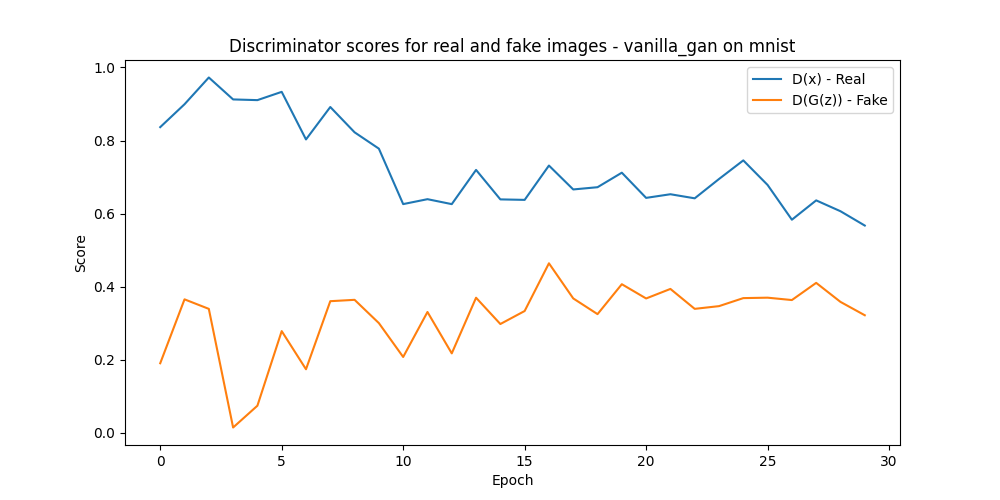|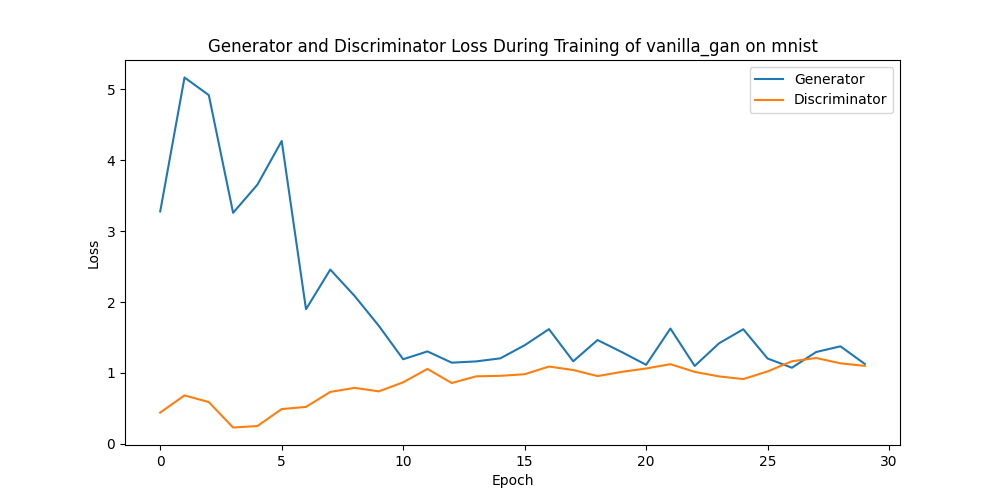|

## Training Dynamics

### Initial Phase (Epochs 0-5)
- **Discriminator Loss**: Started high (~1.38) and quickly decreased to around 0.2-0.5 by epoch 4
- **Generator Loss**: Initially around 0.7, then increased significantly to 3-4 range in epochs 1-3
- **D(x)**: Started at ~0.49 (random guessing) and rapidly improved to 0.95+ by epoch 4
- **D(G(z))**: Initially around 0.49, dropped to 0.03-0.08 by epochs 3-4

This indicates the discriminator quickly learned to distinguish real from fake images, becoming too strong compared to the generator in the early stages.

### Middle Phase (Epochs 6-15)
- **Discriminator Loss**: Stabilized around 0.8-1.0
- **Generator Loss**: Decreased and stabilized around 1.5-2.0
- **D(x)**: Decreased from 0.95+ to 0.6-0.8 range
- **D(G(z))**: Increased from near 0 to 0.2-0.4 range

This shows a more balanced training dynamic where the generator started catching up, producing more convincing images that occasionally fooled the discriminator.

### Late Phase (Epochs 16-29)
- **Discriminator Loss**: Remained stable around 1.0-1.1
- **Generator Loss**: Stabilized around 1.1-1.3
- **D(x)**: Consistently in the 0.6-0.7 range
- **D(G(z))**: Consistently in the 0.3-0.4 range

The relatively stable losses and discriminator outputs suggest the GAN reached an equilibrium where both networks were improving together at similar rates.

## Key Observations

1. **Nash Equilibrium**: By epoch 15, the system approached a Nash equilibrium where D(x) ≈ 0.7 and D(G(z)) ≈ 0.3, indicating a healthy balance between the generator and discriminator.

2. **Mode Collapse Avoidance**: The training logs don't show signs of mode collapse (which would manifest as very low generator loss with high discriminator loss).

3. **Label Smoothing Effect**: The implementation used label smoothing (0.9 instead of 1.0 for real labels), which likely contributed to the stability of training, preventing the discriminator from becoming overconfident.

4. **Training Efficiency**: Each epoch took approximately 18-19 seconds, with the entire training process completing in about 9 minutes and 27 seconds for 30 epochs.

## Training Stability Indicators

- The losses didn't exhibit wild oscillations after the initial phase
- D(x) and D(G(z)) values maintained a reasonable gap throughout training
- The generator loss decreased gradually without sudden drops or spikes

|Trained Image (Final Epoch)|Test Generated Image|
|---------------------------|--------------------|
|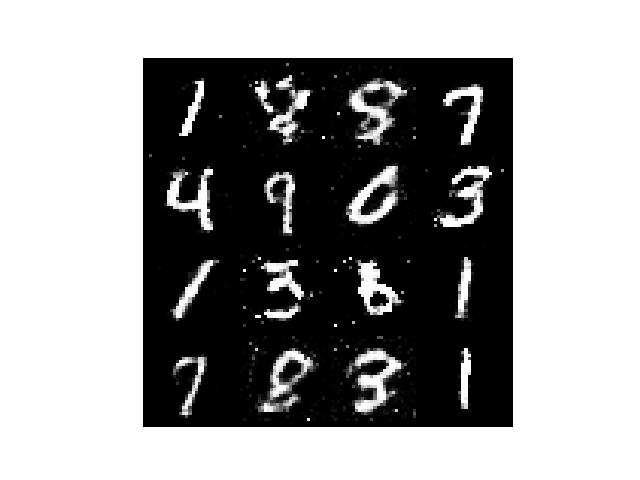|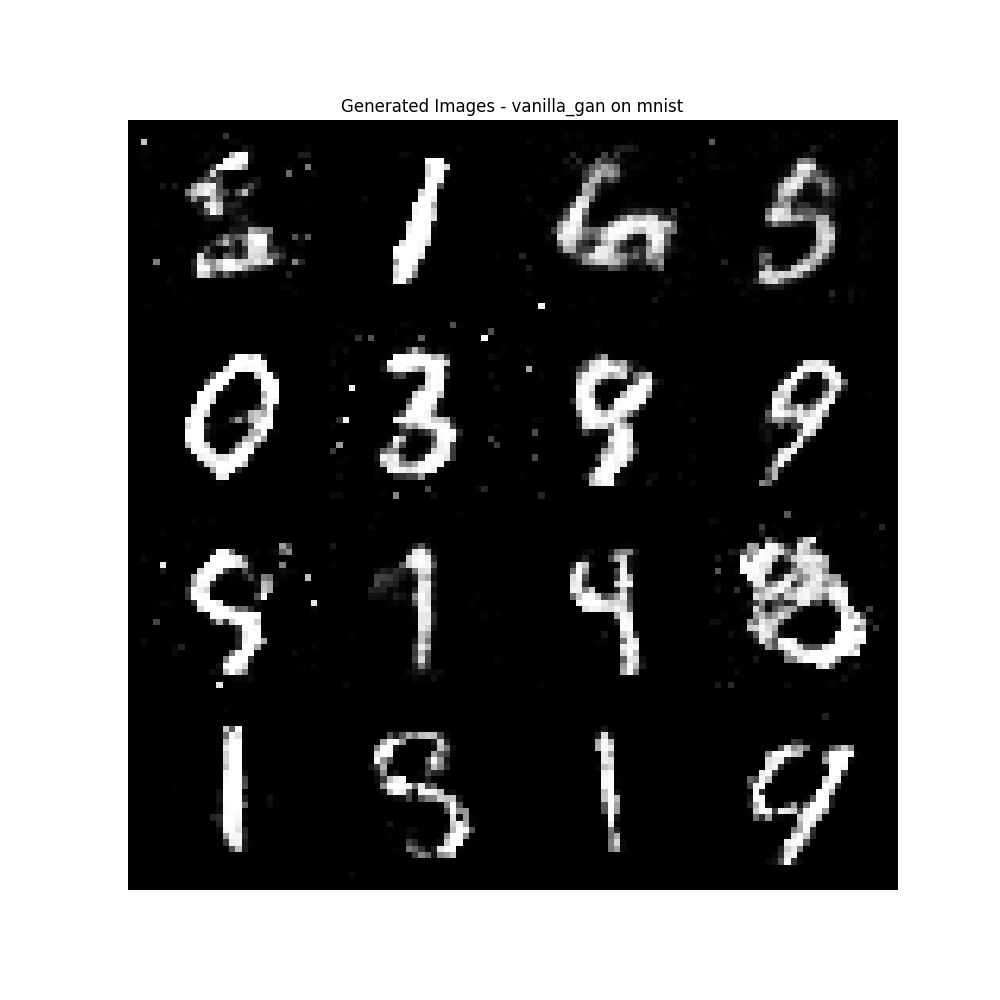|

Here's the training output for DCGAN on CIFAR10:

```bash
(base) jupyter-st125462@puffer:~/RTML/A5$ python gan_trainer.py
2025-03-09 15:13:53,615 - GAN_Trainer - INFO - Using device: cuda
2025-03-09 15:13:53,616 - GAN_Trainer - INFO - Starting DCGAN training on CIFAR-10...
Files already downloaded and verified
Figure(1600x1600)
2025-03-09 15:13:56,048 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [0/500]
2025-03-09 15:13:56,048 - GAN_Trainer - INFO - Discriminator Loss: 1.6325, Generator Loss: 7.0369
2025-03-09 15:13:56,048 - GAN_Trainer - INFO - D(x): 0.6673, D(G(z)): 0.5265
Figure(1600x1600)
2025-03-09 15:14:12,064 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [100/500]
2025-03-09 15:14:12,064 - GAN_Trainer - INFO - Discriminator Loss: 2.2391, Generator Loss: 2.9501
2025-03-09 15:14:12,065 - GAN_Trainer - INFO - D(x): 0.4292, D(G(z)): 0.5723
Figure(1600x1600)
2025-03-09 15:14:28,221 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [200/500]
2025-03-09 15:14:28,222 - GAN_Trainer - INFO - Discriminator Loss: 1.4801, Generator Loss: 3.1456
2025-03-09 15:14:28,222 - GAN_Trainer - INFO - D(x): 0.5289, D(G(z)): 0.4374
Figure(1600x1600)
2025-03-09 15:14:44,567 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [300/500]
2025-03-09 15:14:44,567 - GAN_Trainer - INFO - Discriminator Loss: 1.4717, Generator Loss: 1.0675
2025-03-09 15:14:44,567 - GAN_Trainer - INFO - D(x): 0.4104, D(G(z)): 0.3488
Figure(1600x1600)
2025-03-09 15:15:01,036 - GAN_Trainer - INFO - Epoch: [0/30], Batch Num: [400/500]
2025-03-09 15:15:01,037 - GAN_Trainer - INFO - Discriminator Loss: 1.5867, Generator Loss: 1.2453
2025-03-09 15:15:01,037 - GAN_Trainer - INFO - D(x): 0.4298, D(G(z)): 0.3987
2025-03-09 15:15:16,879 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:15:16,880 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:15:17,486 - GAN_Trainer - INFO - Epoch 0 completed in 82.41 seconds
Figure(1600x1600)
2025-03-09 15:15:18,215 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [0/500]
2025-03-09 15:15:18,215 - GAN_Trainer - INFO - Discriminator Loss: 1.7429, Generator Loss: 1.3046
2025-03-09 15:15:18,215 - GAN_Trainer - INFO - D(x): 0.3505, D(G(z)): 0.3613
Figure(1600x1600)
2025-03-09 15:15:34,722 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [100/500]
2025-03-09 15:15:34,722 - GAN_Trainer - INFO - Discriminator Loss: 1.2954, Generator Loss: 1.3933
2025-03-09 15:15:34,722 - GAN_Trainer - INFO - D(x): 0.5692, D(G(z)): 0.4498
Figure(1600x1600)
2025-03-09 15:15:51,243 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [200/500]
2025-03-09 15:15:51,243 - GAN_Trainer - INFO - Discriminator Loss: 1.4707, Generator Loss: 0.8725
2025-03-09 15:15:51,243 - GAN_Trainer - INFO - D(x): 0.3852, D(G(z)): 0.3163
Figure(1600x1600)
2025-03-09 15:16:07,827 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [300/500]
2025-03-09 15:16:07,828 - GAN_Trainer - INFO - Discriminator Loss: 1.3577, Generator Loss: 1.0440
2025-03-09 15:16:07,828 - GAN_Trainer - INFO - D(x): 0.5496, D(G(z)): 0.4717
Figure(1600x1600)
2025-03-09 15:16:24,454 - GAN_Trainer - INFO - Epoch: [1/30], Batch Num: [400/500]
2025-03-09 15:16:24,454 - GAN_Trainer - INFO - Discriminator Loss: 1.6068, Generator Loss: 1.0099
2025-03-09 15:16:24,455 - GAN_Trainer - INFO - D(x): 0.3256, D(G(z)): 0.3104
2025-03-09 15:16:40,304 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:16:40,305 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:16:40,309 - GAN_Trainer - INFO - Epoch 1 completed in 82.82 seconds
Figure(1600x1600)
2025-03-09 15:16:41,046 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [0/500]
2025-03-09 15:16:41,047 - GAN_Trainer - INFO - Discriminator Loss: 1.5077, Generator Loss: 1.0806
2025-03-09 15:16:41,047 - GAN_Trainer - INFO - D(x): 0.4816, D(G(z)): 0.4794
Figure(1600x1600)
2025-03-09 15:16:57,641 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [100/500]
2025-03-09 15:16:57,641 - GAN_Trainer - INFO - Discriminator Loss: 1.3879, Generator Loss: 0.8934
2025-03-09 15:16:57,642 - GAN_Trainer - INFO - D(x): 0.4449, D(G(z)): 0.4133
Figure(1600x1600)
2025-03-09 15:17:14,203 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [200/500]
2025-03-09 15:17:14,203 - GAN_Trainer - INFO - Discriminator Loss: 1.4934, Generator Loss: 0.9491
2025-03-09 15:17:14,204 - GAN_Trainer - INFO - D(x): 0.4899, D(G(z)): 0.5125
Figure(1600x1600)
2025-03-09 15:17:30,800 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [300/500]
2025-03-09 15:17:30,800 - GAN_Trainer - INFO - Discriminator Loss: 1.4465, Generator Loss: 0.9215
2025-03-09 15:17:30,800 - GAN_Trainer - INFO - D(x): 0.4817, D(G(z)): 0.4792
Figure(1600x1600)
2025-03-09 15:17:47,380 - GAN_Trainer - INFO - Epoch: [2/30], Batch Num: [400/500]
2025-03-09 15:17:47,380 - GAN_Trainer - INFO - Discriminator Loss: 1.3687, Generator Loss: 0.9134
2025-03-09 15:17:47,380 - GAN_Trainer - INFO - D(x): 0.4381, D(G(z)): 0.4089
2025-03-09 15:18:03,219 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:18:03,219 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:18:03,222 - GAN_Trainer - INFO - Epoch 2 completed in 82.91 seconds
Figure(1600x1600)
2025-03-09 15:18:03,960 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [0/500]
2025-03-09 15:18:03,960 - GAN_Trainer - INFO - Discriminator Loss: 1.4255, Generator Loss: 0.8233
2025-03-09 15:18:03,960 - GAN_Trainer - INFO - D(x): 0.4439, D(G(z)): 0.4458
Figure(1600x1600)
2025-03-09 15:18:20,576 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [100/500]
2025-03-09 15:18:20,576 - GAN_Trainer - INFO - Discriminator Loss: 1.4631, Generator Loss: 0.7947
2025-03-09 15:18:20,577 - GAN_Trainer - INFO - D(x): 0.4438, D(G(z)): 0.4485
Figure(1600x1600)
2025-03-09 15:18:37,197 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [200/500]
2025-03-09 15:18:37,198 - GAN_Trainer - INFO - Discriminator Loss: 1.5052, Generator Loss: 0.7816
2025-03-09 15:18:37,198 - GAN_Trainer - INFO - D(x): 0.4272, D(G(z)): 0.4514
Figure(1600x1600)
2025-03-09 15:18:53,796 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [300/500]
2025-03-09 15:18:53,796 - GAN_Trainer - INFO - Discriminator Loss: 1.4325, Generator Loss: 0.9284
2025-03-09 15:18:53,797 - GAN_Trainer - INFO - D(x): 0.4580, D(G(z)): 0.4478
Figure(1600x1600)
2025-03-09 15:19:10,365 - GAN_Trainer - INFO - Epoch: [3/30], Batch Num: [400/500]
2025-03-09 15:19:10,365 - GAN_Trainer - INFO - Discriminator Loss: 1.3813, Generator Loss: 0.8325
2025-03-09 15:19:10,365 - GAN_Trainer - INFO - D(x): 0.4521, D(G(z)): 0.4232
2025-03-09 15:19:26,223 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:19:26,223 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:19:26,227 - GAN_Trainer - INFO - Epoch 3 completed in 83.00 seconds
Figure(1600x1600)
2025-03-09 15:19:26,969 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [0/500]
2025-03-09 15:19:26,969 - GAN_Trainer - INFO - Discriminator Loss: 1.4740, Generator Loss: 0.8340
2025-03-09 15:19:26,969 - GAN_Trainer - INFO - D(x): 0.4160, D(G(z)): 0.4394
Figure(1600x1600)
2025-03-09 15:19:43,575 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [100/500]
2025-03-09 15:19:43,575 - GAN_Trainer - INFO - Discriminator Loss: 1.4801, Generator Loss: 0.8378
2025-03-09 15:19:43,575 - GAN_Trainer - INFO - D(x): 0.3521, D(G(z)): 0.3657
Figure(1600x1600)
2025-03-09 15:20:00,159 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [200/500]
2025-03-09 15:20:00,159 - GAN_Trainer - INFO - Discriminator Loss: 1.3789, Generator Loss: 1.0141
2025-03-09 15:20:00,159 - GAN_Trainer - INFO - D(x): 0.4945, D(G(z)): 0.4701
Figure(1600x1600)
2025-03-09 15:20:16,759 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [300/500]
2025-03-09 15:20:16,759 - GAN_Trainer - INFO - Discriminator Loss: 1.4524, Generator Loss: 0.7843
2025-03-09 15:20:16,759 - GAN_Trainer - INFO - D(x): 0.4154, D(G(z)): 0.4208
Figure(1600x1600)
2025-03-09 15:20:33,323 - GAN_Trainer - INFO - Epoch: [4/30], Batch Num: [400/500]
2025-03-09 15:20:33,324 - GAN_Trainer - INFO - Discriminator Loss: 1.4567, Generator Loss: 0.8170
2025-03-09 15:20:33,324 - GAN_Trainer - INFO - D(x): 0.4506, D(G(z)): 0.4557
2025-03-09 15:20:49,173 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:20:49,173 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:20:49,177 - GAN_Trainer - INFO - Epoch 4 completed in 82.95 seconds
Figure(1600x1600)
2025-03-09 15:20:49,910 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [0/500]
2025-03-09 15:20:49,910 - GAN_Trainer - INFO - Discriminator Loss: 1.3561, Generator Loss: 0.8632
2025-03-09 15:20:49,910 - GAN_Trainer - INFO - D(x): 0.4604, D(G(z)): 0.4136
Figure(1600x1600)
2025-03-09 15:21:06,517 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [100/500]
2025-03-09 15:21:06,517 - GAN_Trainer - INFO - Discriminator Loss: 1.5063, Generator Loss: 1.0057
2025-03-09 15:21:06,517 - GAN_Trainer - INFO - D(x): 0.4099, D(G(z)): 0.4514
Figure(1600x1600)
2025-03-09 15:21:23,137 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [200/500]
2025-03-09 15:21:23,137 - GAN_Trainer - INFO - Discriminator Loss: 1.4605, Generator Loss: 0.9172
2025-03-09 15:21:23,138 - GAN_Trainer - INFO - D(x): 0.4458, D(G(z)): 0.4635
Figure(1600x1600)
2025-03-09 15:21:39,742 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [300/500]
2025-03-09 15:21:39,743 - GAN_Trainer - INFO - Discriminator Loss: 1.3545, Generator Loss: 0.8671
2025-03-09 15:21:39,743 - GAN_Trainer - INFO - D(x): 0.4605, D(G(z)): 0.4259
Figure(1600x1600)
2025-03-09 15:21:56,314 - GAN_Trainer - INFO - Epoch: [5/30], Batch Num: [400/500]
2025-03-09 15:21:56,314 - GAN_Trainer - INFO - Discriminator Loss: 1.4911, Generator Loss: 0.9017
2025-03-09 15:21:56,314 - GAN_Trainer - INFO - D(x): 0.4071, D(G(z)): 0.4357
2025-03-09 15:22:12,150 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:22:12,151 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:22:12,758 - GAN_Trainer - INFO - Epoch 5 completed in 83.58 seconds
Figure(1600x1600)
2025-03-09 15:22:13,551 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [0/500]
2025-03-09 15:22:13,551 - GAN_Trainer - INFO - Discriminator Loss: 1.4112, Generator Loss: 0.9414
2025-03-09 15:22:13,552 - GAN_Trainer - INFO - D(x): 0.4624, D(G(z)): 0.4500
Figure(1600x1600)
2025-03-09 15:22:30,102 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [100/500]
2025-03-09 15:22:30,102 - GAN_Trainer - INFO - Discriminator Loss: 1.3718, Generator Loss: 0.9172
2025-03-09 15:22:30,102 - GAN_Trainer - INFO - D(x): 0.4701, D(G(z)): 0.4474
Figure(1600x1600)
2025-03-09 15:22:46,704 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [200/500]
2025-03-09 15:22:46,704 - GAN_Trainer - INFO - Discriminator Loss: 1.4590, Generator Loss: 0.9622
2025-03-09 15:22:46,704 - GAN_Trainer - INFO - D(x): 0.4244, D(G(z)): 0.4367
Figure(1600x1600)
2025-03-09 15:23:03,307 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [300/500]
2025-03-09 15:23:03,307 - GAN_Trainer - INFO - Discriminator Loss: 1.3857, Generator Loss: 0.8183
2025-03-09 15:23:03,307 - GAN_Trainer - INFO - D(x): 0.4379, D(G(z)): 0.4202
Figure(1600x1600)
2025-03-09 15:23:19,899 - GAN_Trainer - INFO - Epoch: [6/30], Batch Num: [400/500]
2025-03-09 15:23:19,900 - GAN_Trainer - INFO - Discriminator Loss: 1.4682, Generator Loss: 0.8330
2025-03-09 15:23:19,900 - GAN_Trainer - INFO - D(x): 0.4170, D(G(z)): 0.4497
2025-03-09 15:23:35,759 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:23:35,759 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:23:35,763 - GAN_Trainer - INFO - Epoch 6 completed in 83.00 seconds
Figure(1600x1600)
2025-03-09 15:23:36,485 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [0/500]
2025-03-09 15:23:36,485 - GAN_Trainer - INFO - Discriminator Loss: 1.5107, Generator Loss: 0.8373
2025-03-09 15:23:36,485 - GAN_Trainer - INFO - D(x): 0.3820, D(G(z)): 0.4100
Figure(1600x1600)
2025-03-09 15:23:53,107 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [100/500]
2025-03-09 15:23:53,107 - GAN_Trainer - INFO - Discriminator Loss: 1.4145, Generator Loss: 0.8581
2025-03-09 15:23:53,107 - GAN_Trainer - INFO - D(x): 0.4515, D(G(z)): 0.4467
Figure(1600x1600)
2025-03-09 15:24:09,706 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [200/500]
2025-03-09 15:24:09,706 - GAN_Trainer - INFO - Discriminator Loss: 1.3977, Generator Loss: 0.9508
2025-03-09 15:24:09,706 - GAN_Trainer - INFO - D(x): 0.4542, D(G(z)): 0.4355
Figure(1600x1600)
2025-03-09 15:24:26,324 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [300/500]
2025-03-09 15:24:26,324 - GAN_Trainer - INFO - Discriminator Loss: 1.4339, Generator Loss: 0.9101
2025-03-09 15:24:26,325 - GAN_Trainer - INFO - D(x): 0.4217, D(G(z)): 0.4319
Figure(1600x1600)
2025-03-09 15:24:42,904 - GAN_Trainer - INFO - Epoch: [7/30], Batch Num: [400/500]
2025-03-09 15:24:42,904 - GAN_Trainer - INFO - Discriminator Loss: 1.4399, Generator Loss: 0.8367
2025-03-09 15:24:42,905 - GAN_Trainer - INFO - D(x): 0.4672, D(G(z)): 0.4752
2025-03-09 15:24:58,763 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:24:58,763 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:24:58,767 - GAN_Trainer - INFO - Epoch 7 completed in 83.00 seconds
Figure(1600x1600)
2025-03-09 15:24:59,510 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [0/500]
2025-03-09 15:24:59,510 - GAN_Trainer - INFO - Discriminator Loss: 1.4163, Generator Loss: 0.9536
2025-03-09 15:24:59,510 - GAN_Trainer - INFO - D(x): 0.5087, D(G(z)): 0.4970
Figure(1600x1600)
2025-03-09 15:25:16,123 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [100/500]
2025-03-09 15:25:16,123 - GAN_Trainer - INFO - Discriminator Loss: 1.4788, Generator Loss: 0.8267
2025-03-09 15:25:16,123 - GAN_Trainer - INFO - D(x): 0.4294, D(G(z)): 0.4571
Figure(1600x1600)
2025-03-09 15:25:32,752 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [200/500]
2025-03-09 15:25:32,752 - GAN_Trainer - INFO - Discriminator Loss: 1.4655, Generator Loss: 0.8435
2025-03-09 15:25:32,753 - GAN_Trainer - INFO - D(x): 0.4502, D(G(z)): 0.4713
Figure(1600x1600)
2025-03-09 15:25:49,359 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [300/500]
2025-03-09 15:25:49,360 - GAN_Trainer - INFO - Discriminator Loss: 1.4826, Generator Loss: 0.9134
2025-03-09 15:25:49,360 - GAN_Trainer - INFO - D(x): 0.4346, D(G(z)): 0.4671
Figure(1600x1600)
2025-03-09 15:26:05,894 - GAN_Trainer - INFO - Epoch: [8/30], Batch Num: [400/500]
2025-03-09 15:26:05,894 - GAN_Trainer - INFO - Discriminator Loss: 1.3952, Generator Loss: 1.0230
2025-03-09 15:26:05,895 - GAN_Trainer - INFO - D(x): 0.4730, D(G(z)): 0.4649
2025-03-09 15:26:21,690 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:26:21,690 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:26:21,695 - GAN_Trainer - INFO - Epoch 8 completed in 82.93 seconds
Figure(1600x1600)
2025-03-09 15:26:22,420 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [0/500]
2025-03-09 15:26:22,420 - GAN_Trainer - INFO - Discriminator Loss: 1.4451, Generator Loss: 0.9557
2025-03-09 15:26:22,420 - GAN_Trainer - INFO - D(x): 0.4449, D(G(z)): 0.4585
Figure(1600x1600)
2025-03-09 15:26:38,902 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [100/500]
2025-03-09 15:26:38,902 - GAN_Trainer - INFO - Discriminator Loss: 1.5036, Generator Loss: 0.8992
2025-03-09 15:26:38,902 - GAN_Trainer - INFO - D(x): 0.4261, D(G(z)): 0.4728
Figure(1600x1600)
2025-03-09 15:26:55,426 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [200/500]
2025-03-09 15:26:55,426 - GAN_Trainer - INFO - Discriminator Loss: 1.5015, Generator Loss: 0.9375
2025-03-09 15:26:55,427 - GAN_Trainer - INFO - D(x): 0.4580, D(G(z)): 0.4905
Figure(1600x1600)
2025-03-09 15:27:11,890 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [300/500]
2025-03-09 15:27:11,890 - GAN_Trainer - INFO - Discriminator Loss: 1.4237, Generator Loss: 0.8673
2025-03-09 15:27:11,890 - GAN_Trainer - INFO - D(x): 0.4438, D(G(z)): 0.4547
Figure(1600x1600)
2025-03-09 15:27:28,339 - GAN_Trainer - INFO - Epoch: [9/30], Batch Num: [400/500]
2025-03-09 15:27:28,340 - GAN_Trainer - INFO - Discriminator Loss: 1.3845, Generator Loss: 0.9379
2025-03-09 15:27:28,340 - GAN_Trainer - INFO - D(x): 0.4647, D(G(z)): 0.4588
2025-03-09 15:27:44,043 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:27:44,043 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:27:44,047 - GAN_Trainer - INFO - Epoch 9 completed in 82.35 seconds
Figure(1600x1600)
2025-03-09 15:27:44,797 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [0/500]
2025-03-09 15:27:44,798 - GAN_Trainer - INFO - Discriminator Loss: 1.3518, Generator Loss: 0.9307
2025-03-09 15:27:44,798 - GAN_Trainer - INFO - D(x): 0.4855, D(G(z)): 0.4552
Figure(1600x1600)
2025-03-09 15:28:01,182 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [100/500]
2025-03-09 15:28:01,182 - GAN_Trainer - INFO - Discriminator Loss: 1.4681, Generator Loss: 0.9980
2025-03-09 15:28:01,182 - GAN_Trainer - INFO - D(x): 0.4483, D(G(z)): 0.4757
Figure(1600x1600)
2025-03-09 15:28:17,574 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [200/500]
2025-03-09 15:28:17,574 - GAN_Trainer - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.8245
2025-03-09 15:28:17,574 - GAN_Trainer - INFO - D(x): 0.4681, D(G(z)): 0.4571
Figure(1600x1600)
2025-03-09 15:28:33,948 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [300/500]
2025-03-09 15:28:33,948 - GAN_Trainer - INFO - Discriminator Loss: 1.4239, Generator Loss: 0.8834
2025-03-09 15:28:33,948 - GAN_Trainer - INFO - D(x): 0.4760, D(G(z)): 0.4828
Figure(1600x1600)
2025-03-09 15:28:50,304 - GAN_Trainer - INFO - Epoch: [10/30], Batch Num: [400/500]
2025-03-09 15:28:50,304 - GAN_Trainer - INFO - Discriminator Loss: 1.4200, Generator Loss: 0.8780
2025-03-09 15:28:50,304 - GAN_Trainer - INFO - D(x): 0.4423, D(G(z)): 0.4498
2025-03-09 15:29:05,929 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:29:05,930 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:29:06,532 - GAN_Trainer - INFO - Epoch 10 completed in 82.48 seconds
Figure(1600x1600)
2025-03-09 15:29:07,299 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [0/500]
2025-03-09 15:29:07,299 - GAN_Trainer - INFO - Discriminator Loss: 1.4513, Generator Loss: 0.8943
2025-03-09 15:29:07,299 - GAN_Trainer - INFO - D(x): 0.4407, D(G(z)): 0.4583
Figure(1600x1600)
2025-03-09 15:29:23,618 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [100/500]
2025-03-09 15:29:23,618 - GAN_Trainer - INFO - Discriminator Loss: 1.4027, Generator Loss: 0.8340
2025-03-09 15:29:23,618 - GAN_Trainer - INFO - D(x): 0.4484, D(G(z)): 0.4470
Figure(1600x1600)
2025-03-09 15:29:39,931 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [200/500]
2025-03-09 15:29:39,931 - GAN_Trainer - INFO - Discriminator Loss: 1.3820, Generator Loss: 0.8230
2025-03-09 15:29:39,931 - GAN_Trainer - INFO - D(x): 0.4312, D(G(z)): 0.4224
Figure(1600x1600)
2025-03-09 15:29:56,293 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [300/500]
2025-03-09 15:29:56,293 - GAN_Trainer - INFO - Discriminator Loss: 1.4554, Generator Loss: 1.1057
2025-03-09 15:29:56,294 - GAN_Trainer - INFO - D(x): 0.4431, D(G(z)): 0.4681
Figure(1600x1600)
2025-03-09 15:30:12,633 - GAN_Trainer - INFO - Epoch: [11/30], Batch Num: [400/500]
2025-03-09 15:30:12,633 - GAN_Trainer - INFO - Discriminator Loss: 1.4145, Generator Loss: 0.9192
2025-03-09 15:30:12,633 - GAN_Trainer - INFO - D(x): 0.5036, D(G(z)): 0.4801
2025-03-09 15:30:28,269 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:30:28,270 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:30:28,273 - GAN_Trainer - INFO - Epoch 11 completed in 81.74 seconds
Figure(1600x1600)
2025-03-09 15:30:29,001 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [0/500]
2025-03-09 15:30:29,002 - GAN_Trainer - INFO - Discriminator Loss: 1.5062, Generator Loss: 0.9021
2025-03-09 15:30:29,002 - GAN_Trainer - INFO - D(x): 0.3977, D(G(z)): 0.4420
Figure(1600x1600)
2025-03-09 15:30:45,377 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [100/500]
2025-03-09 15:30:45,377 - GAN_Trainer - INFO - Discriminator Loss: 1.4470, Generator Loss: 0.8018
2025-03-09 15:30:45,378 - GAN_Trainer - INFO - D(x): 0.4792, D(G(z)): 0.4959
Figure(1600x1600)
2025-03-09 15:31:01,782 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [200/500]
2025-03-09 15:31:01,782 - GAN_Trainer - INFO - Discriminator Loss: 1.3656, Generator Loss: 0.8175
2025-03-09 15:31:01,782 - GAN_Trainer - INFO - D(x): 0.4438, D(G(z)): 0.4230
Figure(1600x1600)
2025-03-09 15:31:18,102 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [300/500]
2025-03-09 15:31:18,103 - GAN_Trainer - INFO - Discriminator Loss: 1.4731, Generator Loss: 0.8671
2025-03-09 15:31:18,103 - GAN_Trainer - INFO - D(x): 0.4208, D(G(z)): 0.4455
Figure(1600x1600)
2025-03-09 15:31:34,493 - GAN_Trainer - INFO - Epoch: [12/30], Batch Num: [400/500]
2025-03-09 15:31:34,493 - GAN_Trainer - INFO - Discriminator Loss: 1.4160, Generator Loss: 0.8308
2025-03-09 15:31:34,493 - GAN_Trainer - INFO - D(x): 0.4748, D(G(z)): 0.4799
2025-03-09 15:31:50,146 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:31:50,146 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:31:50,150 - GAN_Trainer - INFO - Epoch 12 completed in 81.88 seconds
Figure(1600x1600)
2025-03-09 15:31:50,899 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [0/500]
2025-03-09 15:31:50,900 - GAN_Trainer - INFO - Discriminator Loss: 1.4504, Generator Loss: 0.9231
2025-03-09 15:31:50,900 - GAN_Trainer - INFO - D(x): 0.4526, D(G(z)): 0.4854
Figure(1600x1600)
2025-03-09 15:32:07,291 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [100/500]
2025-03-09 15:32:07,291 - GAN_Trainer - INFO - Discriminator Loss: 1.4170, Generator Loss: 0.9504
2025-03-09 15:32:07,291 - GAN_Trainer - INFO - D(x): 0.4789, D(G(z)): 0.4749
Figure(1600x1600)
2025-03-09 15:32:23,699 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [200/500]
2025-03-09 15:32:23,699 - GAN_Trainer - INFO - Discriminator Loss: 1.4218, Generator Loss: 0.8907
2025-03-09 15:32:23,699 - GAN_Trainer - INFO - D(x): 0.4489, D(G(z)): 0.4620
Figure(1600x1600)
2025-03-09 15:32:40,121 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [300/500]
2025-03-09 15:32:40,122 - GAN_Trainer - INFO - Discriminator Loss: 1.4225, Generator Loss: 0.8967
2025-03-09 15:32:40,122 - GAN_Trainer - INFO - D(x): 0.4493, D(G(z)): 0.4587
Figure(1600x1600)
2025-03-09 15:32:56,512 - GAN_Trainer - INFO - Epoch: [13/30], Batch Num: [400/500]
2025-03-09 15:32:56,512 - GAN_Trainer - INFO - Discriminator Loss: 1.4127, Generator Loss: 0.8764
2025-03-09 15:32:56,512 - GAN_Trainer - INFO - D(x): 0.4686, D(G(z)): 0.4723
2025-03-09 15:33:12,225 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:33:12,226 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:33:12,229 - GAN_Trainer - INFO - Epoch 13 completed in 82.08 seconds
Figure(1600x1600)
2025-03-09 15:33:12,966 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [0/500]
2025-03-09 15:33:12,966 - GAN_Trainer - INFO - Discriminator Loss: 1.4341, Generator Loss: 1.0542
2025-03-09 15:33:12,966 - GAN_Trainer - INFO - D(x): 0.4764, D(G(z)): 0.4882
Figure(1600x1600)
2025-03-09 15:33:29,388 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [100/500]
2025-03-09 15:33:29,388 - GAN_Trainer - INFO - Discriminator Loss: 1.4369, Generator Loss: 1.1326
2025-03-09 15:33:29,389 - GAN_Trainer - INFO - D(x): 0.4348, D(G(z)): 0.4527
Figure(1600x1600)
2025-03-09 15:33:45,816 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [200/500]
2025-03-09 15:33:45,817 - GAN_Trainer - INFO - Discriminator Loss: 1.3743, Generator Loss: 0.8691
2025-03-09 15:33:45,817 - GAN_Trainer - INFO - D(x): 0.4471, D(G(z)): 0.4381
Figure(1600x1600)
2025-03-09 15:34:02,269 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [300/500]
2025-03-09 15:34:02,269 - GAN_Trainer - INFO - Discriminator Loss: 1.4174, Generator Loss: 0.8042
2025-03-09 15:34:02,269 - GAN_Trainer - INFO - D(x): 0.4486, D(G(z)): 0.4600
Figure(1600x1600)
2025-03-09 15:34:18,754 - GAN_Trainer - INFO - Epoch: [14/30], Batch Num: [400/500]
2025-03-09 15:34:18,754 - GAN_Trainer - INFO - Discriminator Loss: 1.4359, Generator Loss: 0.8196
2025-03-09 15:34:18,754 - GAN_Trainer - INFO - D(x): 0.4643, D(G(z)): 0.4701
2025-03-09 15:34:34,491 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:34:34,491 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:34:34,495 - GAN_Trainer - INFO - Epoch 14 completed in 82.27 seconds
Figure(1600x1600)
2025-03-09 15:34:35,242 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [0/500]
2025-03-09 15:34:35,242 - GAN_Trainer - INFO - Discriminator Loss: 1.3706, Generator Loss: 0.8188
2025-03-09 15:34:35,242 - GAN_Trainer - INFO - D(x): 0.5004, D(G(z)): 0.4779
Figure(1600x1600)
2025-03-09 15:34:51,707 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [100/500]
2025-03-09 15:34:51,707 - GAN_Trainer - INFO - Discriminator Loss: 1.4352, Generator Loss: 0.8622
2025-03-09 15:34:51,707 - GAN_Trainer - INFO - D(x): 0.4465, D(G(z)): 0.4471
Figure(1600x1600)
2025-03-09 15:35:08,206 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [200/500]
2025-03-09 15:35:08,206 - GAN_Trainer - INFO - Discriminator Loss: 1.3798, Generator Loss: 0.9059
2025-03-09 15:35:08,206 - GAN_Trainer - INFO - D(x): 0.4129, D(G(z)): 0.4004
Figure(1600x1600)
2025-03-09 15:35:24,678 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [300/500]
2025-03-09 15:35:24,679 - GAN_Trainer - INFO - Discriminator Loss: 1.4504, Generator Loss: 0.8018
2025-03-09 15:35:24,679 - GAN_Trainer - INFO - D(x): 0.4429, D(G(z)): 0.4544
Figure(1600x1600)
2025-03-09 15:35:41,168 - GAN_Trainer - INFO - Epoch: [15/30], Batch Num: [400/500]
2025-03-09 15:35:41,168 - GAN_Trainer - INFO - Discriminator Loss: 1.4667, Generator Loss: 0.8587
2025-03-09 15:35:41,168 - GAN_Trainer - INFO - D(x): 0.4465, D(G(z)): 0.4628
2025-03-09 15:35:56,901 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:35:56,901 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:35:57,024 - GAN_Trainer - INFO - Epoch 15 completed in 82.53 seconds
Figure(1600x1600)
2025-03-09 15:35:57,774 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [0/500]
2025-03-09 15:35:57,774 - GAN_Trainer - INFO - Discriminator Loss: 1.4820, Generator Loss: 0.8311
2025-03-09 15:35:57,774 - GAN_Trainer - INFO - D(x): 0.4153, D(G(z)): 0.4236
Figure(1600x1600)
2025-03-09 15:36:14,236 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [100/500]
2025-03-09 15:36:14,236 - GAN_Trainer - INFO - Discriminator Loss: 1.3742, Generator Loss: 0.9227
2025-03-09 15:36:14,237 - GAN_Trainer - INFO - D(x): 0.4154, D(G(z)): 0.3974
Figure(1600x1600)
2025-03-09 15:36:31,091 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [200/500]
2025-03-09 15:36:31,092 - GAN_Trainer - INFO - Discriminator Loss: 1.4333, Generator Loss: 0.8636
2025-03-09 15:36:31,092 - GAN_Trainer - INFO - D(x): 0.4806, D(G(z)): 0.4892
Figure(1600x1600)
2025-03-09 15:36:47,643 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [300/500]
2025-03-09 15:36:47,643 - GAN_Trainer - INFO - Discriminator Loss: 1.3914, Generator Loss: 0.7916
2025-03-09 15:36:47,644 - GAN_Trainer - INFO - D(x): 0.4412, D(G(z)): 0.4405
Figure(1600x1600)
2025-03-09 15:37:04,150 - GAN_Trainer - INFO - Epoch: [16/30], Batch Num: [400/500]
2025-03-09 15:37:04,150 - GAN_Trainer - INFO - Discriminator Loss: 1.4130, Generator Loss: 0.9171
2025-03-09 15:37:04,150 - GAN_Trainer - INFO - D(x): 0.4443, D(G(z)): 0.4488
2025-03-09 15:37:19,937 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:37:19,938 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:37:19,947 - GAN_Trainer - INFO - Epoch 16 completed in 82.92 seconds
Figure(1600x1600)
2025-03-09 15:37:20,672 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [0/500]
2025-03-09 15:37:20,672 - GAN_Trainer - INFO - Discriminator Loss: 1.4153, Generator Loss: 0.7663
2025-03-09 15:37:20,672 - GAN_Trainer - INFO - D(x): 0.4102, D(G(z)): 0.4124
Figure(1600x1600)
2025-03-09 15:37:37,182 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [100/500]
2025-03-09 15:37:37,182 - GAN_Trainer - INFO - Discriminator Loss: 1.4351, Generator Loss: 0.7051
2025-03-09 15:37:37,183 - GAN_Trainer - INFO - D(x): 0.4289, D(G(z)): 0.4366
Figure(1600x1600)
2025-03-09 15:37:53,724 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [200/500]
2025-03-09 15:37:53,724 - GAN_Trainer - INFO - Discriminator Loss: 1.3830, Generator Loss: 0.9182
2025-03-09 15:37:53,725 - GAN_Trainer - INFO - D(x): 0.4975, D(G(z)): 0.4863
Figure(1600x1600)
2025-03-09 15:38:10,293 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [300/500]
2025-03-09 15:38:10,293 - GAN_Trainer - INFO - Discriminator Loss: 1.4049, Generator Loss: 0.8124
2025-03-09 15:38:10,294 - GAN_Trainer - INFO - D(x): 0.4458, D(G(z)): 0.4528
Figure(1600x1600)
2025-03-09 15:38:26,857 - GAN_Trainer - INFO - Epoch: [17/30], Batch Num: [400/500]
2025-03-09 15:38:26,857 - GAN_Trainer - INFO - Discriminator Loss: 1.5276, Generator Loss: 0.8503
2025-03-09 15:38:26,858 - GAN_Trainer - INFO - D(x): 0.4526, D(G(z)): 0.5014
2025-03-09 15:38:42,666 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:38:42,667 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:38:42,670 - GAN_Trainer - INFO - Epoch 17 completed in 82.72 seconds
Figure(1600x1600)
2025-03-09 15:38:43,407 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [0/500]
2025-03-09 15:38:43,408 - GAN_Trainer - INFO - Discriminator Loss: 1.4750, Generator Loss: 0.8566
2025-03-09 15:38:43,408 - GAN_Trainer - INFO - D(x): 0.4742, D(G(z)): 0.4819
Figure(1600x1600)
2025-03-09 15:38:59,971 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [100/500]
2025-03-09 15:38:59,972 - GAN_Trainer - INFO - Discriminator Loss: 1.4203, Generator Loss: 0.8840
2025-03-09 15:38:59,972 - GAN_Trainer - INFO - D(x): 0.4299, D(G(z)): 0.4349
Figure(1600x1600)
2025-03-09 15:39:16,509 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [200/500]
2025-03-09 15:39:16,509 - GAN_Trainer - INFO - Discriminator Loss: 1.4223, Generator Loss: 0.9500
2025-03-09 15:39:16,509 - GAN_Trainer - INFO - D(x): 0.4140, D(G(z)): 0.4250
Figure(1600x1600)
2025-03-09 15:39:33,033 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [300/500]
2025-03-09 15:39:33,033 - GAN_Trainer - INFO - Discriminator Loss: 1.4006, Generator Loss: 0.8077
2025-03-09 15:39:33,033 - GAN_Trainer - INFO - D(x): 0.4800, D(G(z)): 0.4797
Figure(1600x1600)
2025-03-09 15:39:49,597 - GAN_Trainer - INFO - Epoch: [18/30], Batch Num: [400/500]
2025-03-09 15:39:49,597 - GAN_Trainer - INFO - Discriminator Loss: 1.4041, Generator Loss: 0.8010
2025-03-09 15:39:49,597 - GAN_Trainer - INFO - D(x): 0.4761, D(G(z)): 0.4724
2025-03-09 15:40:05,374 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:40:05,374 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:40:05,378 - GAN_Trainer - INFO - Epoch 18 completed in 82.71 seconds
Figure(1600x1600)
2025-03-09 15:40:06,124 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [0/500]
2025-03-09 15:40:06,124 - GAN_Trainer - INFO - Discriminator Loss: 1.3934, Generator Loss: 0.8437
2025-03-09 15:40:06,124 - GAN_Trainer - INFO - D(x): 0.4957, D(G(z)): 0.4889
Figure(1600x1600)
2025-03-09 15:40:22,677 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [100/500]
2025-03-09 15:40:22,677 - GAN_Trainer - INFO - Discriminator Loss: 1.3930, Generator Loss: 0.8876
2025-03-09 15:40:22,677 - GAN_Trainer - INFO - D(x): 0.4594, D(G(z)): 0.4518
Figure(1600x1600)
2025-03-09 15:40:39,195 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [200/500]
2025-03-09 15:40:39,195 - GAN_Trainer - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.8345
2025-03-09 15:40:39,196 - GAN_Trainer - INFO - D(x): 0.4638, D(G(z)): 0.4600
Figure(1600x1600)
2025-03-09 15:40:55,727 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [300/500]
2025-03-09 15:40:55,727 - GAN_Trainer - INFO - Discriminator Loss: 1.3969, Generator Loss: 0.8227
2025-03-09 15:40:55,727 - GAN_Trainer - INFO - D(x): 0.4546, D(G(z)): 0.4539
Figure(1600x1600)
2025-03-09 15:41:12,280 - GAN_Trainer - INFO - Epoch: [19/30], Batch Num: [400/500]
2025-03-09 15:41:12,281 - GAN_Trainer - INFO - Discriminator Loss: 1.3784, Generator Loss: 0.8865
2025-03-09 15:41:12,281 - GAN_Trainer - INFO - D(x): 0.4975, D(G(z)): 0.4839
2025-03-09 15:41:28,080 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:41:28,081 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:41:28,084 - GAN_Trainer - INFO - Epoch 19 completed in 82.71 seconds
Figure(1600x1600)
2025-03-09 15:41:28,823 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [0/500]
2025-03-09 15:41:28,824 - GAN_Trainer - INFO - Discriminator Loss: 1.4487, Generator Loss: 0.9565
2025-03-09 15:41:28,824 - GAN_Trainer - INFO - D(x): 0.4140, D(G(z)): 0.4266
Figure(1600x1600)
2025-03-09 15:41:45,407 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [100/500]
2025-03-09 15:41:45,407 - GAN_Trainer - INFO - Discriminator Loss: 1.4478, Generator Loss: 0.8562
2025-03-09 15:41:45,407 - GAN_Trainer - INFO - D(x): 0.4174, D(G(z)): 0.4434
Figure(1600x1600)
2025-03-09 15:42:01,953 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [200/500]
2025-03-09 15:42:01,953 - GAN_Trainer - INFO - Discriminator Loss: 1.3763, Generator Loss: 0.8853
2025-03-09 15:42:01,954 - GAN_Trainer - INFO - D(x): 0.4733, D(G(z)): 0.4658
Figure(1600x1600)
2025-03-09 15:42:18,505 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [300/500]
2025-03-09 15:42:18,505 - GAN_Trainer - INFO - Discriminator Loss: 1.4242, Generator Loss: 0.9669
2025-03-09 15:42:18,505 - GAN_Trainer - INFO - D(x): 0.4193, D(G(z)): 0.4265
Figure(1600x1600)
2025-03-09 15:42:35,094 - GAN_Trainer - INFO - Epoch: [20/30], Batch Num: [400/500]
2025-03-09 15:42:35,094 - GAN_Trainer - INFO - Discriminator Loss: 1.3586, Generator Loss: 0.9380
2025-03-09 15:42:35,094 - GAN_Trainer - INFO - D(x): 0.4437, D(G(z)): 0.4213
2025-03-09 15:42:50,936 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:42:50,937 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:42:51,066 - GAN_Trainer - INFO - Epoch 20 completed in 82.98 seconds
Figure(1600x1600)
2025-03-09 15:42:51,817 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [0/500]
2025-03-09 15:42:51,817 - GAN_Trainer - INFO - Discriminator Loss: 1.4145, Generator Loss: 0.8301
2025-03-09 15:42:51,817 - GAN_Trainer - INFO - D(x): 0.4300, D(G(z)): 0.4364
Figure(1600x1600)
2025-03-09 15:43:08,365 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [100/500]
2025-03-09 15:43:08,365 - GAN_Trainer - INFO - Discriminator Loss: 1.3344, Generator Loss: 0.9561
2025-03-09 15:43:08,366 - GAN_Trainer - INFO - D(x): 0.4684, D(G(z)): 0.4317
Figure(1600x1600)
2025-03-09 15:43:24,953 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [200/500]
2025-03-09 15:43:24,953 - GAN_Trainer - INFO - Discriminator Loss: 1.4829, Generator Loss: 0.7718
2025-03-09 15:43:24,953 - GAN_Trainer - INFO - D(x): 0.4198, D(G(z)): 0.4358
Figure(1600x1600)
2025-03-09 15:43:41,526 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [300/500]
2025-03-09 15:43:41,526 - GAN_Trainer - INFO - Discriminator Loss: 1.3383, Generator Loss: 0.9010
2025-03-09 15:43:41,526 - GAN_Trainer - INFO - D(x): 0.4634, D(G(z)): 0.4261
Figure(1600x1600)
2025-03-09 15:43:58,095 - GAN_Trainer - INFO - Epoch: [21/30], Batch Num: [400/500]
2025-03-09 15:43:58,095 - GAN_Trainer - INFO - Discriminator Loss: 1.4168, Generator Loss: 0.7623
2025-03-09 15:43:58,095 - GAN_Trainer - INFO - D(x): 0.4801, D(G(z)): 0.4846
2025-03-09 15:44:13,944 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:44:13,945 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:44:13,948 - GAN_Trainer - INFO - Epoch 21 completed in 82.88 seconds
Figure(1600x1600)
2025-03-09 15:44:14,703 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [0/500]
2025-03-09 15:44:14,703 - GAN_Trainer - INFO - Discriminator Loss: 1.3556, Generator Loss: 0.9127
2025-03-09 15:44:14,704 - GAN_Trainer - INFO - D(x): 0.4421, D(G(z)): 0.4224
Figure(1600x1600)
2025-03-09 15:44:31,312 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [100/500]
2025-03-09 15:44:31,312 - GAN_Trainer - INFO - Discriminator Loss: 1.3925, Generator Loss: 0.9431
2025-03-09 15:44:31,312 - GAN_Trainer - INFO - D(x): 0.4715, D(G(z)): 0.4485
Figure(1600x1600)
2025-03-09 15:44:47,856 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [200/500]
2025-03-09 15:44:47,856 - GAN_Trainer - INFO - Discriminator Loss: 1.5190, Generator Loss: 0.8515
2025-03-09 15:44:47,856 - GAN_Trainer - INFO - D(x): 0.3877, D(G(z)): 0.4409
Figure(1600x1600)
2025-03-09 15:45:04,468 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [300/500]
2025-03-09 15:45:04,468 - GAN_Trainer - INFO - Discriminator Loss: 1.3540, Generator Loss: 0.8952
2025-03-09 15:45:04,469 - GAN_Trainer - INFO - D(x): 0.4093, D(G(z)): 0.3759
Figure(1600x1600)
2025-03-09 15:45:21,074 - GAN_Trainer - INFO - Epoch: [22/30], Batch Num: [400/500]
2025-03-09 15:45:21,075 - GAN_Trainer - INFO - Discriminator Loss: 1.3790, Generator Loss: 0.9502
2025-03-09 15:45:21,075 - GAN_Trainer - INFO - D(x): 0.5063, D(G(z)): 0.4856
2025-03-09 15:45:36,923 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:45:36,923 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:45:36,927 - GAN_Trainer - INFO - Epoch 22 completed in 82.98 seconds
Figure(1600x1600)
2025-03-09 15:45:37,667 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [0/500]
2025-03-09 15:45:37,667 - GAN_Trainer - INFO - Discriminator Loss: 1.3241, Generator Loss: 1.0569
2025-03-09 15:45:37,667 - GAN_Trainer - INFO - D(x): 0.5085, D(G(z)): 0.4583
Figure(1600x1600)
2025-03-09 15:45:54,282 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [100/500]
2025-03-09 15:45:54,282 - GAN_Trainer - INFO - Discriminator Loss: 1.4453, Generator Loss: 1.1388
2025-03-09 15:45:54,283 - GAN_Trainer - INFO - D(x): 0.3418, D(G(z)): 0.3426
Figure(1600x1600)
2025-03-09 15:46:10,921 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [200/500]
2025-03-09 15:46:10,921 - GAN_Trainer - INFO - Discriminator Loss: 1.3512, Generator Loss: 1.0133
2025-03-09 15:46:10,921 - GAN_Trainer - INFO - D(x): 0.4710, D(G(z)): 0.4273
Figure(1600x1600)
2025-03-09 15:46:27,522 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [300/500]
2025-03-09 15:46:27,522 - GAN_Trainer - INFO - Discriminator Loss: 1.4232, Generator Loss: 1.1320
2025-03-09 15:46:27,523 - GAN_Trainer - INFO - D(x): 0.6052, D(G(z)): 0.5725
Figure(1600x1600)
2025-03-09 15:46:44,141 - GAN_Trainer - INFO - Epoch: [23/30], Batch Num: [400/500]
2025-03-09 15:46:44,141 - GAN_Trainer - INFO - Discriminator Loss: 1.4081, Generator Loss: 2.0576
2025-03-09 15:46:44,142 - GAN_Trainer - INFO - D(x): 0.5450, D(G(z)): 0.5237
2025-03-09 15:47:00,007 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:47:00,008 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:47:00,011 - GAN_Trainer - INFO - Epoch 23 completed in 83.08 seconds
Figure(1600x1600)
2025-03-09 15:47:00,784 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [0/500]
2025-03-09 15:47:00,784 - GAN_Trainer - INFO - Discriminator Loss: 1.3220, Generator Loss: 1.4131
2025-03-09 15:47:00,784 - GAN_Trainer - INFO - D(x): 0.5117, D(G(z)): 0.4603
Figure(1600x1600)
2025-03-09 15:47:17,420 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [100/500]
2025-03-09 15:47:17,420 - GAN_Trainer - INFO - Discriminator Loss: 1.3336, Generator Loss: 1.0621
2025-03-09 15:47:17,421 - GAN_Trainer - INFO - D(x): 0.5133, D(G(z)): 0.4580
Figure(1600x1600)
2025-03-09 15:47:34,047 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [200/500]
2025-03-09 15:47:34,047 - GAN_Trainer - INFO - Discriminator Loss: 1.3961, Generator Loss: 1.7056
2025-03-09 15:47:34,047 - GAN_Trainer - INFO - D(x): 0.5105, D(G(z)): 0.4994
Figure(1600x1600)
2025-03-09 15:47:50,685 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [300/500]
2025-03-09 15:47:50,685 - GAN_Trainer - INFO - Discriminator Loss: 1.6201, Generator Loss: 1.7306
2025-03-09 15:47:50,685 - GAN_Trainer - INFO - D(x): 0.2314, D(G(z)): 0.1781
Figure(1600x1600)
2025-03-09 15:48:07,331 - GAN_Trainer - INFO - Epoch: [24/30], Batch Num: [400/500]
2025-03-09 15:48:07,332 - GAN_Trainer - INFO - Discriminator Loss: 1.3436, Generator Loss: 1.4920
2025-03-09 15:48:07,332 - GAN_Trainer - INFO - D(x): 0.4911, D(G(z)): 0.4415
2025-03-09 15:48:23,201 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:48:23,201 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:48:23,205 - GAN_Trainer - INFO - Epoch 24 completed in 83.19 seconds
Figure(1600x1600)
2025-03-09 15:48:23,960 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [0/500]
2025-03-09 15:48:23,960 - GAN_Trainer - INFO - Discriminator Loss: 1.3802, Generator Loss: 0.9735
2025-03-09 15:48:23,960 - GAN_Trainer - INFO - D(x): 0.4055, D(G(z)): 0.3731
Figure(1600x1600)
2025-03-09 15:48:40,598 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [100/500]
2025-03-09 15:48:40,598 - GAN_Trainer - INFO - Discriminator Loss: 1.2782, Generator Loss: 0.9700
2025-03-09 15:48:40,598 - GAN_Trainer - INFO - D(x): 0.3786, D(G(z)): 0.2467
Figure(1600x1600)
2025-03-09 15:48:57,224 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [200/500]
2025-03-09 15:48:57,224 - GAN_Trainer - INFO - Discriminator Loss: 1.3394, Generator Loss: 1.4469
2025-03-09 15:48:57,224 - GAN_Trainer - INFO - D(x): 0.4711, D(G(z)): 0.4291
Figure(1600x1600)
2025-03-09 15:49:13,873 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [300/500]
2025-03-09 15:49:13,873 - GAN_Trainer - INFO - Discriminator Loss: 1.1179, Generator Loss: 1.1452
2025-03-09 15:49:13,873 - GAN_Trainer - INFO - D(x): 0.4433, D(G(z)): 0.2326
Figure(1600x1600)
2025-03-09 15:49:30,461 - GAN_Trainer - INFO - Epoch: [25/30], Batch Num: [400/500]
2025-03-09 15:49:30,461 - GAN_Trainer - INFO - Discriminator Loss: 1.2865, Generator Loss: 1.6229
2025-03-09 15:49:30,461 - GAN_Trainer - INFO - D(x): 0.5081, D(G(z)): 0.4231
2025-03-09 15:49:46,301 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:49:46,301 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:49:46,465 - GAN_Trainer - INFO - Epoch 25 completed in 83.26 seconds
Figure(1600x1600)
2025-03-09 15:49:47,227 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [0/500]
2025-03-09 15:49:47,227 - GAN_Trainer - INFO - Discriminator Loss: 0.9790, Generator Loss: 2.5234
2025-03-09 15:49:47,228 - GAN_Trainer - INFO - D(x): 0.6580, D(G(z)): 0.3674
Figure(1600x1600)
2025-03-09 15:50:03,769 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [100/500]
2025-03-09 15:50:03,769 - GAN_Trainer - INFO - Discriminator Loss: 0.9374, Generator Loss: 1.4701
2025-03-09 15:50:03,769 - GAN_Trainer - INFO - D(x): 0.4609, D(G(z)): 0.1251
Figure(1600x1600)
2025-03-09 15:50:20,289 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [200/500]
2025-03-09 15:50:20,289 - GAN_Trainer - INFO - Discriminator Loss: 1.0401, Generator Loss: 1.1055
2025-03-09 15:50:20,289 - GAN_Trainer - INFO - D(x): 0.5108, D(G(z)): 0.2780
Figure(1600x1600)
2025-03-09 15:50:36,816 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [300/500]
2025-03-09 15:50:36,816 - GAN_Trainer - INFO - Discriminator Loss: 1.1602, Generator Loss: 1.9666
2025-03-09 15:50:36,816 - GAN_Trainer - INFO - D(x): 0.6415, D(G(z)): 0.4505
Figure(1600x1600)
2025-03-09 15:50:53,293 - GAN_Trainer - INFO - Epoch: [26/30], Batch Num: [400/500]
2025-03-09 15:50:53,293 - GAN_Trainer - INFO - Discriminator Loss: 1.0594, Generator Loss: 1.7436
2025-03-09 15:50:53,293 - GAN_Trainer - INFO - D(x): 0.5609, D(G(z)): 0.3378
2025-03-09 15:51:08,999 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:51:08,999 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:51:09,003 - GAN_Trainer - INFO - Epoch 26 completed in 82.54 seconds
Figure(1600x1600)
2025-03-09 15:51:09,750 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [0/500]
2025-03-09 15:51:09,750 - GAN_Trainer - INFO - Discriminator Loss: 1.1430, Generator Loss: 1.8288
2025-03-09 15:51:09,750 - GAN_Trainer - INFO - D(x): 0.6127, D(G(z)): 0.4155
Figure(1600x1600)
2025-03-09 15:51:26,181 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [100/500]
2025-03-09 15:51:26,181 - GAN_Trainer - INFO - Discriminator Loss: 0.8647, Generator Loss: 1.3831
2025-03-09 15:51:26,181 - GAN_Trainer - INFO - D(x): 0.6112, D(G(z)): 0.2450
Figure(1600x1600)
2025-03-09 15:51:42,619 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [200/500]
2025-03-09 15:51:42,619 - GAN_Trainer - INFO - Discriminator Loss: 1.2821, Generator Loss: 1.2550
2025-03-09 15:51:42,620 - GAN_Trainer - INFO - D(x): 0.6024, D(G(z)): 0.4750
Figure(1600x1600)
2025-03-09 15:51:59,044 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [300/500]
2025-03-09 15:51:59,044 - GAN_Trainer - INFO - Discriminator Loss: 0.8714, Generator Loss: 1.6471
2025-03-09 15:51:59,045 - GAN_Trainer - INFO - D(x): 0.7214, D(G(z)): 0.3441
Figure(1600x1600)
2025-03-09 15:52:15,424 - GAN_Trainer - INFO - Epoch: [27/30], Batch Num: [400/500]
2025-03-09 15:52:15,424 - GAN_Trainer - INFO - Discriminator Loss: 0.6166, Generator Loss: 2.1198
2025-03-09 15:52:15,424 - GAN_Trainer - INFO - D(x): 0.7312, D(G(z)): 0.1631
2025-03-09 15:52:31,093 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:52:31,093 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:52:31,097 - GAN_Trainer - INFO - Epoch 27 completed in 82.09 seconds
Figure(1600x1600)
2025-03-09 15:52:31,838 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [0/500]
2025-03-09 15:52:31,838 - GAN_Trainer - INFO - Discriminator Loss: 1.1065, Generator Loss: 1.6719
2025-03-09 15:52:31,839 - GAN_Trainer - INFO - D(x): 0.5907, D(G(z)): 0.3952
Figure(1600x1600)
2025-03-09 15:52:48,246 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [100/500]
2025-03-09 15:52:48,246 - GAN_Trainer - INFO - Discriminator Loss: 1.2013, Generator Loss: 1.8478
2025-03-09 15:52:48,246 - GAN_Trainer - INFO - D(x): 0.3209, D(G(z)): 0.0444
Figure(1600x1600)
2025-03-09 15:53:04,627 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [200/500]
2025-03-09 15:53:04,627 - GAN_Trainer - INFO - Discriminator Loss: 0.8728, Generator Loss: 1.7215
2025-03-09 15:53:04,627 - GAN_Trainer - INFO - D(x): 0.6401, D(G(z)): 0.2818
Figure(1600x1600)
2025-03-09 15:53:20,994 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [300/500]
2025-03-09 15:53:20,994 - GAN_Trainer - INFO - Discriminator Loss: 1.2282, Generator Loss: 3.0351
2025-03-09 15:53:20,994 - GAN_Trainer - INFO - D(x): 0.7084, D(G(z)): 0.5140
Figure(1600x1600)
2025-03-09 15:53:37,386 - GAN_Trainer - INFO - Epoch: [28/30], Batch Num: [400/500]
2025-03-09 15:53:37,386 - GAN_Trainer - INFO - Discriminator Loss: 0.6189, Generator Loss: 2.2106
2025-03-09 15:53:37,386 - GAN_Trainer - INFO - D(x): 0.6235, D(G(z)): 0.0600
2025-03-09 15:53:53,027 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:53:53,028 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:53:53,031 - GAN_Trainer - INFO - Epoch 28 completed in 81.93 seconds
Figure(1600x1600)
2025-03-09 15:53:53,786 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [0/500]
2025-03-09 15:53:53,786 - GAN_Trainer - INFO - Discriminator Loss: 0.8401, Generator Loss: 1.8274
2025-03-09 15:53:53,787 - GAN_Trainer - INFO - D(x): 0.4798, D(G(z)): 0.0693
Figure(1600x1600)
2025-03-09 15:54:10,178 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [100/500]
2025-03-09 15:54:10,178 - GAN_Trainer - INFO - Discriminator Loss: 3.5127, Generator Loss: 2.2923
2025-03-09 15:54:10,178 - GAN_Trainer - INFO - D(x): 0.0273, D(G(z)): 0.0092
Figure(1600x1600)
2025-03-09 15:54:26,581 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [200/500]
2025-03-09 15:54:26,581 - GAN_Trainer - INFO - Discriminator Loss: 3.3310, Generator Loss: 2.8572
2025-03-09 15:54:26,581 - GAN_Trainer - INFO - D(x): 0.0298, D(G(z)): 0.0118
Figure(1600x1600)
2025-03-09 15:54:42,996 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [300/500]
2025-03-09 15:54:42,996 - GAN_Trainer - INFO - Discriminator Loss: 0.6960, Generator Loss: 1.5624
2025-03-09 15:54:42,996 - GAN_Trainer - INFO - D(x): 0.5759, D(G(z)): 0.0800
Figure(1600x1600)
2025-03-09 15:54:59,389 - GAN_Trainer - INFO - Epoch: [29/30], Batch Num: [400/500]
2025-03-09 15:54:59,390 - GAN_Trainer - INFO - Discriminator Loss: 1.1690, Generator Loss: 1.2152
2025-03-09 15:54:59,390 - GAN_Trainer - INFO - D(x): 0.3782, D(G(z)): 0.1406
2025-03-09 15:55:15,092 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(x) is illegal; using dcgan_cifar/D_x_ instead.
2025-03-09 15:55:15,092 - tensorboardX.summary - INFO - Summary name dcgan_cifar/D(G(z)) is illegal; using dcgan_cifar/D_G_z__ instead.
2025-03-09 15:55:15,257 - GAN_Trainer - INFO - Epoch 29 completed in 82.23 seconds
2025-03-09 15:55:16,009 - GAN_Trainer - INFO - Loss plot saved to ./plots/dcgan/cifar/loss_plot.png
2025-03-09 15:55:16,135 - GAN_Trainer - INFO - Discriminator scores plot saved to ./plots/dcgan/cifar/discriminator_scores.png
2025-03-09 15:55:16,136 - GAN_Trainer - INFO - DCGAN training completed in 0:41:21.058924
2025-03-09 15:55:16,138 - GAN_Trainer - INFO - Testing dcgan generator on cifar...
2025-03-09 15:55:16,639 - GAN_Trainer - INFO - Generated images saved to ./results/dcgan/cifar/test/generated_images.png
2025-03-09 15:55:16,658 - GAN_Trainer - INFO - All training and testing completed successfully!
```

# Summary and Analysis

## DCGAN Training on CIFAR-10 Dataset

## Training Dynamics

|Discriminator Scores|Loss Plot|
|--------------------|---------|
|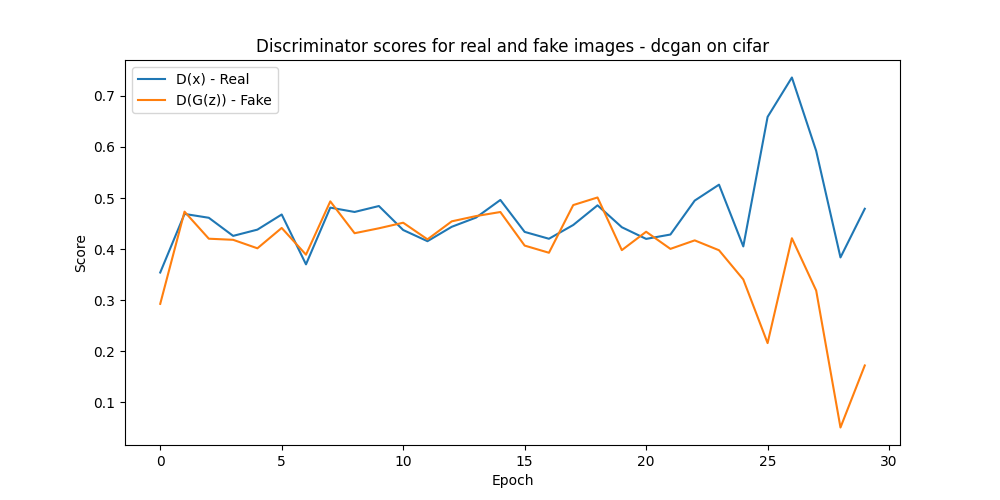|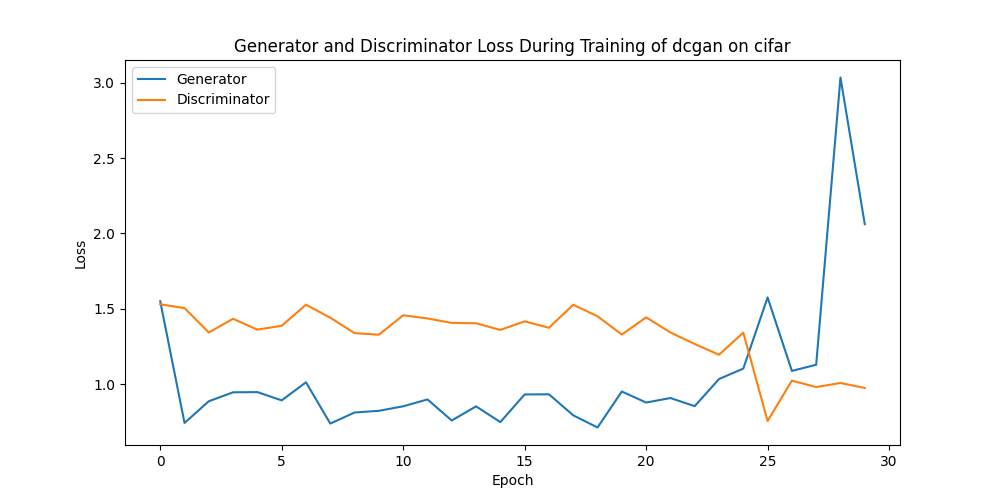|

### Initial Phase (Epochs 0-2)

- **Discriminator Loss**: Started very high (1.6325) and fluctuated significantly in the first epoch (ranging from 1.4717 to 2.2391)
- **Generator Loss**: Began extremely high (7.0369) and rapidly decreased to more stable values around 1.0-3.0 by the end of epoch 0
- **D(x)**: Initially around 0.6673 (epoch 0) and stabilized to approximately 0.45 by epoch 2
- **D(G(z))**: Started high at 0.5265 and fluctuated between 0.35-0.57 during the first epochs

This indicates a period of rapid adjustment where both networks were learning the basic structure of the data distribution. The generator initially produced very poor samples (high loss), but quickly improved.

### Middle Phase (Epochs 3-6)

- **Discriminator Loss**: Stabilized in the range of 1.35-1.50
- **Generator Loss**: Consistently around 0.78-1.01
- **D(x)**: Maintained values between 0.41-0.46
- **D(G(z))**: Settled in the range of 0.42-0.46

This phase shows a more balanced training dynamic where both networks reached a relative equilibrium. The similar values of D(x) and D(G(z)) indicate the discriminator was having difficulty distinguishing between real and fake images, suggesting the generator was producing increasingly convincing samples.

### Later Phase (Epochs 7-9)

- **Discriminator Loss**: Remained stable around 1.40-1.50
- **Generator Loss**: Continued in the 0.83-0.95 range
- **D(x)**: Fluctuated between 0.42-0.50
- **D(G(z))**: Consistently around 0.43-0.49

The stability in these metrics suggests the GAN reached a healthy equilibrium. The discriminator's ability to classify real and fake images remained similar, with D(x) and D(G(z)) values close to each other, indicating the generator was producing convincing images.

## Key Observations

1. **Nash Equilibrium**: By epoch 3, the system approached a Nash equilibrium where D(x) ≈ D(G(z)) ≈ 0.45, indicating a well-balanced adversarial training process.

2. **Training Stability**: Unlike many GAN implementations that suffer from mode collapse or oscillating losses, this DCGAN implementation showed remarkable stability after the initial adjustment period.

3. **Computational Requirements**: Each epoch took approximately 83 seconds, significantly longer than the vanilla GAN on MNIST (which took about 19 seconds per epoch), reflecting the increased complexity of both the dataset and the model architecture.

4. **Alternating Training Strategy**: The implementation used an alternating training approach (training the discriminator only every other batch), which likely contributed to the training stability by preventing the discriminator from becoming too powerful.

5. **Learning Rate Balance**: The discriminator used a lower learning rate (0.0001) than the generator (0.0002), which helped maintain balance between the two networks.

|Trained Image (Final Epoch)|Test Generated Image|
|---------------------------|--------------------|
|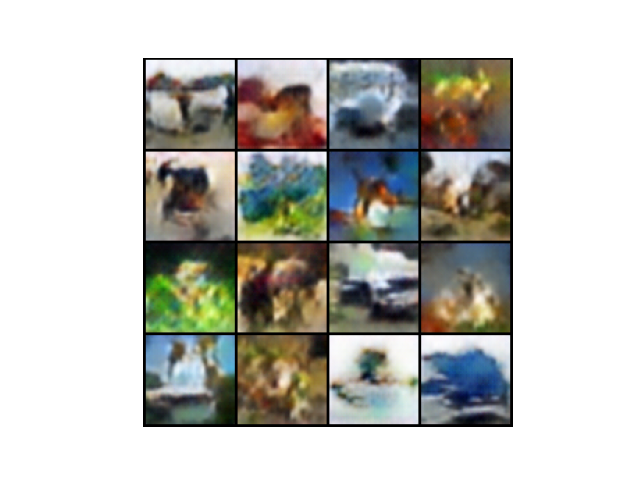|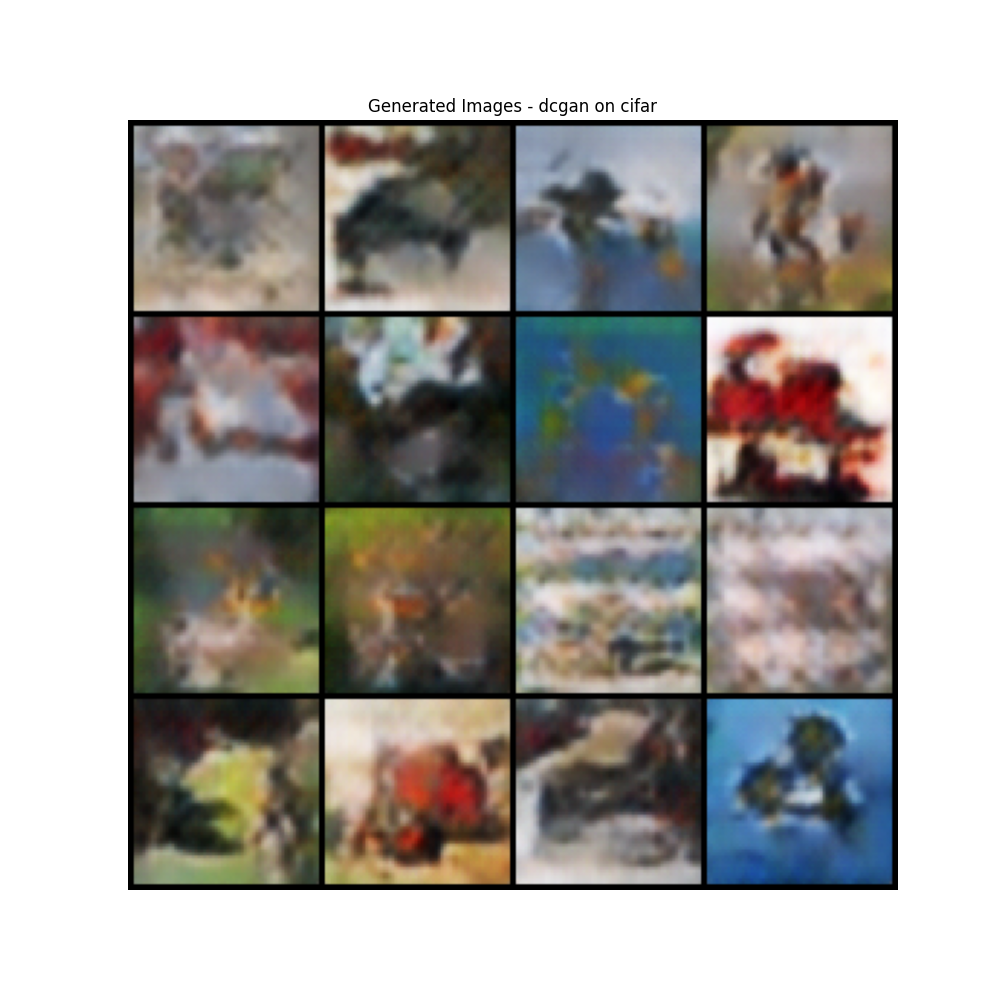|

## Comparison with Vanilla GAN on MNIST

Compared to the vanilla GAN training on MNIST:

1. **Stability**: The DCGAN showed more consistent and stable training metrics from the early epochs, while the vanilla GAN had more pronounced fluctuations throughout training.

2. **Equilibrium Point**: The DCGAN reached an equilibrium where D(x) ≈ D(G(z)) ≈ 0.45, whereas the vanilla GAN settled at D(x) ≈ 0.65 and D(G(z)) ≈ 0.35, suggesting a different balance point.

3. **Convergence Speed**: The DCGAN appeared to reach stable performance metrics faster (by epoch 3) than the vanilla GAN (which took until around epoch 15).

# Task 2: Develop your own GAN to model data generated as follows:✅
$$\begin{eqnarray} \theta & \sim & {\cal U}(0,2\pi) \\
                       r      & \sim & {\cal N}(0, 1) \\
                       \mathbf{x} & \leftarrow & \begin{cases} \begin{bmatrix} (10+r)\cos\theta \\ (10+r)\sin\theta + 10\end{bmatrix} & \frac{1}{2}\pi \le \theta \le \frac{3}{2}\pi \\ \begin{bmatrix} (10+r)\cos\theta \\ (10+r)\sin\theta - 10\end{bmatrix} & \mathrm{otherwise} \end{cases} \end{eqnarray} $$


You should create a PyTorch DataSet that generates the 2D data in the `__init__()` method, outputs a sample in the `__getitem__()` method, and returns the dataset size in the `__len__()` method. Use the vanilla GAN approach above with an appropriate structure for the generator. Can your GAN generate a convincing facsimile of a set of samples from the actual distribution? ✅

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import logging
import os
from tensorboardX import SummaryWriter

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger('CustomGAN')

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Create directories for saving models and results
os.makedirs('models/custom_gan', exist_ok=True)
os.makedirs('results/custom_gan', exist_ok=True)

class CustomDataset(Dataset):
    """
    Dataset that generates 2D data according to the specified distribution:
    θ ~ U(0,2π)
    r ~ N(0,1)
    x = (10+r)cosθ
    y = (10+r)sinθ + 10 if π/2 ≤ θ ≤ 3π/2, otherwise (10+r)sinθ - 10
    """
    def __init__(self, size=10000):
        """Generate the dataset in the initialization"""
        self.size = size
        
        # Generate theta ~ U(0, 2π)
        theta = np.random.uniform(0, 2*np.pi, size)
        
        # Generate r ~ N(0, 1)
        r = np.random.normal(0, 1, size)
        
        # Calculate x coordinates: (10+r)cosθ
        x = (10 + r) * np.cos(theta)
        
        # Calculate y coordinates based on the condition
        y = np.zeros_like(r)
        mask = (theta >= np.pi/2) & (theta <= 3*np.pi/2)
        y[mask] = (10 + r[mask]) * np.sin(theta[mask]) + 10
        y[~mask] = (10 + r[~mask]) * np.sin(theta[~mask]) - 10
        
        # Store as tensor
        self.data = torch.tensor(np.column_stack((x, y)), dtype=torch.float32)
        
        logger.info(f"Generated dataset with {size} samples")
        
    def __len__(self):
        """Return the size of the dataset"""
        return self.size
    
    def __getitem__(self, idx):
        """Return a sample from the dataset"""
        return self.data[idx]
    
    def plot_samples(self, num_samples=1000, save_path=None):
        """Plot samples from the dataset"""
        indices = np.random.choice(len(self), min(num_samples, len(self)), replace=False)
        samples = self.data[indices].numpy()
        
        plt.figure(figsize=(10, 10))
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=10)
        plt.title("Data Distribution")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.axis('equal')
        
        if save_path:
            plt.savefig(save_path)
            logger.info(f"Saved plot to {save_path}")
        
        plt.close()
        return samples

class Generator(nn.Module):
    """
    Generator network for the custom GAN
    Input: Random noise vector of size 100
    Output: 2D data point
    """
    def __init__(self, input_size=100, hidden_size=128):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            # First hidden layer
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Second hidden layer
            nn.Linear(hidden_size, hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Third hidden layer
            nn.Linear(hidden_size*2, hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Output layer
            nn.Linear(hidden_size*2, 2),
            # No activation at the end to allow for unbounded output values
        )
    
    def forward(self, z):
        """Forward pass"""
        return self.model(z)

class Discriminator(nn.Module):
    """
    Discriminator network for the custom GAN
    Input: 2D data point
    Output: Probability that the input is real
    """
    def __init__(self, input_size=2, hidden_size=128):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # First hidden layer
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Second hidden layer
            nn.Linear(hidden_size, hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Third hidden layer
            nn.Linear(hidden_size*2, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Output layer
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        """Forward pass"""
        return self.model(x)

class Logger:
    """
    Logger for the GAN training process
    """
    def __init__(self, model_name='custom_gan'):
        self.model_name = model_name
        self.writer = SummaryWriter(f'logs/{model_name}')
        self.d_losses = []
        self.g_losses = []
        self.d_real_scores = []
        self.d_fake_scores = []
        
    def log(self, d_loss, g_loss, d_real_score, d_fake_score, epoch, n_batch, num_batches):
        """Log losses and scores"""
        step = epoch * num_batches + n_batch
        
        # Log to TensorBoard
        self.writer.add_scalar(f'{self.model_name}/d_loss', d_loss.item(), step)
        self.writer.add_scalar(f'{self.model_name}/g_loss', g_loss.item(), step)
        self.writer.add_scalar(f'{self.model_name}/d_real_score', d_real_score.mean().item(), step)
        self.writer.add_scalar(f'{self.model_name}/d_fake_score', d_fake_score.mean().item(), step)
        
        # Store for plotting
        self.d_losses.append(d_loss.item())
        self.g_losses.append(g_loss.item())
        self.d_real_scores.append(d_real_score.mean().item())
        self.d_fake_scores.append(d_fake_score.mean().item())
    
    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_loss, g_loss, d_real_score, d_fake_score):
        """Display training status"""
        logger.info(f"Epoch: [{epoch}/{num_epochs}], Batch Num: [{n_batch}/{num_batches}]")
        logger.info(f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")
        logger.info(f"D(x): {d_real_score.mean().item():.4f}, D(G(z)): {d_fake_score.mean().item():.4f}")
    
    def save_models(self, generator, discriminator, epoch):
        """Save models"""
        torch.save(generator.state_dict(), f'models/{self.model_name}/generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'models/{self.model_name}/discriminator_epoch_{epoch}.pth')
        logger.info(f"Models saved at epoch {epoch}")
    
    def plot_losses(self):
        """Plot the training losses"""
        plt.figure(figsize=(10, 5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(self.g_losses, label="Generator")
        plt.plot(self.d_losses, label="Discriminator")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f'results/{self.model_name}/loss_plot.png')
        plt.close()
        logger.info(f"Loss plot saved to results/{self.model_name}/loss_plot.png")
    
    def plot_scores(self):
        """Plot the discriminator scores"""
        plt.figure(figsize=(10, 5))
        plt.title("Discriminator Scores During Training")
        plt.plot(self.d_real_scores, label="D(x)")
        plt.plot(self.d_fake_scores, label="D(G(z))")
        plt.xlabel("Iterations")
        plt.ylabel("Score")
        plt.legend()
        plt.savefig(f'results/{self.model_name}/score_plot.png')
        plt.close()
        logger.info(f"Score plot saved to results/{self.model_name}/score_plot.png")
    
    def close(self):
        """Close the TensorBoard writer"""
        self.writer.close()

def noise(batch_size, input_size=100):
    """Generate random noise for the generator"""
    return torch.randn(batch_size, input_size).to(device)

def real_data_target(size):
    """Target for real data"""
    return torch.ones(size, 1).to(device)

def fake_data_target(size):
    """Target for fake data"""
    return torch.zeros(size, 1).to(device)

def train_discriminator(discriminator, optimizer, real_data, fake_data, loss_fn):
    """Train the discriminator"""
    batch_size = real_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Train on real data with label smoothing
    prediction_real = discriminator(real_data)
    real_target = real_data_target(batch_size) * 0.9  # Label smoothing
    error_real = loss_fn(prediction_real, real_target)
    error_real.backward()
    
    # Train on fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss_fn(prediction_fake, fake_data_target(batch_size))
    error_fake.backward()
    
    # Update weights
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(discriminator, optimizer, fake_data, loss_fn):
    """Train the generator"""
    batch_size = fake_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Generate fake data and calculate loss
    prediction = discriminator(fake_data)
    error = loss_fn(prediction, real_data_target(batch_size))
    error.backward()
    
    # Update weights
    optimizer.step()
    
    return error

def train_gan(dataset, num_epochs=200, batch_size=128, save_interval=20, log_interval=10):
    """Train the GAN"""
    logger.info("Starting GAN training on custom dataset...")
    
    # Create data loader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(data_loader)
    
    # Create networks
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    
    # Setup optimizers
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    loss = nn.BCELoss()
    
    # Create logger
    log = Logger()
    
    # Start training
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        for n_batch, real_batch in enumerate(data_loader):
            real_data = real_batch.to(device)
            batch_size = real_data.size(0)
            
            # Train discriminator
            # Only train discriminator every other batch to prevent it from becoming too strong
            if n_batch % 2 == 0:
                fake_data = generator(noise(batch_size)).detach()
                d_loss, d_pred_real, d_pred_fake = train_discriminator(
                    discriminator, d_optimizer, real_data, fake_data, loss
                )
            else:
                with torch.no_grad():
                    d_pred_real = discriminator(real_data)
                    fake_data = generator(noise(batch_size))
                    d_pred_fake = discriminator(fake_data)
                    d_loss = loss(d_pred_real, real_data_target(batch_size) * 0.9) + loss(d_pred_fake, fake_data_target(batch_size))
            
            # Train generator
            fake_data = generator(noise(batch_size))
            g_loss = train_generator(discriminator, g_optimizer, fake_data, loss)
            
            # Log batch error
            log.log(d_loss, g_loss, d_pred_real, d_pred_fake, epoch, n_batch, num_batches)
            
            # Display progress
            if n_batch % log_interval == 0:
                log.display_status(
                    epoch, num_epochs, n_batch, num_batches,
                    d_loss, g_loss, d_pred_real, d_pred_fake
                )
        
        # Save models at specified intervals
        if epoch % save_interval == 0 or epoch == num_epochs - 1:
            log.save_models(generator, discriminator, epoch)
            
        epoch_time = time.time() - epoch_start_time
        logger.info(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")
    
    # Save final models
    log.save_models(generator, discriminator, num_epochs-1)
    
    # Plot training curves
    log.plot_losses()
    log.plot_scores()
    
    # Close logger
    log.close()
    
    total_time = time.time() - start_time
    logger.info(f"GAN training completed in {datetime.timedelta(seconds=total_time)}")
    
    return generator, discriminator

def evaluate_gan(generator, dataset, num_samples=1000):
    """Evaluate the GAN by comparing real and generated samples"""
    # Generate samples
    with torch.no_grad():
        z = noise(num_samples)
        generated_samples = generator(z).cpu().numpy()
    
    # Get real samples
    real_samples = dataset.plot_samples(num_samples, save_path='results/custom_gan/real_samples.png')
    
    # Plot generated samples
    plt.figure(figsize=(10, 10))
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.6, s=10)
    plt.title("Generated Distribution")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.axis('equal')
    plt.savefig('results/custom_gan/generated_samples.png')
    plt.close()
    logger.info("Saved generated samples plot")
    
    # Plot comparison
    plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    plt.scatter(real_samples[:, 0], real_samples[:, 1], alpha=0.6, s=10)
    plt.title("Real Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.axis('equal')
    
    plt.subplot(1, 2, 2)
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.6, s=10)
    plt.title("Generated Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.axis('equal')
    
    plt.tight_layout()
    plt.savefig('results/custom_gan/comparison.png')
    plt.close()
    logger.info("Saved comparison plot")

if __name__ == "__main__":
    # Create dataset
    dataset = CustomDataset(size=10000)
    
    # Plot some samples from the dataset
    dataset.plot_samples(save_path='results/custom_gan/dataset_samples.png')
    
    # Train GAN
    generator, discriminator = train_gan(dataset)
    
    # Evaluate GAN
    evaluate_gan(generator, dataset)
    
    logger.info("Done!")


```bash
2025-03-09 16:06:55,554 - CustomGAN - INFO - Epoch: [158/200], Batch Num: [30/79]
2025-03-09 16:06:55,554 - CustomGAN - INFO - Discriminator Loss: 1.3735, Generator Loss: 0.7994
2025-03-09 16:06:55,555 - CustomGAN - INFO - D(x): 0.4526, D(G(z)): 0.4509
2025-03-09 16:06:55,743 - CustomGAN - INFO - Epoch: [158/200], Batch Num: [40/79]
2025-03-09 16:06:55,743 - CustomGAN - INFO - Discriminator Loss: 1.3784, Generator Loss: 0.8013
2025-03-09 16:06:55,744 - CustomGAN - INFO - D(x): 0.4500, D(G(z)): 0.4509
2025-03-09 16:06:55,932 - CustomGAN - INFO - Epoch: [158/200], Batch Num: [50/79]
2025-03-09 16:06:55,932 - CustomGAN - INFO - Discriminator Loss: 1.3789, Generator Loss: 0.8085
2025-03-09 16:06:55,933 - CustomGAN - INFO - D(x): 0.4454, D(G(z)): 0.4465
2025-03-09 16:06:56,121 - CustomGAN - INFO - Epoch: [158/200], Batch Num: [60/79]
2025-03-09 16:06:56,121 - CustomGAN - INFO - Discriminator Loss: 1.3756, Generator Loss: 0.8049
2025-03-09 16:06:56,121 - CustomGAN - INFO - D(x): 0.4496, D(G(z)): 0.4490
2025-03-09 16:06:56,310 - CustomGAN - INFO - Epoch: [158/200], Batch Num: [70/79]
2025-03-09 16:06:56,310 - CustomGAN - INFO - Discriminator Loss: 1.3757, Generator Loss: 0.7928
2025-03-09 16:06:56,310 - CustomGAN - INFO - D(x): 0.4519, D(G(z)): 0.4513
2025-03-09 16:06:56,461 - CustomGAN - INFO - Epoch 158 completed in 1.50 seconds
2025-03-09 16:06:56,485 - CustomGAN - INFO - Epoch: [159/200], Batch Num: [0/79]
2025-03-09 16:06:56,485 - CustomGAN - INFO - Discriminator Loss: 1.3801, Generator Loss: 0.7963
2025-03-09 16:06:56,486 - CustomGAN - INFO - D(x): 0.4496, D(G(z)): 0.4515
2025-03-09 16:06:56,674 - CustomGAN - INFO - Epoch: [159/200], Batch Num: [10/79]
2025-03-09 16:06:56,674 - CustomGAN - INFO - Discriminator Loss: 1.3782, Generator Loss: 0.8032
2025-03-09 16:06:56,674 - CustomGAN - INFO - D(x): 0.4491, D(G(z)): 0.4500
2025-03-09 16:06:56,862 - CustomGAN - INFO - Epoch: [159/200], Batch Num: [20/79]
2025-03-09 16:06:56,863 - CustomGAN - INFO - Discriminator Loss: 1.3736, Generator Loss: 0.7959
2025-03-09 16:06:56,863 - CustomGAN - INFO - D(x): 0.4524, D(G(z)): 0.4507
2025-03-09 16:06:57,053 - CustomGAN - INFO - Epoch: [159/200], Batch Num: [30/79]
2025-03-09 16:06:57,053 - CustomGAN - INFO - Discriminator Loss: 1.3789, Generator Loss: 0.7920
2025-03-09 16:06:57,053 - CustomGAN - INFO - D(x): 0.4505, D(G(z)): 0.4516
2025-03-09 16:06:57,242 - CustomGAN - INFO - Epoch: [159/200], Batch Num: [40/79]
2025-03-09 16:06:57,242 - CustomGAN - INFO - Discriminator Loss: 1.3762, Generator Loss: 0.7986
2025-03-09 16:06:57,242 - CustomGAN - INFO - D(x): 0.4520, D(G(z)): 0.4517
2025-03-09 16:06:57,430 - CustomGAN - INFO - Epoch: [159/200], Batch Num: [50/79]
2025-03-09 16:06:57,430 - CustomGAN - INFO - Discriminator Loss: 1.3783, Generator Loss: 0.8034
2025-03-09 16:06:57,431 - CustomGAN - INFO - D(x): 0.4496, D(G(z)): 0.4504
2025-03-09 16:06:57,619 - CustomGAN - INFO - Epoch: [159/200], Batch Num: [60/79]
2025-03-09 16:06:57,619 - CustomGAN - INFO - Discriminator Loss: 1.3783, Generator Loss: 0.7997
2025-03-09 16:06:57,620 - CustomGAN - INFO - D(x): 0.4492, D(G(z)): 0.4501
2025-03-09 16:06:57,808 - CustomGAN - INFO - Epoch: [159/200], Batch Num: [70/79]
2025-03-09 16:06:57,808 - CustomGAN - INFO - Discriminator Loss: 1.3728, Generator Loss: 0.7980
2025-03-09 16:06:57,808 - CustomGAN - INFO - D(x): 0.4518, D(G(z)): 0.4496
2025-03-09 16:06:57,960 - CustomGAN - INFO - Epoch 159 completed in 1.50 seconds
2025-03-09 16:06:57,983 - CustomGAN - INFO - Epoch: [160/200], Batch Num: [0/79]
2025-03-09 16:06:57,983 - CustomGAN - INFO - Discriminator Loss: 1.3791, Generator Loss: 0.7958
2025-03-09 16:06:57,984 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4518
2025-03-09 16:06:58,171 - CustomGAN - INFO - Epoch: [160/200], Batch Num: [10/79]
2025-03-09 16:06:58,171 - CustomGAN - INFO - Discriminator Loss: 1.3755, Generator Loss: 0.7998
2025-03-09 16:06:58,172 - CustomGAN - INFO - D(x): 0.4501, D(G(z)): 0.4495
2025-03-09 16:06:58,360 - CustomGAN - INFO - Epoch: [160/200], Batch Num: [20/79]
2025-03-09 16:06:58,361 - CustomGAN - INFO - Discriminator Loss: 1.3808, Generator Loss: 0.8072
2025-03-09 16:06:58,361 - CustomGAN - INFO - D(x): 0.4458, D(G(z)): 0.4480
2025-03-09 16:06:58,549 - CustomGAN - INFO - Epoch: [160/200], Batch Num: [30/79]
2025-03-09 16:06:58,549 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.7992
2025-03-09 16:06:58,550 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4499
2025-03-09 16:06:58,738 - CustomGAN - INFO - Epoch: [160/200], Batch Num: [40/79]
2025-03-09 16:06:58,738 - CustomGAN - INFO - Discriminator Loss: 1.3742, Generator Loss: 0.8007
2025-03-09 16:06:58,738 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4492
2025-03-09 16:06:58,926 - CustomGAN - INFO - Epoch: [160/200], Batch Num: [50/79]
2025-03-09 16:06:58,927 - CustomGAN - INFO - Discriminator Loss: 1.3789, Generator Loss: 0.7928
2025-03-09 16:06:58,927 - CustomGAN - INFO - D(x): 0.4516, D(G(z)): 0.4528
2025-03-09 16:06:59,115 - CustomGAN - INFO - Epoch: [160/200], Batch Num: [60/79]
2025-03-09 16:06:59,115 - CustomGAN - INFO - Discriminator Loss: 1.3788, Generator Loss: 0.7998
2025-03-09 16:06:59,116 - CustomGAN - INFO - D(x): 0.4505, D(G(z)): 0.4517
2025-03-09 16:06:59,302 - CustomGAN - INFO - Epoch: [160/200], Batch Num: [70/79]
2025-03-09 16:06:59,302 - CustomGAN - INFO - Discriminator Loss: 1.3808, Generator Loss: 0.7993
2025-03-09 16:06:59,303 - CustomGAN - INFO - D(x): 0.4469, D(G(z)): 0.4491
2025-03-09 16:06:59,456 - CustomGAN - INFO - Models saved at epoch 160
2025-03-09 16:06:59,456 - CustomGAN - INFO - Epoch 160 completed in 1.50 seconds
2025-03-09 16:06:59,477 - CustomGAN - INFO - Epoch: [161/200], Batch Num: [0/79]
2025-03-09 16:06:59,477 - CustomGAN - INFO - Discriminator Loss: 1.3752, Generator Loss: 0.7999
2025-03-09 16:06:59,477 - CustomGAN - INFO - D(x): 0.4518, D(G(z)): 0.4510
2025-03-09 16:06:59,648 - CustomGAN - INFO - Epoch: [161/200], Batch Num: [10/79]
2025-03-09 16:06:59,649 - CustomGAN - INFO - Discriminator Loss: 1.3786, Generator Loss: 0.7958
2025-03-09 16:06:59,649 - CustomGAN - INFO - D(x): 0.4518, D(G(z)): 0.4528
2025-03-09 16:06:59,820 - CustomGAN - INFO - Epoch: [161/200], Batch Num: [20/79]
2025-03-09 16:06:59,821 - CustomGAN - INFO - Discriminator Loss: 1.3761, Generator Loss: 0.7966
2025-03-09 16:06:59,821 - CustomGAN - INFO - D(x): 0.4523, D(G(z)): 0.4520
2025-03-09 16:06:59,993 - CustomGAN - INFO - Epoch: [161/200], Batch Num: [30/79]
2025-03-09 16:06:59,993 - CustomGAN - INFO - Discriminator Loss: 1.3767, Generator Loss: 0.8033
2025-03-09 16:06:59,993 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4508
2025-03-09 16:07:00,164 - CustomGAN - INFO - Epoch: [161/200], Batch Num: [40/79]
2025-03-09 16:07:00,164 - CustomGAN - INFO - Discriminator Loss: 1.3817, Generator Loss: 0.7997
2025-03-09 16:07:00,165 - CustomGAN - INFO - D(x): 0.4476, D(G(z)): 0.4504
2025-03-09 16:07:00,335 - CustomGAN - INFO - Epoch: [161/200], Batch Num: [50/79]
2025-03-09 16:07:00,335 - CustomGAN - INFO - Discriminator Loss: 1.3812, Generator Loss: 0.7990
2025-03-09 16:07:00,335 - CustomGAN - INFO - D(x): 0.4505, D(G(z)): 0.4529
2025-03-09 16:07:00,506 - CustomGAN - INFO - Epoch: [161/200], Batch Num: [60/79]
2025-03-09 16:07:00,506 - CustomGAN - INFO - Discriminator Loss: 1.3767, Generator Loss: 0.7931
2025-03-09 16:07:00,506 - CustomGAN - INFO - D(x): 0.4528, D(G(z)): 0.4528
2025-03-09 16:07:00,677 - CustomGAN - INFO - Epoch: [161/200], Batch Num: [70/79]
2025-03-09 16:07:00,677 - CustomGAN - INFO - Discriminator Loss: 1.3750, Generator Loss: 0.7999
2025-03-09 16:07:00,677 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4496
2025-03-09 16:07:00,815 - CustomGAN - INFO - Epoch 161 completed in 1.36 seconds
2025-03-09 16:07:00,836 - CustomGAN - INFO - Epoch: [162/200], Batch Num: [0/79]
2025-03-09 16:07:00,836 - CustomGAN - INFO - Discriminator Loss: 1.3718, Generator Loss: 0.7981
2025-03-09 16:07:00,837 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4481
2025-03-09 16:07:01,009 - CustomGAN - INFO - Epoch: [162/200], Batch Num: [10/79]
2025-03-09 16:07:01,009 - CustomGAN - INFO - Discriminator Loss: 1.3750, Generator Loss: 0.8008
2025-03-09 16:07:01,009 - CustomGAN - INFO - D(x): 0.4507, D(G(z)): 0.4497
2025-03-09 16:07:01,179 - CustomGAN - INFO - Epoch: [162/200], Batch Num: [20/79]
2025-03-09 16:07:01,179 - CustomGAN - INFO - Discriminator Loss: 1.3723, Generator Loss: 0.7991
2025-03-09 16:07:01,180 - CustomGAN - INFO - D(x): 0.4494, D(G(z)): 0.4469
2025-03-09 16:07:01,350 - CustomGAN - INFO - Epoch: [162/200], Batch Num: [30/79]
2025-03-09 16:07:01,351 - CustomGAN - INFO - Discriminator Loss: 1.3740, Generator Loss: 0.8043
2025-03-09 16:07:01,351 - CustomGAN - INFO - D(x): 0.4475, D(G(z)): 0.4459
2025-03-09 16:07:01,523 - CustomGAN - INFO - Epoch: [162/200], Batch Num: [40/79]
2025-03-09 16:07:01,523 - CustomGAN - INFO - Discriminator Loss: 1.3781, Generator Loss: 0.7957
2025-03-09 16:07:01,523 - CustomGAN - INFO - D(x): 0.4489, D(G(z)): 0.4497
2025-03-09 16:07:01,695 - CustomGAN - INFO - Epoch: [162/200], Batch Num: [50/79]
2025-03-09 16:07:01,695 - CustomGAN - INFO - Discriminator Loss: 1.3745, Generator Loss: 0.7957
2025-03-09 16:07:01,696 - CustomGAN - INFO - D(x): 0.4527, D(G(z)): 0.4515
2025-03-09 16:07:01,867 - CustomGAN - INFO - Epoch: [162/200], Batch Num: [60/79]
2025-03-09 16:07:01,868 - CustomGAN - INFO - Discriminator Loss: 1.3735, Generator Loss: 0.7887
2025-03-09 16:07:01,868 - CustomGAN - INFO - D(x): 0.4541, D(G(z)): 0.4523
2025-03-09 16:07:02,039 - CustomGAN - INFO - Epoch: [162/200], Batch Num: [70/79]
2025-03-09 16:07:02,040 - CustomGAN - INFO - Discriminator Loss: 1.3753, Generator Loss: 0.7999
2025-03-09 16:07:02,040 - CustomGAN - INFO - D(x): 0.4501, D(G(z)): 0.4493
2025-03-09 16:07:02,177 - CustomGAN - INFO - Epoch 162 completed in 1.36 seconds
2025-03-09 16:07:02,199 - CustomGAN - INFO - Epoch: [163/200], Batch Num: [0/79]
2025-03-09 16:07:02,199 - CustomGAN - INFO - Discriminator Loss: 1.3765, Generator Loss: 0.8055
2025-03-09 16:07:02,199 - CustomGAN - INFO - D(x): 0.4483, D(G(z)): 0.4481
2025-03-09 16:07:02,372 - CustomGAN - INFO - Epoch: [163/200], Batch Num: [10/79]
2025-03-09 16:07:02,372 - CustomGAN - INFO - Discriminator Loss: 1.3786, Generator Loss: 0.8014
2025-03-09 16:07:02,372 - CustomGAN - INFO - D(x): 0.4492, D(G(z)): 0.4502
2025-03-09 16:07:02,544 - CustomGAN - INFO - Epoch: [163/200], Batch Num: [20/79]
2025-03-09 16:07:02,544 - CustomGAN - INFO - Discriminator Loss: 1.3765, Generator Loss: 0.7972
2025-03-09 16:07:02,544 - CustomGAN - INFO - D(x): 0.4489, D(G(z)): 0.4487
2025-03-09 16:07:02,716 - CustomGAN - INFO - Epoch: [163/200], Batch Num: [30/79]
2025-03-09 16:07:02,716 - CustomGAN - INFO - Discriminator Loss: 1.3775, Generator Loss: 0.8006
2025-03-09 16:07:02,717 - CustomGAN - INFO - D(x): 0.4496, D(G(z)): 0.4500
2025-03-09 16:07:02,888 - CustomGAN - INFO - Epoch: [163/200], Batch Num: [40/79]
2025-03-09 16:07:02,888 - CustomGAN - INFO - Discriminator Loss: 1.3745, Generator Loss: 0.7971
2025-03-09 16:07:02,888 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4496
2025-03-09 16:07:03,059 - CustomGAN - INFO - Epoch: [163/200], Batch Num: [50/79]
2025-03-09 16:07:03,059 - CustomGAN - INFO - Discriminator Loss: 1.3776, Generator Loss: 0.8003
2025-03-09 16:07:03,060 - CustomGAN - INFO - D(x): 0.4497, D(G(z)): 0.4502
2025-03-09 16:07:03,230 - CustomGAN - INFO - Epoch: [163/200], Batch Num: [60/79]
2025-03-09 16:07:03,231 - CustomGAN - INFO - Discriminator Loss: 1.3819, Generator Loss: 0.7958
2025-03-09 16:07:03,231 - CustomGAN - INFO - D(x): 0.4483, D(G(z)): 0.4512
2025-03-09 16:07:03,402 - CustomGAN - INFO - Epoch: [163/200], Batch Num: [70/79]
2025-03-09 16:07:03,402 - CustomGAN - INFO - Discriminator Loss: 1.3771, Generator Loss: 0.8007
2025-03-09 16:07:03,402 - CustomGAN - INFO - D(x): 0.4500, D(G(z)): 0.4501
2025-03-09 16:07:03,539 - CustomGAN - INFO - Epoch 163 completed in 1.36 seconds
2025-03-09 16:07:03,561 - CustomGAN - INFO - Epoch: [164/200], Batch Num: [0/79]
2025-03-09 16:07:03,561 - CustomGAN - INFO - Discriminator Loss: 1.3801, Generator Loss: 0.8016
2025-03-09 16:07:03,561 - CustomGAN - INFO - D(x): 0.4472, D(G(z)): 0.4490
2025-03-09 16:07:03,732 - CustomGAN - INFO - Epoch: [164/200], Batch Num: [10/79]
2025-03-09 16:07:03,732 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.7938
2025-03-09 16:07:03,733 - CustomGAN - INFO - D(x): 0.4484, D(G(z)): 0.4490
2025-03-09 16:07:03,904 - CustomGAN - INFO - Epoch: [164/200], Batch Num: [20/79]
2025-03-09 16:07:03,904 - CustomGAN - INFO - Discriminator Loss: 1.3756, Generator Loss: 0.7976
2025-03-09 16:07:03,904 - CustomGAN - INFO - D(x): 0.4516, D(G(z)): 0.4510
2025-03-09 16:07:04,076 - CustomGAN - INFO - Epoch: [164/200], Batch Num: [30/79]
2025-03-09 16:07:04,076 - CustomGAN - INFO - Discriminator Loss: 1.3747, Generator Loss: 0.7942
2025-03-09 16:07:04,076 - CustomGAN - INFO - D(x): 0.4514, D(G(z)): 0.4504
2025-03-09 16:07:04,247 - CustomGAN - INFO - Epoch: [164/200], Batch Num: [40/79]
2025-03-09 16:07:04,247 - CustomGAN - INFO - Discriminator Loss: 1.3810, Generator Loss: 0.8027
2025-03-09 16:07:04,248 - CustomGAN - INFO - D(x): 0.4485, D(G(z)): 0.4509
2025-03-09 16:07:04,418 - CustomGAN - INFO - Epoch: [164/200], Batch Num: [50/79]
2025-03-09 16:07:04,418 - CustomGAN - INFO - Discriminator Loss: 1.3758, Generator Loss: 0.7957
2025-03-09 16:07:04,419 - CustomGAN - INFO - D(x): 0.4499, D(G(z)): 0.4494
2025-03-09 16:07:04,586 - CustomGAN - INFO - Epoch: [164/200], Batch Num: [60/79]
2025-03-09 16:07:04,586 - CustomGAN - INFO - Discriminator Loss: 1.3780, Generator Loss: 0.7934
2025-03-09 16:07:04,587 - CustomGAN - INFO - D(x): 0.4512, D(G(z)): 0.4519
2025-03-09 16:07:04,758 - CustomGAN - INFO - Epoch: [164/200], Batch Num: [70/79]
2025-03-09 16:07:04,758 - CustomGAN - INFO - Discriminator Loss: 1.3768, Generator Loss: 0.7976
2025-03-09 16:07:04,759 - CustomGAN - INFO - D(x): 0.4521, D(G(z)): 0.4522
2025-03-09 16:07:04,896 - CustomGAN - INFO - Epoch 164 completed in 1.36 seconds
2025-03-09 16:07:04,917 - CustomGAN - INFO - Epoch: [165/200], Batch Num: [0/79]
2025-03-09 16:07:04,918 - CustomGAN - INFO - Discriminator Loss: 1.3836, Generator Loss: 0.7969
2025-03-09 16:07:04,918 - CustomGAN - INFO - D(x): 0.4488, D(G(z)): 0.4525
2025-03-09 16:07:05,088 - CustomGAN - INFO - Epoch: [165/200], Batch Num: [10/79]
2025-03-09 16:07:05,089 - CustomGAN - INFO - Discriminator Loss: 1.3749, Generator Loss: 0.7981
2025-03-09 16:07:05,089 - CustomGAN - INFO - D(x): 0.4509, D(G(z)): 0.4499
2025-03-09 16:07:05,260 - CustomGAN - INFO - Epoch: [165/200], Batch Num: [20/79]
2025-03-09 16:07:05,260 - CustomGAN - INFO - Discriminator Loss: 1.3739, Generator Loss: 0.7983
2025-03-09 16:07:05,260 - CustomGAN - INFO - D(x): 0.4513, D(G(z)): 0.4497
2025-03-09 16:07:05,431 - CustomGAN - INFO - Epoch: [165/200], Batch Num: [30/79]
2025-03-09 16:07:05,431 - CustomGAN - INFO - Discriminator Loss: 1.3798, Generator Loss: 0.8011
2025-03-09 16:07:05,431 - CustomGAN - INFO - D(x): 0.4492, D(G(z)): 0.4509
2025-03-09 16:07:05,602 - CustomGAN - INFO - Epoch: [165/200], Batch Num: [40/79]
2025-03-09 16:07:05,602 - CustomGAN - INFO - Discriminator Loss: 1.3794, Generator Loss: 0.8013
2025-03-09 16:07:05,603 - CustomGAN - INFO - D(x): 0.4492, D(G(z)): 0.4507
2025-03-09 16:07:05,773 - CustomGAN - INFO - Epoch: [165/200], Batch Num: [50/79]
2025-03-09 16:07:05,773 - CustomGAN - INFO - Discriminator Loss: 1.3793, Generator Loss: 0.7960
2025-03-09 16:07:05,773 - CustomGAN - INFO - D(x): 0.4499, D(G(z)): 0.4513
2025-03-09 16:07:05,944 - CustomGAN - INFO - Epoch: [165/200], Batch Num: [60/79]
2025-03-09 16:07:05,944 - CustomGAN - INFO - Discriminator Loss: 1.3820, Generator Loss: 0.7967
2025-03-09 16:07:05,944 - CustomGAN - INFO - D(x): 0.4482, D(G(z)): 0.4511
2025-03-09 16:07:06,115 - CustomGAN - INFO - Epoch: [165/200], Batch Num: [70/79]
2025-03-09 16:07:06,115 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.8029
2025-03-09 16:07:06,116 - CustomGAN - INFO - D(x): 0.4491, D(G(z)): 0.4498
2025-03-09 16:07:06,253 - CustomGAN - INFO - Epoch 165 completed in 1.36 seconds
2025-03-09 16:07:06,274 - CustomGAN - INFO - Epoch: [166/200], Batch Num: [0/79]
2025-03-09 16:07:06,274 - CustomGAN - INFO - Discriminator Loss: 1.3769, Generator Loss: 0.7990
2025-03-09 16:07:06,275 - CustomGAN - INFO - D(x): 0.4489, D(G(z)): 0.4490
2025-03-09 16:07:06,445 - CustomGAN - INFO - Epoch: [166/200], Batch Num: [10/79]
2025-03-09 16:07:06,445 - CustomGAN - INFO - Discriminator Loss: 1.3772, Generator Loss: 0.8000
2025-03-09 16:07:06,446 - CustomGAN - INFO - D(x): 0.4505, D(G(z)): 0.4508
2025-03-09 16:07:06,618 - CustomGAN - INFO - Epoch: [166/200], Batch Num: [20/79]
2025-03-09 16:07:06,618 - CustomGAN - INFO - Discriminator Loss: 1.3767, Generator Loss: 0.7957
2025-03-09 16:07:06,618 - CustomGAN - INFO - D(x): 0.4510, D(G(z)): 0.4510
2025-03-09 16:07:06,790 - CustomGAN - INFO - Epoch: [166/200], Batch Num: [30/79]
2025-03-09 16:07:06,790 - CustomGAN - INFO - Discriminator Loss: 1.3744, Generator Loss: 0.7967
2025-03-09 16:07:06,790 - CustomGAN - INFO - D(x): 0.4532, D(G(z)): 0.4519
2025-03-09 16:07:06,961 - CustomGAN - INFO - Epoch: [166/200], Batch Num: [40/79]
2025-03-09 16:07:06,961 - CustomGAN - INFO - Discriminator Loss: 1.3742, Generator Loss: 0.7983
2025-03-09 16:07:06,962 - CustomGAN - INFO - D(x): 0.4524, D(G(z)): 0.4511
2025-03-09 16:07:07,131 - CustomGAN - INFO - Epoch: [166/200], Batch Num: [50/79]
2025-03-09 16:07:07,132 - CustomGAN - INFO - Discriminator Loss: 1.3723, Generator Loss: 0.7919
2025-03-09 16:07:07,132 - CustomGAN - INFO - D(x): 0.4551, D(G(z)): 0.4526
2025-03-09 16:07:07,303 - CustomGAN - INFO - Epoch: [166/200], Batch Num: [60/79]
2025-03-09 16:07:07,303 - CustomGAN - INFO - Discriminator Loss: 1.3766, Generator Loss: 0.7901
2025-03-09 16:07:07,304 - CustomGAN - INFO - D(x): 0.4538, D(G(z)): 0.4537
2025-03-09 16:07:07,475 - CustomGAN - INFO - Epoch: [166/200], Batch Num: [70/79]
2025-03-09 16:07:07,476 - CustomGAN - INFO - Discriminator Loss: 1.3781, Generator Loss: 0.7964
2025-03-09 16:07:07,476 - CustomGAN - INFO - D(x): 0.4505, D(G(z)): 0.4513
2025-03-09 16:07:07,614 - CustomGAN - INFO - Epoch 166 completed in 1.36 seconds
2025-03-09 16:07:07,635 - CustomGAN - INFO - Epoch: [167/200], Batch Num: [0/79]
2025-03-09 16:07:07,635 - CustomGAN - INFO - Discriminator Loss: 1.3772, Generator Loss: 0.8014
2025-03-09 16:07:07,636 - CustomGAN - INFO - D(x): 0.4483, D(G(z)): 0.4486
2025-03-09 16:07:07,807 - CustomGAN - INFO - Epoch: [167/200], Batch Num: [10/79]
2025-03-09 16:07:07,807 - CustomGAN - INFO - Discriminator Loss: 1.3752, Generator Loss: 0.7962
2025-03-09 16:07:07,807 - CustomGAN - INFO - D(x): 0.4517, D(G(z)): 0.4509
2025-03-09 16:07:07,979 - CustomGAN - INFO - Epoch: [167/200], Batch Num: [20/79]
2025-03-09 16:07:07,980 - CustomGAN - INFO - Discriminator Loss: 1.3753, Generator Loss: 0.7972
2025-03-09 16:07:07,980 - CustomGAN - INFO - D(x): 0.4513, D(G(z)): 0.4506
2025-03-09 16:07:08,151 - CustomGAN - INFO - Epoch: [167/200], Batch Num: [30/79]
2025-03-09 16:07:08,151 - CustomGAN - INFO - Discriminator Loss: 1.3783, Generator Loss: 0.7995
2025-03-09 16:07:08,151 - CustomGAN - INFO - D(x): 0.4474, D(G(z)): 0.4483
2025-03-09 16:07:08,323 - CustomGAN - INFO - Epoch: [167/200], Batch Num: [40/79]
2025-03-09 16:07:08,323 - CustomGAN - INFO - Discriminator Loss: 1.3825, Generator Loss: 0.7990
2025-03-09 16:07:08,323 - CustomGAN - INFO - D(x): 0.4472, D(G(z)): 0.4504
2025-03-09 16:07:08,495 - CustomGAN - INFO - Epoch: [167/200], Batch Num: [50/79]
2025-03-09 16:07:08,495 - CustomGAN - INFO - Discriminator Loss: 1.3775, Generator Loss: 0.7942
2025-03-09 16:07:08,495 - CustomGAN - INFO - D(x): 0.4517, D(G(z)): 0.4521
2025-03-09 16:07:08,667 - CustomGAN - INFO - Epoch: [167/200], Batch Num: [60/79]
2025-03-09 16:07:08,667 - CustomGAN - INFO - Discriminator Loss: 1.3738, Generator Loss: 0.8022
2025-03-09 16:07:08,667 - CustomGAN - INFO - D(x): 0.4500, D(G(z)): 0.4484
2025-03-09 16:07:08,838 - CustomGAN - INFO - Epoch: [167/200], Batch Num: [70/79]
2025-03-09 16:07:08,839 - CustomGAN - INFO - Discriminator Loss: 1.3790, Generator Loss: 0.7996
2025-03-09 16:07:08,839 - CustomGAN - INFO - D(x): 0.4503, D(G(z)): 0.4515
2025-03-09 16:07:08,976 - CustomGAN - INFO - Epoch 167 completed in 1.36 seconds
2025-03-09 16:07:08,997 - CustomGAN - INFO - Epoch: [168/200], Batch Num: [0/79]
2025-03-09 16:07:08,998 - CustomGAN - INFO - Discriminator Loss: 1.3765, Generator Loss: 0.7942
2025-03-09 16:07:08,998 - CustomGAN - INFO - D(x): 0.4529, D(G(z)): 0.4528
2025-03-09 16:07:09,166 - CustomGAN - INFO - Epoch: [168/200], Batch Num: [10/79]
2025-03-09 16:07:09,166 - CustomGAN - INFO - Discriminator Loss: 1.3805, Generator Loss: 0.7965
2025-03-09 16:07:09,166 - CustomGAN - INFO - D(x): 0.4513, D(G(z)): 0.4534
2025-03-09 16:07:09,336 - CustomGAN - INFO - Epoch: [168/200], Batch Num: [20/79]
2025-03-09 16:07:09,336 - CustomGAN - INFO - Discriminator Loss: 1.3785, Generator Loss: 0.7984
2025-03-09 16:07:09,336 - CustomGAN - INFO - D(x): 0.4495, D(G(z)): 0.4505
2025-03-09 16:07:09,508 - CustomGAN - INFO - Epoch: [168/200], Batch Num: [30/79]
2025-03-09 16:07:09,508 - CustomGAN - INFO - Discriminator Loss: 1.3762, Generator Loss: 0.7953
2025-03-09 16:07:09,508 - CustomGAN - INFO - D(x): 0.4514, D(G(z)): 0.4512
2025-03-09 16:07:09,678 - CustomGAN - INFO - Epoch: [168/200], Batch Num: [40/79]
2025-03-09 16:07:09,678 - CustomGAN - INFO - Discriminator Loss: 1.3774, Generator Loss: 0.7949
2025-03-09 16:07:09,678 - CustomGAN - INFO - D(x): 0.4521, D(G(z)): 0.4525
2025-03-09 16:07:09,848 - CustomGAN - INFO - Epoch: [168/200], Batch Num: [50/79]
2025-03-09 16:07:09,848 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.8027
2025-03-09 16:07:09,849 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4499
2025-03-09 16:07:10,020 - CustomGAN - INFO - Epoch: [168/200], Batch Num: [60/79]
2025-03-09 16:07:10,020 - CustomGAN - INFO - Discriminator Loss: 1.3762, Generator Loss: 0.8012
2025-03-09 16:07:10,021 - CustomGAN - INFO - D(x): 0.4477, D(G(z)): 0.4475
2025-03-09 16:07:10,193 - CustomGAN - INFO - Epoch: [168/200], Batch Num: [70/79]
2025-03-09 16:07:10,193 - CustomGAN - INFO - Discriminator Loss: 1.3789, Generator Loss: 0.7989
2025-03-09 16:07:10,193 - CustomGAN - INFO - D(x): 0.4489, D(G(z)): 0.4502
2025-03-09 16:07:10,331 - CustomGAN - INFO - Epoch 168 completed in 1.35 seconds
2025-03-09 16:07:10,352 - CustomGAN - INFO - Epoch: [169/200], Batch Num: [0/79]
2025-03-09 16:07:10,353 - CustomGAN - INFO - Discriminator Loss: 1.3736, Generator Loss: 0.8000
2025-03-09 16:07:10,353 - CustomGAN - INFO - D(x): 0.4518, D(G(z)): 0.4502
2025-03-09 16:07:10,525 - CustomGAN - INFO - Epoch: [169/200], Batch Num: [10/79]
2025-03-09 16:07:10,525 - CustomGAN - INFO - Discriminator Loss: 1.3807, Generator Loss: 0.7974
2025-03-09 16:07:10,526 - CustomGAN - INFO - D(x): 0.4478, D(G(z)): 0.4500
2025-03-09 16:07:10,697 - CustomGAN - INFO - Epoch: [169/200], Batch Num: [20/79]
2025-03-09 16:07:10,697 - CustomGAN - INFO - Discriminator Loss: 1.3771, Generator Loss: 0.8004
2025-03-09 16:07:10,697 - CustomGAN - INFO - D(x): 0.4486, D(G(z)): 0.4489
2025-03-09 16:07:10,868 - CustomGAN - INFO - Epoch: [169/200], Batch Num: [30/79]
2025-03-09 16:07:10,868 - CustomGAN - INFO - Discriminator Loss: 1.3799, Generator Loss: 0.7989
2025-03-09 16:07:10,868 - CustomGAN - INFO - D(x): 0.4495, D(G(z)): 0.4513
2025-03-09 16:07:11,039 - CustomGAN - INFO - Epoch: [169/200], Batch Num: [40/79]
2025-03-09 16:07:11,039 - CustomGAN - INFO - Discriminator Loss: 1.3767, Generator Loss: 0.7941
2025-03-09 16:07:11,040 - CustomGAN - INFO - D(x): 0.4513, D(G(z)): 0.4513
2025-03-09 16:07:11,211 - CustomGAN - INFO - Epoch: [169/200], Batch Num: [50/79]
2025-03-09 16:07:11,211 - CustomGAN - INFO - Discriminator Loss: 1.3750, Generator Loss: 0.7920
2025-03-09 16:07:11,211 - CustomGAN - INFO - D(x): 0.4513, D(G(z)): 0.4504
2025-03-09 16:07:11,382 - CustomGAN - INFO - Epoch: [169/200], Batch Num: [60/79]
2025-03-09 16:07:11,382 - CustomGAN - INFO - Discriminator Loss: 1.3741, Generator Loss: 0.7906
2025-03-09 16:07:11,383 - CustomGAN - INFO - D(x): 0.4540, D(G(z)): 0.4526
2025-03-09 16:07:11,554 - CustomGAN - INFO - Epoch: [169/200], Batch Num: [70/79]
2025-03-09 16:07:11,554 - CustomGAN - INFO - Discriminator Loss: 1.3745, Generator Loss: 0.7919
2025-03-09 16:07:11,554 - CustomGAN - INFO - D(x): 0.4536, D(G(z)): 0.4525
2025-03-09 16:07:11,691 - CustomGAN - INFO - Epoch 169 completed in 1.36 seconds
2025-03-09 16:07:11,712 - CustomGAN - INFO - Epoch: [170/200], Batch Num: [0/79]
2025-03-09 16:07:11,712 - CustomGAN - INFO - Discriminator Loss: 1.3753, Generator Loss: 0.7889
2025-03-09 16:07:11,713 - CustomGAN - INFO - D(x): 0.4539, D(G(z)): 0.4532
2025-03-09 16:07:11,885 - CustomGAN - INFO - Epoch: [170/200], Batch Num: [10/79]
2025-03-09 16:07:11,885 - CustomGAN - INFO - Discriminator Loss: 1.3733, Generator Loss: 0.7952
2025-03-09 16:07:11,885 - CustomGAN - INFO - D(x): 0.4534, D(G(z)): 0.4515
2025-03-09 16:07:12,057 - CustomGAN - INFO - Epoch: [170/200], Batch Num: [20/79]
2025-03-09 16:07:12,057 - CustomGAN - INFO - Discriminator Loss: 1.3828, Generator Loss: 0.8012
2025-03-09 16:07:12,058 - CustomGAN - INFO - D(x): 0.4481, D(G(z)): 0.4515
2025-03-09 16:07:12,229 - CustomGAN - INFO - Epoch: [170/200], Batch Num: [30/79]
2025-03-09 16:07:12,230 - CustomGAN - INFO - Discriminator Loss: 1.3777, Generator Loss: 0.7963
2025-03-09 16:07:12,230 - CustomGAN - INFO - D(x): 0.4510, D(G(z)): 0.4516
2025-03-09 16:07:12,401 - CustomGAN - INFO - Epoch: [170/200], Batch Num: [40/79]
2025-03-09 16:07:12,401 - CustomGAN - INFO - Discriminator Loss: 1.3763, Generator Loss: 0.7966
2025-03-09 16:07:12,402 - CustomGAN - INFO - D(x): 0.4514, D(G(z)): 0.4511
2025-03-09 16:07:12,575 - CustomGAN - INFO - Epoch: [170/200], Batch Num: [50/79]
2025-03-09 16:07:12,575 - CustomGAN - INFO - Discriminator Loss: 1.3763, Generator Loss: 0.8012
2025-03-09 16:07:12,576 - CustomGAN - INFO - D(x): 0.4487, D(G(z)): 0.4485
2025-03-09 16:07:12,746 - CustomGAN - INFO - Epoch: [170/200], Batch Num: [60/79]
2025-03-09 16:07:12,746 - CustomGAN - INFO - Discriminator Loss: 1.3728, Generator Loss: 0.7995
2025-03-09 16:07:12,747 - CustomGAN - INFO - D(x): 0.4515, D(G(z)): 0.4494
2025-03-09 16:07:12,918 - CustomGAN - INFO - Epoch: [170/200], Batch Num: [70/79]
2025-03-09 16:07:12,918 - CustomGAN - INFO - Discriminator Loss: 1.3746, Generator Loss: 0.7952
2025-03-09 16:07:12,918 - CustomGAN - INFO - D(x): 0.4532, D(G(z)): 0.4520
2025-03-09 16:07:13,055 - CustomGAN - INFO - Epoch 170 completed in 1.36 seconds
2025-03-09 16:07:13,077 - CustomGAN - INFO - Epoch: [171/200], Batch Num: [0/79]
2025-03-09 16:07:13,077 - CustomGAN - INFO - Discriminator Loss: 1.3802, Generator Loss: 0.8027
2025-03-09 16:07:13,077 - CustomGAN - INFO - D(x): 0.4466, D(G(z)): 0.4485
2025-03-09 16:07:13,248 - CustomGAN - INFO - Epoch: [171/200], Batch Num: [10/79]
2025-03-09 16:07:13,249 - CustomGAN - INFO - Discriminator Loss: 1.3777, Generator Loss: 0.7994
2025-03-09 16:07:13,249 - CustomGAN - INFO - D(x): 0.4494, D(G(z)): 0.4500
2025-03-09 16:07:13,421 - CustomGAN - INFO - Epoch: [171/200], Batch Num: [20/79]
2025-03-09 16:07:13,421 - CustomGAN - INFO - Discriminator Loss: 1.3754, Generator Loss: 0.7932
2025-03-09 16:07:13,421 - CustomGAN - INFO - D(x): 0.4524, D(G(z)): 0.4517
2025-03-09 16:07:13,593 - CustomGAN - INFO - Epoch: [171/200], Batch Num: [30/79]
2025-03-09 16:07:13,593 - CustomGAN - INFO - Discriminator Loss: 1.3744, Generator Loss: 0.7956
2025-03-09 16:07:13,593 - CustomGAN - INFO - D(x): 0.4518, D(G(z)): 0.4506
2025-03-09 16:07:13,765 - CustomGAN - INFO - Epoch: [171/200], Batch Num: [40/79]
2025-03-09 16:07:13,765 - CustomGAN - INFO - Discriminator Loss: 1.3760, Generator Loss: 0.7942
2025-03-09 16:07:13,765 - CustomGAN - INFO - D(x): 0.4533, D(G(z)): 0.4530
2025-03-09 16:07:13,937 - CustomGAN - INFO - Epoch: [171/200], Batch Num: [50/79]
2025-03-09 16:07:13,937 - CustomGAN - INFO - Discriminator Loss: 1.3758, Generator Loss: 0.7900
2025-03-09 16:07:13,937 - CustomGAN - INFO - D(x): 0.4551, D(G(z)): 0.4546
2025-03-09 16:07:14,109 - CustomGAN - INFO - Epoch: [171/200], Batch Num: [60/79]
2025-03-09 16:07:14,109 - CustomGAN - INFO - Discriminator Loss: 1.3738, Generator Loss: 0.7964
2025-03-09 16:07:14,110 - CustomGAN - INFO - D(x): 0.4528, D(G(z)): 0.4512
2025-03-09 16:07:14,282 - CustomGAN - INFO - Epoch: [171/200], Batch Num: [70/79]
2025-03-09 16:07:14,282 - CustomGAN - INFO - Discriminator Loss: 1.3791, Generator Loss: 0.8015
2025-03-09 16:07:14,282 - CustomGAN - INFO - D(x): 0.4509, D(G(z)): 0.4523
2025-03-09 16:07:14,419 - CustomGAN - INFO - Epoch 171 completed in 1.36 seconds
2025-03-09 16:07:14,439 - CustomGAN - INFO - Epoch: [172/200], Batch Num: [0/79]
2025-03-09 16:07:14,440 - CustomGAN - INFO - Discriminator Loss: 1.3743, Generator Loss: 0.7973
2025-03-09 16:07:14,440 - CustomGAN - INFO - D(x): 0.4513, D(G(z)): 0.4500
2025-03-09 16:07:14,610 - CustomGAN - INFO - Epoch: [172/200], Batch Num: [10/79]
2025-03-09 16:07:14,610 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.8041
2025-03-09 16:07:14,611 - CustomGAN - INFO - D(x): 0.4487, D(G(z)): 0.4494
2025-03-09 16:07:14,780 - CustomGAN - INFO - Epoch: [172/200], Batch Num: [20/79]
2025-03-09 16:07:14,780 - CustomGAN - INFO - Discriminator Loss: 1.3815, Generator Loss: 0.8067
2025-03-09 16:07:14,780 - CustomGAN - INFO - D(x): 0.4450, D(G(z)): 0.4476
2025-03-09 16:07:14,951 - CustomGAN - INFO - Epoch: [172/200], Batch Num: [30/79]
2025-03-09 16:07:14,951 - CustomGAN - INFO - Discriminator Loss: 1.3795, Generator Loss: 0.8020
2025-03-09 16:07:14,951 - CustomGAN - INFO - D(x): 0.4478, D(G(z)): 0.4495
2025-03-09 16:07:15,123 - CustomGAN - INFO - Epoch: [172/200], Batch Num: [40/79]
2025-03-09 16:07:15,124 - CustomGAN - INFO - Discriminator Loss: 1.3737, Generator Loss: 0.7937
2025-03-09 16:07:15,124 - CustomGAN - INFO - D(x): 0.4546, D(G(z)): 0.4530
2025-03-09 16:07:15,296 - CustomGAN - INFO - Epoch: [172/200], Batch Num: [50/79]
2025-03-09 16:07:15,296 - CustomGAN - INFO - Discriminator Loss: 1.3747, Generator Loss: 0.7948
2025-03-09 16:07:15,297 - CustomGAN - INFO - D(x): 0.4534, D(G(z)): 0.4523
2025-03-09 16:07:15,468 - CustomGAN - INFO - Epoch: [172/200], Batch Num: [60/79]
2025-03-09 16:07:15,468 - CustomGAN - INFO - Discriminator Loss: 1.3748, Generator Loss: 0.7958
2025-03-09 16:07:15,469 - CustomGAN - INFO - D(x): 0.4507, D(G(z)): 0.4497
2025-03-09 16:07:15,640 - CustomGAN - INFO - Epoch: [172/200], Batch Num: [70/79]
2025-03-09 16:07:15,640 - CustomGAN - INFO - Discriminator Loss: 1.3792, Generator Loss: 0.7922
2025-03-09 16:07:15,640 - CustomGAN - INFO - D(x): 0.4519, D(G(z)): 0.4533
2025-03-09 16:07:15,777 - CustomGAN - INFO - Epoch 172 completed in 1.36 seconds
2025-03-09 16:07:15,798 - CustomGAN - INFO - Epoch: [173/200], Batch Num: [0/79]
2025-03-09 16:07:15,799 - CustomGAN - INFO - Discriminator Loss: 1.3738, Generator Loss: 0.7938
2025-03-09 16:07:15,799 - CustomGAN - INFO - D(x): 0.4520, D(G(z)): 0.4505
2025-03-09 16:07:15,970 - CustomGAN - INFO - Epoch: [173/200], Batch Num: [10/79]
2025-03-09 16:07:15,970 - CustomGAN - INFO - Discriminator Loss: 1.3770, Generator Loss: 0.7995
2025-03-09 16:07:15,970 - CustomGAN - INFO - D(x): 0.4511, D(G(z)): 0.4513
2025-03-09 16:07:16,142 - CustomGAN - INFO - Epoch: [173/200], Batch Num: [20/79]
2025-03-09 16:07:16,142 - CustomGAN - INFO - Discriminator Loss: 1.3792, Generator Loss: 0.8034
2025-03-09 16:07:16,142 - CustomGAN - INFO - D(x): 0.4492, D(G(z)): 0.4506
2025-03-09 16:07:16,314 - CustomGAN - INFO - Epoch: [173/200], Batch Num: [30/79]
2025-03-09 16:07:16,314 - CustomGAN - INFO - Discriminator Loss: 1.3786, Generator Loss: 0.8023
2025-03-09 16:07:16,315 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4509
2025-03-09 16:07:16,486 - CustomGAN - INFO - Epoch: [173/200], Batch Num: [40/79]
2025-03-09 16:07:16,486 - CustomGAN - INFO - Discriminator Loss: 1.3758, Generator Loss: 0.7938
2025-03-09 16:07:16,486 - CustomGAN - INFO - D(x): 0.4514, D(G(z)): 0.4510
2025-03-09 16:07:16,659 - CustomGAN - INFO - Epoch: [173/200], Batch Num: [50/79]
2025-03-09 16:07:16,659 - CustomGAN - INFO - Discriminator Loss: 1.3762, Generator Loss: 0.7930
2025-03-09 16:07:16,660 - CustomGAN - INFO - D(x): 0.4523, D(G(z)): 0.4521
2025-03-09 16:07:16,831 - CustomGAN - INFO - Epoch: [173/200], Batch Num: [60/79]
2025-03-09 16:07:16,832 - CustomGAN - INFO - Discriminator Loss: 1.3751, Generator Loss: 0.7986
2025-03-09 16:07:16,832 - CustomGAN - INFO - D(x): 0.4507, D(G(z)): 0.4499
2025-03-09 16:07:17,004 - CustomGAN - INFO - Epoch: [173/200], Batch Num: [70/79]
2025-03-09 16:07:17,004 - CustomGAN - INFO - Discriminator Loss: 1.3770, Generator Loss: 0.7999
2025-03-09 16:07:17,005 - CustomGAN - INFO - D(x): 0.4483, D(G(z)): 0.4486
2025-03-09 16:07:17,142 - CustomGAN - INFO - Epoch 173 completed in 1.36 seconds
2025-03-09 16:07:17,164 - CustomGAN - INFO - Epoch: [174/200], Batch Num: [0/79]
2025-03-09 16:07:17,164 - CustomGAN - INFO - Discriminator Loss: 1.3780, Generator Loss: 0.8017
2025-03-09 16:07:17,164 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4501
2025-03-09 16:07:17,336 - CustomGAN - INFO - Epoch: [174/200], Batch Num: [10/79]
2025-03-09 16:07:17,336 - CustomGAN - INFO - Discriminator Loss: 1.3743, Generator Loss: 0.7962
2025-03-09 16:07:17,336 - CustomGAN - INFO - D(x): 0.4513, D(G(z)): 0.4500
2025-03-09 16:07:17,507 - CustomGAN - INFO - Epoch: [174/200], Batch Num: [20/79]
2025-03-09 16:07:17,507 - CustomGAN - INFO - Discriminator Loss: 1.3809, Generator Loss: 0.7960
2025-03-09 16:07:17,508 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4516
2025-03-09 16:07:17,678 - CustomGAN - INFO - Epoch: [174/200], Batch Num: [30/79]
2025-03-09 16:07:17,679 - CustomGAN - INFO - Discriminator Loss: 1.3771, Generator Loss: 0.7924
2025-03-09 16:07:17,679 - CustomGAN - INFO - D(x): 0.4530, D(G(z)): 0.4532
2025-03-09 16:07:17,850 - CustomGAN - INFO - Epoch: [174/200], Batch Num: [40/79]
2025-03-09 16:07:17,851 - CustomGAN - INFO - Discriminator Loss: 1.3780, Generator Loss: 0.7942
2025-03-09 16:07:17,851 - CustomGAN - INFO - D(x): 0.4522, D(G(z)): 0.4529
2025-03-09 16:07:18,023 - CustomGAN - INFO - Epoch: [174/200], Batch Num: [50/79]
2025-03-09 16:07:18,023 - CustomGAN - INFO - Discriminator Loss: 1.3789, Generator Loss: 0.8017
2025-03-09 16:07:18,023 - CustomGAN - INFO - D(x): 0.4510, D(G(z)): 0.4523
2025-03-09 16:07:18,195 - CustomGAN - INFO - Epoch: [174/200], Batch Num: [60/79]
2025-03-09 16:07:18,195 - CustomGAN - INFO - Discriminator Loss: 1.3758, Generator Loss: 0.8004
2025-03-09 16:07:18,195 - CustomGAN - INFO - D(x): 0.4499, D(G(z)): 0.4495
2025-03-09 16:07:18,367 - CustomGAN - INFO - Epoch: [174/200], Batch Num: [70/79]
2025-03-09 16:07:18,367 - CustomGAN - INFO - Discriminator Loss: 1.3754, Generator Loss: 0.7958
2025-03-09 16:07:18,368 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4500
2025-03-09 16:07:18,505 - CustomGAN - INFO - Epoch 174 completed in 1.36 seconds
2025-03-09 16:07:18,526 - CustomGAN - INFO - Epoch: [175/200], Batch Num: [0/79]
2025-03-09 16:07:18,526 - CustomGAN - INFO - Discriminator Loss: 1.3770, Generator Loss: 0.7962
2025-03-09 16:07:18,527 - CustomGAN - INFO - D(x): 0.4495, D(G(z)): 0.4497
2025-03-09 16:07:18,699 - CustomGAN - INFO - Epoch: [175/200], Batch Num: [10/79]
2025-03-09 16:07:18,699 - CustomGAN - INFO - Discriminator Loss: 1.3760, Generator Loss: 0.8053
2025-03-09 16:07:18,700 - CustomGAN - INFO - D(x): 0.4478, D(G(z)): 0.4474
2025-03-09 16:07:18,871 - CustomGAN - INFO - Epoch: [175/200], Batch Num: [20/79]
2025-03-09 16:07:18,871 - CustomGAN - INFO - Discriminator Loss: 1.3793, Generator Loss: 0.7987
2025-03-09 16:07:18,872 - CustomGAN - INFO - D(x): 0.4474, D(G(z)): 0.4489
2025-03-09 16:07:19,043 - CustomGAN - INFO - Epoch: [175/200], Batch Num: [30/79]
2025-03-09 16:07:19,043 - CustomGAN - INFO - Discriminator Loss: 1.3745, Generator Loss: 0.7988
2025-03-09 16:07:19,043 - CustomGAN - INFO - D(x): 0.4524, D(G(z)): 0.4512
2025-03-09 16:07:19,215 - CustomGAN - INFO - Epoch: [175/200], Batch Num: [40/79]
2025-03-09 16:07:19,215 - CustomGAN - INFO - Discriminator Loss: 1.3763, Generator Loss: 0.7995
2025-03-09 16:07:19,215 - CustomGAN - INFO - D(x): 0.4499, D(G(z)): 0.4497
2025-03-09 16:07:19,386 - CustomGAN - INFO - Epoch: [175/200], Batch Num: [50/79]
2025-03-09 16:07:19,386 - CustomGAN - INFO - Discriminator Loss: 1.3761, Generator Loss: 0.8020
2025-03-09 16:07:19,386 - CustomGAN - INFO - D(x): 0.4486, D(G(z)): 0.4483
2025-03-09 16:07:19,553 - CustomGAN - INFO - Epoch: [175/200], Batch Num: [60/79]
2025-03-09 16:07:19,554 - CustomGAN - INFO - Discriminator Loss: 1.3746, Generator Loss: 0.7963
2025-03-09 16:07:19,554 - CustomGAN - INFO - D(x): 0.4515, D(G(z)): 0.4504
2025-03-09 16:07:19,725 - CustomGAN - INFO - Epoch: [175/200], Batch Num: [70/79]
2025-03-09 16:07:19,725 - CustomGAN - INFO - Discriminator Loss: 1.3767, Generator Loss: 0.7917
2025-03-09 16:07:19,725 - CustomGAN - INFO - D(x): 0.4521, D(G(z)): 0.4522
2025-03-09 16:07:19,861 - CustomGAN - INFO - Epoch 175 completed in 1.36 seconds
2025-03-09 16:07:19,882 - CustomGAN - INFO - Epoch: [176/200], Batch Num: [0/79]
2025-03-09 16:07:19,882 - CustomGAN - INFO - Discriminator Loss: 1.3759, Generator Loss: 0.7970
2025-03-09 16:07:19,883 - CustomGAN - INFO - D(x): 0.4503, D(G(z)): 0.4499
2025-03-09 16:07:20,055 - CustomGAN - INFO - Epoch: [176/200], Batch Num: [10/79]
2025-03-09 16:07:20,055 - CustomGAN - INFO - Discriminator Loss: 1.3744, Generator Loss: 0.7980
2025-03-09 16:07:20,055 - CustomGAN - INFO - D(x): 0.4518, D(G(z)): 0.4506
2025-03-09 16:07:20,226 - CustomGAN - INFO - Epoch: [176/200], Batch Num: [20/79]
2025-03-09 16:07:20,227 - CustomGAN - INFO - Discriminator Loss: 1.3775, Generator Loss: 0.7946
2025-03-09 16:07:20,227 - CustomGAN - INFO - D(x): 0.4512, D(G(z)): 0.4517
2025-03-09 16:07:20,398 - CustomGAN - INFO - Epoch: [176/200], Batch Num: [30/79]
2025-03-09 16:07:20,398 - CustomGAN - INFO - Discriminator Loss: 1.3759, Generator Loss: 0.7979
2025-03-09 16:07:20,398 - CustomGAN - INFO - D(x): 0.4519, D(G(z)): 0.4515
2025-03-09 16:07:20,569 - CustomGAN - INFO - Epoch: [176/200], Batch Num: [40/79]
2025-03-09 16:07:20,569 - CustomGAN - INFO - Discriminator Loss: 1.3718, Generator Loss: 0.7982
2025-03-09 16:07:20,570 - CustomGAN - INFO - D(x): 0.4518, D(G(z)): 0.4492
2025-03-09 16:07:20,741 - CustomGAN - INFO - Epoch: [176/200], Batch Num: [50/79]
2025-03-09 16:07:20,741 - CustomGAN - INFO - Discriminator Loss: 1.3738, Generator Loss: 0.7977
2025-03-09 16:07:20,742 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4483
2025-03-09 16:07:20,913 - CustomGAN - INFO - Epoch: [176/200], Batch Num: [60/79]
2025-03-09 16:07:20,913 - CustomGAN - INFO - Discriminator Loss: 1.3733, Generator Loss: 0.8015
2025-03-09 16:07:20,913 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4487
2025-03-09 16:07:21,085 - CustomGAN - INFO - Epoch: [176/200], Batch Num: [70/79]
2025-03-09 16:07:21,086 - CustomGAN - INFO - Discriminator Loss: 1.3786, Generator Loss: 0.7988
2025-03-09 16:07:21,086 - CustomGAN - INFO - D(x): 0.4490, D(G(z)): 0.4501
2025-03-09 16:07:21,223 - CustomGAN - INFO - Epoch 176 completed in 1.36 seconds
2025-03-09 16:07:21,245 - CustomGAN - INFO - Epoch: [177/200], Batch Num: [0/79]
2025-03-09 16:07:21,245 - CustomGAN - INFO - Discriminator Loss: 1.3775, Generator Loss: 0.7972
2025-03-09 16:07:21,245 - CustomGAN - INFO - D(x): 0.4509, D(G(z)): 0.4514
2025-03-09 16:07:21,416 - CustomGAN - INFO - Epoch: [177/200], Batch Num: [10/79]
2025-03-09 16:07:21,416 - CustomGAN - INFO - Discriminator Loss: 1.3739, Generator Loss: 0.7953
2025-03-09 16:07:21,416 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4489
2025-03-09 16:07:21,587 - CustomGAN - INFO - Epoch: [177/200], Batch Num: [20/79]
2025-03-09 16:07:21,587 - CustomGAN - INFO - Discriminator Loss: 1.3738, Generator Loss: 0.7991
2025-03-09 16:07:21,587 - CustomGAN - INFO - D(x): 0.4512, D(G(z)): 0.4496
2025-03-09 16:07:21,758 - CustomGAN - INFO - Epoch: [177/200], Batch Num: [30/79]
2025-03-09 16:07:21,758 - CustomGAN - INFO - Discriminator Loss: 1.3760, Generator Loss: 0.7949
2025-03-09 16:07:21,759 - CustomGAN - INFO - D(x): 0.4510, D(G(z)): 0.4507
2025-03-09 16:07:21,930 - CustomGAN - INFO - Epoch: [177/200], Batch Num: [40/79]
2025-03-09 16:07:21,930 - CustomGAN - INFO - Discriminator Loss: 1.3782, Generator Loss: 0.7934
2025-03-09 16:07:21,931 - CustomGAN - INFO - D(x): 0.4499, D(G(z)): 0.4508
2025-03-09 16:07:22,101 - CustomGAN - INFO - Epoch: [177/200], Batch Num: [50/79]
2025-03-09 16:07:22,101 - CustomGAN - INFO - Discriminator Loss: 1.3800, Generator Loss: 0.7958
2025-03-09 16:07:22,101 - CustomGAN - INFO - D(x): 0.4507, D(G(z)): 0.4526
2025-03-09 16:07:22,273 - CustomGAN - INFO - Epoch: [177/200], Batch Num: [60/79]
2025-03-09 16:07:22,274 - CustomGAN - INFO - Discriminator Loss: 1.3736, Generator Loss: 0.7905
2025-03-09 16:07:22,274 - CustomGAN - INFO - D(x): 0.4528, D(G(z)): 0.4511
2025-03-09 16:07:22,450 - CustomGAN - INFO - Epoch: [177/200], Batch Num: [70/79]
2025-03-09 16:07:22,450 - CustomGAN - INFO - Discriminator Loss: 1.3776, Generator Loss: 0.7962
2025-03-09 16:07:22,450 - CustomGAN - INFO - D(x): 0.4522, D(G(z)): 0.4528
2025-03-09 16:07:22,589 - CustomGAN - INFO - Epoch 177 completed in 1.37 seconds
2025-03-09 16:07:22,610 - CustomGAN - INFO - Epoch: [178/200], Batch Num: [0/79]
2025-03-09 16:07:22,610 - CustomGAN - INFO - Discriminator Loss: 1.3783, Generator Loss: 0.7918
2025-03-09 16:07:22,611 - CustomGAN - INFO - D(x): 0.4524, D(G(z)): 0.4533
2025-03-09 16:07:22,781 - CustomGAN - INFO - Epoch: [178/200], Batch Num: [10/79]
2025-03-09 16:07:22,782 - CustomGAN - INFO - Discriminator Loss: 1.3796, Generator Loss: 0.7958
2025-03-09 16:07:22,782 - CustomGAN - INFO - D(x): 0.4517, D(G(z)): 0.4534
2025-03-09 16:07:22,952 - CustomGAN - INFO - Epoch: [178/200], Batch Num: [20/79]
2025-03-09 16:07:22,952 - CustomGAN - INFO - Discriminator Loss: 1.3792, Generator Loss: 0.7937
2025-03-09 16:07:22,953 - CustomGAN - INFO - D(x): 0.4512, D(G(z)): 0.4526
2025-03-09 16:07:23,122 - CustomGAN - INFO - Epoch: [178/200], Batch Num: [30/79]
2025-03-09 16:07:23,123 - CustomGAN - INFO - Discriminator Loss: 1.3760, Generator Loss: 0.7954
2025-03-09 16:07:23,123 - CustomGAN - INFO - D(x): 0.4521, D(G(z)): 0.4518
2025-03-09 16:07:23,295 - CustomGAN - INFO - Epoch: [178/200], Batch Num: [40/79]
2025-03-09 16:07:23,295 - CustomGAN - INFO - Discriminator Loss: 1.3738, Generator Loss: 0.7995
2025-03-09 16:07:23,296 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4482
2025-03-09 16:07:23,468 - CustomGAN - INFO - Epoch: [178/200], Batch Num: [50/79]
2025-03-09 16:07:23,468 - CustomGAN - INFO - Discriminator Loss: 1.3782, Generator Loss: 0.7982
2025-03-09 16:07:23,468 - CustomGAN - INFO - D(x): 0.4488, D(G(z)): 0.4496
2025-03-09 16:07:23,640 - CustomGAN - INFO - Epoch: [178/200], Batch Num: [60/79]
2025-03-09 16:07:23,640 - CustomGAN - INFO - Discriminator Loss: 1.3833, Generator Loss: 0.7985
2025-03-09 16:07:23,640 - CustomGAN - INFO - D(x): 0.4477, D(G(z)): 0.4514
2025-03-09 16:07:23,811 - CustomGAN - INFO - Epoch: [178/200], Batch Num: [70/79]
2025-03-09 16:07:23,811 - CustomGAN - INFO - Discriminator Loss: 1.3772, Generator Loss: 0.8021
2025-03-09 16:07:23,811 - CustomGAN - INFO - D(x): 0.4494, D(G(z)): 0.4497
2025-03-09 16:07:23,949 - CustomGAN - INFO - Epoch 178 completed in 1.36 seconds
2025-03-09 16:07:23,970 - CustomGAN - INFO - Epoch: [179/200], Batch Num: [0/79]
2025-03-09 16:07:23,970 - CustomGAN - INFO - Discriminator Loss: 1.3762, Generator Loss: 0.7989
2025-03-09 16:07:23,971 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4502
2025-03-09 16:07:24,143 - CustomGAN - INFO - Epoch: [179/200], Batch Num: [10/79]
2025-03-09 16:07:24,143 - CustomGAN - INFO - Discriminator Loss: 1.3745, Generator Loss: 0.7912
2025-03-09 16:07:24,143 - CustomGAN - INFO - D(x): 0.4544, D(G(z)): 0.4532
2025-03-09 16:07:24,314 - CustomGAN - INFO - Epoch: [179/200], Batch Num: [20/79]
2025-03-09 16:07:24,314 - CustomGAN - INFO - Discriminator Loss: 1.3749, Generator Loss: 0.7894
2025-03-09 16:07:24,315 - CustomGAN - INFO - D(x): 0.4559, D(G(z)): 0.4548
2025-03-09 16:07:24,485 - CustomGAN - INFO - Epoch: [179/200], Batch Num: [30/79]
2025-03-09 16:07:24,485 - CustomGAN - INFO - Discriminator Loss: 1.3761, Generator Loss: 0.7989
2025-03-09 16:07:24,486 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4506
2025-03-09 16:07:24,657 - CustomGAN - INFO - Epoch: [179/200], Batch Num: [40/79]
2025-03-09 16:07:24,657 - CustomGAN - INFO - Discriminator Loss: 1.3745, Generator Loss: 0.7979
2025-03-09 16:07:24,657 - CustomGAN - INFO - D(x): 0.4497, D(G(z)): 0.4486
2025-03-09 16:07:24,827 - CustomGAN - INFO - Epoch: [179/200], Batch Num: [50/79]
2025-03-09 16:07:24,827 - CustomGAN - INFO - Discriminator Loss: 1.3795, Generator Loss: 0.7939
2025-03-09 16:07:24,827 - CustomGAN - INFO - D(x): 0.4502, D(G(z)): 0.4518
2025-03-09 16:07:24,996 - CustomGAN - INFO - Epoch: [179/200], Batch Num: [60/79]
2025-03-09 16:07:24,997 - CustomGAN - INFO - Discriminator Loss: 1.3760, Generator Loss: 0.8005
2025-03-09 16:07:24,997 - CustomGAN - INFO - D(x): 0.4510, D(G(z)): 0.4507
2025-03-09 16:07:25,169 - CustomGAN - INFO - Epoch: [179/200], Batch Num: [70/79]
2025-03-09 16:07:25,169 - CustomGAN - INFO - Discriminator Loss: 1.3789, Generator Loss: 0.8026
2025-03-09 16:07:25,169 - CustomGAN - INFO - D(x): 0.4485, D(G(z)): 0.4498
2025-03-09 16:07:25,306 - CustomGAN - INFO - Epoch 179 completed in 1.36 seconds
2025-03-09 16:07:25,328 - CustomGAN - INFO - Epoch: [180/200], Batch Num: [0/79]
2025-03-09 16:07:25,328 - CustomGAN - INFO - Discriminator Loss: 1.3796, Generator Loss: 0.7953
2025-03-09 16:07:25,328 - CustomGAN - INFO - D(x): 0.4516, D(G(z)): 0.4532
2025-03-09 16:07:25,499 - CustomGAN - INFO - Epoch: [180/200], Batch Num: [10/79]
2025-03-09 16:07:25,499 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.7927
2025-03-09 16:07:25,500 - CustomGAN - INFO - D(x): 0.4526, D(G(z)): 0.4532
2025-03-09 16:07:25,671 - CustomGAN - INFO - Epoch: [180/200], Batch Num: [20/79]
2025-03-09 16:07:25,671 - CustomGAN - INFO - Discriminator Loss: 1.3761, Generator Loss: 0.8012
2025-03-09 16:07:25,672 - CustomGAN - INFO - D(x): 0.4502, D(G(z)): 0.4499
2025-03-09 16:07:25,843 - CustomGAN - INFO - Epoch: [180/200], Batch Num: [30/79]
2025-03-09 16:07:25,843 - CustomGAN - INFO - Discriminator Loss: 1.3782, Generator Loss: 0.7929
2025-03-09 16:07:25,844 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4517
2025-03-09 16:07:26,016 - CustomGAN - INFO - Epoch: [180/200], Batch Num: [40/79]
2025-03-09 16:07:26,016 - CustomGAN - INFO - Discriminator Loss: 1.3783, Generator Loss: 0.7912
2025-03-09 16:07:26,016 - CustomGAN - INFO - D(x): 0.4521, D(G(z)): 0.4531
2025-03-09 16:07:26,188 - CustomGAN - INFO - Epoch: [180/200], Batch Num: [50/79]
2025-03-09 16:07:26,188 - CustomGAN - INFO - Discriminator Loss: 1.3765, Generator Loss: 0.7915
2025-03-09 16:07:26,188 - CustomGAN - INFO - D(x): 0.4524, D(G(z)): 0.4523
2025-03-09 16:07:26,359 - CustomGAN - INFO - Epoch: [180/200], Batch Num: [60/79]
2025-03-09 16:07:26,359 - CustomGAN - INFO - Discriminator Loss: 1.3744, Generator Loss: 0.7936
2025-03-09 16:07:26,360 - CustomGAN - INFO - D(x): 0.4524, D(G(z)): 0.4512
2025-03-09 16:07:26,531 - CustomGAN - INFO - Epoch: [180/200], Batch Num: [70/79]
2025-03-09 16:07:26,531 - CustomGAN - INFO - Discriminator Loss: 1.3778, Generator Loss: 0.7951
2025-03-09 16:07:26,531 - CustomGAN - INFO - D(x): 0.4516, D(G(z)): 0.4523
2025-03-09 16:07:26,677 - CustomGAN - INFO - Models saved at epoch 180
2025-03-09 16:07:26,677 - CustomGAN - INFO - Epoch 180 completed in 1.37 seconds
2025-03-09 16:07:26,697 - CustomGAN - INFO - Epoch: [181/200], Batch Num: [0/79]
2025-03-09 16:07:26,698 - CustomGAN - INFO - Discriminator Loss: 1.3752, Generator Loss: 0.7968
2025-03-09 16:07:26,698 - CustomGAN - INFO - D(x): 0.4518, D(G(z)): 0.4511
2025-03-09 16:07:26,868 - CustomGAN - INFO - Epoch: [181/200], Batch Num: [10/79]
2025-03-09 16:07:26,868 - CustomGAN - INFO - Discriminator Loss: 1.3766, Generator Loss: 0.7964
2025-03-09 16:07:26,868 - CustomGAN - INFO - D(x): 0.4523, D(G(z)): 0.4523
2025-03-09 16:07:27,040 - CustomGAN - INFO - Epoch: [181/200], Batch Num: [20/79]
2025-03-09 16:07:27,040 - CustomGAN - INFO - Discriminator Loss: 1.3755, Generator Loss: 0.7885
2025-03-09 16:07:27,040 - CustomGAN - INFO - D(x): 0.4546, D(G(z)): 0.4540
2025-03-09 16:07:27,212 - CustomGAN - INFO - Epoch: [181/200], Batch Num: [30/79]
2025-03-09 16:07:27,212 - CustomGAN - INFO - Discriminator Loss: 1.3740, Generator Loss: 0.7978
2025-03-09 16:07:27,213 - CustomGAN - INFO - D(x): 0.4512, D(G(z)): 0.4498
2025-03-09 16:07:27,384 - CustomGAN - INFO - Epoch: [181/200], Batch Num: [40/79]
2025-03-09 16:07:27,384 - CustomGAN - INFO - Discriminator Loss: 1.3792, Generator Loss: 0.7994
2025-03-09 16:07:27,385 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4512
2025-03-09 16:07:27,556 - CustomGAN - INFO - Epoch: [181/200], Batch Num: [50/79]
2025-03-09 16:07:27,556 - CustomGAN - INFO - Discriminator Loss: 1.3747, Generator Loss: 0.7913
2025-03-09 16:07:27,556 - CustomGAN - INFO - D(x): 0.4533, D(G(z)): 0.4523
2025-03-09 16:07:27,728 - CustomGAN - INFO - Epoch: [181/200], Batch Num: [60/79]
2025-03-09 16:07:27,728 - CustomGAN - INFO - Discriminator Loss: 1.3742, Generator Loss: 0.7990
2025-03-09 16:07:27,728 - CustomGAN - INFO - D(x): 0.4521, D(G(z)): 0.4508
2025-03-09 16:07:27,900 - CustomGAN - INFO - Epoch: [181/200], Batch Num: [70/79]
2025-03-09 16:07:27,900 - CustomGAN - INFO - Discriminator Loss: 1.3743, Generator Loss: 0.7988
2025-03-09 16:07:27,901 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4481
2025-03-09 16:07:28,038 - CustomGAN - INFO - Epoch 181 completed in 1.36 seconds
2025-03-09 16:07:28,059 - CustomGAN - INFO - Epoch: [182/200], Batch Num: [0/79]
2025-03-09 16:07:28,060 - CustomGAN - INFO - Discriminator Loss: 1.3756, Generator Loss: 0.7996
2025-03-09 16:07:28,060 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4504
2025-03-09 16:07:28,231 - CustomGAN - INFO - Epoch: [182/200], Batch Num: [10/79]
2025-03-09 16:07:28,232 - CustomGAN - INFO - Discriminator Loss: 1.3791, Generator Loss: 0.7946
2025-03-09 16:07:28,232 - CustomGAN - INFO - D(x): 0.4531, D(G(z)): 0.4544
2025-03-09 16:07:28,403 - CustomGAN - INFO - Epoch: [182/200], Batch Num: [20/79]
2025-03-09 16:07:28,403 - CustomGAN - INFO - Discriminator Loss: 1.3754, Generator Loss: 0.7988
2025-03-09 16:07:28,403 - CustomGAN - INFO - D(x): 0.4503, D(G(z)): 0.4496
2025-03-09 16:07:28,576 - CustomGAN - INFO - Epoch: [182/200], Batch Num: [30/79]
2025-03-09 16:07:28,576 - CustomGAN - INFO - Discriminator Loss: 1.3757, Generator Loss: 0.7953
2025-03-09 16:07:28,577 - CustomGAN - INFO - D(x): 0.4522, D(G(z)): 0.4517
2025-03-09 16:07:28,748 - CustomGAN - INFO - Epoch: [182/200], Batch Num: [40/79]
2025-03-09 16:07:28,748 - CustomGAN - INFO - Discriminator Loss: 1.3749, Generator Loss: 0.7980
2025-03-09 16:07:28,749 - CustomGAN - INFO - D(x): 0.4511, D(G(z)): 0.4502
2025-03-09 16:07:28,920 - CustomGAN - INFO - Epoch: [182/200], Batch Num: [50/79]
2025-03-09 16:07:28,921 - CustomGAN - INFO - Discriminator Loss: 1.3722, Generator Loss: 0.7992
2025-03-09 16:07:28,921 - CustomGAN - INFO - D(x): 0.4509, D(G(z)): 0.4485
2025-03-09 16:07:29,092 - CustomGAN - INFO - Epoch: [182/200], Batch Num: [60/79]
2025-03-09 16:07:29,092 - CustomGAN - INFO - Discriminator Loss: 1.3781, Generator Loss: 0.8028
2025-03-09 16:07:29,093 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4502
2025-03-09 16:07:29,264 - CustomGAN - INFO - Epoch: [182/200], Batch Num: [70/79]
2025-03-09 16:07:29,265 - CustomGAN - INFO - Discriminator Loss: 1.3755, Generator Loss: 0.7951
2025-03-09 16:07:29,265 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4502
2025-03-09 16:07:29,402 - CustomGAN - INFO - Epoch 182 completed in 1.36 seconds
2025-03-09 16:07:29,423 - CustomGAN - INFO - Epoch: [183/200], Batch Num: [0/79]
2025-03-09 16:07:29,423 - CustomGAN - INFO - Discriminator Loss: 1.3766, Generator Loss: 0.7941
2025-03-09 16:07:29,424 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4505
2025-03-09 16:07:29,595 - CustomGAN - INFO - Epoch: [183/200], Batch Num: [10/79]
2025-03-09 16:07:29,596 - CustomGAN - INFO - Discriminator Loss: 1.3769, Generator Loss: 0.8065
2025-03-09 16:07:29,596 - CustomGAN - INFO - D(x): 0.4490, D(G(z)): 0.4492
2025-03-09 16:07:29,765 - CustomGAN - INFO - Epoch: [183/200], Batch Num: [20/79]
2025-03-09 16:07:29,765 - CustomGAN - INFO - Discriminator Loss: 1.3766, Generator Loss: 0.8023
2025-03-09 16:07:29,765 - CustomGAN - INFO - D(x): 0.4481, D(G(z)): 0.4482
2025-03-09 16:07:29,935 - CustomGAN - INFO - Epoch: [183/200], Batch Num: [30/79]
2025-03-09 16:07:29,936 - CustomGAN - INFO - Discriminator Loss: 1.3776, Generator Loss: 0.7901
2025-03-09 16:07:29,936 - CustomGAN - INFO - D(x): 0.4520, D(G(z)): 0.4526
2025-03-09 16:07:30,104 - CustomGAN - INFO - Epoch: [183/200], Batch Num: [40/79]
2025-03-09 16:07:30,104 - CustomGAN - INFO - Discriminator Loss: 1.3762, Generator Loss: 0.7979
2025-03-09 16:07:30,104 - CustomGAN - INFO - D(x): 0.4507, D(G(z)): 0.4505
2025-03-09 16:07:30,276 - CustomGAN - INFO - Epoch: [183/200], Batch Num: [50/79]
2025-03-09 16:07:30,276 - CustomGAN - INFO - Discriminator Loss: 1.3744, Generator Loss: 0.7974
2025-03-09 16:07:30,276 - CustomGAN - INFO - D(x): 0.4501, D(G(z)): 0.4490
2025-03-09 16:07:30,447 - CustomGAN - INFO - Epoch: [183/200], Batch Num: [60/79]
2025-03-09 16:07:30,447 - CustomGAN - INFO - Discriminator Loss: 1.3776, Generator Loss: 0.7964
2025-03-09 16:07:30,447 - CustomGAN - INFO - D(x): 0.4505, D(G(z)): 0.4511
2025-03-09 16:07:30,620 - CustomGAN - INFO - Epoch: [183/200], Batch Num: [70/79]
2025-03-09 16:07:30,620 - CustomGAN - INFO - Discriminator Loss: 1.3777, Generator Loss: 0.7962
2025-03-09 16:07:30,620 - CustomGAN - INFO - D(x): 0.4505, D(G(z)): 0.4511
2025-03-09 16:07:30,757 - CustomGAN - INFO - Epoch 183 completed in 1.36 seconds
2025-03-09 16:07:30,779 - CustomGAN - INFO - Epoch: [184/200], Batch Num: [0/79]
2025-03-09 16:07:30,779 - CustomGAN - INFO - Discriminator Loss: 1.3743, Generator Loss: 0.7931
2025-03-09 16:07:30,779 - CustomGAN - INFO - D(x): 0.4523, D(G(z)): 0.4510
2025-03-09 16:07:30,951 - CustomGAN - INFO - Epoch: [184/200], Batch Num: [10/79]
2025-03-09 16:07:30,951 - CustomGAN - INFO - Discriminator Loss: 1.3758, Generator Loss: 0.7952
2025-03-09 16:07:30,951 - CustomGAN - INFO - D(x): 0.4514, D(G(z)): 0.4510
2025-03-09 16:07:31,123 - CustomGAN - INFO - Epoch: [184/200], Batch Num: [20/79]
2025-03-09 16:07:31,123 - CustomGAN - INFO - Discriminator Loss: 1.3797, Generator Loss: 0.8051
2025-03-09 16:07:31,123 - CustomGAN - INFO - D(x): 0.4472, D(G(z)): 0.4489
2025-03-09 16:07:31,293 - CustomGAN - INFO - Epoch: [184/200], Batch Num: [30/79]
2025-03-09 16:07:31,294 - CustomGAN - INFO - Discriminator Loss: 1.3765, Generator Loss: 0.7989
2025-03-09 16:07:31,294 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4497
2025-03-09 16:07:31,465 - CustomGAN - INFO - Epoch: [184/200], Batch Num: [40/79]
2025-03-09 16:07:31,465 - CustomGAN - INFO - Discriminator Loss: 1.3791, Generator Loss: 0.7942
2025-03-09 16:07:31,466 - CustomGAN - INFO - D(x): 0.4510, D(G(z)): 0.4523
2025-03-09 16:07:31,638 - CustomGAN - INFO - Epoch: [184/200], Batch Num: [50/79]
2025-03-09 16:07:31,638 - CustomGAN - INFO - Discriminator Loss: 1.3781, Generator Loss: 0.8026
2025-03-09 16:07:31,639 - CustomGAN - INFO - D(x): 0.4489, D(G(z)): 0.4497
2025-03-09 16:07:31,810 - CustomGAN - INFO - Epoch: [184/200], Batch Num: [60/79]
2025-03-09 16:07:31,810 - CustomGAN - INFO - Discriminator Loss: 1.3792, Generator Loss: 0.8024
2025-03-09 16:07:31,810 - CustomGAN - INFO - D(x): 0.4468, D(G(z)): 0.4483
2025-03-09 16:07:31,981 - CustomGAN - INFO - Epoch: [184/200], Batch Num: [70/79]
2025-03-09 16:07:31,982 - CustomGAN - INFO - Discriminator Loss: 1.3778, Generator Loss: 0.7955
2025-03-09 16:07:31,982 - CustomGAN - INFO - D(x): 0.4503, D(G(z)): 0.4511
2025-03-09 16:07:32,119 - CustomGAN - INFO - Epoch 184 completed in 1.36 seconds
2025-03-09 16:07:32,141 - CustomGAN - INFO - Epoch: [185/200], Batch Num: [0/79]
2025-03-09 16:07:32,141 - CustomGAN - INFO - Discriminator Loss: 1.3764, Generator Loss: 0.8040
2025-03-09 16:07:32,141 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4507
2025-03-09 16:07:32,312 - CustomGAN - INFO - Epoch: [185/200], Batch Num: [10/79]
2025-03-09 16:07:32,313 - CustomGAN - INFO - Discriminator Loss: 1.3756, Generator Loss: 0.7951
2025-03-09 16:07:32,313 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4499
2025-03-09 16:07:32,484 - CustomGAN - INFO - Epoch: [185/200], Batch Num: [20/79]
2025-03-09 16:07:32,485 - CustomGAN - INFO - Discriminator Loss: 1.3760, Generator Loss: 0.7939
2025-03-09 16:07:32,485 - CustomGAN - INFO - D(x): 0.4513, D(G(z)): 0.4510
2025-03-09 16:07:32,658 - CustomGAN - INFO - Epoch: [185/200], Batch Num: [30/79]
2025-03-09 16:07:32,658 - CustomGAN - INFO - Discriminator Loss: 1.3767, Generator Loss: 0.7978
2025-03-09 16:07:32,658 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4507
2025-03-09 16:07:32,831 - CustomGAN - INFO - Epoch: [185/200], Batch Num: [40/79]
2025-03-09 16:07:32,831 - CustomGAN - INFO - Discriminator Loss: 1.3802, Generator Loss: 0.8037
2025-03-09 16:07:32,831 - CustomGAN - INFO - D(x): 0.4462, D(G(z)): 0.4482
2025-03-09 16:07:33,004 - CustomGAN - INFO - Epoch: [185/200], Batch Num: [50/79]
2025-03-09 16:07:33,004 - CustomGAN - INFO - Discriminator Loss: 1.3782, Generator Loss: 0.7948
2025-03-09 16:07:33,004 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4507
2025-03-09 16:07:33,176 - CustomGAN - INFO - Epoch: [185/200], Batch Num: [60/79]
2025-03-09 16:07:33,176 - CustomGAN - INFO - Discriminator Loss: 1.3782, Generator Loss: 0.7991
2025-03-09 16:07:33,176 - CustomGAN - INFO - D(x): 0.4494, D(G(z)): 0.4503
2025-03-09 16:07:33,348 - CustomGAN - INFO - Epoch: [185/200], Batch Num: [70/79]
2025-03-09 16:07:33,348 - CustomGAN - INFO - Discriminator Loss: 1.3775, Generator Loss: 0.8059
2025-03-09 16:07:33,349 - CustomGAN - INFO - D(x): 0.4474, D(G(z)): 0.4480
2025-03-09 16:07:33,487 - CustomGAN - INFO - Epoch 185 completed in 1.37 seconds
2025-03-09 16:07:33,508 - CustomGAN - INFO - Epoch: [186/200], Batch Num: [0/79]
2025-03-09 16:07:33,508 - CustomGAN - INFO - Discriminator Loss: 1.3766, Generator Loss: 0.7969
2025-03-09 16:07:33,509 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4499
2025-03-09 16:07:33,681 - CustomGAN - INFO - Epoch: [186/200], Batch Num: [10/79]
2025-03-09 16:07:33,681 - CustomGAN - INFO - Discriminator Loss: 1.3771, Generator Loss: 0.7973
2025-03-09 16:07:33,681 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4496
2025-03-09 16:07:33,853 - CustomGAN - INFO - Epoch: [186/200], Batch Num: [20/79]
2025-03-09 16:07:33,853 - CustomGAN - INFO - Discriminator Loss: 1.3776, Generator Loss: 0.8043
2025-03-09 16:07:33,854 - CustomGAN - INFO - D(x): 0.4482, D(G(z)): 0.4487
2025-03-09 16:07:34,026 - CustomGAN - INFO - Epoch: [186/200], Batch Num: [30/79]
2025-03-09 16:07:34,026 - CustomGAN - INFO - Discriminator Loss: 1.3736, Generator Loss: 0.7940
2025-03-09 16:07:34,027 - CustomGAN - INFO - D(x): 0.4510, D(G(z)): 0.4494
2025-03-09 16:07:34,198 - CustomGAN - INFO - Epoch: [186/200], Batch Num: [40/79]
2025-03-09 16:07:34,199 - CustomGAN - INFO - Discriminator Loss: 1.3751, Generator Loss: 0.7945
2025-03-09 16:07:34,199 - CustomGAN - INFO - D(x): 0.4524, D(G(z)): 0.4516
2025-03-09 16:07:34,371 - CustomGAN - INFO - Epoch: [186/200], Batch Num: [50/79]
2025-03-09 16:07:34,371 - CustomGAN - INFO - Discriminator Loss: 1.3746, Generator Loss: 0.7993
2025-03-09 16:07:34,372 - CustomGAN - INFO - D(x): 0.4522, D(G(z)): 0.4511
2025-03-09 16:07:34,542 - CustomGAN - INFO - Epoch: [186/200], Batch Num: [60/79]
2025-03-09 16:07:34,542 - CustomGAN - INFO - Discriminator Loss: 1.3777, Generator Loss: 0.7960
2025-03-09 16:07:34,543 - CustomGAN - INFO - D(x): 0.4500, D(G(z)): 0.4507
2025-03-09 16:07:34,714 - CustomGAN - INFO - Epoch: [186/200], Batch Num: [70/79]
2025-03-09 16:07:34,715 - CustomGAN - INFO - Discriminator Loss: 1.3768, Generator Loss: 0.8007
2025-03-09 16:07:34,715 - CustomGAN - INFO - D(x): 0.4501, D(G(z)): 0.4503
2025-03-09 16:07:34,852 - CustomGAN - INFO - Epoch 186 completed in 1.36 seconds
2025-03-09 16:07:34,873 - CustomGAN - INFO - Epoch: [187/200], Batch Num: [0/79]
2025-03-09 16:07:34,873 - CustomGAN - INFO - Discriminator Loss: 1.3751, Generator Loss: 0.7920
2025-03-09 16:07:34,874 - CustomGAN - INFO - D(x): 0.4535, D(G(z)): 0.4527
2025-03-09 16:07:35,044 - CustomGAN - INFO - Epoch: [187/200], Batch Num: [10/79]
2025-03-09 16:07:35,044 - CustomGAN - INFO - Discriminator Loss: 1.3778, Generator Loss: 0.7970
2025-03-09 16:07:35,044 - CustomGAN - INFO - D(x): 0.4522, D(G(z)): 0.4528
2025-03-09 16:07:35,212 - CustomGAN - INFO - Epoch: [187/200], Batch Num: [20/79]
2025-03-09 16:07:35,212 - CustomGAN - INFO - Discriminator Loss: 1.3767, Generator Loss: 0.7956
2025-03-09 16:07:35,213 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4499
2025-03-09 16:07:35,385 - CustomGAN - INFO - Epoch: [187/200], Batch Num: [30/79]
2025-03-09 16:07:35,385 - CustomGAN - INFO - Discriminator Loss: 1.3751, Generator Loss: 0.7963
2025-03-09 16:07:35,385 - CustomGAN - INFO - D(x): 0.4527, D(G(z)): 0.4519
2025-03-09 16:07:35,557 - CustomGAN - INFO - Epoch: [187/200], Batch Num: [40/79]
2025-03-09 16:07:35,557 - CustomGAN - INFO - Discriminator Loss: 1.3770, Generator Loss: 0.7948
2025-03-09 16:07:35,558 - CustomGAN - INFO - D(x): 0.4515, D(G(z)): 0.4517
2025-03-09 16:07:35,729 - CustomGAN - INFO - Epoch: [187/200], Batch Num: [50/79]
2025-03-09 16:07:35,729 - CustomGAN - INFO - Discriminator Loss: 1.3759, Generator Loss: 0.7971
2025-03-09 16:07:35,729 - CustomGAN - INFO - D(x): 0.4509, D(G(z)): 0.4506
2025-03-09 16:07:35,901 - CustomGAN - INFO - Epoch: [187/200], Batch Num: [60/79]
2025-03-09 16:07:35,901 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.7964
2025-03-09 16:07:35,902 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4512
2025-03-09 16:07:36,074 - CustomGAN - INFO - Epoch: [187/200], Batch Num: [70/79]
2025-03-09 16:07:36,074 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.7917
2025-03-09 16:07:36,075 - CustomGAN - INFO - D(x): 0.4521, D(G(z)): 0.4528
2025-03-09 16:07:36,211 - CustomGAN - INFO - Epoch 187 completed in 1.36 seconds
2025-03-09 16:07:36,232 - CustomGAN - INFO - Epoch: [188/200], Batch Num: [0/79]
2025-03-09 16:07:36,233 - CustomGAN - INFO - Discriminator Loss: 1.3771, Generator Loss: 0.7936
2025-03-09 16:07:36,233 - CustomGAN - INFO - D(x): 0.4516, D(G(z)): 0.4519
2025-03-09 16:07:36,405 - CustomGAN - INFO - Epoch: [188/200], Batch Num: [10/79]
2025-03-09 16:07:36,405 - CustomGAN - INFO - Discriminator Loss: 1.3760, Generator Loss: 0.7984
2025-03-09 16:07:36,406 - CustomGAN - INFO - D(x): 0.4497, D(G(z)): 0.4494
2025-03-09 16:07:36,578 - CustomGAN - INFO - Epoch: [188/200], Batch Num: [20/79]
2025-03-09 16:07:36,578 - CustomGAN - INFO - Discriminator Loss: 1.3789, Generator Loss: 0.7930
2025-03-09 16:07:36,578 - CustomGAN - INFO - D(x): 0.4497, D(G(z)): 0.4511
2025-03-09 16:07:36,751 - CustomGAN - INFO - Epoch: [188/200], Batch Num: [30/79]
2025-03-09 16:07:36,751 - CustomGAN - INFO - Discriminator Loss: 1.3762, Generator Loss: 0.7968
2025-03-09 16:07:36,751 - CustomGAN - INFO - D(x): 0.4512, D(G(z)): 0.4510
2025-03-09 16:07:36,923 - CustomGAN - INFO - Epoch: [188/200], Batch Num: [40/79]
2025-03-09 16:07:36,923 - CustomGAN - INFO - Discriminator Loss: 1.3775, Generator Loss: 0.8056
2025-03-09 16:07:36,923 - CustomGAN - INFO - D(x): 0.4477, D(G(z)): 0.4482
2025-03-09 16:07:37,095 - CustomGAN - INFO - Epoch: [188/200], Batch Num: [50/79]
2025-03-09 16:07:37,095 - CustomGAN - INFO - Discriminator Loss: 1.3753, Generator Loss: 0.7988
2025-03-09 16:07:37,095 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4487
2025-03-09 16:07:37,267 - CustomGAN - INFO - Epoch: [188/200], Batch Num: [60/79]
2025-03-09 16:07:37,267 - CustomGAN - INFO - Discriminator Loss: 1.3773, Generator Loss: 0.7973
2025-03-09 16:07:37,267 - CustomGAN - INFO - D(x): 0.4511, D(G(z)): 0.4516
2025-03-09 16:07:37,439 - CustomGAN - INFO - Epoch: [188/200], Batch Num: [70/79]
2025-03-09 16:07:37,439 - CustomGAN - INFO - Discriminator Loss: 1.3771, Generator Loss: 0.8004
2025-03-09 16:07:37,439 - CustomGAN - INFO - D(x): 0.4499, D(G(z)): 0.4501
2025-03-09 16:07:37,577 - CustomGAN - INFO - Epoch 188 completed in 1.37 seconds
2025-03-09 16:07:37,598 - CustomGAN - INFO - Epoch: [189/200], Batch Num: [0/79]
2025-03-09 16:07:37,599 - CustomGAN - INFO - Discriminator Loss: 1.3770, Generator Loss: 0.7952
2025-03-09 16:07:37,599 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4510
2025-03-09 16:07:37,770 - CustomGAN - INFO - Epoch: [189/200], Batch Num: [10/79]
2025-03-09 16:07:37,770 - CustomGAN - INFO - Discriminator Loss: 1.3789, Generator Loss: 0.8001
2025-03-09 16:07:37,771 - CustomGAN - INFO - D(x): 0.4492, D(G(z)): 0.4504
2025-03-09 16:07:37,942 - CustomGAN - INFO - Epoch: [189/200], Batch Num: [20/79]
2025-03-09 16:07:37,942 - CustomGAN - INFO - Discriminator Loss: 1.3804, Generator Loss: 0.8021
2025-03-09 16:07:37,943 - CustomGAN - INFO - D(x): 0.4475, D(G(z)): 0.4496
2025-03-09 16:07:38,114 - CustomGAN - INFO - Epoch: [189/200], Batch Num: [30/79]
2025-03-09 16:07:38,115 - CustomGAN - INFO - Discriminator Loss: 1.3776, Generator Loss: 0.7973
2025-03-09 16:07:38,115 - CustomGAN - INFO - D(x): 0.4490, D(G(z)): 0.4496
2025-03-09 16:07:38,285 - CustomGAN - INFO - Epoch: [189/200], Batch Num: [40/79]
2025-03-09 16:07:38,286 - CustomGAN - INFO - Discriminator Loss: 1.3789, Generator Loss: 0.7941
2025-03-09 16:07:38,286 - CustomGAN - INFO - D(x): 0.4491, D(G(z)): 0.4504
2025-03-09 16:07:38,457 - CustomGAN - INFO - Epoch: [189/200], Batch Num: [50/79]
2025-03-09 16:07:38,457 - CustomGAN - INFO - Discriminator Loss: 1.3776, Generator Loss: 0.7972
2025-03-09 16:07:38,457 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4498
2025-03-09 16:07:38,631 - CustomGAN - INFO - Epoch: [189/200], Batch Num: [60/79]
2025-03-09 16:07:38,631 - CustomGAN - INFO - Discriminator Loss: 1.3743, Generator Loss: 0.7988
2025-03-09 16:07:38,631 - CustomGAN - INFO - D(x): 0.4507, D(G(z)): 0.4495
2025-03-09 16:07:38,802 - CustomGAN - INFO - Epoch: [189/200], Batch Num: [70/79]
2025-03-09 16:07:38,802 - CustomGAN - INFO - Discriminator Loss: 1.3788, Generator Loss: 0.7974
2025-03-09 16:07:38,802 - CustomGAN - INFO - D(x): 0.4488, D(G(z)): 0.4500
2025-03-09 16:07:38,940 - CustomGAN - INFO - Epoch 189 completed in 1.36 seconds
2025-03-09 16:07:38,962 - CustomGAN - INFO - Epoch: [190/200], Batch Num: [0/79]
2025-03-09 16:07:38,962 - CustomGAN - INFO - Discriminator Loss: 1.3765, Generator Loss: 0.8033
2025-03-09 16:07:38,962 - CustomGAN - INFO - D(x): 0.4499, D(G(z)): 0.4499
2025-03-09 16:07:39,133 - CustomGAN - INFO - Epoch: [190/200], Batch Num: [10/79]
2025-03-09 16:07:39,133 - CustomGAN - INFO - Discriminator Loss: 1.3765, Generator Loss: 0.7993
2025-03-09 16:07:39,134 - CustomGAN - INFO - D(x): 0.4494, D(G(z)): 0.4493
2025-03-09 16:07:39,305 - CustomGAN - INFO - Epoch: [190/200], Batch Num: [20/79]
2025-03-09 16:07:39,305 - CustomGAN - INFO - Discriminator Loss: 1.3768, Generator Loss: 0.7953
2025-03-09 16:07:39,305 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4507
2025-03-09 16:07:39,475 - CustomGAN - INFO - Epoch: [190/200], Batch Num: [30/79]
2025-03-09 16:07:39,476 - CustomGAN - INFO - Discriminator Loss: 1.3733, Generator Loss: 0.7975
2025-03-09 16:07:39,476 - CustomGAN - INFO - D(x): 0.4521, D(G(z)): 0.4504
2025-03-09 16:07:39,648 - CustomGAN - INFO - Epoch: [190/200], Batch Num: [40/79]
2025-03-09 16:07:39,648 - CustomGAN - INFO - Discriminator Loss: 1.3772, Generator Loss: 0.7974
2025-03-09 16:07:39,648 - CustomGAN - INFO - D(x): 0.4511, D(G(z)): 0.4514
2025-03-09 16:07:39,819 - CustomGAN - INFO - Epoch: [190/200], Batch Num: [50/79]
2025-03-09 16:07:39,819 - CustomGAN - INFO - Discriminator Loss: 1.3766, Generator Loss: 0.7936
2025-03-09 16:07:39,819 - CustomGAN - INFO - D(x): 0.4518, D(G(z)): 0.4518
2025-03-09 16:07:39,988 - CustomGAN - INFO - Epoch: [190/200], Batch Num: [60/79]
2025-03-09 16:07:39,988 - CustomGAN - INFO - Discriminator Loss: 1.3751, Generator Loss: 0.7944
2025-03-09 16:07:39,988 - CustomGAN - INFO - D(x): 0.4535, D(G(z)): 0.4527
2025-03-09 16:07:40,156 - CustomGAN - INFO - Epoch: [190/200], Batch Num: [70/79]
2025-03-09 16:07:40,156 - CustomGAN - INFO - Discriminator Loss: 1.3746, Generator Loss: 0.7993
2025-03-09 16:07:40,156 - CustomGAN - INFO - D(x): 0.4510, D(G(z)): 0.4500
2025-03-09 16:07:40,294 - CustomGAN - INFO - Epoch 190 completed in 1.35 seconds
2025-03-09 16:07:40,315 - CustomGAN - INFO - Epoch: [191/200], Batch Num: [0/79]
2025-03-09 16:07:40,316 - CustomGAN - INFO - Discriminator Loss: 1.3717, Generator Loss: 0.7959
2025-03-09 16:07:40,316 - CustomGAN - INFO - D(x): 0.4525, D(G(z)): 0.4499
2025-03-09 16:07:40,487 - CustomGAN - INFO - Epoch: [191/200], Batch Num: [10/79]
2025-03-09 16:07:40,488 - CustomGAN - INFO - Discriminator Loss: 1.3809, Generator Loss: 0.7942
2025-03-09 16:07:40,488 - CustomGAN - INFO - D(x): 0.4513, D(G(z)): 0.4536
2025-03-09 16:07:40,660 - CustomGAN - INFO - Epoch: [191/200], Batch Num: [20/79]
2025-03-09 16:07:40,661 - CustomGAN - INFO - Discriminator Loss: 1.3788, Generator Loss: 0.7960
2025-03-09 16:07:40,661 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4511
2025-03-09 16:07:40,832 - CustomGAN - INFO - Epoch: [191/200], Batch Num: [30/79]
2025-03-09 16:07:40,833 - CustomGAN - INFO - Discriminator Loss: 1.3777, Generator Loss: 0.7979
2025-03-09 16:07:40,833 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4505
2025-03-09 16:07:41,004 - CustomGAN - INFO - Epoch: [191/200], Batch Num: [40/79]
2025-03-09 16:07:41,004 - CustomGAN - INFO - Discriminator Loss: 1.3775, Generator Loss: 0.7945
2025-03-09 16:07:41,004 - CustomGAN - INFO - D(x): 0.4497, D(G(z)): 0.4503
2025-03-09 16:07:41,176 - CustomGAN - INFO - Epoch: [191/200], Batch Num: [50/79]
2025-03-09 16:07:41,176 - CustomGAN - INFO - Discriminator Loss: 1.3790, Generator Loss: 0.8034
2025-03-09 16:07:41,176 - CustomGAN - INFO - D(x): 0.4483, D(G(z)): 0.4497
2025-03-09 16:07:41,348 - CustomGAN - INFO - Epoch: [191/200], Batch Num: [60/79]
2025-03-09 16:07:41,348 - CustomGAN - INFO - Discriminator Loss: 1.3790, Generator Loss: 0.8014
2025-03-09 16:07:41,349 - CustomGAN - INFO - D(x): 0.4472, D(G(z)): 0.4486
2025-03-09 16:07:41,519 - CustomGAN - INFO - Epoch: [191/200], Batch Num: [70/79]
2025-03-09 16:07:41,519 - CustomGAN - INFO - Discriminator Loss: 1.3788, Generator Loss: 0.7963
2025-03-09 16:07:41,520 - CustomGAN - INFO - D(x): 0.4519, D(G(z)): 0.4531
2025-03-09 16:07:41,657 - CustomGAN - INFO - Epoch 191 completed in 1.36 seconds
2025-03-09 16:07:41,678 - CustomGAN - INFO - Epoch: [192/200], Batch Num: [0/79]
2025-03-09 16:07:41,678 - CustomGAN - INFO - Discriminator Loss: 1.3783, Generator Loss: 0.7987
2025-03-09 16:07:41,679 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4515
2025-03-09 16:07:41,851 - CustomGAN - INFO - Epoch: [192/200], Batch Num: [10/79]
2025-03-09 16:07:41,851 - CustomGAN - INFO - Discriminator Loss: 1.3757, Generator Loss: 0.7992
2025-03-09 16:07:41,851 - CustomGAN - INFO - D(x): 0.4500, D(G(z)): 0.4496
2025-03-09 16:07:42,023 - CustomGAN - INFO - Epoch: [192/200], Batch Num: [20/79]
2025-03-09 16:07:42,023 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.7901
2025-03-09 16:07:42,023 - CustomGAN - INFO - D(x): 0.4516, D(G(z)): 0.4523
2025-03-09 16:07:42,194 - CustomGAN - INFO - Epoch: [192/200], Batch Num: [30/79]
2025-03-09 16:07:42,194 - CustomGAN - INFO - Discriminator Loss: 1.3756, Generator Loss: 0.7952
2025-03-09 16:07:42,195 - CustomGAN - INFO - D(x): 0.4530, D(G(z)): 0.4525
2025-03-09 16:07:42,365 - CustomGAN - INFO - Epoch: [192/200], Batch Num: [40/79]
2025-03-09 16:07:42,365 - CustomGAN - INFO - Discriminator Loss: 1.3768, Generator Loss: 0.8056
2025-03-09 16:07:42,366 - CustomGAN - INFO - D(x): 0.4486, D(G(z)): 0.4487
2025-03-09 16:07:42,537 - CustomGAN - INFO - Epoch: [192/200], Batch Num: [50/79]
2025-03-09 16:07:42,538 - CustomGAN - INFO - Discriminator Loss: 1.3746, Generator Loss: 0.8029
2025-03-09 16:07:42,538 - CustomGAN - INFO - D(x): 0.4481, D(G(z)): 0.4471
2025-03-09 16:07:42,709 - CustomGAN - INFO - Epoch: [192/200], Batch Num: [60/79]
2025-03-09 16:07:42,709 - CustomGAN - INFO - Discriminator Loss: 1.3764, Generator Loss: 0.8004
2025-03-09 16:07:42,709 - CustomGAN - INFO - D(x): 0.4496, D(G(z)): 0.4496
2025-03-09 16:07:42,881 - CustomGAN - INFO - Epoch: [192/200], Batch Num: [70/79]
2025-03-09 16:07:42,881 - CustomGAN - INFO - Discriminator Loss: 1.3785, Generator Loss: 0.7986
2025-03-09 16:07:42,881 - CustomGAN - INFO - D(x): 0.4496, D(G(z)): 0.4507
2025-03-09 16:07:43,019 - CustomGAN - INFO - Epoch 192 completed in 1.36 seconds
2025-03-09 16:07:43,041 - CustomGAN - INFO - Epoch: [193/200], Batch Num: [0/79]
2025-03-09 16:07:43,041 - CustomGAN - INFO - Discriminator Loss: 1.3776, Generator Loss: 0.8003
2025-03-09 16:07:43,041 - CustomGAN - INFO - D(x): 0.4499, D(G(z)): 0.4505
2025-03-09 16:07:43,213 - CustomGAN - INFO - Epoch: [193/200], Batch Num: [10/79]
2025-03-09 16:07:43,213 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.8004
2025-03-09 16:07:43,213 - CustomGAN - INFO - D(x): 0.4488, D(G(z)): 0.4496
2025-03-09 16:07:43,385 - CustomGAN - INFO - Epoch: [193/200], Batch Num: [20/79]
2025-03-09 16:07:43,385 - CustomGAN - INFO - Discriminator Loss: 1.3785, Generator Loss: 0.8033
2025-03-09 16:07:43,385 - CustomGAN - INFO - D(x): 0.4471, D(G(z)): 0.4482
2025-03-09 16:07:43,557 - CustomGAN - INFO - Epoch: [193/200], Batch Num: [30/79]
2025-03-09 16:07:43,557 - CustomGAN - INFO - Discriminator Loss: 1.3771, Generator Loss: 0.7992
2025-03-09 16:07:43,557 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4496
2025-03-09 16:07:43,729 - CustomGAN - INFO - Epoch: [193/200], Batch Num: [40/79]
2025-03-09 16:07:43,729 - CustomGAN - INFO - Discriminator Loss: 1.3750, Generator Loss: 0.7975
2025-03-09 16:07:43,729 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4498
2025-03-09 16:07:43,900 - CustomGAN - INFO - Epoch: [193/200], Batch Num: [50/79]
2025-03-09 16:07:43,900 - CustomGAN - INFO - Discriminator Loss: 1.3786, Generator Loss: 0.7987
2025-03-09 16:07:43,901 - CustomGAN - INFO - D(x): 0.4494, D(G(z)): 0.4506
2025-03-09 16:07:44,072 - CustomGAN - INFO - Epoch: [193/200], Batch Num: [60/79]
2025-03-09 16:07:44,073 - CustomGAN - INFO - Discriminator Loss: 1.3770, Generator Loss: 0.7975
2025-03-09 16:07:44,073 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4496
2025-03-09 16:07:44,244 - CustomGAN - INFO - Epoch: [193/200], Batch Num: [70/79]
2025-03-09 16:07:44,244 - CustomGAN - INFO - Discriminator Loss: 1.3762, Generator Loss: 0.7943
2025-03-09 16:07:44,244 - CustomGAN - INFO - D(x): 0.4525, D(G(z)): 0.4523
2025-03-09 16:07:44,382 - CustomGAN - INFO - Epoch 193 completed in 1.36 seconds
2025-03-09 16:07:44,403 - CustomGAN - INFO - Epoch: [194/200], Batch Num: [0/79]
2025-03-09 16:07:44,404 - CustomGAN - INFO - Discriminator Loss: 1.3789, Generator Loss: 0.7949
2025-03-09 16:07:44,404 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4517
2025-03-09 16:07:44,577 - CustomGAN - INFO - Epoch: [194/200], Batch Num: [10/79]
2025-03-09 16:07:44,578 - CustomGAN - INFO - Discriminator Loss: 1.3775, Generator Loss: 0.7969
2025-03-09 16:07:44,578 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4510
2025-03-09 16:07:44,749 - CustomGAN - INFO - Epoch: [194/200], Batch Num: [20/79]
2025-03-09 16:07:44,750 - CustomGAN - INFO - Discriminator Loss: 1.3784, Generator Loss: 0.7986
2025-03-09 16:07:44,750 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4515
2025-03-09 16:07:44,921 - CustomGAN - INFO - Epoch: [194/200], Batch Num: [30/79]
2025-03-09 16:07:44,921 - CustomGAN - INFO - Discriminator Loss: 1.3760, Generator Loss: 0.7981
2025-03-09 16:07:44,921 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4506
2025-03-09 16:07:45,091 - CustomGAN - INFO - Epoch: [194/200], Batch Num: [40/79]
2025-03-09 16:07:45,091 - CustomGAN - INFO - Discriminator Loss: 1.3717, Generator Loss: 0.7982
2025-03-09 16:07:45,091 - CustomGAN - INFO - D(x): 0.4523, D(G(z)): 0.4497
2025-03-09 16:07:45,258 - CustomGAN - INFO - Epoch: [194/200], Batch Num: [50/79]
2025-03-09 16:07:45,259 - CustomGAN - INFO - Discriminator Loss: 1.3781, Generator Loss: 0.7963
2025-03-09 16:07:45,259 - CustomGAN - INFO - D(x): 0.4505, D(G(z)): 0.4514
2025-03-09 16:07:45,428 - CustomGAN - INFO - Epoch: [194/200], Batch Num: [60/79]
2025-03-09 16:07:45,428 - CustomGAN - INFO - Discriminator Loss: 1.3803, Generator Loss: 0.7980
2025-03-09 16:07:45,428 - CustomGAN - INFO - D(x): 0.4485, D(G(z)): 0.4506
2025-03-09 16:07:45,600 - CustomGAN - INFO - Epoch: [194/200], Batch Num: [70/79]
2025-03-09 16:07:45,600 - CustomGAN - INFO - Discriminator Loss: 1.3780, Generator Loss: 0.7985
2025-03-09 16:07:45,601 - CustomGAN - INFO - D(x): 0.4483, D(G(z)): 0.4491
2025-03-09 16:07:45,738 - CustomGAN - INFO - Epoch 194 completed in 1.36 seconds
2025-03-09 16:07:45,760 - CustomGAN - INFO - Epoch: [195/200], Batch Num: [0/79]
2025-03-09 16:07:45,760 - CustomGAN - INFO - Discriminator Loss: 1.3762, Generator Loss: 0.7980
2025-03-09 16:07:45,760 - CustomGAN - INFO - D(x): 0.4502, D(G(z)): 0.4500
2025-03-09 16:07:45,930 - CustomGAN - INFO - Epoch: [195/200], Batch Num: [10/79]
2025-03-09 16:07:45,930 - CustomGAN - INFO - Discriminator Loss: 1.3763, Generator Loss: 0.7978
2025-03-09 16:07:45,931 - CustomGAN - INFO - D(x): 0.4507, D(G(z)): 0.4507
2025-03-09 16:07:46,102 - CustomGAN - INFO - Epoch: [195/200], Batch Num: [20/79]
2025-03-09 16:07:46,103 - CustomGAN - INFO - Discriminator Loss: 1.3776, Generator Loss: 0.7920
2025-03-09 16:07:46,103 - CustomGAN - INFO - D(x): 0.4523, D(G(z)): 0.4529
2025-03-09 16:07:46,275 - CustomGAN - INFO - Epoch: [195/200], Batch Num: [30/79]
2025-03-09 16:07:46,275 - CustomGAN - INFO - Discriminator Loss: 1.3778, Generator Loss: 0.7960
2025-03-09 16:07:46,275 - CustomGAN - INFO - D(x): 0.4512, D(G(z)): 0.4519
2025-03-09 16:07:46,446 - CustomGAN - INFO - Epoch: [195/200], Batch Num: [40/79]
2025-03-09 16:07:46,446 - CustomGAN - INFO - Discriminator Loss: 1.3755, Generator Loss: 0.7960
2025-03-09 16:07:46,446 - CustomGAN - INFO - D(x): 0.4512, D(G(z)): 0.4506
2025-03-09 16:07:46,618 - CustomGAN - INFO - Epoch: [195/200], Batch Num: [50/79]
2025-03-09 16:07:46,618 - CustomGAN - INFO - Discriminator Loss: 1.3780, Generator Loss: 0.7974
2025-03-09 16:07:46,618 - CustomGAN - INFO - D(x): 0.4487, D(G(z)): 0.4495
2025-03-09 16:07:46,790 - CustomGAN - INFO - Epoch: [195/200], Batch Num: [60/79]
2025-03-09 16:07:46,790 - CustomGAN - INFO - Discriminator Loss: 1.3747, Generator Loss: 0.8035
2025-03-09 16:07:46,790 - CustomGAN - INFO - D(x): 0.4479, D(G(z)): 0.4469
2025-03-09 16:07:46,961 - CustomGAN - INFO - Epoch: [195/200], Batch Num: [70/79]
2025-03-09 16:07:46,962 - CustomGAN - INFO - Discriminator Loss: 1.3770, Generator Loss: 0.8030
2025-03-09 16:07:46,962 - CustomGAN - INFO - D(x): 0.4492, D(G(z)): 0.4495
2025-03-09 16:07:47,099 - CustomGAN - INFO - Epoch 195 completed in 1.36 seconds
2025-03-09 16:07:47,120 - CustomGAN - INFO - Epoch: [196/200], Batch Num: [0/79]
2025-03-09 16:07:47,120 - CustomGAN - INFO - Discriminator Loss: 1.3745, Generator Loss: 0.7958
2025-03-09 16:07:47,121 - CustomGAN - INFO - D(x): 0.4509, D(G(z)): 0.4498
2025-03-09 16:07:47,293 - CustomGAN - INFO - Epoch: [196/200], Batch Num: [10/79]
2025-03-09 16:07:47,293 - CustomGAN - INFO - Discriminator Loss: 1.3761, Generator Loss: 0.8009
2025-03-09 16:07:47,293 - CustomGAN - INFO - D(x): 0.4491, D(G(z)): 0.4489
2025-03-09 16:07:47,464 - CustomGAN - INFO - Epoch: [196/200], Batch Num: [20/79]
2025-03-09 16:07:47,464 - CustomGAN - INFO - Discriminator Loss: 1.3775, Generator Loss: 0.7978
2025-03-09 16:07:47,465 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4512
2025-03-09 16:07:47,635 - CustomGAN - INFO - Epoch: [196/200], Batch Num: [30/79]
2025-03-09 16:07:47,635 - CustomGAN - INFO - Discriminator Loss: 1.3785, Generator Loss: 0.7930
2025-03-09 16:07:47,635 - CustomGAN - INFO - D(x): 0.4515, D(G(z)): 0.4526
2025-03-09 16:07:47,807 - CustomGAN - INFO - Epoch: [196/200], Batch Num: [40/79]
2025-03-09 16:07:47,807 - CustomGAN - INFO - Discriminator Loss: 1.3751, Generator Loss: 0.8025
2025-03-09 16:07:47,808 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4498
2025-03-09 16:07:47,980 - CustomGAN - INFO - Epoch: [196/200], Batch Num: [50/79]
2025-03-09 16:07:47,980 - CustomGAN - INFO - Discriminator Loss: 1.3781, Generator Loss: 0.8010
2025-03-09 16:07:47,980 - CustomGAN - INFO - D(x): 0.4477, D(G(z)): 0.4486
2025-03-09 16:07:48,152 - CustomGAN - INFO - Epoch: [196/200], Batch Num: [60/79]
2025-03-09 16:07:48,152 - CustomGAN - INFO - Discriminator Loss: 1.3787, Generator Loss: 0.7972
2025-03-09 16:07:48,152 - CustomGAN - INFO - D(x): 0.4497, D(G(z)): 0.4509
2025-03-09 16:07:48,324 - CustomGAN - INFO - Epoch: [196/200], Batch Num: [70/79]
2025-03-09 16:07:48,324 - CustomGAN - INFO - Discriminator Loss: 1.3737, Generator Loss: 0.7950
2025-03-09 16:07:48,324 - CustomGAN - INFO - D(x): 0.4514, D(G(z)): 0.4499
2025-03-09 16:07:48,461 - CustomGAN - INFO - Epoch 196 completed in 1.36 seconds
2025-03-09 16:07:48,483 - CustomGAN - INFO - Epoch: [197/200], Batch Num: [0/79]
2025-03-09 16:07:48,483 - CustomGAN - INFO - Discriminator Loss: 1.3767, Generator Loss: 0.8018
2025-03-09 16:07:48,483 - CustomGAN - INFO - D(x): 0.4481, D(G(z)): 0.4482
2025-03-09 16:07:48,656 - CustomGAN - INFO - Epoch: [197/200], Batch Num: [10/79]
2025-03-09 16:07:48,656 - CustomGAN - INFO - Discriminator Loss: 1.3791, Generator Loss: 0.7961
2025-03-09 16:07:48,656 - CustomGAN - INFO - D(x): 0.4500, D(G(z)): 0.4514
2025-03-09 16:07:48,828 - CustomGAN - INFO - Epoch: [197/200], Batch Num: [20/79]
2025-03-09 16:07:48,828 - CustomGAN - INFO - Discriminator Loss: 1.3778, Generator Loss: 0.7938
2025-03-09 16:07:48,829 - CustomGAN - INFO - D(x): 0.4519, D(G(z)): 0.4526
2025-03-09 16:07:49,001 - CustomGAN - INFO - Epoch: [197/200], Batch Num: [30/79]
2025-03-09 16:07:49,001 - CustomGAN - INFO - Discriminator Loss: 1.3790, Generator Loss: 0.7975
2025-03-09 16:07:49,001 - CustomGAN - INFO - D(x): 0.4493, D(G(z)): 0.4507
2025-03-09 16:07:49,172 - CustomGAN - INFO - Epoch: [197/200], Batch Num: [40/79]
2025-03-09 16:07:49,173 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.7941
2025-03-09 16:07:49,173 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4512
2025-03-09 16:07:49,344 - CustomGAN - INFO - Epoch: [197/200], Batch Num: [50/79]
2025-03-09 16:07:49,344 - CustomGAN - INFO - Discriminator Loss: 1.3779, Generator Loss: 0.7957
2025-03-09 16:07:49,345 - CustomGAN - INFO - D(x): 0.4525, D(G(z)): 0.4533
2025-03-09 16:07:49,516 - CustomGAN - INFO - Epoch: [197/200], Batch Num: [60/79]
2025-03-09 16:07:49,516 - CustomGAN - INFO - Discriminator Loss: 1.3752, Generator Loss: 0.7983
2025-03-09 16:07:49,517 - CustomGAN - INFO - D(x): 0.4506, D(G(z)): 0.4499
2025-03-09 16:07:49,688 - CustomGAN - INFO - Epoch: [197/200], Batch Num: [70/79]
2025-03-09 16:07:49,689 - CustomGAN - INFO - Discriminator Loss: 1.3767, Generator Loss: 0.7980
2025-03-09 16:07:49,689 - CustomGAN - INFO - D(x): 0.4504, D(G(z)): 0.4505
2025-03-09 16:07:49,827 - CustomGAN - INFO - Epoch 197 completed in 1.37 seconds
2025-03-09 16:07:49,848 - CustomGAN - INFO - Epoch: [198/200], Batch Num: [0/79]
2025-03-09 16:07:49,848 - CustomGAN - INFO - Discriminator Loss: 1.3790, Generator Loss: 0.7977
2025-03-09 16:07:49,849 - CustomGAN - INFO - D(x): 0.4500, D(G(z)): 0.4514
2025-03-09 16:07:50,020 - CustomGAN - INFO - Epoch: [198/200], Batch Num: [10/79]
2025-03-09 16:07:50,020 - CustomGAN - INFO - Discriminator Loss: 1.3764, Generator Loss: 0.8003
2025-03-09 16:07:50,020 - CustomGAN - INFO - D(x): 0.4508, D(G(z)): 0.4508
2025-03-09 16:07:50,189 - CustomGAN - INFO - Epoch: [198/200], Batch Num: [20/79]
2025-03-09 16:07:50,189 - CustomGAN - INFO - Discriminator Loss: 1.3788, Generator Loss: 0.8023
2025-03-09 16:07:50,190 - CustomGAN - INFO - D(x): 0.4477, D(G(z)): 0.4489
2025-03-09 16:07:50,359 - CustomGAN - INFO - Epoch: [198/200], Batch Num: [30/79]
2025-03-09 16:07:50,359 - CustomGAN - INFO - Discriminator Loss: 1.3763, Generator Loss: 0.7976
2025-03-09 16:07:50,359 - CustomGAN - INFO - D(x): 0.4500, D(G(z)): 0.4499
2025-03-09 16:07:50,530 - CustomGAN - INFO - Epoch: [198/200], Batch Num: [40/79]
2025-03-09 16:07:50,530 - CustomGAN - INFO - Discriminator Loss: 1.3771, Generator Loss: 0.7985
2025-03-09 16:07:50,531 - CustomGAN - INFO - D(x): 0.4495, D(G(z)): 0.4498
2025-03-09 16:07:50,703 - CustomGAN - INFO - Epoch: [198/200], Batch Num: [50/79]
2025-03-09 16:07:50,703 - CustomGAN - INFO - Discriminator Loss: 1.3754, Generator Loss: 0.7973
2025-03-09 16:07:50,703 - CustomGAN - INFO - D(x): 0.4509, D(G(z)): 0.4503
2025-03-09 16:07:50,875 - CustomGAN - INFO - Epoch: [198/200], Batch Num: [60/79]
2025-03-09 16:07:50,875 - CustomGAN - INFO - Discriminator Loss: 1.3744, Generator Loss: 0.7955
2025-03-09 16:07:50,876 - CustomGAN - INFO - D(x): 0.4511, D(G(z)): 0.4500
2025-03-09 16:07:51,047 - CustomGAN - INFO - Epoch: [198/200], Batch Num: [70/79]
2025-03-09 16:07:51,048 - CustomGAN - INFO - Discriminator Loss: 1.3788, Generator Loss: 0.7989
2025-03-09 16:07:51,048 - CustomGAN - INFO - D(x): 0.4494, D(G(z)): 0.4507
2025-03-09 16:07:51,186 - CustomGAN - INFO - Epoch 198 completed in 1.36 seconds
2025-03-09 16:07:51,207 - CustomGAN - INFO - Epoch: [199/200], Batch Num: [0/79]
2025-03-09 16:07:51,208 - CustomGAN - INFO - Discriminator Loss: 1.3790, Generator Loss: 0.8005
2025-03-09 16:07:51,208 - CustomGAN - INFO - D(x): 0.4473, D(G(z)): 0.4487
2025-03-09 16:07:51,380 - CustomGAN - INFO - Epoch: [199/200], Batch Num: [10/79]
2025-03-09 16:07:51,380 - CustomGAN - INFO - Discriminator Loss: 1.3755, Generator Loss: 0.7978
2025-03-09 16:07:51,380 - CustomGAN - INFO - D(x): 0.4499, D(G(z)): 0.4494
2025-03-09 16:07:51,552 - CustomGAN - INFO - Epoch: [199/200], Batch Num: [20/79]
2025-03-09 16:07:51,552 - CustomGAN - INFO - Discriminator Loss: 1.3790, Generator Loss: 0.7959
2025-03-09 16:07:51,552 - CustomGAN - INFO - D(x): 0.4511, D(G(z)): 0.4525
2025-03-09 16:07:51,725 - CustomGAN - INFO - Epoch: [199/200], Batch Num: [30/79]
2025-03-09 16:07:51,725 - CustomGAN - INFO - Discriminator Loss: 1.3786, Generator Loss: 0.7995
2025-03-09 16:07:51,725 - CustomGAN - INFO - D(x): 0.4485, D(G(z)): 0.4496
2025-03-09 16:07:51,897 - CustomGAN - INFO - Epoch: [199/200], Batch Num: [40/79]
2025-03-09 16:07:51,897 - CustomGAN - INFO - Discriminator Loss: 1.3762, Generator Loss: 0.7951
2025-03-09 16:07:51,898 - CustomGAN - INFO - D(x): 0.4501, D(G(z)): 0.4499
2025-03-09 16:07:52,069 - CustomGAN - INFO - Epoch: [199/200], Batch Num: [50/79]
2025-03-09 16:07:52,070 - CustomGAN - INFO - Discriminator Loss: 1.3769, Generator Loss: 0.7952
2025-03-09 16:07:52,070 - CustomGAN - INFO - D(x): 0.4511, D(G(z)): 0.4514
2025-03-09 16:07:52,243 - CustomGAN - INFO - Epoch: [199/200], Batch Num: [60/79]
2025-03-09 16:07:52,243 - CustomGAN - INFO - Discriminator Loss: 1.3768, Generator Loss: 0.7944
2025-03-09 16:07:52,243 - CustomGAN - INFO - D(x): 0.4521, D(G(z)): 0.4522
2025-03-09 16:07:52,413 - CustomGAN - INFO - Epoch: [199/200], Batch Num: [70/79]
2025-03-09 16:07:52,413 - CustomGAN - INFO - Discriminator Loss: 1.3758, Generator Loss: 0.8004
2025-03-09 16:07:52,414 - CustomGAN - INFO - D(x): 0.4498, D(G(z)): 0.4494
2025-03-09 16:07:52,560 - CustomGAN - INFO - Models saved at epoch 199
2025-03-09 16:07:52,560 - CustomGAN - INFO - Epoch 199 completed in 1.37 seconds
2025-03-09 16:07:52,566 - CustomGAN - INFO - Models saved at epoch 199
2025-03-09 16:07:52,872 - CustomGAN - INFO - Loss plot saved to results/custom_gan/loss_plot.png
2025-03-09 16:07:53,148 - CustomGAN - INFO - Score plot saved to results/custom_gan/score_plot.png
2025-03-09 16:07:53,149 - CustomGAN - INFO - GAN training completed in 0:04:49.765212
2025-03-09 16:07:53,341 - CustomGAN - INFO - Saved plot to results/custom_gan/real_samples.png
2025-03-09 16:07:53,527 - CustomGAN - INFO - Saved generated samples plot
2025-03-09 16:07:53,826 - CustomGAN - INFO - Saved comparison plot
2025-03-09 16:07:53,826 - CustomGAN - INFO - Done!

# Summary and Analysis

## GAN Training on Custom 2D Distribution

|Name of Plot|Image|
|------------|-----|
|Comparison of Real vs Generated Data|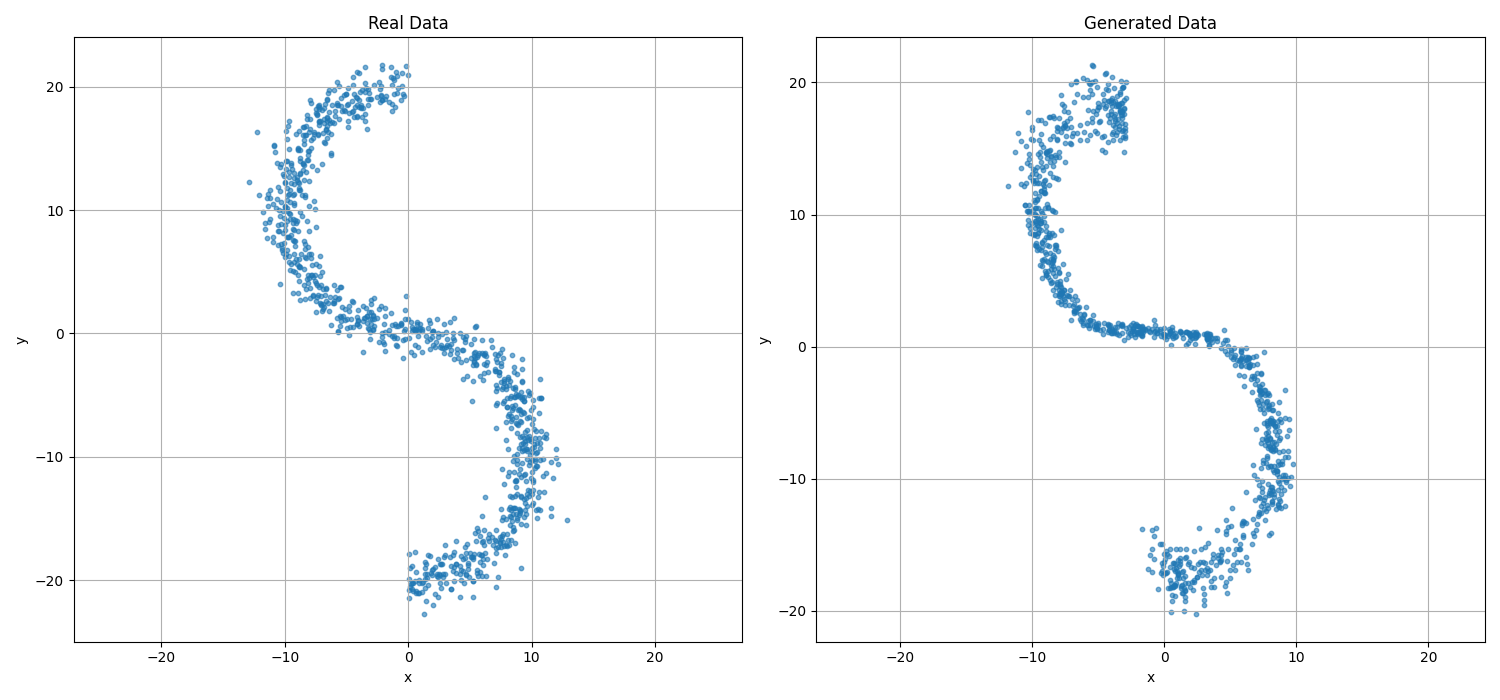|
|Dataset Samples|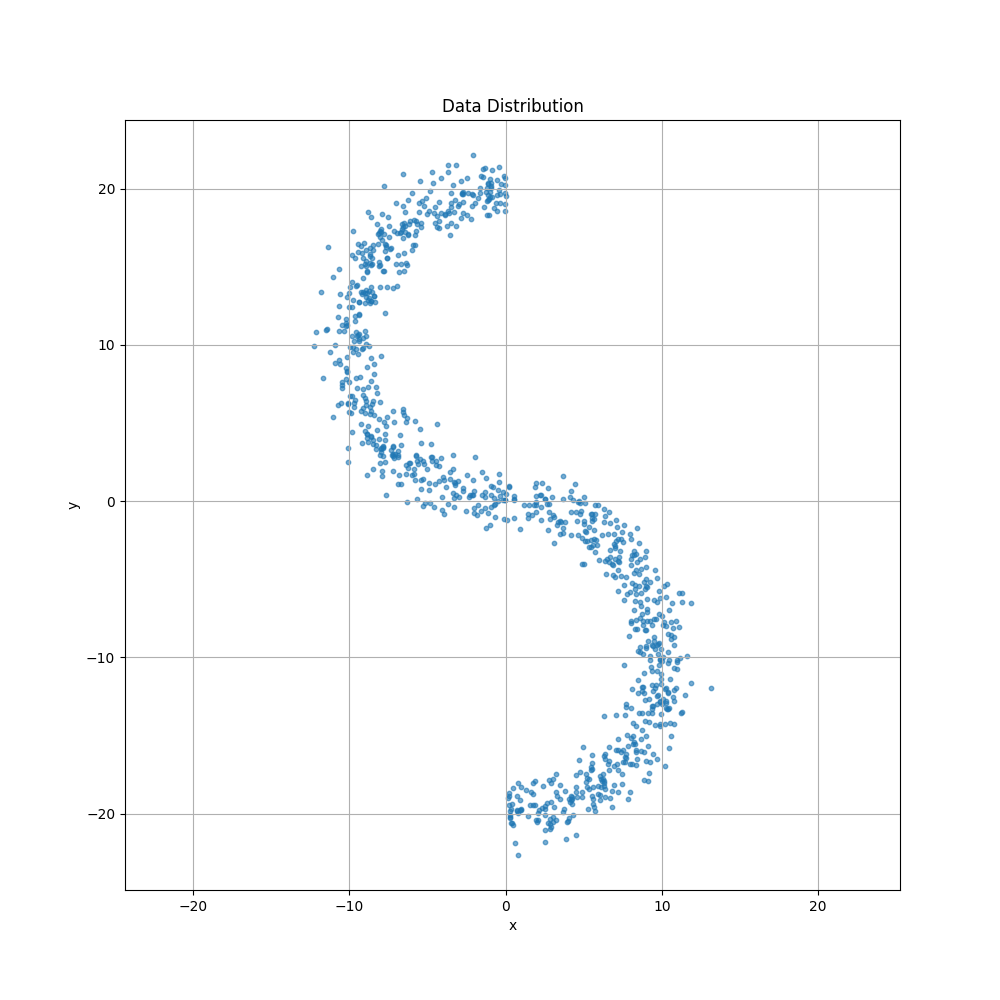|
|Generated Samples|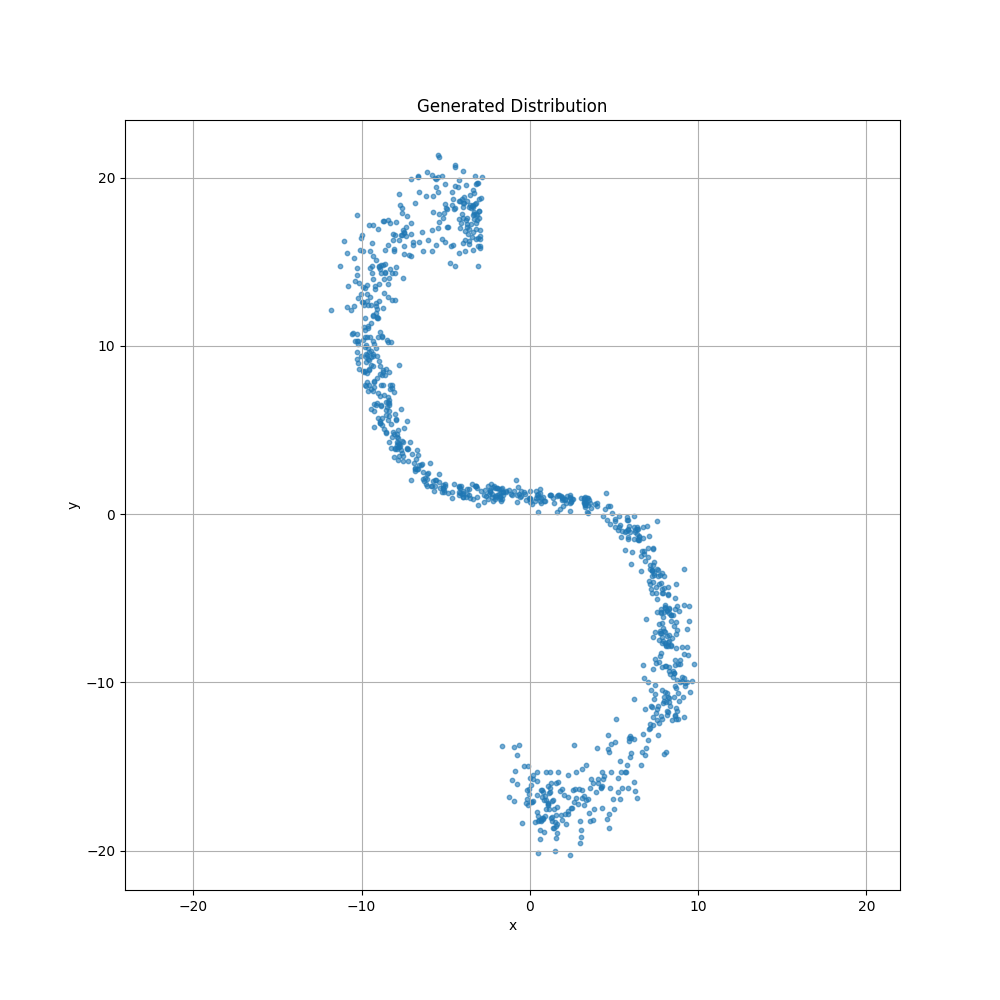|
|Real Samples|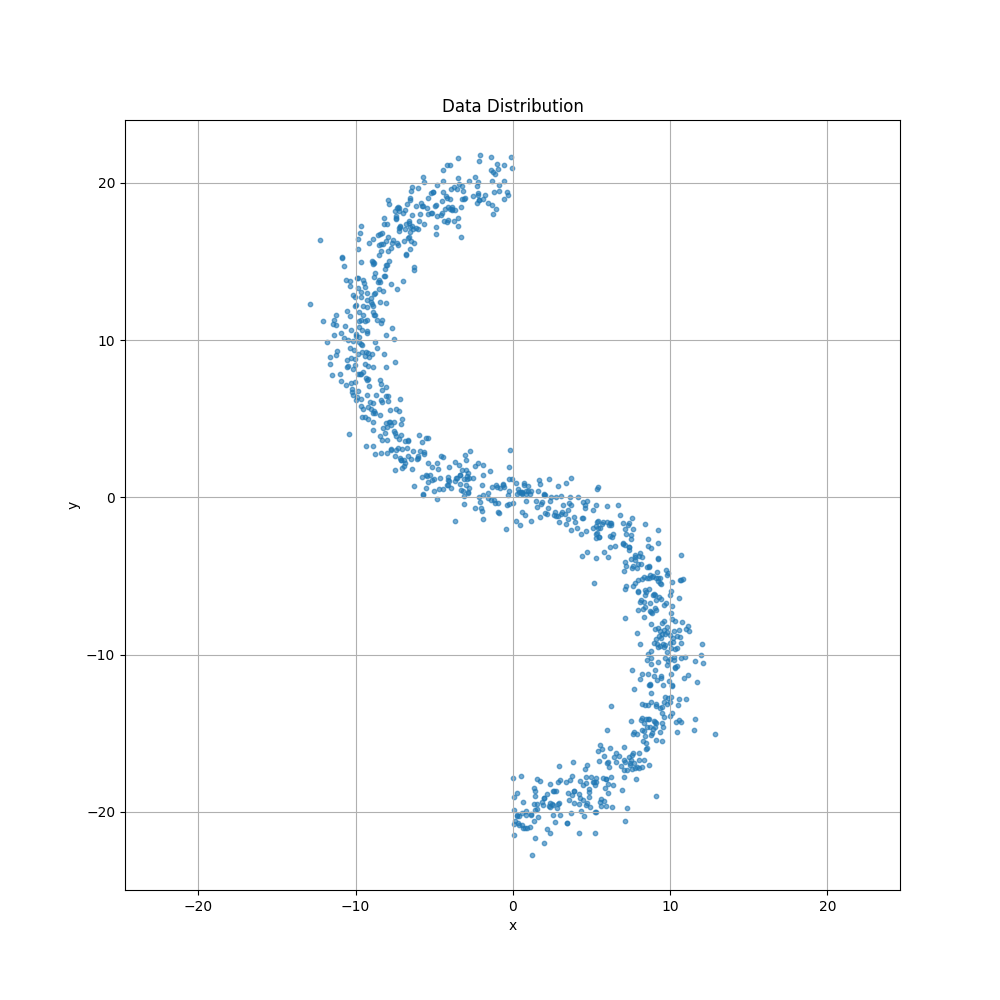|
|Loss Plot|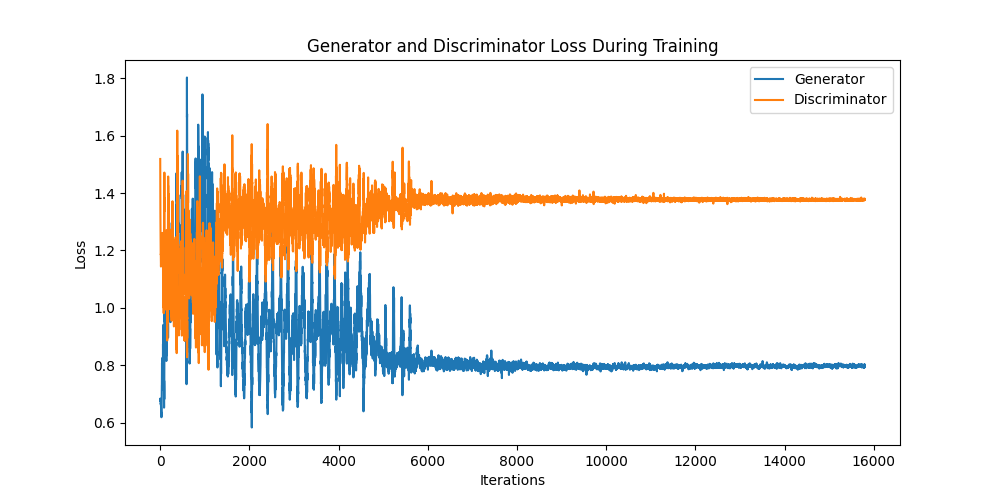|
|Score Plot|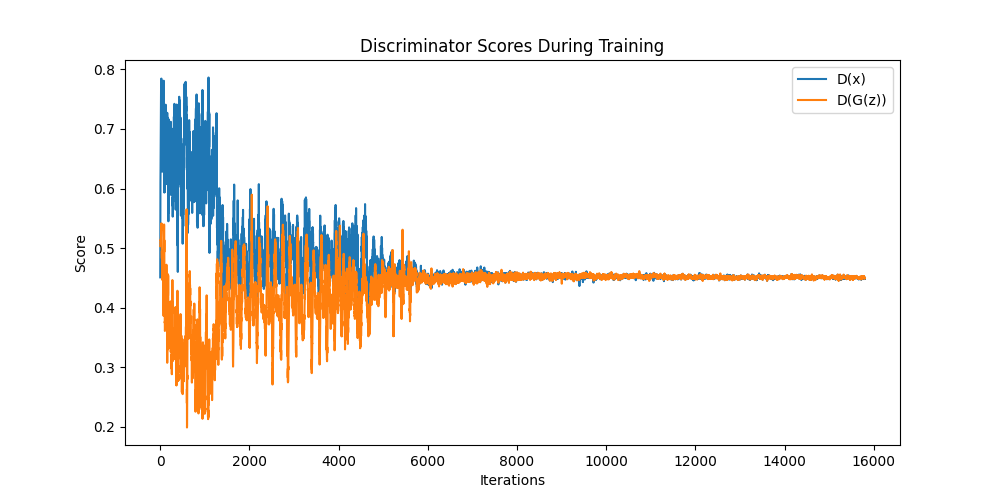|

## Dataset Characteristics

The GAN is trained on a synthetic 2D dataset with the following distribution:
- Points lie on a circle with radius approximately 10 (with Gaussian noise)
- The distribution forms two semi-circles that are vertically offset:
  - Upper semi-circle: y = (10+r)sinθ + 10 when π/2 ≤ θ ≤ 3π/2
  - Lower semi-circle: y = (10+r)sinθ - 10 otherwise


## Architecture Overview

The implementation uses a relatively simple GAN architecture:

**Generator:**
- Input: 100-dimensional noise vector
- 3 hidden layers with LeakyReLU activations (128 → 256 → 256 units)
- Output: 2D coordinates with no activation function

**Discriminator:**
- Input: 2D coordinates
- 3 hidden layers with LeakyReLU and Dropout (128 → 256 → 128 units)
- Output: Single sigmoid unit

## Training Strategy Analysis

Several effective training techniques were implemented:

1. **Label smoothing**: Real labels set to 0.9 instead of 1.0
2. **Alternate training**: Discriminator trained only every other batch
3. **Adam optimizer**: Using β₁=0.5, β₂=0.999 (standard for GANs)
4. **Dropout in discriminator**: 30% dropout rate to prevent overfitting

## Training Dynamics Analysis

Looking at the training logs:

### Stability at Equilibrium

The most striking observation is the remarkable stability in the training metrics:
- **Discriminator Loss**: Consistently around 1.375-1.380
- **Generator Loss**: Consistently around 0.795-0.805
- **D(x)**: Stabilized at ~0.450
- **D(G(z))**: Stabilized at ~0.450

This indicates the GAN has reached a Nash equilibrium where:
1. The discriminator can no longer distinguish between real and fake samples (both scored around 0.45)
2. The generator has successfully learned to produce samples that match the real data distribution

### Absence of Mode Collapse

The stability of both losses and the near-identical D(x) and D(G(z)) values strongly suggest that mode collapse has been avoided. In mode collapse, we would typically see the generator loss decrease while discriminator loss increases, and D(G(z)) would fluctuate significantly.

### Training Efficiency

Each epoch completed in approximately 1.36 seconds, with the entire training process (200 epochs) taking under 5 minutes. This efficiency is due to:
1. The relatively simple architecture
2. The modest dataset size (10,000 samples)
3. Effective batch processing (batch size of 128)

## Insights on GAN Equilibrium

The training logs show a textbook example of a GAN reaching the theoretical equilibrium point where D(x) ≈ D(G(z)) ≈ 0.5. In practice, we see values around 0.45, which is remarkably close to the ideal 0.5.

This equilibrium indicates that:
1. The discriminator is maximally confused
2. The generator has successfully learned the data distribution
3. The training process has converged to a stable solution

# Task 3: Use the DCGAN (or an improvement to it) to build a generator for a face image set of your choice. ✅

Can you get realistic faces that are not in the training set? ✅

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import logging
import os
from tensorboardX import SummaryWriter
from PIL import Image

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger('FaceGAN')

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Create directories for saving models and results
os.makedirs('models/face_gan', exist_ok=True)
os.makedirs('results/face_gan', exist_ok=True)
os.makedirs('data/celeba', exist_ok=True)

# Image parameters
image_size = 64
nc = 3  # Number of channels (RGB)
nz = 100  # Size of latent vector
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator

class Generator(nn.Module):
    """
    Generator network for DCGAN with improvements
    """
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is latent vector z
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size: ngf x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size: nc x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    """
    Discriminator network for DCGAN with improvements
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: ndf x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def weights_init(m):
    """
    Custom weights initialization
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Logger:
    """
    Logger for the GAN training process
    """
    def __init__(self, model_name='face_gan'):
        self.model_name = model_name
        self.writer = SummaryWriter(f'logs/{model_name}')
        self.d_losses = []
        self.g_losses = []
        self.d_real_scores = []
        self.d_fake_scores = []
        
    def log(self, d_loss, g_loss, d_real_score, d_fake_score, epoch, n_batch, num_batches):
        """Log losses and scores"""
        step = epoch * num_batches + n_batch
        
        # Log to TensorBoard
        self.writer.add_scalar(f'{self.model_name}/d_loss', d_loss.item(), step)
        self.writer.add_scalar(f'{self.model_name}/g_loss', g_loss.item(), step)
        self.writer.add_scalar(f'{self.model_name}/d_real_score', d_real_score.mean().item(), step)
        self.writer.add_scalar(f'{self.model_name}/d_fake_score', d_fake_score.mean().item(), step)
        
        # Store for plotting
        self.d_losses.append(d_loss.item())
        self.g_losses.append(g_loss.item())
        self.d_real_scores.append(d_real_score.mean().item())
        self.d_fake_scores.append(d_fake_score.mean().item())
    
    def log_images(self, images, num_images, epoch, n_batch, num_batches):
        """Log images to TensorBoard"""
        step = epoch * num_batches + n_batch
        grid = vutils.make_grid(images, padding=2, normalize=True)
        self.writer.add_image(f'{self.model_name}/generated_images', grid, step)
        
        # Save images to disk
        img_dir = f'results/{self.model_name}/images'
        os.makedirs(img_dir, exist_ok=True)
        vutils.save_image(images, f'{img_dir}/epoch_{epoch}_batch_{n_batch}.png', 
                         normalize=True, padding=2)
    
    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_loss, g_loss, d_real_score, d_fake_score):
        """Display training status"""
        logger.info(f"Epoch: [{epoch}/{num_epochs}], Batch Num: [{n_batch}/{num_batches}]")
        logger.info(f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")
        logger.info(f"D(x): {d_real_score.mean().item():.4f}, D(G(z)): {d_fake_score.mean().item():.4f}")
    
    def save_models(self, generator, discriminator, epoch):
        """Save models"""
        torch.save(generator.state_dict(), f'models/{self.model_name}/generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'models/{self.model_name}/discriminator_epoch_{epoch}.pth')
        logger.info(f"Models saved at epoch {epoch}")
    
    def plot_losses(self):
        """Plot the training losses"""
        plt.figure(figsize=(10, 5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(self.g_losses, label="Generator")
        plt.plot(self.d_losses, label="Discriminator")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f'results/{self.model_name}/loss_plot.png')
        plt.close()
        logger.info(f"Loss plot saved to results/{self.model_name}/loss_plot.png")
    
    def plot_scores(self):
        """Plot the discriminator scores"""
        plt.figure(figsize=(10, 5))
        plt.title("Discriminator Scores During Training")
        plt.plot(self.d_real_scores, label="D(x)")
        plt.plot(self.d_fake_scores, label="D(G(z))")
        plt.xlabel("Iterations")
        plt.ylabel("Score")
        plt.legend()
        plt.savefig(f'results/{self.model_name}/score_plot.png')
        plt.close()
        logger.info(f"Score plot saved to results/{self.model_name}/score_plot.png")
    
    def close(self):
        """Close the TensorBoard writer"""
        self.writer.close()

def get_celeba_dataset(path):
    """
    Get the CelebA dataset from the specified path
    """
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    # Use a custom dataset class to load images directly from the directory
    class CelebADataset(torch.utils.data.Dataset):
        def __init__(self, img_dir, transform=None):
            self.img_dir = img_dir
            self.transform = transform
            self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]
            logger.info(f"Found {len(self.image_files)} images in {img_dir}")
            
        def __len__(self):
            return len(self.image_files)
            
        def __getitem__(self, idx):
            img_path = os.path.join(self.img_dir, self.image_files[idx])
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            return image, 0  # Return dummy label 0
    
    # Create dataset
    dataset = CelebADataset(path, transform=transform)
    logger.info(f"CelebA dataset loaded successfully with {len(dataset)} images")
    
    return dataset

def noise(batch_size):
    """Generate random noise for the generator"""
    return torch.randn(batch_size, nz, 1, 1, device=device)

def train_face_gan(num_epochs=50, batch_size=128, save_interval=5, log_interval=100, lr=0.0002, path='RTML/A5/data/celeba/img_align_celeba'):
    """Train the face GAN"""
    logger.info("Starting Face GAN training...")
    
    # Get dataset
    dataset = get_celeba_dataset(path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    num_batches = len(dataloader)
    
    # Create networks
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    
    # Initialize weights
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    # Setup optimizers
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # Loss function
    criterion = nn.BCELoss()
    
    # Fixed noise for visualization
    fixed_noise = noise(64)
    
    # Create logger
    log = Logger()
    
    # Labels
    real_label = 0.9  # Label smoothing
    fake_label = 0
    
    # Start training
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # Train with real batch
            netD.zero_grad()
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            
            # Train with fake batch
            noise_input = noise(batch_size)
            fake = netG(noise_input)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            
            # Only update discriminator every other batch
            if i % 2 == 0:
                optimizerD.step()
            
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # Generator wants discriminator to think its output is real
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            
            # Log batch error
            log.log(errD, errG, output, output, epoch, i, num_batches)
            
            # Output training stats
            if i % log_interval == 0:
                log.display_status(
                    epoch, num_epochs, i, num_batches,
                    errD, errG, torch.tensor([D_x]), torch.tensor([D_G_z2])
                )
                
                # Generate and log images
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                log.log_images(fake, 64, epoch, i, num_batches)
        
        # Save models at specified intervals
        if epoch % save_interval == 0 or epoch == num_epochs - 1:
            log.save_models(netG, netD, epoch)
            
        epoch_time = time.time() - epoch_start_time
        logger.info(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")
    
    # Save final models
    log.save_models(netG, netD, num_epochs-1)
    
    # Plot training curves
    log.plot_losses()
    log.plot_scores()
    
    # Close logger
    log.close()
    
    total_time = time.time() - start_time
    logger.info(f"Face GAN training completed in {datetime.timedelta(seconds=total_time)}")
    
    return netG, netD

def generate_faces(generator, num_images=16, grid_size=4):
    """Generate and display faces using the trained generator"""
    logger.info(f"Generating {num_images} face images...")
    
    # Generate images
    with torch.no_grad():
        z = noise(num_images)
        generated_images = generator(z).detach().cpu()
    
    # Save individual images
    img_dir = f'results/face_gan/generated'
    os.makedirs(img_dir, exist_ok=True)
    
    for i in range(num_images):
        img = generated_images[i]
        img = img * 0.5 + 0.5  # Unnormalize
        vutils.save_image(img, f'{img_dir}/face_{i}.png')
    
    # Create and save grid
    grid = vutils.make_grid(generated_images, nrow=grid_size, padding=2, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Generated Faces")
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.savefig(f'results/face_gan/generated_faces_grid.png')
    plt.close()
    
    logger.info(f"Generated images saved to {img_dir}")
    logger.info(f"Grid image saved to results/face_gan/generated_faces_grid.png")

def interpolate_faces(generator, num_steps=10):
    """Generate a sequence of faces by interpolating between two random points in latent space"""
    logger.info("Generating face interpolation...")
    
    # Generate two random points in latent space
    with torch.no_grad():
        z1 = noise(1)
        z2 = noise(1)
        
        # Generate intermediate points
        images = []
        for alpha in np.linspace(0, 1, num_steps):
            z_interp = z1 * (1 - alpha) + z2 * alpha
            img = generator(z_interp).detach().cpu()
            images.append(img[0])
        
        # Create grid
        grid = vutils.make_grid(images, nrow=num_steps, padding=2, normalize=True)
        
        # Save grid
        plt.figure(figsize=(20, 5))
        plt.axis("off")
        plt.title("Face Interpolation")
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.savefig(f'results/face_gan/face_interpolation.png')
        plt.close()
        
        logger.info(f"Interpolation saved to results/face_gan/face_interpolation.png")

def load_model(model_path):
    """Load a trained generator model"""
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    return generator

if __name__ == "__main__":
    # Define dataset path - change this to your actual path
    dataset_path = './data/celeba/img_align_celeba'
    
    # Create directories for saving results
    os.makedirs('models/face_gan', exist_ok=True)
    os.makedirs('results/face_gan', exist_ok=True)
    os.makedirs('logs/face_gan', exist_ok=True)
    
    # Check if CUDA is available
    if torch.cuda.is_available():
        logger.info(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        logger.info("CUDA is not available. Using CPU for training (this will be slow).")
    
    # Train the face GAN
    try:
        generator, discriminator = train_face_gan(num_epochs=50, path=dataset_path)
        
        # Generate faces
        generate_faces(generator, num_images=16)
        
        # Generate face interpolation
        interpolate_faces(generator)
        
        logger.info("Training and generation completed successfully!")
    except Exception as e:
        logger.error(f"An error occurred: {e}")
        import traceback
        logger.error(traceback.format_exc())


```bash
(base) jupyter-st125462@puffer:~/RTML/A5$ python face_gan_celeba.py
2025-03-09 16:44:19,039 - FaceGAN - INFO - Using device: cuda
2025-03-09 16:44:19,077 - FaceGAN - INFO - CUDA is available. Using GPU: NVIDIA GeForce RTX 2080 Ti
2025-03-09 16:44:19,077 - FaceGAN - INFO - Starting Face GAN training...
2025-03-09 16:44:19,196 - FaceGAN - INFO - Found 202599 images in ./data/celeba/img_align_celeba
2025-03-09 16:44:19,196 - FaceGAN - INFO - CelebA dataset loaded successfully with 202599 images
2025-03-09 16:44:20,252 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [0/1583]
2025-03-09 16:44:20,252 - FaceGAN - INFO - Discriminator Loss: 2.0554, Generator Loss: 4.3613
2025-03-09 16:44:20,252 - FaceGAN - INFO - D(x): 0.3296, D(G(z)): 0.0117
2025-03-09 16:44:25,906 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [100/1583]
2025-03-09 16:44:25,906 - FaceGAN - INFO - Discriminator Loss: 2.1267, Generator Loss: 9.1394
2025-03-09 16:44:25,906 - FaceGAN - INFO - D(x): 0.4472, D(G(z)): 0.0001
2025-03-09 16:44:31,473 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [200/1583]
2025-03-09 16:44:31,473 - FaceGAN - INFO - Discriminator Loss: 2.9355, Generator Loss: 12.2809
2025-03-09 16:44:31,473 - FaceGAN - INFO - D(x): 0.7085, D(G(z)): 0.0000
2025-03-09 16:44:37,024 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [300/1583]
2025-03-09 16:44:37,025 - FaceGAN - INFO - Discriminator Loss: 2.0838, Generator Loss: 3.7846
2025-03-09 16:44:37,025 - FaceGAN - INFO - D(x): 0.7118, D(G(z)): 0.0325
2025-03-09 16:44:42,709 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [400/1583]
2025-03-09 16:44:42,710 - FaceGAN - INFO - Discriminator Loss: 1.6870, Generator Loss: 1.9773
2025-03-09 16:44:42,710 - FaceGAN - INFO - D(x): 0.4007, D(G(z)): 0.1363
2025-03-09 16:44:48,395 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [500/1583]
2025-03-09 16:44:48,395 - FaceGAN - INFO - Discriminator Loss: 1.4942, Generator Loss: 1.6811
2025-03-09 16:44:48,395 - FaceGAN - INFO - D(x): 0.5630, D(G(z)): 0.1868
2025-03-09 16:44:54,030 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [600/1583]
2025-03-09 16:44:54,031 - FaceGAN - INFO - Discriminator Loss: 1.3162, Generator Loss: 1.7134
2025-03-09 16:44:54,031 - FaceGAN - INFO - D(x): 0.4808, D(G(z)): 0.1738
2025-03-09 16:44:59,760 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [700/1583]
2025-03-09 16:44:59,760 - FaceGAN - INFO - Discriminator Loss: 1.5607, Generator Loss: 1.6907
2025-03-09 16:44:59,760 - FaceGAN - INFO - D(x): 0.5617, D(G(z)): 0.1894
2025-03-09 16:45:05,442 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [800/1583]
2025-03-09 16:45:05,442 - FaceGAN - INFO - Discriminator Loss: 1.2925, Generator Loss: 1.8481
2025-03-09 16:45:05,442 - FaceGAN - INFO - D(x): 0.5867, D(G(z)): 0.1501
2025-03-09 16:45:11,185 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [900/1583]
2025-03-09 16:45:11,185 - FaceGAN - INFO - Discriminator Loss: 1.4174, Generator Loss: 1.1607
2025-03-09 16:45:11,185 - FaceGAN - INFO - D(x): 0.4634, D(G(z)): 0.3049
2025-03-09 16:45:16,969 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [1000/1583]
2025-03-09 16:45:16,969 - FaceGAN - INFO - Discriminator Loss: 1.2883, Generator Loss: 1.3478
2025-03-09 16:45:16,969 - FaceGAN - INFO - D(x): 0.6631, D(G(z)): 0.2651
2025-03-09 16:45:22,596 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [1100/1583]
2025-03-09 16:45:22,596 - FaceGAN - INFO - Discriminator Loss: 1.4138, Generator Loss: 1.5254
2025-03-09 16:45:22,596 - FaceGAN - INFO - D(x): 0.6001, D(G(z)): 0.2183
2025-03-09 16:45:28,383 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [1200/1583]
2025-03-09 16:45:28,383 - FaceGAN - INFO - Discriminator Loss: 1.3543, Generator Loss: 1.1481
2025-03-09 16:45:28,383 - FaceGAN - INFO - D(x): 0.4473, D(G(z)): 0.3032
2025-03-09 16:45:34,079 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [1300/1583]
2025-03-09 16:45:34,079 - FaceGAN - INFO - Discriminator Loss: 1.3694, Generator Loss: 1.2273
2025-03-09 16:45:34,080 - FaceGAN - INFO - D(x): 0.4673, D(G(z)): 0.2893
2025-03-09 16:45:39,848 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [1400/1583]
2025-03-09 16:45:39,848 - FaceGAN - INFO - Discriminator Loss: 1.2642, Generator Loss: 1.1365
2025-03-09 16:45:39,848 - FaceGAN - INFO - D(x): 0.4981, D(G(z)): 0.3157
2025-03-09 16:45:45,629 - FaceGAN - INFO - Epoch: [0/50], Batch Num: [1500/1583]
2025-03-09 16:45:45,629 - FaceGAN - INFO - Discriminator Loss: 1.3573, Generator Loss: 1.0901
2025-03-09 16:45:45,629 - FaceGAN - INFO - D(x): 0.4045, D(G(z)): 0.3310
2025-03-09 16:45:50,538 - FaceGAN - INFO - Models saved at epoch 0
2025-03-09 16:45:50,539 - FaceGAN - INFO - Epoch 0 completed in 91.07 seconds
2025-03-09 17:30:40,717 - FaceGAN - INFO - Epoch: [28/50], Batch Num: [1400/1583]
2025-03-09 17:30:40,717 - FaceGAN - INFO - Discriminator Loss: 0.5182, Generator Loss: 2.5327
2025-03-09 17:30:40,717 - FaceGAN - INFO - D(x): 0.7797, D(G(z)): 0.0833
2025-03-09 17:30:46,846 - FaceGAN - INFO - Epoch: [28/50], Batch Num: [1500/1583]
2025-03-09 17:30:46,846 - FaceGAN - INFO - Discriminator Loss: 0.5852, Generator Loss: 2.8203
2025-03-09 17:30:46,846 - FaceGAN - INFO - D(x): 0.7664, D(G(z)): 0.0562
2025-03-09 17:30:52,006 - FaceGAN - INFO - Epoch 28 completed in 97.56 seconds
2025-03-09 17:30:52,372 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [0/1583]
2025-03-09 17:30:52,373 - FaceGAN - INFO - Discriminator Loss: 0.5519, Generator Loss: 2.4731
2025-03-09 17:30:52,373 - FaceGAN - INFO - D(x): 0.6976, D(G(z)): 0.0868
2025-03-09 17:30:58,408 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [100/1583]
2025-03-09 17:30:58,409 - FaceGAN - INFO - Discriminator Loss: 0.5584, Generator Loss: 3.7824
2025-03-09 17:30:58,409 - FaceGAN - INFO - D(x): 0.8730, D(G(z)): 0.0202
2025-03-09 17:31:04,545 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [200/1583]
2025-03-09 17:31:04,546 - FaceGAN - INFO - Discriminator Loss: 0.7538, Generator Loss: 3.5396
2025-03-09 17:31:04,546 - FaceGAN - INFO - D(x): 0.9191, D(G(z)): 0.0255
2025-03-09 17:31:10,611 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [300/1583]
2025-03-09 17:31:10,611 - FaceGAN - INFO - Discriminator Loss: 0.9662, Generator Loss: 1.5030
2025-03-09 17:31:10,611 - FaceGAN - INFO - D(x): 0.4181, D(G(z)): 0.2339
2025-03-09 17:31:16,722 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [400/1583]
2025-03-09 17:31:16,722 - FaceGAN - INFO - Discriminator Loss: 0.6149, Generator Loss: 2.8341
2025-03-09 17:31:16,722 - FaceGAN - INFO - D(x): 0.8641, D(G(z)): 0.0535
2025-03-09 17:31:22,838 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [500/1583]
2025-03-09 17:31:22,838 - FaceGAN - INFO - Discriminator Loss: 0.5462, Generator Loss: 2.8105
2025-03-09 17:31:22,838 - FaceGAN - INFO - D(x): 0.7944, D(G(z)): 0.0583
2025-03-09 17:31:28,971 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [600/1583]
2025-03-09 17:31:28,971 - FaceGAN - INFO - Discriminator Loss: 0.6987, Generator Loss: 1.4948
2025-03-09 17:31:28,971 - FaceGAN - INFO - D(x): 0.5798, D(G(z)): 0.2405
2025-03-09 17:31:35,023 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [700/1583]
2025-03-09 17:31:35,024 - FaceGAN - INFO - Discriminator Loss: 0.7874, Generator Loss: 4.3768
2025-03-09 17:31:35,024 - FaceGAN - INFO - D(x): 0.9288, D(G(z)): 0.0101
2025-03-09 17:31:41,161 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [800/1583]
2025-03-09 17:31:41,161 - FaceGAN - INFO - Discriminator Loss: 0.8026, Generator Loss: 1.9649
2025-03-09 17:31:41,161 - FaceGAN - INFO - D(x): 0.5224, D(G(z)): 0.1450
2025-03-09 17:31:47,253 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [900/1583]
2025-03-09 17:31:47,254 - FaceGAN - INFO - Discriminator Loss: 0.5284, Generator Loss: 2.9316
2025-03-09 17:31:47,254 - FaceGAN - INFO - D(x): 0.7923, D(G(z)): 0.0504
2025-03-09 17:31:53,399 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [1000/1583]
2025-03-09 17:31:53,399 - FaceGAN - INFO - Discriminator Loss: 0.9166, Generator Loss: 3.5491
2025-03-09 17:31:53,400 - FaceGAN - INFO - D(x): 0.9275, D(G(z)): 0.0258
2025-03-09 17:31:59,524 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [1100/1583]
2025-03-09 17:31:59,524 - FaceGAN - INFO - Discriminator Loss: 0.7251, Generator Loss: 1.4444
2025-03-09 17:31:59,524 - FaceGAN - INFO - D(x): 0.5472, D(G(z)): 0.2499
2025-03-09 17:32:05,649 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [1200/1583]
2025-03-09 17:32:05,649 - FaceGAN - INFO - Discriminator Loss: 1.1622, Generator Loss: 0.6336
2025-03-09 17:32:05,649 - FaceGAN - INFO - D(x): 0.3438, D(G(z)): 0.5794
2025-03-09 17:32:11,766 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [1300/1583]
2025-03-09 17:32:11,766 - FaceGAN - INFO - Discriminator Loss: 0.4983, Generator Loss: 3.3104
2025-03-09 17:32:11,766 - FaceGAN - INFO - D(x): 0.8904, D(G(z)): 0.0347
2025-03-09 17:32:17,893 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [1400/1583]
2025-03-09 17:32:17,894 - FaceGAN - INFO - Discriminator Loss: 0.7966, Generator Loss: 1.7225
2025-03-09 17:32:17,894 - FaceGAN - INFO - D(x): 0.6109, D(G(z)): 0.1796
2025-03-09 17:32:24,014 - FaceGAN - INFO - Epoch: [29/50], Batch Num: [1500/1583]
2025-03-09 17:32:24,014 - FaceGAN - INFO - Discriminator Loss: 0.9411, Generator Loss: 1.2369
2025-03-09 17:32:24,014 - FaceGAN - INFO - D(x): 0.4440, D(G(z)): 0.2982
2025-03-09 17:32:29,161 - FaceGAN - INFO - Epoch 29 completed in 97.15 seconds
2025-03-09 17:32:29,538 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [0/1583]
2025-03-09 17:32:29,539 - FaceGAN - INFO - Discriminator Loss: 0.5908, Generator Loss: 3.4667
2025-03-09 17:32:29,539 - FaceGAN - INFO - D(x): 0.8893, D(G(z)): 0.0261
2025-03-09 17:32:35,714 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [100/1583]
2025-03-09 17:32:35,714 - FaceGAN - INFO - Discriminator Loss: 0.8186, Generator Loss: 3.7615
2025-03-09 17:32:35,715 - FaceGAN - INFO - D(x): 0.9533, D(G(z)): 0.0183
2025-03-09 17:32:41,833 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [200/1583]
2025-03-09 17:32:41,833 - FaceGAN - INFO - Discriminator Loss: 0.5383, Generator Loss: 2.3546
2025-03-09 17:32:41,833 - FaceGAN - INFO - D(x): 0.7824, D(G(z)): 0.0972
2025-03-09 17:32:47,981 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [300/1583]
2025-03-09 17:32:47,981 - FaceGAN - INFO - Discriminator Loss: 0.8003, Generator Loss: 4.4207
2025-03-09 17:32:47,981 - FaceGAN - INFO - D(x): 0.9360, D(G(z)): 0.0097
2025-03-09 17:32:54,014 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [400/1583]
2025-03-09 17:32:54,014 - FaceGAN - INFO - Discriminator Loss: 0.4592, Generator Loss: 2.6188
2025-03-09 17:32:54,015 - FaceGAN - INFO - D(x): 0.8225, D(G(z)): 0.0739
2025-03-09 17:33:00,088 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [500/1583]
2025-03-09 17:33:00,088 - FaceGAN - INFO - Discriminator Loss: 1.1411, Generator Loss: 1.1646
2025-03-09 17:33:00,088 - FaceGAN - INFO - D(x): 0.5224, D(G(z)): 0.3197
2025-03-09 17:33:06,165 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [600/1583]
2025-03-09 17:33:06,166 - FaceGAN - INFO - Discriminator Loss: 0.8307, Generator Loss: 3.3736
2025-03-09 17:33:06,166 - FaceGAN - INFO - D(x): 0.9341, D(G(z)): 0.0307
2025-03-09 17:33:12,320 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [700/1583]
2025-03-09 17:33:12,321 - FaceGAN - INFO - Discriminator Loss: 0.6259, Generator Loss: 2.9523
2025-03-09 17:33:12,321 - FaceGAN - INFO - D(x): 0.7953, D(G(z)): 0.0493
2025-03-09 17:33:18,465 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [800/1583]
2025-03-09 17:33:18,465 - FaceGAN - INFO - Discriminator Loss: 0.7811, Generator Loss: 3.5060
2025-03-09 17:33:18,465 - FaceGAN - INFO - D(x): 0.8846, D(G(z)): 0.0282
2025-03-09 17:33:24,632 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [900/1583]
2025-03-09 17:33:24,632 - FaceGAN - INFO - Discriminator Loss: 0.5346, Generator Loss: 3.2821
2025-03-09 17:33:24,632 - FaceGAN - INFO - D(x): 0.8401, D(G(z)): 0.0338
2025-03-09 17:33:30,707 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [1000/1583]
2025-03-09 17:33:30,707 - FaceGAN - INFO - Discriminator Loss: 0.4546, Generator Loss: 3.4401
2025-03-09 17:33:30,707 - FaceGAN - INFO - D(x): 0.7984, D(G(z)): 0.0325
2025-03-09 17:33:36,866 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [1100/1583]
2025-03-09 17:33:36,867 - FaceGAN - INFO - Discriminator Loss: 0.5055, Generator Loss: 3.7626
2025-03-09 17:33:36,867 - FaceGAN - INFO - D(x): 0.9305, D(G(z)): 0.0197
2025-03-09 17:33:43,018 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [1200/1583]
2025-03-09 17:33:43,019 - FaceGAN - INFO - Discriminator Loss: 0.5845, Generator Loss: 2.9302
2025-03-09 17:33:43,019 - FaceGAN - INFO - D(x): 0.7683, D(G(z)): 0.0509
2025-03-09 17:33:49,157 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [1300/1583]
2025-03-09 17:33:49,157 - FaceGAN - INFO - Discriminator Loss: 0.4805, Generator Loss: 3.2034
2025-03-09 17:33:49,158 - FaceGAN - INFO - D(x): 0.8568, D(G(z)): 0.0378
2025-03-09 17:33:55,292 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [1400/1583]
2025-03-09 17:33:55,293 - FaceGAN - INFO - Discriminator Loss: 0.7360, Generator Loss: 2.5595
2025-03-09 17:33:55,293 - FaceGAN - INFO - D(x): 0.7935, D(G(z)): 0.0723
2025-03-09 17:34:01,380 - FaceGAN - INFO - Epoch: [30/50], Batch Num: [1500/1583]
2025-03-09 17:34:01,380 - FaceGAN - INFO - Discriminator Loss: 1.0127, Generator Loss: 3.4205
2025-03-09 17:34:01,380 - FaceGAN - INFO - D(x): 0.8186, D(G(z)): 0.0313
2025-03-09 17:34:06,512 - FaceGAN - INFO - Models saved at epoch 30
2025-03-09 17:34:06,513 - FaceGAN - INFO - Epoch 30 completed in 97.35 seconds
2025-03-09 17:34:06,945 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [0/1583]
2025-03-09 17:34:06,945 - FaceGAN - INFO - Discriminator Loss: 0.6557, Generator Loss: 2.1316
2025-03-09 17:34:06,945 - FaceGAN - INFO - D(x): 0.5787, D(G(z)): 0.1278
2025-03-09 17:34:13,059 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [100/1583]
2025-03-09 17:34:13,059 - FaceGAN - INFO - Discriminator Loss: 0.5809, Generator Loss: 2.6453
2025-03-09 17:34:13,059 - FaceGAN - INFO - D(x): 0.7977, D(G(z)): 0.0683
2025-03-09 17:34:19,081 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [200/1583]
2025-03-09 17:34:19,081 - FaceGAN - INFO - Discriminator Loss: 0.7797, Generator Loss: 1.1147
2025-03-09 17:34:19,081 - FaceGAN - INFO - D(x): 0.5333, D(G(z)): 0.3596
2025-03-09 17:34:25,098 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [300/1583]
2025-03-09 17:34:25,098 - FaceGAN - INFO - Discriminator Loss: 0.5424, Generator Loss: 3.5393
2025-03-09 17:34:25,098 - FaceGAN - INFO - D(x): 0.8726, D(G(z)): 0.0271
2025-03-09 17:34:31,147 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [400/1583]
2025-03-09 17:34:31,147 - FaceGAN - INFO - Discriminator Loss: 1.0941, Generator Loss: 3.2581
2025-03-09 17:34:31,147 - FaceGAN - INFO - D(x): 0.9343, D(G(z)): 0.0366
2025-03-09 17:34:37,168 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [500/1583]
2025-03-09 17:34:37,168 - FaceGAN - INFO - Discriminator Loss: 0.7264, Generator Loss: 1.3344
2025-03-09 17:34:37,168 - FaceGAN - INFO - D(x): 0.5535, D(G(z)): 0.2778
2025-03-09 17:34:43,182 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [600/1583]
2025-03-09 17:34:43,182 - FaceGAN - INFO - Discriminator Loss: 0.5996, Generator Loss: 1.7456
2025-03-09 17:34:43,182 - FaceGAN - INFO - D(x): 0.6926, D(G(z)): 0.1783
2025-03-09 17:34:49,193 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [700/1583]
2025-03-09 17:34:49,193 - FaceGAN - INFO - Discriminator Loss: 0.5060, Generator Loss: 2.0609
2025-03-09 17:34:49,193 - FaceGAN - INFO - D(x): 0.7410, D(G(z)): 0.1328
2025-03-09 17:34:55,101 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [800/1583]
2025-03-09 17:34:55,101 - FaceGAN - INFO - Discriminator Loss: 0.5519, Generator Loss: 2.2832
2025-03-09 17:34:55,101 - FaceGAN - INFO - D(x): 0.7168, D(G(z)): 0.0984
2025-03-09 17:35:01,007 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [900/1583]
2025-03-09 17:35:01,007 - FaceGAN - INFO - Discriminator Loss: 1.1550, Generator Loss: 1.0119
2025-03-09 17:35:01,007 - FaceGAN - INFO - D(x): 0.3595, D(G(z)): 0.3943
2025-03-09 17:35:06,920 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [1000/1583]
2025-03-09 17:35:06,920 - FaceGAN - INFO - Discriminator Loss: 0.5663, Generator Loss: 2.0434
2025-03-09 17:35:06,920 - FaceGAN - INFO - D(x): 0.6895, D(G(z)): 0.1257
2025-03-09 17:35:12,912 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [1100/1583]
2025-03-09 17:35:12,912 - FaceGAN - INFO - Discriminator Loss: 0.6095, Generator Loss: 2.1436
2025-03-09 17:35:12,912 - FaceGAN - INFO - D(x): 0.7302, D(G(z)): 0.1214
2025-03-09 17:35:18,814 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [1200/1583]
2025-03-09 17:35:18,814 - FaceGAN - INFO - Discriminator Loss: 0.4938, Generator Loss: 3.2170
2025-03-09 17:35:18,814 - FaceGAN - INFO - D(x): 0.8918, D(G(z)): 0.0346
2025-03-09 17:35:24,710 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [1300/1583]
2025-03-09 17:35:24,710 - FaceGAN - INFO - Discriminator Loss: 0.9441, Generator Loss: 3.4213
2025-03-09 17:35:24,710 - FaceGAN - INFO - D(x): 0.8500, D(G(z)): 0.0367
2025-03-09 17:35:30,687 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [1400/1583]
2025-03-09 17:35:30,687 - FaceGAN - INFO - Discriminator Loss: 0.5277, Generator Loss: 3.7051
2025-03-09 17:35:30,687 - FaceGAN - INFO - D(x): 0.8647, D(G(z)): 0.0220
2025-03-09 17:35:36,724 - FaceGAN - INFO - Epoch: [31/50], Batch Num: [1500/1583]
2025-03-09 17:35:36,725 - FaceGAN - INFO - Discriminator Loss: 0.9758, Generator Loss: 4.1380
2025-03-09 17:35:36,725 - FaceGAN - INFO - D(x): 0.9283, D(G(z)): 0.0137
2025-03-09 17:35:41,807 - FaceGAN - INFO - Epoch 31 completed in 95.29 seconds
2025-03-09 17:35:42,186 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [0/1583]
2025-03-09 17:35:42,187 - FaceGAN - INFO - Discriminator Loss: 0.5080, Generator Loss: 2.7644
2025-03-09 17:35:42,187 - FaceGAN - INFO - D(x): 0.7024, D(G(z)): 0.0625
2025-03-09 17:35:48,240 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [100/1583]
2025-03-09 17:35:48,241 - FaceGAN - INFO - Discriminator Loss: 0.4674, Generator Loss: 3.4149
2025-03-09 17:35:48,241 - FaceGAN - INFO - D(x): 0.8834, D(G(z)): 0.0303
2025-03-09 17:35:54,278 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [200/1583]
2025-03-09 17:35:54,278 - FaceGAN - INFO - Discriminator Loss: 0.4660, Generator Loss: 3.2897
2025-03-09 17:35:54,278 - FaceGAN - INFO - D(x): 0.7983, D(G(z)): 0.0360
2025-03-09 17:36:00,306 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [300/1583]
2025-03-09 17:36:00,306 - FaceGAN - INFO - Discriminator Loss: 0.4663, Generator Loss: 2.7478
2025-03-09 17:36:00,306 - FaceGAN - INFO - D(x): 0.8125, D(G(z)): 0.0642
2025-03-09 17:36:06,361 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [400/1583]
2025-03-09 17:36:06,361 - FaceGAN - INFO - Discriminator Loss: 4.0592, Generator Loss: 5.2684
2025-03-09 17:36:06,361 - FaceGAN - INFO - D(x): 0.9866, D(G(z)): 0.0056
2025-03-09 17:36:12,425 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [500/1583]
2025-03-09 17:36:12,425 - FaceGAN - INFO - Discriminator Loss: 0.5891, Generator Loss: 3.0683
2025-03-09 17:36:12,425 - FaceGAN - INFO - D(x): 0.8251, D(G(z)): 0.0419
2025-03-09 17:36:18,454 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [600/1583]
2025-03-09 17:36:18,454 - FaceGAN - INFO - Discriminator Loss: 1.0192, Generator Loss: 1.3445
2025-03-09 17:36:18,454 - FaceGAN - INFO - D(x): 0.3960, D(G(z)): 0.2777
2025-03-09 17:36:24,493 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [700/1583]
2025-03-09 17:36:24,493 - FaceGAN - INFO - Discriminator Loss: 0.8201, Generator Loss: 4.7074
2025-03-09 17:36:24,493 - FaceGAN - INFO - D(x): 0.9484, D(G(z)): 0.0074
2025-03-09 17:36:30,538 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [800/1583]
2025-03-09 17:36:30,538 - FaceGAN - INFO - Discriminator Loss: 0.6481, Generator Loss: 2.2034
2025-03-09 17:36:30,538 - FaceGAN - INFO - D(x): 0.5944, D(G(z)): 0.1187
2025-03-09 17:36:36,549 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [900/1583]
2025-03-09 17:36:36,549 - FaceGAN - INFO - Discriminator Loss: 1.4205, Generator Loss: 5.2994
2025-03-09 17:36:36,549 - FaceGAN - INFO - D(x): 0.9602, D(G(z)): 0.0041
2025-03-09 17:36:42,577 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [1000/1583]
2025-03-09 17:36:42,577 - FaceGAN - INFO - Discriminator Loss: 0.5145, Generator Loss: 3.6379
2025-03-09 17:36:42,577 - FaceGAN - INFO - D(x): 0.8586, D(G(z)): 0.0240
2025-03-09 17:36:48,577 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [1100/1583]
2025-03-09 17:36:48,577 - FaceGAN - INFO - Discriminator Loss: 0.4501, Generator Loss: 3.0507
2025-03-09 17:36:48,577 - FaceGAN - INFO - D(x): 0.8649, D(G(z)): 0.0437
2025-03-09 17:36:54,616 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [1200/1583]
2025-03-09 17:36:54,617 - FaceGAN - INFO - Discriminator Loss: 0.5743, Generator Loss: 3.5779
2025-03-09 17:36:54,617 - FaceGAN - INFO - D(x): 0.8661, D(G(z)): 0.0258
2025-03-09 17:37:00,654 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [1300/1583]
2025-03-09 17:37:00,655 - FaceGAN - INFO - Discriminator Loss: 0.7565, Generator Loss: 3.5905
2025-03-09 17:37:00,655 - FaceGAN - INFO - D(x): 0.9386, D(G(z)): 0.0241
2025-03-09 17:37:06,578 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [1400/1583]
2025-03-09 17:37:06,578 - FaceGAN - INFO - Discriminator Loss: 0.6004, Generator Loss: 1.4916
2025-03-09 17:37:06,578 - FaceGAN - INFO - D(x): 0.6627, D(G(z)): 0.2375
2025-03-09 17:37:12,620 - FaceGAN - INFO - Epoch: [32/50], Batch Num: [1500/1583]
2025-03-09 17:37:12,620 - FaceGAN - INFO - Discriminator Loss: 0.9363, Generator Loss: 4.3326
2025-03-09 17:37:12,621 - FaceGAN - INFO - D(x): 0.9473, D(G(z)): 0.0103
2025-03-09 17:37:17,691 - FaceGAN - INFO - Epoch 32 completed in 95.88 seconds
2025-03-09 17:37:18,091 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [0/1583]
2025-03-09 17:37:18,091 - FaceGAN - INFO - Discriminator Loss: 0.7700, Generator Loss: 3.0485
2025-03-09 17:37:18,092 - FaceGAN - INFO - D(x): 0.7637, D(G(z)): 0.0447
2025-03-09 17:37:24,213 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [100/1583]
2025-03-09 17:37:24,213 - FaceGAN - INFO - Discriminator Loss: 0.4579, Generator Loss: 2.6981
2025-03-09 17:37:24,213 - FaceGAN - INFO - D(x): 0.8074, D(G(z)): 0.0650
2025-03-09 17:37:30,235 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [200/1583]
2025-03-09 17:37:30,235 - FaceGAN - INFO - Discriminator Loss: 0.8739, Generator Loss: 4.6905
2025-03-09 17:37:30,235 - FaceGAN - INFO - D(x): 0.9597, D(G(z)): 0.0075
2025-03-09 17:37:36,257 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [300/1583]
2025-03-09 17:37:36,257 - FaceGAN - INFO - Discriminator Loss: 0.6359, Generator Loss: 4.2138
2025-03-09 17:37:36,257 - FaceGAN - INFO - D(x): 0.9599, D(G(z)): 0.0119
2025-03-09 17:37:42,211 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [400/1583]
2025-03-09 17:37:42,211 - FaceGAN - INFO - Discriminator Loss: 0.9799, Generator Loss: 0.6085
2025-03-09 17:37:42,212 - FaceGAN - INFO - D(x): 0.4183, D(G(z)): 0.6192
2025-03-09 17:37:48,223 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [500/1583]
2025-03-09 17:37:48,223 - FaceGAN - INFO - Discriminator Loss: 1.0497, Generator Loss: 0.6231
2025-03-09 17:37:48,223 - FaceGAN - INFO - D(x): 0.4033, D(G(z)): 0.6062
2025-03-09 17:37:54,242 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [600/1583]
2025-03-09 17:37:54,242 - FaceGAN - INFO - Discriminator Loss: 0.8074, Generator Loss: 4.6742
2025-03-09 17:37:54,242 - FaceGAN - INFO - D(x): 0.9058, D(G(z)): 0.0079
2025-03-09 17:38:00,229 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [700/1583]
2025-03-09 17:38:00,229 - FaceGAN - INFO - Discriminator Loss: 0.6080, Generator Loss: 3.6177
2025-03-09 17:38:00,229 - FaceGAN - INFO - D(x): 0.8773, D(G(z)): 0.0226
2025-03-09 17:38:06,132 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [800/1583]
2025-03-09 17:38:06,132 - FaceGAN - INFO - Discriminator Loss: 0.5180, Generator Loss: 3.0828
2025-03-09 17:38:06,132 - FaceGAN - INFO - D(x): 0.8301, D(G(z)): 0.0433
2025-03-09 17:38:12,172 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [900/1583]
2025-03-09 17:38:12,172 - FaceGAN - INFO - Discriminator Loss: 0.6892, Generator Loss: 1.7942
2025-03-09 17:38:12,172 - FaceGAN - INFO - D(x): 0.5883, D(G(z)): 0.1873
2025-03-09 17:38:18,081 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [1000/1583]
2025-03-09 17:38:18,081 - FaceGAN - INFO - Discriminator Loss: 0.6192, Generator Loss: 3.8253
2025-03-09 17:38:18,081 - FaceGAN - INFO - D(x): 0.8918, D(G(z)): 0.0182
2025-03-09 17:38:23,988 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [1100/1583]
2025-03-09 17:38:23,988 - FaceGAN - INFO - Discriminator Loss: 0.5306, Generator Loss: 2.9415
2025-03-09 17:38:23,988 - FaceGAN - INFO - D(x): 0.8091, D(G(z)): 0.0519
2025-03-09 17:38:30,011 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [1200/1583]
2025-03-09 17:38:30,012 - FaceGAN - INFO - Discriminator Loss: 1.0859, Generator Loss: 2.5869
2025-03-09 17:38:30,012 - FaceGAN - INFO - D(x): 0.8088, D(G(z)): 0.0758
2025-03-09 17:38:36,045 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [1300/1583]
2025-03-09 17:38:36,045 - FaceGAN - INFO - Discriminator Loss: 0.4716, Generator Loss: 2.6100
2025-03-09 17:38:36,045 - FaceGAN - INFO - D(x): 0.8237, D(G(z)): 0.0728
2025-03-09 17:38:42,068 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [1400/1583]
2025-03-09 17:38:42,068 - FaceGAN - INFO - Discriminator Loss: 0.6376, Generator Loss: 2.3461
2025-03-09 17:38:42,068 - FaceGAN - INFO - D(x): 0.6235, D(G(z)): 0.1017
2025-03-09 17:38:48,108 - FaceGAN - INFO - Epoch: [33/50], Batch Num: [1500/1583]
2025-03-09 17:38:48,108 - FaceGAN - INFO - Discriminator Loss: 1.2154, Generator Loss: 1.4894
2025-03-09 17:38:48,108 - FaceGAN - INFO - D(x): 0.5647, D(G(z)): 0.2318
2025-03-09 17:38:53,197 - FaceGAN - INFO - Epoch 33 completed in 95.51 seconds
2025-03-09 17:38:53,562 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [0/1583]
2025-03-09 17:38:53,562 - FaceGAN - INFO - Discriminator Loss: 0.8588, Generator Loss: 1.9990
2025-03-09 17:38:53,563 - FaceGAN - INFO - D(x): 0.7258, D(G(z)): 0.1356
2025-03-09 17:38:59,582 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [100/1583]
2025-03-09 17:38:59,582 - FaceGAN - INFO - Discriminator Loss: 0.5779, Generator Loss: 4.3510
2025-03-09 17:38:59,582 - FaceGAN - INFO - D(x): 0.9437, D(G(z)): 0.0105
2025-03-09 17:39:05,617 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [200/1583]
2025-03-09 17:39:05,617 - FaceGAN - INFO - Discriminator Loss: 0.5407, Generator Loss: 1.3048
2025-03-09 17:39:05,617 - FaceGAN - INFO - D(x): 0.7027, D(G(z)): 0.2891
2025-03-09 17:39:11,682 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [300/1583]
2025-03-09 17:39:11,682 - FaceGAN - INFO - Discriminator Loss: 0.5963, Generator Loss: 3.1505
2025-03-09 17:39:11,683 - FaceGAN - INFO - D(x): 0.8379, D(G(z)): 0.0392
2025-03-09 17:39:17,716 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [400/1583]
2025-03-09 17:39:17,717 - FaceGAN - INFO - Discriminator Loss: 0.5036, Generator Loss: 3.7640
2025-03-09 17:39:17,717 - FaceGAN - INFO - D(x): 0.8987, D(G(z)): 0.0205
2025-03-09 17:39:23,767 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [500/1583]
2025-03-09 17:39:23,767 - FaceGAN - INFO - Discriminator Loss: 1.1307, Generator Loss: 2.9120
2025-03-09 17:39:23,768 - FaceGAN - INFO - D(x): 0.8495, D(G(z)): 0.0521
2025-03-09 17:39:29,789 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [600/1583]
2025-03-09 17:39:29,789 - FaceGAN - INFO - Discriminator Loss: 0.5654, Generator Loss: 2.5370
2025-03-09 17:39:29,789 - FaceGAN - INFO - D(x): 0.6682, D(G(z)): 0.0824
2025-03-09 17:39:35,832 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [700/1583]
2025-03-09 17:39:35,832 - FaceGAN - INFO - Discriminator Loss: 1.1504, Generator Loss: 0.5422
2025-03-09 17:39:35,832 - FaceGAN - INFO - D(x): 0.3568, D(G(z)): 0.6550
2025-03-09 17:39:41,861 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [800/1583]
2025-03-09 17:39:41,861 - FaceGAN - INFO - Discriminator Loss: 0.6566, Generator Loss: 1.8661
2025-03-09 17:39:41,861 - FaceGAN - INFO - D(x): 0.5930, D(G(z)): 0.1644
2025-03-09 17:39:47,910 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [900/1583]
2025-03-09 17:39:47,910 - FaceGAN - INFO - Discriminator Loss: 0.6095, Generator Loss: 3.7182
2025-03-09 17:39:47,911 - FaceGAN - INFO - D(x): 0.9296, D(G(z)): 0.0218
2025-03-09 17:39:53,933 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [1000/1583]
2025-03-09 17:39:53,933 - FaceGAN - INFO - Discriminator Loss: 0.4523, Generator Loss: 3.4262
2025-03-09 17:39:53,933 - FaceGAN - INFO - D(x): 0.8227, D(G(z)): 0.0283
2025-03-09 17:39:59,939 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [1100/1583]
2025-03-09 17:39:59,939 - FaceGAN - INFO - Discriminator Loss: 0.4498, Generator Loss: 3.1039
2025-03-09 17:39:59,939 - FaceGAN - INFO - D(x): 0.8143, D(G(z)): 0.0454
2025-03-09 17:40:05,899 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [1200/1583]
2025-03-09 17:40:05,899 - FaceGAN - INFO - Discriminator Loss: 0.5089, Generator Loss: 3.2958
2025-03-09 17:40:05,899 - FaceGAN - INFO - D(x): 0.8967, D(G(z)): 0.0335
2025-03-09 17:40:11,958 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [1300/1583]
2025-03-09 17:40:11,958 - FaceGAN - INFO - Discriminator Loss: 0.5324, Generator Loss: 1.7220
2025-03-09 17:40:11,958 - FaceGAN - INFO - D(x): 0.6944, D(G(z)): 0.1929
2025-03-09 17:40:18,005 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [1400/1583]
2025-03-09 17:40:18,005 - FaceGAN - INFO - Discriminator Loss: 0.4825, Generator Loss: 3.6169
2025-03-09 17:40:18,005 - FaceGAN - INFO - D(x): 0.8525, D(G(z)): 0.0257
2025-03-09 17:40:24,086 - FaceGAN - INFO - Epoch: [34/50], Batch Num: [1500/1583]
2025-03-09 17:40:24,087 - FaceGAN - INFO - Discriminator Loss: 0.6769, Generator Loss: 3.4688
2025-03-09 17:40:24,087 - FaceGAN - INFO - D(x): 0.9544, D(G(z)): 0.0262
2025-03-09 17:40:29,239 - FaceGAN - INFO - Epoch 34 completed in 96.04 seconds
2025-03-09 17:40:29,660 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [0/1583]
2025-03-09 17:40:29,660 - FaceGAN - INFO - Discriminator Loss: 0.5229, Generator Loss: 3.3892
2025-03-09 17:40:29,660 - FaceGAN - INFO - D(x): 0.8932, D(G(z)): 0.0319
2025-03-09 17:40:35,748 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [100/1583]
2025-03-09 17:40:35,748 - FaceGAN - INFO - Discriminator Loss: 1.5033, Generator Loss: 0.7370
2025-03-09 17:40:35,748 - FaceGAN - INFO - D(x): 0.2563, D(G(z)): 0.5594
2025-03-09 17:40:41,799 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [200/1583]
2025-03-09 17:40:41,799 - FaceGAN - INFO - Discriminator Loss: 0.5371, Generator Loss: 2.4864
2025-03-09 17:40:41,799 - FaceGAN - INFO - D(x): 0.7221, D(G(z)): 0.0852
2025-03-09 17:40:47,841 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [300/1583]
2025-03-09 17:40:47,841 - FaceGAN - INFO - Discriminator Loss: 0.4900, Generator Loss: 3.1526
2025-03-09 17:40:47,842 - FaceGAN - INFO - D(x): 0.7626, D(G(z)): 0.0432
2025-03-09 17:40:53,899 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [400/1583]
2025-03-09 17:40:53,899 - FaceGAN - INFO - Discriminator Loss: 0.5997, Generator Loss: 4.0780
2025-03-09 17:40:53,900 - FaceGAN - INFO - D(x): 0.9486, D(G(z)): 0.0158
2025-03-09 17:40:59,966 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [500/1583]
2025-03-09 17:40:59,966 - FaceGAN - INFO - Discriminator Loss: 0.4321, Generator Loss: 3.0824
2025-03-09 17:40:59,966 - FaceGAN - INFO - D(x): 0.8241, D(G(z)): 0.0451
2025-03-09 17:41:05,940 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [600/1583]
2025-03-09 17:41:05,940 - FaceGAN - INFO - Discriminator Loss: 0.4742, Generator Loss: 2.5844
2025-03-09 17:41:05,940 - FaceGAN - INFO - D(x): 0.7693, D(G(z)): 0.0726
2025-03-09 17:41:11,953 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [700/1583]
2025-03-09 17:41:11,953 - FaceGAN - INFO - Discriminator Loss: 0.4423, Generator Loss: 3.8641
2025-03-09 17:41:11,953 - FaceGAN - INFO - D(x): 0.8833, D(G(z)): 0.0181
2025-03-09 17:41:17,972 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [800/1583]
2025-03-09 17:41:17,973 - FaceGAN - INFO - Discriminator Loss: 0.5038, Generator Loss: 3.3191
2025-03-09 17:41:17,973 - FaceGAN - INFO - D(x): 0.8384, D(G(z)): 0.0339
2025-03-09 17:41:23,999 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [900/1583]
2025-03-09 17:41:24,000 - FaceGAN - INFO - Discriminator Loss: 0.6776, Generator Loss: 2.2973
2025-03-09 17:41:24,000 - FaceGAN - INFO - D(x): 0.5830, D(G(z)): 0.1108
2025-03-09 17:41:30,047 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [1000/1583]
2025-03-09 17:41:30,047 - FaceGAN - INFO - Discriminator Loss: 0.5231, Generator Loss: 2.7988
2025-03-09 17:41:30,047 - FaceGAN - INFO - D(x): 0.7317, D(G(z)): 0.0611
2025-03-09 17:41:36,117 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [1100/1583]
2025-03-09 17:41:36,117 - FaceGAN - INFO - Discriminator Loss: 0.5003, Generator Loss: 2.4794
2025-03-09 17:41:36,117 - FaceGAN - INFO - D(x): 0.8218, D(G(z)): 0.0850
2025-03-09 17:41:42,173 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [1200/1583]
2025-03-09 17:41:42,173 - FaceGAN - INFO - Discriminator Loss: 0.4615, Generator Loss: 3.0075
2025-03-09 17:41:42,173 - FaceGAN - INFO - D(x): 0.7789, D(G(z)): 0.0491
2025-03-09 17:41:48,249 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [1300/1583]
2025-03-09 17:41:48,249 - FaceGAN - INFO - Discriminator Loss: 0.6114, Generator Loss: 2.2066
2025-03-09 17:41:48,250 - FaceGAN - INFO - D(x): 0.6392, D(G(z)): 0.1217
2025-03-09 17:41:54,331 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [1400/1583]
2025-03-09 17:41:54,332 - FaceGAN - INFO - Discriminator Loss: 0.5901, Generator Loss: 2.8828
2025-03-09 17:41:54,332 - FaceGAN - INFO - D(x): 0.8004, D(G(z)): 0.0538
2025-03-09 17:42:00,341 - FaceGAN - INFO - Epoch: [35/50], Batch Num: [1500/1583]
2025-03-09 17:42:00,341 - FaceGAN - INFO - Discriminator Loss: 1.1239, Generator Loss: 4.4226
2025-03-09 17:42:00,341 - FaceGAN - INFO - D(x): 0.9691, D(G(z)): 0.0097
2025-03-09 17:42:05,405 - FaceGAN - INFO - Models saved at epoch 35
2025-03-09 17:42:05,405 - FaceGAN - INFO - Epoch 35 completed in 96.17 seconds
2025-03-09 17:42:05,849 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [0/1583]
2025-03-09 17:42:05,850 - FaceGAN - INFO - Discriminator Loss: 0.4120, Generator Loss: 4.0062
2025-03-09 17:42:05,850 - FaceGAN - INFO - D(x): 0.8895, D(G(z)): 0.0166
2025-03-09 17:42:11,966 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [100/1583]
2025-03-09 17:42:11,967 - FaceGAN - INFO - Discriminator Loss: 2.6560, Generator Loss: 0.4686
2025-03-09 17:42:11,967 - FaceGAN - INFO - D(x): 0.0955, D(G(z)): 0.7424
2025-03-09 17:42:18,032 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [200/1583]
2025-03-09 17:42:18,032 - FaceGAN - INFO - Discriminator Loss: 0.4261, Generator Loss: 3.3065
2025-03-09 17:42:18,032 - FaceGAN - INFO - D(x): 0.8459, D(G(z)): 0.0368
2025-03-09 17:42:24,112 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [300/1583]
2025-03-09 17:42:24,112 - FaceGAN - INFO - Discriminator Loss: 0.8831, Generator Loss: 1.9885
2025-03-09 17:42:24,112 - FaceGAN - INFO - D(x): 0.4757, D(G(z)): 0.1430
2025-03-09 17:42:30,167 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [400/1583]
2025-03-09 17:42:30,167 - FaceGAN - INFO - Discriminator Loss: 0.4719, Generator Loss: 3.4538
2025-03-09 17:42:30,167 - FaceGAN - INFO - D(x): 0.8875, D(G(z)): 0.0293
2025-03-09 17:42:36,196 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [500/1583]
2025-03-09 17:42:36,196 - FaceGAN - INFO - Discriminator Loss: 0.6946, Generator Loss: 2.0695
2025-03-09 17:42:36,196 - FaceGAN - INFO - D(x): 0.5601, D(G(z)): 0.1460
2025-03-09 17:42:42,241 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [600/1583]
2025-03-09 17:42:42,241 - FaceGAN - INFO - Discriminator Loss: 0.4272, Generator Loss: 3.0483
2025-03-09 17:42:42,241 - FaceGAN - INFO - D(x): 0.8100, D(G(z)): 0.0468
2025-03-09 17:42:48,376 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [700/1583]
2025-03-09 17:42:48,377 - FaceGAN - INFO - Discriminator Loss: 0.4864, Generator Loss: 2.8075
2025-03-09 17:42:48,377 - FaceGAN - INFO - D(x): 0.8056, D(G(z)): 0.0569
2025-03-09 17:42:54,360 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [800/1583]
2025-03-09 17:42:54,360 - FaceGAN - INFO - Discriminator Loss: 0.6699, Generator Loss: 1.9145
2025-03-09 17:42:54,360 - FaceGAN - INFO - D(x): 0.5855, D(G(z)): 0.1644
2025-03-09 17:43:00,471 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [900/1583]
2025-03-09 17:43:00,471 - FaceGAN - INFO - Discriminator Loss: 0.4938, Generator Loss: 3.3995
2025-03-09 17:43:00,471 - FaceGAN - INFO - D(x): 0.8469, D(G(z)): 0.0338
2025-03-09 17:43:06,575 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [1000/1583]
2025-03-09 17:43:06,575 - FaceGAN - INFO - Discriminator Loss: 1.1791, Generator Loss: 1.1536
2025-03-09 17:43:06,575 - FaceGAN - INFO - D(x): 0.3570, D(G(z)): 0.3384
2025-03-09 17:43:12,688 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [1100/1583]
2025-03-09 17:43:12,688 - FaceGAN - INFO - Discriminator Loss: 0.4671, Generator Loss: 3.3013
2025-03-09 17:43:12,689 - FaceGAN - INFO - D(x): 0.8712, D(G(z)): 0.0360
2025-03-09 17:43:18,787 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [1200/1583]
2025-03-09 17:43:18,787 - FaceGAN - INFO - Discriminator Loss: 0.4965, Generator Loss: 2.8234
2025-03-09 17:43:18,788 - FaceGAN - INFO - D(x): 0.7717, D(G(z)): 0.0569
2025-03-09 17:43:24,879 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [1300/1583]
2025-03-09 17:43:24,880 - FaceGAN - INFO - Discriminator Loss: 0.6672, Generator Loss: 1.8141
2025-03-09 17:43:24,880 - FaceGAN - INFO - D(x): 0.5951, D(G(z)): 0.1779
2025-03-09 17:43:30,964 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [1400/1583]
2025-03-09 17:43:30,964 - FaceGAN - INFO - Discriminator Loss: 0.9604, Generator Loss: 3.9604
2025-03-09 17:43:30,964 - FaceGAN - INFO - D(x): 0.9511, D(G(z)): 0.0169
2025-03-09 17:43:37,117 - FaceGAN - INFO - Epoch: [36/50], Batch Num: [1500/1583]
2025-03-09 17:43:37,118 - FaceGAN - INFO - Discriminator Loss: 0.5205, Generator Loss: 2.4196
2025-03-09 17:43:37,118 - FaceGAN - INFO - D(x): 0.7277, D(G(z)): 0.0922
2025-03-09 17:43:42,261 - FaceGAN - INFO - Epoch 36 completed in 96.86 seconds
2025-03-09 17:43:42,693 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [0/1583]
2025-03-09 17:43:42,694 - FaceGAN - INFO - Discriminator Loss: 0.4554, Generator Loss: 3.9925
2025-03-09 17:43:42,694 - FaceGAN - INFO - D(x): 0.9292, D(G(z)): 0.0176
2025-03-09 17:43:48,848 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [100/1583]
2025-03-09 17:43:48,848 - FaceGAN - INFO - Discriminator Loss: 0.6477, Generator Loss: 1.9801
2025-03-09 17:43:48,848 - FaceGAN - INFO - D(x): 0.5776, D(G(z)): 0.1492
2025-03-09 17:43:54,919 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [200/1583]
2025-03-09 17:43:54,920 - FaceGAN - INFO - Discriminator Loss: 0.4196, Generator Loss: 3.8619
2025-03-09 17:43:54,920 - FaceGAN - INFO - D(x): 0.8921, D(G(z)): 0.0196
2025-03-09 17:44:01,019 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [300/1583]
2025-03-09 17:44:01,019 - FaceGAN - INFO - Discriminator Loss: 0.4639, Generator Loss: 3.4917
2025-03-09 17:44:01,019 - FaceGAN - INFO - D(x): 0.8276, D(G(z)): 0.0311
2025-03-09 17:44:07,114 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [400/1583]
2025-03-09 17:44:07,114 - FaceGAN - INFO - Discriminator Loss: 0.4345, Generator Loss: 2.9425
2025-03-09 17:44:07,114 - FaceGAN - INFO - D(x): 0.8088, D(G(z)): 0.0507
2025-03-09 17:44:13,251 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [500/1583]
2025-03-09 17:44:13,251 - FaceGAN - INFO - Discriminator Loss: 0.5008, Generator Loss: 2.6561
2025-03-09 17:44:13,251 - FaceGAN - INFO - D(x): 0.7091, D(G(z)): 0.0766
2025-03-09 17:44:19,376 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [600/1583]
2025-03-09 17:44:19,377 - FaceGAN - INFO - Discriminator Loss: 0.5704, Generator Loss: 2.1802
2025-03-09 17:44:19,377 - FaceGAN - INFO - D(x): 0.7229, D(G(z)): 0.1215
2025-03-09 17:44:25,500 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [700/1583]
2025-03-09 17:44:25,500 - FaceGAN - INFO - Discriminator Loss: 0.9288, Generator Loss: 1.1574
2025-03-09 17:44:25,500 - FaceGAN - INFO - D(x): 0.4386, D(G(z)): 0.3418
2025-03-09 17:44:31,607 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [800/1583]
2025-03-09 17:44:31,607 - FaceGAN - INFO - Discriminator Loss: 0.6637, Generator Loss: 3.4046
2025-03-09 17:44:31,607 - FaceGAN - INFO - D(x): 0.9285, D(G(z)): 0.0321
2025-03-09 17:44:37,745 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [900/1583]
2025-03-09 17:44:37,745 - FaceGAN - INFO - Discriminator Loss: 0.4764, Generator Loss: 2.9569
2025-03-09 17:44:37,746 - FaceGAN - INFO - D(x): 0.7435, D(G(z)): 0.0543
2025-03-09 17:44:43,861 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [1000/1583]
2025-03-09 17:44:43,861 - FaceGAN - INFO - Discriminator Loss: 0.4806, Generator Loss: 2.3436
2025-03-09 17:44:43,861 - FaceGAN - INFO - D(x): 0.7742, D(G(z)): 0.1074
2025-03-09 17:44:49,979 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [1100/1583]
2025-03-09 17:44:49,979 - FaceGAN - INFO - Discriminator Loss: 0.4623, Generator Loss: 3.4437
2025-03-09 17:44:49,980 - FaceGAN - INFO - D(x): 0.8804, D(G(z)): 0.0282
2025-03-09 17:44:56,113 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [1200/1583]
2025-03-09 17:44:56,113 - FaceGAN - INFO - Discriminator Loss: 1.6227, Generator Loss: 2.2353
2025-03-09 17:44:56,113 - FaceGAN - INFO - D(x): 0.5837, D(G(z)): 0.2863
2025-03-09 17:45:02,208 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [1300/1583]
2025-03-09 17:45:02,208 - FaceGAN - INFO - Discriminator Loss: 0.4633, Generator Loss: 3.5858
2025-03-09 17:45:02,208 - FaceGAN - INFO - D(x): 0.7921, D(G(z)): 0.0278
2025-03-09 17:45:08,342 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [1400/1583]
2025-03-09 17:45:08,343 - FaceGAN - INFO - Discriminator Loss: 0.4698, Generator Loss: 3.3343
2025-03-09 17:45:08,343 - FaceGAN - INFO - D(x): 0.8319, D(G(z)): 0.0330
2025-03-09 17:45:14,458 - FaceGAN - INFO - Epoch: [37/50], Batch Num: [1500/1583]
2025-03-09 17:45:14,458 - FaceGAN - INFO - Discriminator Loss: 0.4878, Generator Loss: 3.6573
2025-03-09 17:45:14,458 - FaceGAN - INFO - D(x): 0.8970, D(G(z)): 0.0235
2025-03-09 17:45:19,613 - FaceGAN - INFO - Epoch 37 completed in 97.35 seconds
2025-03-09 17:45:20,079 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [0/1583]
2025-03-09 17:45:20,080 - FaceGAN - INFO - Discriminator Loss: 1.1631, Generator Loss: 1.0082
2025-03-09 17:45:20,080 - FaceGAN - INFO - D(x): 0.5292, D(G(z)): 0.3776
2025-03-09 17:45:26,216 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [100/1583]
2025-03-09 17:45:26,216 - FaceGAN - INFO - Discriminator Loss: 0.5445, Generator Loss: 2.7525
2025-03-09 17:45:26,216 - FaceGAN - INFO - D(x): 0.7735, D(G(z)): 0.0663
2025-03-09 17:45:32,284 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [200/1583]
2025-03-09 17:45:32,285 - FaceGAN - INFO - Discriminator Loss: 1.1206, Generator Loss: 5.7158
2025-03-09 17:45:32,285 - FaceGAN - INFO - D(x): 0.9660, D(G(z)): 0.0028
2025-03-09 17:45:38,414 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [300/1583]
2025-03-09 17:45:38,414 - FaceGAN - INFO - Discriminator Loss: 0.4471, Generator Loss: 2.7899
2025-03-09 17:45:38,414 - FaceGAN - INFO - D(x): 0.8512, D(G(z)): 0.0575
2025-03-09 17:45:44,509 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [400/1583]
2025-03-09 17:45:44,509 - FaceGAN - INFO - Discriminator Loss: 0.4903, Generator Loss: 2.6090
2025-03-09 17:45:44,509 - FaceGAN - INFO - D(x): 0.8064, D(G(z)): 0.0800
2025-03-09 17:45:50,626 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [500/1583]
2025-03-09 17:45:50,627 - FaceGAN - INFO - Discriminator Loss: 1.0518, Generator Loss: 5.8729
2025-03-09 17:45:50,627 - FaceGAN - INFO - D(x): 0.9742, D(G(z)): 0.0020
2025-03-09 17:45:56,821 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [600/1583]
2025-03-09 17:45:56,822 - FaceGAN - INFO - Discriminator Loss: 0.9494, Generator Loss: 5.0296
2025-03-09 17:45:56,822 - FaceGAN - INFO - D(x): 0.9787, D(G(z)): 0.0051
2025-03-09 17:46:02,965 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [700/1583]
2025-03-09 17:46:02,965 - FaceGAN - INFO - Discriminator Loss: 0.4063, Generator Loss: 3.7868
2025-03-09 17:46:02,966 - FaceGAN - INFO - D(x): 0.8363, D(G(z)): 0.0205
2025-03-09 17:46:09,151 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [800/1583]
2025-03-09 17:46:09,151 - FaceGAN - INFO - Discriminator Loss: 0.4498, Generator Loss: 3.9107
2025-03-09 17:46:09,151 - FaceGAN - INFO - D(x): 0.8863, D(G(z)): 0.0187
2025-03-09 17:46:15,335 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [900/1583]
2025-03-09 17:46:15,335 - FaceGAN - INFO - Discriminator Loss: 0.5023, Generator Loss: 3.5247
2025-03-09 17:46:15,335 - FaceGAN - INFO - D(x): 0.8901, D(G(z)): 0.0276
2025-03-09 17:46:21,488 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [1000/1583]
2025-03-09 17:46:21,488 - FaceGAN - INFO - Discriminator Loss: 0.8933, Generator Loss: 5.4662
2025-03-09 17:46:21,488 - FaceGAN - INFO - D(x): 0.9807, D(G(z)): 0.0030
2025-03-09 17:46:27,682 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [1100/1583]
2025-03-09 17:46:27,682 - FaceGAN - INFO - Discriminator Loss: 0.5679, Generator Loss: 4.1478
2025-03-09 17:46:27,682 - FaceGAN - INFO - D(x): 0.9518, D(G(z)): 0.0139
2025-03-09 17:46:33,836 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [1200/1583]
2025-03-09 17:46:33,836 - FaceGAN - INFO - Discriminator Loss: 1.8677, Generator Loss: 1.3877
2025-03-09 17:46:33,836 - FaceGAN - INFO - D(x): 0.1737, D(G(z)): 0.2726
2025-03-09 17:46:39,956 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [1300/1583]
2025-03-09 17:46:39,956 - FaceGAN - INFO - Discriminator Loss: 0.4868, Generator Loss: 3.3196
2025-03-09 17:46:39,957 - FaceGAN - INFO - D(x): 0.8786, D(G(z)): 0.0323
2025-03-09 17:46:46,108 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [1400/1583]
2025-03-09 17:46:46,108 - FaceGAN - INFO - Discriminator Loss: 0.5486, Generator Loss: 2.2836
2025-03-09 17:46:46,108 - FaceGAN - INFO - D(x): 0.7083, D(G(z)): 0.1049
2025-03-09 17:46:52,314 - FaceGAN - INFO - Epoch: [38/50], Batch Num: [1500/1583]
2025-03-09 17:46:52,314 - FaceGAN - INFO - Discriminator Loss: 0.4289, Generator Loss: 3.4886
2025-03-09 17:46:52,315 - FaceGAN - INFO - D(x): 0.8377, D(G(z)): 0.0344
2025-03-09 17:46:57,485 - FaceGAN - INFO - Epoch 38 completed in 97.87 seconds
2025-03-09 17:46:57,901 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [0/1583]
2025-03-09 17:46:57,902 - FaceGAN - INFO - Discriminator Loss: 0.4523, Generator Loss: 3.2748
2025-03-09 17:46:57,902 - FaceGAN - INFO - D(x): 0.8620, D(G(z)): 0.0391
2025-03-09 17:47:04,097 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [100/1583]
2025-03-09 17:47:04,097 - FaceGAN - INFO - Discriminator Loss: 0.4518, Generator Loss: 2.5544
2025-03-09 17:47:04,097 - FaceGAN - INFO - D(x): 0.7833, D(G(z)): 0.0781
2025-03-09 17:47:10,206 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [200/1583]
2025-03-09 17:47:10,206 - FaceGAN - INFO - Discriminator Loss: 0.4358, Generator Loss: 3.2249
2025-03-09 17:47:10,206 - FaceGAN - INFO - D(x): 0.8459, D(G(z)): 0.0377
2025-03-09 17:47:16,291 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [300/1583]
2025-03-09 17:47:16,292 - FaceGAN - INFO - Discriminator Loss: 0.4439, Generator Loss: 3.3101
2025-03-09 17:47:16,292 - FaceGAN - INFO - D(x): 0.8444, D(G(z)): 0.0361
2025-03-09 17:47:22,385 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [400/1583]
2025-03-09 17:47:22,385 - FaceGAN - INFO - Discriminator Loss: 0.4447, Generator Loss: 2.9590
2025-03-09 17:47:22,385 - FaceGAN - INFO - D(x): 0.8108, D(G(z)): 0.0551
2025-03-09 17:47:28,541 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [500/1583]
2025-03-09 17:47:28,541 - FaceGAN - INFO - Discriminator Loss: 0.4908, Generator Loss: 3.5992
2025-03-09 17:47:28,541 - FaceGAN - INFO - D(x): 0.9205, D(G(z)): 0.0244
2025-03-09 17:47:34,662 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [600/1583]
2025-03-09 17:47:34,662 - FaceGAN - INFO - Discriminator Loss: 1.0540, Generator Loss: 1.0553
2025-03-09 17:47:34,662 - FaceGAN - INFO - D(x): 0.3891, D(G(z)): 0.3687
2025-03-09 17:47:40,779 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [700/1583]
2025-03-09 17:47:40,779 - FaceGAN - INFO - Discriminator Loss: 0.4828, Generator Loss: 3.6876
2025-03-09 17:47:40,779 - FaceGAN - INFO - D(x): 0.9097, D(G(z)): 0.0230
2025-03-09 17:47:46,900 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [800/1583]
2025-03-09 17:47:46,900 - FaceGAN - INFO - Discriminator Loss: 0.6160, Generator Loss: 3.1190
2025-03-09 17:47:46,900 - FaceGAN - INFO - D(x): 0.6167, D(G(z)): 0.0474
2025-03-09 17:47:53,030 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [900/1583]
2025-03-09 17:47:53,030 - FaceGAN - INFO - Discriminator Loss: 0.4310, Generator Loss: 3.6070
2025-03-09 17:47:53,030 - FaceGAN - INFO - D(x): 0.8900, D(G(z)): 0.0239
2025-03-09 17:47:59,146 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [1000/1583]
2025-03-09 17:47:59,146 - FaceGAN - INFO - Discriminator Loss: 1.3445, Generator Loss: 1.3232
2025-03-09 17:47:59,146 - FaceGAN - INFO - D(x): 0.5213, D(G(z)): 0.2782
2025-03-09 17:48:05,238 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [1100/1583]
2025-03-09 17:48:05,238 - FaceGAN - INFO - Discriminator Loss: 0.7710, Generator Loss: 5.2519
2025-03-09 17:48:05,238 - FaceGAN - INFO - D(x): 0.9680, D(G(z)): 0.0037
2025-03-09 17:48:11,347 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [1200/1583]
2025-03-09 17:48:11,347 - FaceGAN - INFO - Discriminator Loss: 0.6319, Generator Loss: 4.3868
2025-03-09 17:48:11,348 - FaceGAN - INFO - D(x): 0.9200, D(G(z)): 0.0102
2025-03-09 17:48:17,405 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [1300/1583]
2025-03-09 17:48:17,405 - FaceGAN - INFO - Discriminator Loss: 0.5497, Generator Loss: 3.3035
2025-03-09 17:48:17,405 - FaceGAN - INFO - D(x): 0.8435, D(G(z)): 0.0334
2025-03-09 17:48:23,494 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [1400/1583]
2025-03-09 17:48:23,495 - FaceGAN - INFO - Discriminator Loss: 0.4175, Generator Loss: 3.2058
2025-03-09 17:48:23,495 - FaceGAN - INFO - D(x): 0.8533, D(G(z)): 0.0400
2025-03-09 17:48:29,581 - FaceGAN - INFO - Epoch: [39/50], Batch Num: [1500/1583]
2025-03-09 17:48:29,582 - FaceGAN - INFO - Discriminator Loss: 0.4787, Generator Loss: 2.6911
2025-03-09 17:48:29,582 - FaceGAN - INFO - D(x): 0.7255, D(G(z)): 0.0664
2025-03-09 17:48:34,728 - FaceGAN - INFO - Epoch 39 completed in 97.24 seconds
2025-03-09 17:48:35,110 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [0/1583]
2025-03-09 17:48:35,111 - FaceGAN - INFO - Discriminator Loss: 0.7219, Generator Loss: 0.7968
2025-03-09 17:48:35,111 - FaceGAN - INFO - D(x): 0.5976, D(G(z)): 0.5295
2025-03-09 17:48:41,278 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [100/1583]
2025-03-09 17:48:41,278 - FaceGAN - INFO - Discriminator Loss: 0.8442, Generator Loss: 2.8656
2025-03-09 17:48:41,278 - FaceGAN - INFO - D(x): 0.7010, D(G(z)): 0.0546
2025-03-09 17:48:47,385 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [200/1583]
2025-03-09 17:48:47,385 - FaceGAN - INFO - Discriminator Loss: 0.7322, Generator Loss: 3.7530
2025-03-09 17:48:47,385 - FaceGAN - INFO - D(x): 0.9325, D(G(z)): 0.0193
2025-03-09 17:48:53,480 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [300/1583]
2025-03-09 17:48:53,480 - FaceGAN - INFO - Discriminator Loss: 0.5031, Generator Loss: 3.9418
2025-03-09 17:48:53,481 - FaceGAN - INFO - D(x): 0.8763, D(G(z)): 0.0174
2025-03-09 17:48:59,559 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [400/1583]
2025-03-09 17:48:59,560 - FaceGAN - INFO - Discriminator Loss: 0.4849, Generator Loss: 3.7173
2025-03-09 17:48:59,560 - FaceGAN - INFO - D(x): 0.9325, D(G(z)): 0.0214
2025-03-09 17:49:05,679 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [500/1583]
2025-03-09 17:49:05,679 - FaceGAN - INFO - Discriminator Loss: 0.5350, Generator Loss: 2.6188
2025-03-09 17:49:05,679 - FaceGAN - INFO - D(x): 0.7007, D(G(z)): 0.0773
2025-03-09 17:49:11,784 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [600/1583]
2025-03-09 17:49:11,785 - FaceGAN - INFO - Discriminator Loss: 0.6533, Generator Loss: 1.9510
2025-03-09 17:49:11,785 - FaceGAN - INFO - D(x): 0.5772, D(G(z)): 0.1454
2025-03-09 17:49:17,882 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [700/1583]
2025-03-09 17:49:17,882 - FaceGAN - INFO - Discriminator Loss: 0.4650, Generator Loss: 2.2779
2025-03-09 17:49:17,882 - FaceGAN - INFO - D(x): 0.7481, D(G(z)): 0.1086
2025-03-09 17:49:23,982 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [800/1583]
2025-03-09 17:49:23,982 - FaceGAN - INFO - Discriminator Loss: 0.4596, Generator Loss: 2.7403
2025-03-09 17:49:23,982 - FaceGAN - INFO - D(x): 0.7736, D(G(z)): 0.0674
2025-03-09 17:49:30,051 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [900/1583]
2025-03-09 17:49:30,051 - FaceGAN - INFO - Discriminator Loss: 0.4649, Generator Loss: 2.8386
2025-03-09 17:49:30,051 - FaceGAN - INFO - D(x): 0.7552, D(G(z)): 0.0664
2025-03-09 17:49:36,152 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [1000/1583]
2025-03-09 17:49:36,152 - FaceGAN - INFO - Discriminator Loss: 0.4460, Generator Loss: 3.3266
2025-03-09 17:49:36,152 - FaceGAN - INFO - D(x): 0.8997, D(G(z)): 0.0354
2025-03-09 17:49:42,246 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [1100/1583]
2025-03-09 17:49:42,246 - FaceGAN - INFO - Discriminator Loss: 0.7650, Generator Loss: 2.2069
2025-03-09 17:49:42,246 - FaceGAN - INFO - D(x): 0.5593, D(G(z)): 0.1038
2025-03-09 17:49:48,331 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [1200/1583]
2025-03-09 17:49:48,331 - FaceGAN - INFO - Discriminator Loss: 0.5845, Generator Loss: 3.5226
2025-03-09 17:49:48,331 - FaceGAN - INFO - D(x): 0.8595, D(G(z)): 0.0251
2025-03-09 17:49:54,380 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [1300/1583]
2025-03-09 17:49:54,380 - FaceGAN - INFO - Discriminator Loss: 0.4567, Generator Loss: 4.0052
2025-03-09 17:49:54,380 - FaceGAN - INFO - D(x): 0.8661, D(G(z)): 0.0175
2025-03-09 17:50:00,462 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [1400/1583]
2025-03-09 17:50:00,463 - FaceGAN - INFO - Discriminator Loss: 0.4771, Generator Loss: 3.0272
2025-03-09 17:50:00,463 - FaceGAN - INFO - D(x): 0.8838, D(G(z)): 0.0469
2025-03-09 17:50:06,551 - FaceGAN - INFO - Epoch: [40/50], Batch Num: [1500/1583]
2025-03-09 17:50:06,551 - FaceGAN - INFO - Discriminator Loss: 0.9468, Generator Loss: 2.5326
2025-03-09 17:50:06,551 - FaceGAN - INFO - D(x): 0.7018, D(G(z)): 0.0901
2025-03-09 17:50:11,724 - FaceGAN - INFO - Models saved at epoch 40
2025-03-09 17:50:11,724 - FaceGAN - INFO - Epoch 40 completed in 97.00 seconds
2025-03-09 17:50:12,157 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [0/1583]
2025-03-09 17:50:12,158 - FaceGAN - INFO - Discriminator Loss: 0.4107, Generator Loss: 3.8231
2025-03-09 17:50:12,158 - FaceGAN - INFO - D(x): 0.8720, D(G(z)): 0.0209
2025-03-09 17:50:18,244 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [100/1583]
2025-03-09 17:50:18,244 - FaceGAN - INFO - Discriminator Loss: 0.5520, Generator Loss: 3.1903
2025-03-09 17:50:18,244 - FaceGAN - INFO - D(x): 0.8601, D(G(z)): 0.0439
2025-03-09 17:50:24,378 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [200/1583]
2025-03-09 17:50:24,379 - FaceGAN - INFO - Discriminator Loss: 0.4247, Generator Loss: 3.1705
2025-03-09 17:50:24,379 - FaceGAN - INFO - D(x): 0.8288, D(G(z)): 0.0405
2025-03-09 17:50:30,408 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [300/1583]
2025-03-09 17:50:30,409 - FaceGAN - INFO - Discriminator Loss: 0.4163, Generator Loss: 3.6133
2025-03-09 17:50:30,409 - FaceGAN - INFO - D(x): 0.8562, D(G(z)): 0.0253
2025-03-09 17:50:36,541 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [400/1583]
2025-03-09 17:50:36,541 - FaceGAN - INFO - Discriminator Loss: 0.4359, Generator Loss: 2.8278
2025-03-09 17:50:36,541 - FaceGAN - INFO - D(x): 0.8144, D(G(z)): 0.0623
2025-03-09 17:50:42,651 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [500/1583]
2025-03-09 17:50:42,651 - FaceGAN - INFO - Discriminator Loss: 0.4406, Generator Loss: 3.4887
2025-03-09 17:50:42,651 - FaceGAN - INFO - D(x): 0.8021, D(G(z)): 0.0298
2025-03-09 17:50:48,782 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [600/1583]
2025-03-09 17:50:48,782 - FaceGAN - INFO - Discriminator Loss: 1.2656, Generator Loss: 0.5425
2025-03-09 17:50:48,782 - FaceGAN - INFO - D(x): 0.3684, D(G(z)): 0.6519
2025-03-09 17:50:54,925 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [700/1583]
2025-03-09 17:50:54,925 - FaceGAN - INFO - Discriminator Loss: 0.5010, Generator Loss: 2.9805
2025-03-09 17:50:54,925 - FaceGAN - INFO - D(x): 0.7875, D(G(z)): 0.0500
2025-03-09 17:51:01,012 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [800/1583]
2025-03-09 17:51:01,012 - FaceGAN - INFO - Discriminator Loss: 0.4354, Generator Loss: 3.7737
2025-03-09 17:51:01,012 - FaceGAN - INFO - D(x): 0.8616, D(G(z)): 0.0227
2025-03-09 17:51:07,148 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [900/1583]
2025-03-09 17:51:07,148 - FaceGAN - INFO - Discriminator Loss: 0.5243, Generator Loss: 3.9574
2025-03-09 17:51:07,148 - FaceGAN - INFO - D(x): 0.9107, D(G(z)): 0.0161
2025-03-09 17:51:13,266 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [1000/1583]
2025-03-09 17:51:13,266 - FaceGAN - INFO - Discriminator Loss: 0.7970, Generator Loss: 1.1652
2025-03-09 17:51:13,266 - FaceGAN - INFO - D(x): 0.5134, D(G(z)): 0.3425
2025-03-09 17:51:19,412 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [1100/1583]
2025-03-09 17:51:19,412 - FaceGAN - INFO - Discriminator Loss: 0.6562, Generator Loss: 2.4997
2025-03-09 17:51:19,412 - FaceGAN - INFO - D(x): 0.7353, D(G(z)): 0.0787
2025-03-09 17:51:25,546 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [1200/1583]
2025-03-09 17:51:25,546 - FaceGAN - INFO - Discriminator Loss: 0.6859, Generator Loss: 4.5002
2025-03-09 17:51:25,546 - FaceGAN - INFO - D(x): 0.9700, D(G(z)): 0.0087
2025-03-09 17:51:31,661 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [1300/1583]
2025-03-09 17:51:31,661 - FaceGAN - INFO - Discriminator Loss: 1.4819, Generator Loss: 3.4162
2025-03-09 17:51:31,661 - FaceGAN - INFO - D(x): 0.9411, D(G(z)): 0.0298
2025-03-09 17:51:37,781 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [1400/1583]
2025-03-09 17:51:37,781 - FaceGAN - INFO - Discriminator Loss: 0.4575, Generator Loss: 3.2055
2025-03-09 17:51:37,781 - FaceGAN - INFO - D(x): 0.8027, D(G(z)): 0.0393
2025-03-09 17:51:43,867 - FaceGAN - INFO - Epoch: [41/50], Batch Num: [1500/1583]
2025-03-09 17:51:43,867 - FaceGAN - INFO - Discriminator Loss: 0.4312, Generator Loss: 4.1305
2025-03-09 17:51:43,867 - FaceGAN - INFO - D(x): 0.9332, D(G(z)): 0.0148
2025-03-09 17:51:49,005 - FaceGAN - INFO - Epoch 41 completed in 97.28 seconds
2025-03-09 17:51:49,417 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [0/1583]
2025-03-09 17:51:49,417 - FaceGAN - INFO - Discriminator Loss: 0.4316, Generator Loss: 3.8765
2025-03-09 17:51:49,418 - FaceGAN - INFO - D(x): 0.9054, D(G(z)): 0.0213
2025-03-09 17:51:55,595 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [100/1583]
2025-03-09 17:51:55,595 - FaceGAN - INFO - Discriminator Loss: 0.4347, Generator Loss: 3.4120
2025-03-09 17:51:55,595 - FaceGAN - INFO - D(x): 0.8172, D(G(z)): 0.0331
2025-03-09 17:52:01,729 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [200/1583]
2025-03-09 17:52:01,730 - FaceGAN - INFO - Discriminator Loss: 0.4473, Generator Loss: 3.2244
2025-03-09 17:52:01,730 - FaceGAN - INFO - D(x): 0.8075, D(G(z)): 0.0433
2025-03-09 17:52:07,828 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [300/1583]
2025-03-09 17:52:07,829 - FaceGAN - INFO - Discriminator Loss: 0.9125, Generator Loss: 5.6097
2025-03-09 17:52:07,829 - FaceGAN - INFO - D(x): 0.9677, D(G(z)): 0.0025
2025-03-09 17:52:13,932 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [400/1583]
2025-03-09 17:52:13,932 - FaceGAN - INFO - Discriminator Loss: 0.4761, Generator Loss: 2.7809
2025-03-09 17:52:13,932 - FaceGAN - INFO - D(x): 0.8122, D(G(z)): 0.0664
2025-03-09 17:52:20,054 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [500/1583]
2025-03-09 17:52:20,054 - FaceGAN - INFO - Discriminator Loss: 0.8261, Generator Loss: 2.2103
2025-03-09 17:52:20,054 - FaceGAN - INFO - D(x): 0.8163, D(G(z)): 0.1072
2025-03-09 17:52:26,191 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [600/1583]
2025-03-09 17:52:26,192 - FaceGAN - INFO - Discriminator Loss: 0.8785, Generator Loss: 1.1725
2025-03-09 17:52:26,192 - FaceGAN - INFO - D(x): 0.5126, D(G(z)): 0.3391
2025-03-09 17:52:32,321 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [700/1583]
2025-03-09 17:52:32,322 - FaceGAN - INFO - Discriminator Loss: 0.5619, Generator Loss: 3.9866
2025-03-09 17:52:32,322 - FaceGAN - INFO - D(x): 0.9099, D(G(z)): 0.0170
2025-03-09 17:52:38,438 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [800/1583]
2025-03-09 17:52:38,438 - FaceGAN - INFO - Discriminator Loss: 0.4599, Generator Loss: 2.9965
2025-03-09 17:52:38,438 - FaceGAN - INFO - D(x): 0.7709, D(G(z)): 0.0500
2025-03-09 17:52:44,540 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [900/1583]
2025-03-09 17:52:44,541 - FaceGAN - INFO - Discriminator Loss: 0.6358, Generator Loss: 4.9667
2025-03-09 17:52:44,541 - FaceGAN - INFO - D(x): 0.9706, D(G(z)): 0.0056
2025-03-09 17:52:50,642 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [1000/1583]
2025-03-09 17:52:50,643 - FaceGAN - INFO - Discriminator Loss: 1.1711, Generator Loss: 1.2351
2025-03-09 17:52:50,643 - FaceGAN - INFO - D(x): 0.3386, D(G(z)): 0.3206
2025-03-09 17:52:56,765 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [1100/1583]
2025-03-09 17:52:56,766 - FaceGAN - INFO - Discriminator Loss: 0.8567, Generator Loss: 2.0190
2025-03-09 17:52:56,766 - FaceGAN - INFO - D(x): 0.4765, D(G(z)): 0.1481
2025-03-09 17:53:02,865 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [1200/1583]
2025-03-09 17:53:02,865 - FaceGAN - INFO - Discriminator Loss: 0.4238, Generator Loss: 3.1429
2025-03-09 17:53:02,865 - FaceGAN - INFO - D(x): 0.8297, D(G(z)): 0.0414
2025-03-09 17:53:08,977 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [1300/1583]
2025-03-09 17:53:08,977 - FaceGAN - INFO - Discriminator Loss: 0.5611, Generator Loss: 3.1862
2025-03-09 17:53:08,977 - FaceGAN - INFO - D(x): 0.8562, D(G(z)): 0.0425
2025-03-09 17:53:15,071 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [1400/1583]
2025-03-09 17:53:15,072 - FaceGAN - INFO - Discriminator Loss: 0.4764, Generator Loss: 3.2508
2025-03-09 17:53:15,072 - FaceGAN - INFO - D(x): 0.8247, D(G(z)): 0.0387
2025-03-09 17:53:21,200 - FaceGAN - INFO - Epoch: [42/50], Batch Num: [1500/1583]
2025-03-09 17:53:21,200 - FaceGAN - INFO - Discriminator Loss: 0.4665, Generator Loss: 2.5187
2025-03-09 17:53:21,200 - FaceGAN - INFO - D(x): 0.7849, D(G(z)): 0.0835
2025-03-09 17:53:26,339 - FaceGAN - INFO - Epoch 42 completed in 97.33 seconds
2025-03-09 17:53:26,774 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [0/1583]
2025-03-09 17:53:26,774 - FaceGAN - INFO - Discriminator Loss: 0.5660, Generator Loss: 2.7779
2025-03-09 17:53:26,774 - FaceGAN - INFO - D(x): 0.6429, D(G(z)): 0.0660
2025-03-09 17:53:32,883 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [100/1583]
2025-03-09 17:53:32,883 - FaceGAN - INFO - Discriminator Loss: 0.4521, Generator Loss: 3.0222
2025-03-09 17:53:32,883 - FaceGAN - INFO - D(x): 0.7886, D(G(z)): 0.0478
2025-03-09 17:53:39,013 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [200/1583]
2025-03-09 17:53:39,013 - FaceGAN - INFO - Discriminator Loss: 0.4522, Generator Loss: 3.1120
2025-03-09 17:53:39,013 - FaceGAN - INFO - D(x): 0.8248, D(G(z)): 0.0416
2025-03-09 17:53:45,200 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [300/1583]
2025-03-09 17:53:45,200 - FaceGAN - INFO - Discriminator Loss: 0.4284, Generator Loss: 3.5425
2025-03-09 17:53:45,200 - FaceGAN - INFO - D(x): 0.9033, D(G(z)): 0.0272
2025-03-09 17:53:51,347 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [400/1583]
2025-03-09 17:53:51,348 - FaceGAN - INFO - Discriminator Loss: 0.4192, Generator Loss: 3.0974
2025-03-09 17:53:51,348 - FaceGAN - INFO - D(x): 0.8188, D(G(z)): 0.0481
2025-03-09 17:53:57,504 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [500/1583]
2025-03-09 17:53:57,504 - FaceGAN - INFO - Discriminator Loss: 0.4508, Generator Loss: 2.6527
2025-03-09 17:53:57,504 - FaceGAN - INFO - D(x): 0.7949, D(G(z)): 0.0741
2025-03-09 17:54:03,666 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [600/1583]
2025-03-09 17:54:03,667 - FaceGAN - INFO - Discriminator Loss: 0.6575, Generator Loss: 2.3431
2025-03-09 17:54:03,667 - FaceGAN - INFO - D(x): 0.7190, D(G(z)): 0.0902
2025-03-09 17:54:09,855 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [700/1583]
2025-03-09 17:54:09,855 - FaceGAN - INFO - Discriminator Loss: 0.5782, Generator Loss: 1.9536
2025-03-09 17:54:09,855 - FaceGAN - INFO - D(x): 0.6569, D(G(z)): 0.1555
2025-03-09 17:54:16,038 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [800/1583]
2025-03-09 17:54:16,038 - FaceGAN - INFO - Discriminator Loss: 0.5892, Generator Loss: 3.7483
2025-03-09 17:54:16,038 - FaceGAN - INFO - D(x): 0.9693, D(G(z)): 0.0210
2025-03-09 17:54:22,207 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [900/1583]
2025-03-09 17:54:22,207 - FaceGAN - INFO - Discriminator Loss: 0.4804, Generator Loss: 2.3453
2025-03-09 17:54:22,208 - FaceGAN - INFO - D(x): 0.7411, D(G(z)): 0.1039
2025-03-09 17:54:28,372 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [1000/1583]
2025-03-09 17:54:28,372 - FaceGAN - INFO - Discriminator Loss: 0.4150, Generator Loss: 3.6291
2025-03-09 17:54:28,372 - FaceGAN - INFO - D(x): 0.8733, D(G(z)): 0.0247
2025-03-09 17:54:34,525 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [1100/1583]
2025-03-09 17:54:34,525 - FaceGAN - INFO - Discriminator Loss: 0.5819, Generator Loss: 3.2363
2025-03-09 17:54:34,525 - FaceGAN - INFO - D(x): 0.8709, D(G(z)): 0.0382
2025-03-09 17:54:40,720 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [1200/1583]
2025-03-09 17:54:40,720 - FaceGAN - INFO - Discriminator Loss: 0.5358, Generator Loss: 4.1505
2025-03-09 17:54:40,720 - FaceGAN - INFO - D(x): 0.9421, D(G(z)): 0.0125
2025-03-09 17:54:46,874 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [1300/1583]
2025-03-09 17:54:46,875 - FaceGAN - INFO - Discriminator Loss: 0.7827, Generator Loss: 3.2671
2025-03-09 17:54:46,875 - FaceGAN - INFO - D(x): 0.8032, D(G(z)): 0.0388
2025-03-09 17:54:53,054 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [1400/1583]
2025-03-09 17:54:53,055 - FaceGAN - INFO - Discriminator Loss: 0.4206, Generator Loss: 4.2692
2025-03-09 17:54:53,055 - FaceGAN - INFO - D(x): 0.8822, D(G(z)): 0.0134
2025-03-09 17:54:59,207 - FaceGAN - INFO - Epoch: [43/50], Batch Num: [1500/1583]
2025-03-09 17:54:59,207 - FaceGAN - INFO - Discriminator Loss: 0.5681, Generator Loss: 3.5191
2025-03-09 17:54:59,208 - FaceGAN - INFO - D(x): 0.8936, D(G(z)): 0.0296
2025-03-09 17:55:04,370 - FaceGAN - INFO - Epoch 43 completed in 98.03 seconds
2025-03-09 17:55:04,799 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [0/1583]
2025-03-09 17:55:04,799 - FaceGAN - INFO - Discriminator Loss: 0.5944, Generator Loss: 1.6381
2025-03-09 17:55:04,800 - FaceGAN - INFO - D(x): 0.6387, D(G(z)): 0.2164
2025-03-09 17:55:10,952 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [100/1583]
2025-03-09 17:55:10,953 - FaceGAN - INFO - Discriminator Loss: 0.8706, Generator Loss: 4.6860
2025-03-09 17:55:10,953 - FaceGAN - INFO - D(x): 0.9808, D(G(z)): 0.0073
2025-03-09 17:55:17,116 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [200/1583]
2025-03-09 17:55:17,116 - FaceGAN - INFO - Discriminator Loss: 1.4993, Generator Loss: 1.1779
2025-03-09 17:55:17,116 - FaceGAN - INFO - D(x): 0.5119, D(G(z)): 0.3197
2025-03-09 17:55:23,245 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [300/1583]
2025-03-09 17:55:23,245 - FaceGAN - INFO - Discriminator Loss: 0.5165, Generator Loss: 4.0024
2025-03-09 17:55:23,245 - FaceGAN - INFO - D(x): 0.9236, D(G(z)): 0.0158
2025-03-09 17:55:29,386 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [400/1583]
2025-03-09 17:55:29,386 - FaceGAN - INFO - Discriminator Loss: 0.4636, Generator Loss: 3.1876
2025-03-09 17:55:29,386 - FaceGAN - INFO - D(x): 0.8500, D(G(z)): 0.0437
2025-03-09 17:55:35,521 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [500/1583]
2025-03-09 17:55:35,521 - FaceGAN - INFO - Discriminator Loss: 0.4444, Generator Loss: 2.8729
2025-03-09 17:55:35,521 - FaceGAN - INFO - D(x): 0.8048, D(G(z)): 0.0563
2025-03-09 17:55:41,686 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [600/1583]
2025-03-09 17:55:41,686 - FaceGAN - INFO - Discriminator Loss: 0.4665, Generator Loss: 2.8258
2025-03-09 17:55:41,686 - FaceGAN - INFO - D(x): 0.8218, D(G(z)): 0.0635
2025-03-09 17:55:47,858 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [700/1583]
2025-03-09 17:55:47,858 - FaceGAN - INFO - Discriminator Loss: 0.4396, Generator Loss: 2.9879
2025-03-09 17:55:47,859 - FaceGAN - INFO - D(x): 0.7869, D(G(z)): 0.0489
2025-03-09 17:55:53,885 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [800/1583]
2025-03-09 17:55:53,885 - FaceGAN - INFO - Discriminator Loss: 0.4259, Generator Loss: 3.1905
2025-03-09 17:55:53,885 - FaceGAN - INFO - D(x): 0.8256, D(G(z)): 0.0415
2025-03-09 17:56:00,045 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [900/1583]
2025-03-09 17:56:00,045 - FaceGAN - INFO - Discriminator Loss: 0.5445, Generator Loss: 2.1847
2025-03-09 17:56:00,045 - FaceGAN - INFO - D(x): 0.6739, D(G(z)): 0.1196
2025-03-09 17:56:06,183 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [1000/1583]
2025-03-09 17:56:06,183 - FaceGAN - INFO - Discriminator Loss: 0.5034, Generator Loss: 3.6434
2025-03-09 17:56:06,184 - FaceGAN - INFO - D(x): 0.9348, D(G(z)): 0.0244
2025-03-09 17:56:12,330 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [1100/1583]
2025-03-09 17:56:12,330 - FaceGAN - INFO - Discriminator Loss: 0.4397, Generator Loss: 4.1856
2025-03-09 17:56:12,330 - FaceGAN - INFO - D(x): 0.9137, D(G(z)): 0.0132
2025-03-09 17:56:18,486 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [1200/1583]
2025-03-09 17:56:18,486 - FaceGAN - INFO - Discriminator Loss: 0.6452, Generator Loss: 4.5362
2025-03-09 17:56:18,487 - FaceGAN - INFO - D(x): 0.9505, D(G(z)): 0.0093
2025-03-09 17:56:24,591 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [1300/1583]
2025-03-09 17:56:24,591 - FaceGAN - INFO - Discriminator Loss: 0.4510, Generator Loss: 3.9587
2025-03-09 17:56:24,592 - FaceGAN - INFO - D(x): 0.9454, D(G(z)): 0.0164
2025-03-09 17:56:30,756 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [1400/1583]
2025-03-09 17:56:30,756 - FaceGAN - INFO - Discriminator Loss: 0.4062, Generator Loss: 3.6806
2025-03-09 17:56:30,756 - FaceGAN - INFO - D(x): 0.8688, D(G(z)): 0.0238
2025-03-09 17:56:36,831 - FaceGAN - INFO - Epoch: [44/50], Batch Num: [1500/1583]
2025-03-09 17:56:36,831 - FaceGAN - INFO - Discriminator Loss: 0.7919, Generator Loss: 2.0150
2025-03-09 17:56:36,831 - FaceGAN - INFO - D(x): 0.5961, D(G(z)): 0.1649
2025-03-09 17:56:41,993 - FaceGAN - INFO - Epoch 44 completed in 97.62 seconds
2025-03-09 17:56:42,382 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [0/1583]
2025-03-09 17:56:42,382 - FaceGAN - INFO - Discriminator Loss: 0.4554, Generator Loss: 2.4876
2025-03-09 17:56:42,382 - FaceGAN - INFO - D(x): 0.7803, D(G(z)): 0.0946
2025-03-09 17:56:48,537 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [100/1583]
2025-03-09 17:56:48,537 - FaceGAN - INFO - Discriminator Loss: 0.6152, Generator Loss: 1.5353
2025-03-09 17:56:48,537 - FaceGAN - INFO - D(x): 0.6145, D(G(z)): 0.2442
2025-03-09 17:56:54,659 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [200/1583]
2025-03-09 17:56:54,659 - FaceGAN - INFO - Discriminator Loss: 0.5510, Generator Loss: 2.4680
2025-03-09 17:56:54,659 - FaceGAN - INFO - D(x): 0.7234, D(G(z)): 0.0903
2025-03-09 17:57:00,763 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [300/1583]
2025-03-09 17:57:00,763 - FaceGAN - INFO - Discriminator Loss: 0.4243, Generator Loss: 3.4882
2025-03-09 17:57:00,763 - FaceGAN - INFO - D(x): 0.8626, D(G(z)): 0.0317
2025-03-09 17:57:06,855 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [400/1583]
2025-03-09 17:57:06,855 - FaceGAN - INFO - Discriminator Loss: 0.4096, Generator Loss: 3.7306
2025-03-09 17:57:06,855 - FaceGAN - INFO - D(x): 0.8711, D(G(z)): 0.0234
2025-03-09 17:57:12,999 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [500/1583]
2025-03-09 17:57:12,999 - FaceGAN - INFO - Discriminator Loss: 0.4814, Generator Loss: 3.8344
2025-03-09 17:57:13,000 - FaceGAN - INFO - D(x): 0.8898, D(G(z)): 0.0191
2025-03-09 17:57:19,120 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [600/1583]
2025-03-09 17:57:19,120 - FaceGAN - INFO - Discriminator Loss: 0.7794, Generator Loss: 1.7036
2025-03-09 17:57:19,120 - FaceGAN - INFO - D(x): 0.5503, D(G(z)): 0.1995
2025-03-09 17:57:25,253 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [700/1583]
2025-03-09 17:57:25,253 - FaceGAN - INFO - Discriminator Loss: 0.4684, Generator Loss: 3.7117
2025-03-09 17:57:25,253 - FaceGAN - INFO - D(x): 0.9215, D(G(z)): 0.0214
2025-03-09 17:57:31,394 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [800/1583]
2025-03-09 17:57:31,395 - FaceGAN - INFO - Discriminator Loss: 1.2726, Generator Loss: 3.9965
2025-03-09 17:57:31,395 - FaceGAN - INFO - D(x): 0.9305, D(G(z)): 0.0188
2025-03-09 17:57:37,520 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [900/1583]
2025-03-09 17:57:37,521 - FaceGAN - INFO - Discriminator Loss: 0.6368, Generator Loss: 2.9513
2025-03-09 17:57:37,521 - FaceGAN - INFO - D(x): 0.6077, D(G(z)): 0.0530
2025-03-09 17:57:43,637 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [1000/1583]
2025-03-09 17:57:43,638 - FaceGAN - INFO - Discriminator Loss: 0.4368, Generator Loss: 3.4357
2025-03-09 17:57:43,638 - FaceGAN - INFO - D(x): 0.8575, D(G(z)): 0.0320
2025-03-09 17:57:49,752 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [1100/1583]
2025-03-09 17:57:49,752 - FaceGAN - INFO - Discriminator Loss: 0.4129, Generator Loss: 3.4062
2025-03-09 17:57:49,752 - FaceGAN - INFO - D(x): 0.8905, D(G(z)): 0.0328
2025-03-09 17:57:55,780 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [1200/1583]
2025-03-09 17:57:55,780 - FaceGAN - INFO - Discriminator Loss: 0.4315, Generator Loss: 3.2639
2025-03-09 17:57:55,780 - FaceGAN - INFO - D(x): 0.7927, D(G(z)): 0.0415
2025-03-09 17:58:01,778 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [1300/1583]
2025-03-09 17:58:01,778 - FaceGAN - INFO - Discriminator Loss: 0.4179, Generator Loss: 3.5958
2025-03-09 17:58:01,778 - FaceGAN - INFO - D(x): 0.9087, D(G(z)): 0.0269
2025-03-09 17:58:07,881 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [1400/1583]
2025-03-09 17:58:07,881 - FaceGAN - INFO - Discriminator Loss: 1.4250, Generator Loss: 0.7125
2025-03-09 17:58:07,882 - FaceGAN - INFO - D(x): 0.3001, D(G(z)): 0.5291
2025-03-09 17:58:13,983 - FaceGAN - INFO - Epoch: [45/50], Batch Num: [1500/1583]
2025-03-09 17:58:13,983 - FaceGAN - INFO - Discriminator Loss: 0.5038, Generator Loss: 3.2870
2025-03-09 17:58:13,983 - FaceGAN - INFO - D(x): 0.8269, D(G(z)): 0.0336
2025-03-09 17:58:19,161 - FaceGAN - INFO - Models saved at epoch 45
2025-03-09 17:58:19,162 - FaceGAN - INFO - Epoch 45 completed in 97.17 seconds
2025-03-09 17:58:19,545 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [0/1583]
2025-03-09 17:58:19,545 - FaceGAN - INFO - Discriminator Loss: 0.7643, Generator Loss: 4.6415
2025-03-09 17:58:19,545 - FaceGAN - INFO - D(x): 0.9674, D(G(z)): 0.0082
2025-03-09 17:58:25,650 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [100/1583]
2025-03-09 17:58:25,651 - FaceGAN - INFO - Discriminator Loss: 0.5017, Generator Loss: 4.2846
2025-03-09 17:58:25,651 - FaceGAN - INFO - D(x): 0.9220, D(G(z)): 0.0133
2025-03-09 17:58:31,721 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [200/1583]
2025-03-09 17:58:31,721 - FaceGAN - INFO - Discriminator Loss: 0.4785, Generator Loss: 2.3662
2025-03-09 17:58:31,721 - FaceGAN - INFO - D(x): 0.7533, D(G(z)): 0.1063
2025-03-09 17:58:37,737 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [300/1583]
2025-03-09 17:58:37,738 - FaceGAN - INFO - Discriminator Loss: 0.4375, Generator Loss: 3.5569
2025-03-09 17:58:37,738 - FaceGAN - INFO - D(x): 0.8601, D(G(z)): 0.0289
2025-03-09 17:58:43,780 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [400/1583]
2025-03-09 17:58:43,780 - FaceGAN - INFO - Discriminator Loss: 0.4826, Generator Loss: 2.8667
2025-03-09 17:58:43,780 - FaceGAN - INFO - D(x): 0.7517, D(G(z)): 0.0614
2025-03-09 17:58:49,797 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [500/1583]
2025-03-09 17:58:49,797 - FaceGAN - INFO - Discriminator Loss: 1.2187, Generator Loss: 1.0664
2025-03-09 17:58:49,797 - FaceGAN - INFO - D(x): 0.3389, D(G(z)): 0.3669
2025-03-09 17:58:55,833 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [600/1583]
2025-03-09 17:58:55,833 - FaceGAN - INFO - Discriminator Loss: 0.4090, Generator Loss: 3.8496
2025-03-09 17:58:55,833 - FaceGAN - INFO - D(x): 0.8369, D(G(z)): 0.0199
2025-03-09 17:59:01,880 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [700/1583]
2025-03-09 17:59:01,880 - FaceGAN - INFO - Discriminator Loss: 0.5555, Generator Loss: 3.0214
2025-03-09 17:59:01,880 - FaceGAN - INFO - D(x): 0.6899, D(G(z)): 0.0479
2025-03-09 17:59:07,930 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [800/1583]
2025-03-09 17:59:07,931 - FaceGAN - INFO - Discriminator Loss: 0.4188, Generator Loss: 3.2889
2025-03-09 17:59:07,931 - FaceGAN - INFO - D(x): 0.8970, D(G(z)): 0.0352
2025-03-09 17:59:13,869 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [900/1583]
2025-03-09 17:59:13,869 - FaceGAN - INFO - Discriminator Loss: 0.3912, Generator Loss: 3.7941
2025-03-09 17:59:13,869 - FaceGAN - INFO - D(x): 0.8562, D(G(z)): 0.0223
2025-03-09 17:59:19,946 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [1000/1583]
2025-03-09 17:59:19,946 - FaceGAN - INFO - Discriminator Loss: 0.4525, Generator Loss: 3.5460
2025-03-09 17:59:19,947 - FaceGAN - INFO - D(x): 0.9126, D(G(z)): 0.0262
2025-03-09 17:59:26,017 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [1100/1583]
2025-03-09 17:59:26,017 - FaceGAN - INFO - Discriminator Loss: 0.8430, Generator Loss: 2.2289
2025-03-09 17:59:26,017 - FaceGAN - INFO - D(x): 0.7279, D(G(z)): 0.1115
2025-03-09 17:59:32,113 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [1200/1583]
2025-03-09 17:59:32,113 - FaceGAN - INFO - Discriminator Loss: 0.4897, Generator Loss: 3.0887
2025-03-09 17:59:32,113 - FaceGAN - INFO - D(x): 0.7212, D(G(z)): 0.0484
2025-03-09 17:59:38,189 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [1300/1583]
2025-03-09 17:59:38,189 - FaceGAN - INFO - Discriminator Loss: 0.4398, Generator Loss: 3.3643
2025-03-09 17:59:38,189 - FaceGAN - INFO - D(x): 0.8806, D(G(z)): 0.0344
2025-03-09 17:59:44,284 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [1400/1583]
2025-03-09 17:59:44,285 - FaceGAN - INFO - Discriminator Loss: 1.1143, Generator Loss: 3.8849
2025-03-09 17:59:44,285 - FaceGAN - INFO - D(x): 0.9154, D(G(z)): 0.0190
2025-03-09 17:59:50,382 - FaceGAN - INFO - Epoch: [46/50], Batch Num: [1500/1583]
2025-03-09 17:59:50,383 - FaceGAN - INFO - Discriminator Loss: 0.7584, Generator Loss: 3.8896
2025-03-09 17:59:50,383 - FaceGAN - INFO - D(x): 0.9659, D(G(z)): 0.0181
2025-03-09 17:59:55,487 - FaceGAN - INFO - Epoch 46 completed in 96.33 seconds
2025-03-09 17:59:55,860 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [0/1583]
2025-03-09 17:59:55,861 - FaceGAN - INFO - Discriminator Loss: 0.4368, Generator Loss: 3.2799
2025-03-09 17:59:55,861 - FaceGAN - INFO - D(x): 0.7994, D(G(z)): 0.0385
2025-03-09 18:00:01,924 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [100/1583]
2025-03-09 18:00:01,924 - FaceGAN - INFO - Discriminator Loss: 0.5015, Generator Loss: 3.9821
2025-03-09 18:00:01,924 - FaceGAN - INFO - D(x): 0.8724, D(G(z)): 0.0178
2025-03-09 18:00:07,955 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [200/1583]
2025-03-09 18:00:07,955 - FaceGAN - INFO - Discriminator Loss: 1.2202, Generator Loss: 1.8173
2025-03-09 18:00:07,955 - FaceGAN - INFO - D(x): 0.7569, D(G(z)): 0.1821
2025-03-09 18:00:13,932 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [300/1583]
2025-03-09 18:00:13,933 - FaceGAN - INFO - Discriminator Loss: 0.5449, Generator Loss: 1.9858
2025-03-09 18:00:13,933 - FaceGAN - INFO - D(x): 0.7253, D(G(z)): 0.1509
2025-03-09 18:00:19,850 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [400/1583]
2025-03-09 18:00:19,850 - FaceGAN - INFO - Discriminator Loss: 0.7977, Generator Loss: 1.9941
2025-03-09 18:00:19,850 - FaceGAN - INFO - D(x): 0.5160, D(G(z)): 0.1606
2025-03-09 18:00:25,767 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [500/1583]
2025-03-09 18:00:25,767 - FaceGAN - INFO - Discriminator Loss: 0.4312, Generator Loss: 3.0084
2025-03-09 18:00:25,768 - FaceGAN - INFO - D(x): 0.8010, D(G(z)): 0.0519
2025-03-09 18:00:31,702 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [600/1583]
2025-03-09 18:00:31,702 - FaceGAN - INFO - Discriminator Loss: 0.4708, Generator Loss: 2.7599
2025-03-09 18:00:31,702 - FaceGAN - INFO - D(x): 0.7349, D(G(z)): 0.0689
2025-03-09 18:00:37,636 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [700/1583]
2025-03-09 18:00:37,636 - FaceGAN - INFO - Discriminator Loss: 0.4387, Generator Loss: 2.9443
2025-03-09 18:00:37,636 - FaceGAN - INFO - D(x): 0.7915, D(G(z)): 0.0531
2025-03-09 18:00:43,642 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [800/1583]
2025-03-09 18:00:43,643 - FaceGAN - INFO - Discriminator Loss: 1.3754, Generator Loss: 0.9088
2025-03-09 18:00:43,643 - FaceGAN - INFO - D(x): 0.3949, D(G(z)): 0.4236
2025-03-09 18:00:49,569 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [900/1583]
2025-03-09 18:00:49,569 - FaceGAN - INFO - Discriminator Loss: 0.5281, Generator Loss: 3.6515
2025-03-09 18:00:49,570 - FaceGAN - INFO - D(x): 0.9032, D(G(z)): 0.0248
2025-03-09 18:00:55,594 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [1000/1583]
2025-03-09 18:00:55,594 - FaceGAN - INFO - Discriminator Loss: 1.9401, Generator Loss: 0.6573
2025-03-09 18:00:55,594 - FaceGAN - INFO - D(x): 0.1717, D(G(z)): 0.5691
2025-03-09 18:01:01,602 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [1100/1583]
2025-03-09 18:01:01,602 - FaceGAN - INFO - Discriminator Loss: 0.6103, Generator Loss: 4.6181
2025-03-09 18:01:01,602 - FaceGAN - INFO - D(x): 0.9080, D(G(z)): 0.0086
2025-03-09 18:01:07,611 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [1200/1583]
2025-03-09 18:01:07,611 - FaceGAN - INFO - Discriminator Loss: 0.4830, Generator Loss: 2.4973
2025-03-09 18:01:07,611 - FaceGAN - INFO - D(x): 0.8168, D(G(z)): 0.0848
2025-03-09 18:01:13,665 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [1300/1583]
2025-03-09 18:01:13,665 - FaceGAN - INFO - Discriminator Loss: 0.4691, Generator Loss: 2.9359
2025-03-09 18:01:13,665 - FaceGAN - INFO - D(x): 0.8109, D(G(z)): 0.0585
2025-03-09 18:01:19,697 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [1400/1583]
2025-03-09 18:01:19,697 - FaceGAN - INFO - Discriminator Loss: 0.4444, Generator Loss: 3.2347
2025-03-09 18:01:19,698 - FaceGAN - INFO - D(x): 0.7766, D(G(z)): 0.0393
2025-03-09 18:01:25,761 - FaceGAN - INFO - Epoch: [47/50], Batch Num: [1500/1583]
2025-03-09 18:01:25,761 - FaceGAN - INFO - Discriminator Loss: 0.4180, Generator Loss: 4.1189
2025-03-09 18:01:25,762 - FaceGAN - INFO - D(x): 0.8862, D(G(z)): 0.0144
2025-03-09 18:01:30,870 - FaceGAN - INFO - Epoch 47 completed in 95.38 seconds
2025-03-09 18:01:31,304 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [0/1583]
2025-03-09 18:01:31,304 - FaceGAN - INFO - Discriminator Loss: 0.7566, Generator Loss: 1.4441
2025-03-09 18:01:31,305 - FaceGAN - INFO - D(x): 0.5235, D(G(z)): 0.2719
2025-03-09 18:01:37,421 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [100/1583]
2025-03-09 18:01:37,421 - FaceGAN - INFO - Discriminator Loss: 0.4215, Generator Loss: 3.8096
2025-03-09 18:01:37,421 - FaceGAN - INFO - D(x): 0.8958, D(G(z)): 0.0219
2025-03-09 18:01:43,447 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [200/1583]
2025-03-09 18:01:43,447 - FaceGAN - INFO - Discriminator Loss: 0.6331, Generator Loss: 4.9821
2025-03-09 18:01:43,447 - FaceGAN - INFO - D(x): 0.9429, D(G(z)): 0.0056
2025-03-09 18:01:49,484 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [300/1583]
2025-03-09 18:01:49,484 - FaceGAN - INFO - Discriminator Loss: 0.4326, Generator Loss: 3.2180
2025-03-09 18:01:49,484 - FaceGAN - INFO - D(x): 0.7999, D(G(z)): 0.0436
2025-03-09 18:01:55,525 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [400/1583]
2025-03-09 18:01:55,525 - FaceGAN - INFO - Discriminator Loss: 0.9363, Generator Loss: 1.6445
2025-03-09 18:01:55,525 - FaceGAN - INFO - D(x): 0.4431, D(G(z)): 0.2156
2025-03-09 18:02:01,594 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [500/1583]
2025-03-09 18:02:01,594 - FaceGAN - INFO - Discriminator Loss: 0.4940, Generator Loss: 2.6870
2025-03-09 18:02:01,594 - FaceGAN - INFO - D(x): 0.7543, D(G(z)): 0.0690
2025-03-09 18:02:07,699 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [600/1583]
2025-03-09 18:02:07,699 - FaceGAN - INFO - Discriminator Loss: 0.4330, Generator Loss: 3.3527
2025-03-09 18:02:07,699 - FaceGAN - INFO - D(x): 0.8358, D(G(z)): 0.0354
2025-03-09 18:02:13,791 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [700/1583]
2025-03-09 18:02:13,791 - FaceGAN - INFO - Discriminator Loss: 1.0603, Generator Loss: 5.5150
2025-03-09 18:02:13,791 - FaceGAN - INFO - D(x): 0.9872, D(G(z)): 0.0029
2025-03-09 18:02:19,859 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [800/1583]
2025-03-09 18:02:19,860 - FaceGAN - INFO - Discriminator Loss: 0.6279, Generator Loss: 2.4344
2025-03-09 18:02:19,860 - FaceGAN - INFO - D(x): 0.6170, D(G(z)): 0.1022
2025-03-09 18:02:25,977 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [900/1583]
2025-03-09 18:02:25,977 - FaceGAN - INFO - Discriminator Loss: 0.4254, Generator Loss: 3.4325
2025-03-09 18:02:25,978 - FaceGAN - INFO - D(x): 0.7978, D(G(z)): 0.0322
2025-03-09 18:02:32,077 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [1000/1583]
2025-03-09 18:02:32,077 - FaceGAN - INFO - Discriminator Loss: 0.6535, Generator Loss: 2.6412
2025-03-09 18:02:32,077 - FaceGAN - INFO - D(x): 0.5963, D(G(z)): 0.0809
2025-03-09 18:02:38,071 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [1100/1583]
2025-03-09 18:02:38,071 - FaceGAN - INFO - Discriminator Loss: 1.0244, Generator Loss: 6.4750
2025-03-09 18:02:38,071 - FaceGAN - INFO - D(x): 0.9915, D(G(z)): 0.0010
2025-03-09 18:02:44,125 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [1200/1583]
2025-03-09 18:02:44,125 - FaceGAN - INFO - Discriminator Loss: 1.2464, Generator Loss: 1.6976
2025-03-09 18:02:44,125 - FaceGAN - INFO - D(x): 0.6300, D(G(z)): 0.1770
2025-03-09 18:02:50,178 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [1300/1583]
2025-03-09 18:02:50,178 - FaceGAN - INFO - Discriminator Loss: 0.5861, Generator Loss: 2.0525
2025-03-09 18:02:50,178 - FaceGAN - INFO - D(x): 0.6656, D(G(z)): 0.1496
2025-03-09 18:02:56,270 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [1400/1583]
2025-03-09 18:02:56,270 - FaceGAN - INFO - Discriminator Loss: 0.4885, Generator Loss: 2.1269
2025-03-09 18:02:56,271 - FaceGAN - INFO - D(x): 0.7487, D(G(z)): 0.1292
2025-03-09 18:03:02,388 - FaceGAN - INFO - Epoch: [48/50], Batch Num: [1500/1583]
2025-03-09 18:03:02,388 - FaceGAN - INFO - Discriminator Loss: 0.8010, Generator Loss: 2.1104
2025-03-09 18:03:02,388 - FaceGAN - INFO - D(x): 0.5952, D(G(z)): 0.1134
2025-03-09 18:03:07,517 - FaceGAN - INFO - Epoch 48 completed in 96.65 seconds
2025-03-09 18:03:07,912 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [0/1583]
2025-03-09 18:03:07,913 - FaceGAN - INFO - Discriminator Loss: 0.7286, Generator Loss: 4.6833
2025-03-09 18:03:07,913 - FaceGAN - INFO - D(x): 0.9286, D(G(z)): 0.0074
2025-03-09 18:03:14,039 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [100/1583]
2025-03-09 18:03:14,039 - FaceGAN - INFO - Discriminator Loss: 0.4363, Generator Loss: 3.4049
2025-03-09 18:03:14,039 - FaceGAN - INFO - D(x): 0.7938, D(G(z)): 0.0317
2025-03-09 18:03:20,031 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [200/1583]
2025-03-09 18:03:20,031 - FaceGAN - INFO - Discriminator Loss: 0.9730, Generator Loss: 1.9416
2025-03-09 18:03:20,031 - FaceGAN - INFO - D(x): 0.4198, D(G(z)): 0.1502
2025-03-09 18:03:26,064 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [300/1583]
2025-03-09 18:03:26,064 - FaceGAN - INFO - Discriminator Loss: 0.4618, Generator Loss: 3.9000
2025-03-09 18:03:26,064 - FaceGAN - INFO - D(x): 0.9342, D(G(z)): 0.0171
2025-03-09 18:03:32,111 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [400/1583]
2025-03-09 18:03:32,111 - FaceGAN - INFO - Discriminator Loss: 0.4466, Generator Loss: 3.4452
2025-03-09 18:03:32,111 - FaceGAN - INFO - D(x): 0.8213, D(G(z)): 0.0291
2025-03-09 18:03:38,175 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [500/1583]
2025-03-09 18:03:38,175 - FaceGAN - INFO - Discriminator Loss: 0.6251, Generator Loss: 1.3814
2025-03-09 18:03:38,175 - FaceGAN - INFO - D(x): 0.6089, D(G(z)): 0.2825
2025-03-09 18:03:44,242 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [600/1583]
2025-03-09 18:03:44,242 - FaceGAN - INFO - Discriminator Loss: 1.2681, Generator Loss: 5.2997
2025-03-09 18:03:44,242 - FaceGAN - INFO - D(x): 0.9662, D(G(z)): 0.0037
2025-03-09 18:03:50,294 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [700/1583]
2025-03-09 18:03:50,294 - FaceGAN - INFO - Discriminator Loss: 0.4083, Generator Loss: 3.8609
2025-03-09 18:03:50,295 - FaceGAN - INFO - D(x): 0.8771, D(G(z)): 0.0200
2025-03-09 18:03:56,347 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [800/1583]
2025-03-09 18:03:56,347 - FaceGAN - INFO - Discriminator Loss: 0.4654, Generator Loss: 4.4280
2025-03-09 18:03:56,347 - FaceGAN - INFO - D(x): 0.9331, D(G(z)): 0.0101
2025-03-09 18:04:02,406 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [900/1583]
2025-03-09 18:04:02,406 - FaceGAN - INFO - Discriminator Loss: 0.6847, Generator Loss: 1.5857
2025-03-09 18:04:02,406 - FaceGAN - INFO - D(x): 0.5895, D(G(z)): 0.2209
2025-03-09 18:04:08,468 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [1000/1583]
2025-03-09 18:04:08,468 - FaceGAN - INFO - Discriminator Loss: 0.4244, Generator Loss: 3.4862
2025-03-09 18:04:08,468 - FaceGAN - INFO - D(x): 0.8965, D(G(z)): 0.0306
2025-03-09 18:04:14,504 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [1100/1583]
2025-03-09 18:04:14,505 - FaceGAN - INFO - Discriminator Loss: 0.8088, Generator Loss: 1.3473
2025-03-09 18:04:14,505 - FaceGAN - INFO - D(x): 0.5364, D(G(z)): 0.3014
2025-03-09 18:04:20,564 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [1200/1583]
2025-03-09 18:04:20,564 - FaceGAN - INFO - Discriminator Loss: 0.4120, Generator Loss: 3.7885
2025-03-09 18:04:20,564 - FaceGAN - INFO - D(x): 0.8186, D(G(z)): 0.0251
2025-03-09 18:04:26,635 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [1300/1583]
2025-03-09 18:04:26,635 - FaceGAN - INFO - Discriminator Loss: 0.4316, Generator Loss: 3.2712
2025-03-09 18:04:26,635 - FaceGAN - INFO - D(x): 0.8973, D(G(z)): 0.0375
2025-03-09 18:04:32,691 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [1400/1583]
2025-03-09 18:04:32,691 - FaceGAN - INFO - Discriminator Loss: 0.4826, Generator Loss: 2.8804
2025-03-09 18:04:32,691 - FaceGAN - INFO - D(x): 0.8370, D(G(z)): 0.0556
2025-03-09 18:04:38,714 - FaceGAN - INFO - Epoch: [49/50], Batch Num: [1500/1583]
2025-03-09 18:04:38,714 - FaceGAN - INFO - Discriminator Loss: 0.4965, Generator Loss: 2.5357
2025-03-09 18:04:38,714 - FaceGAN - INFO - D(x): 0.7467, D(G(z)): 0.0821
2025-03-09 18:04:43,828 - FaceGAN - INFO - Models saved at epoch 49
2025-03-09 18:04:43,828 - FaceGAN - INFO - Epoch 49 completed in 96.31 seconds
2025-03-09 18:04:43,992 - FaceGAN - INFO - Models saved at epoch 49
2025-03-09 18:04:44,497 - FaceGAN - INFO - Loss plot saved to results/face_gan/loss_plot.png
2025-03-09 18:04:45,792 - FaceGAN - INFO - Score plot saved to results/face_gan/score_plot.png
2025-03-09 18:04:45,792 - FaceGAN - INFO - Face GAN training completed in 1:20:26.328459
2025-03-09 18:04:45,809 - FaceGAN - INFO - Generating 16 face images...
2025-03-09 18:04:46,305 - FaceGAN - INFO - Generated images saved to results/face_gan/generated
2025-03-09 18:04:46,306 - FaceGAN - INFO - Grid image saved to results/face_gan/generated_faces_grid.png
2025-03-09 18:04:46,306 - FaceGAN - INFO - Generating face interpolation...
2025-03-09 18:04:46,561 - FaceGAN - INFO - Interpolation saved to results/face_gan/face_interpolation.png
2025-03-09 18:04:46,561 - FaceGAN - INFO - Training and generation completed successfully!
```

# Summary and Analysis

## DCGAN Training on CelebA Dataset

|Name of Plot|Plot|
|------------|----|
|Face Interpolation|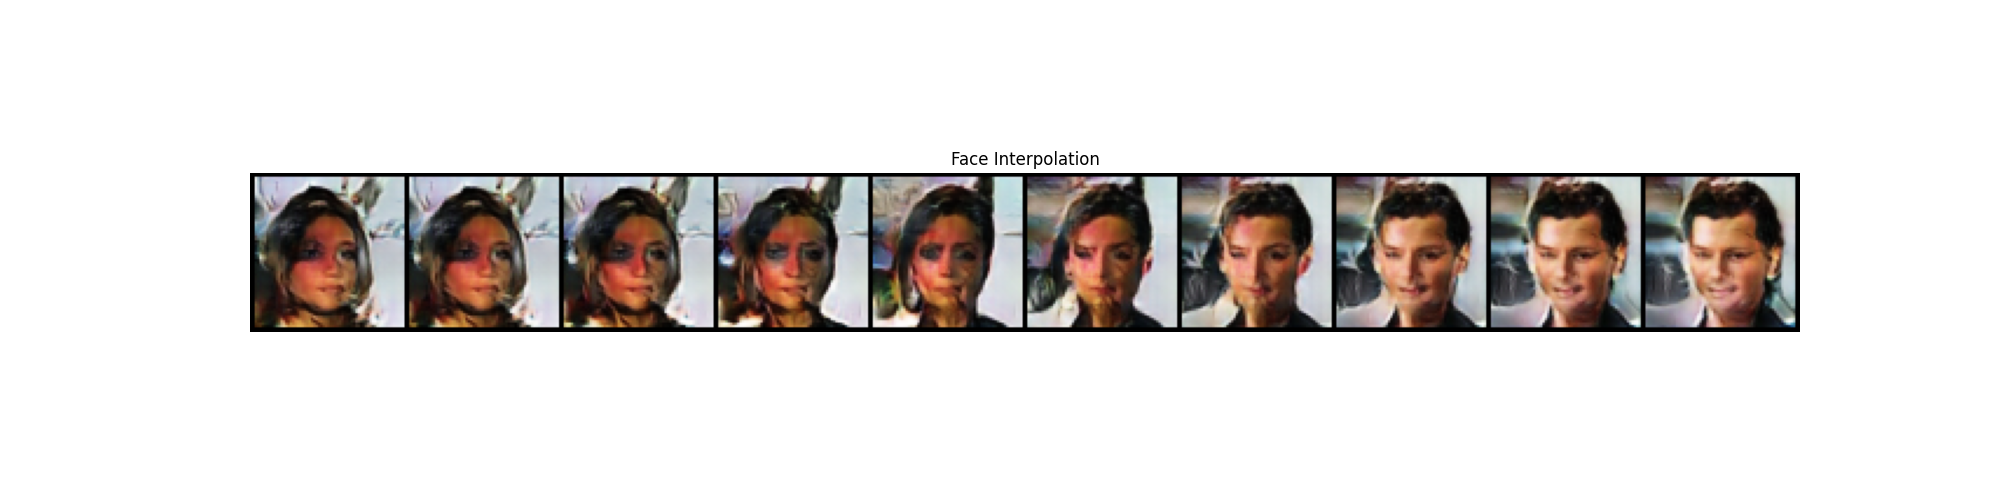|
|Trained Image(Final Epoch)|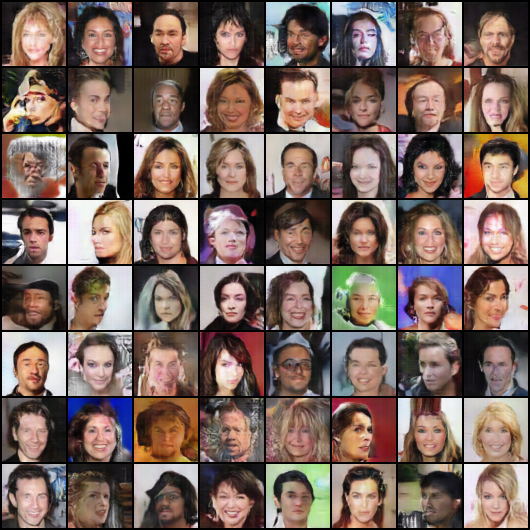|
|Generated Faces|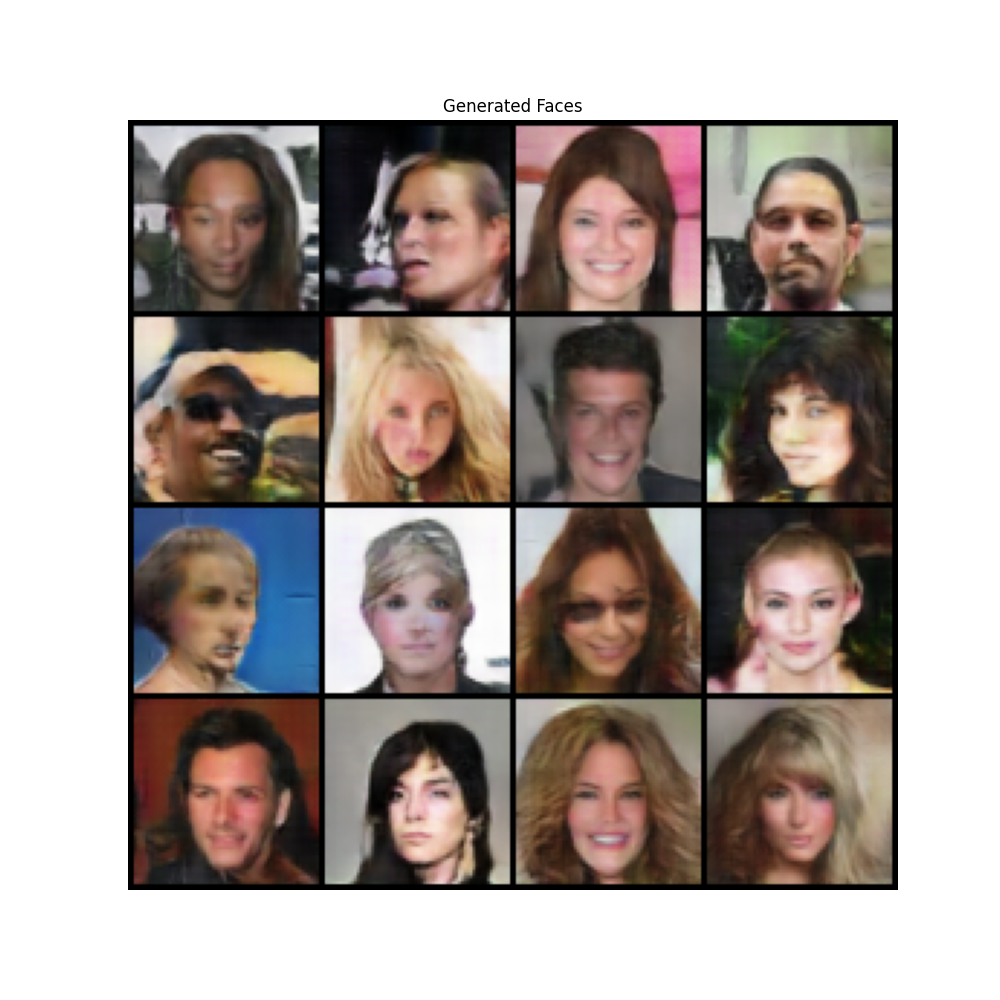|
|Loss Plot|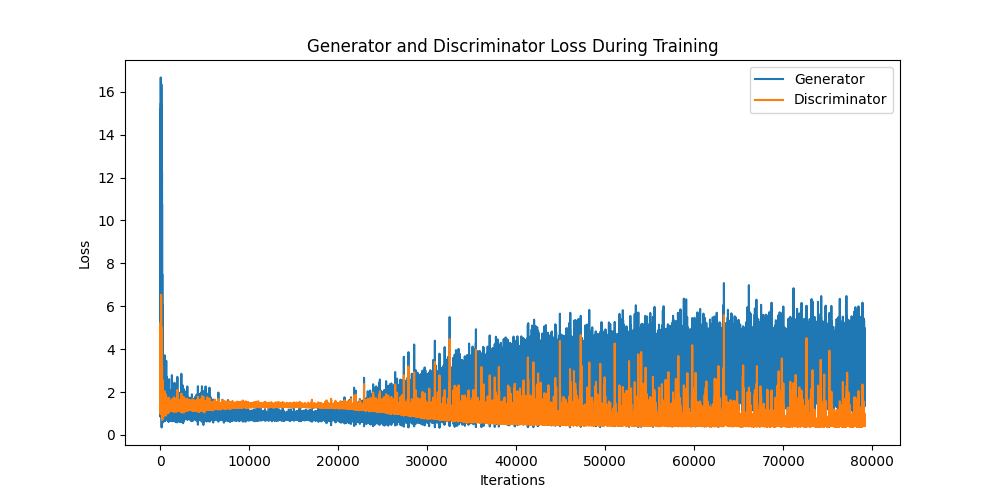|
|Score Plot|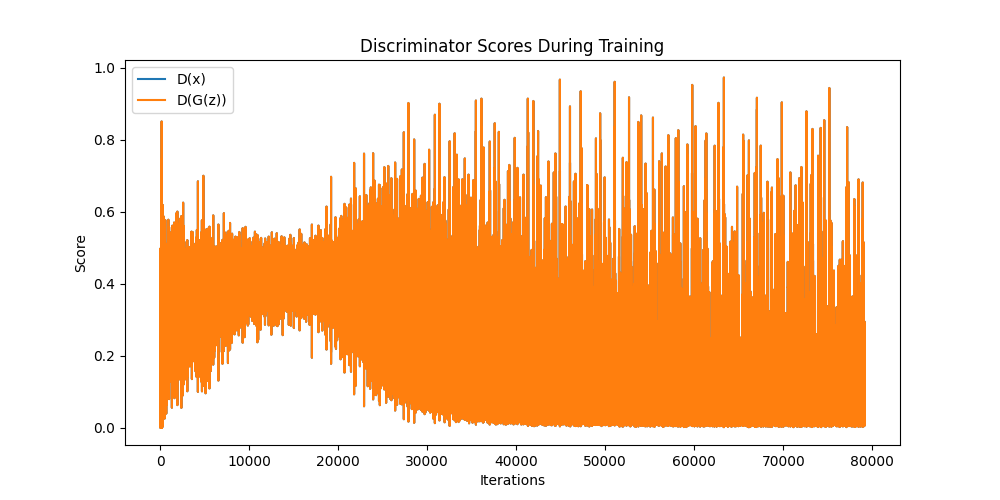|

## Training Dynamics

### Initial Phase (Epochs 0-5)
- **Discriminator Loss**: Started high (~2.05) and fluctuated significantly
- **Generator Loss**: Initially very high (4.36-12.28), indicating poor generation quality
- **D(x)**: Began around 0.33 (poor real image classification) and improved to 0.7+
- **D(G(z))**: Started at 0.01 (excellent fake detection) and remained low (0.03-0.08)

This phase shows the discriminator quickly learning to distinguish real faces from the initially poor generator outputs.

### Middle Phase (Epochs 28-32)
- **Discriminator Loss**: Stabilized in the range of 0.5-0.9
- **Generator Loss**: Fluctuated widely between 0.6-5.2
- **D(x)**: Consistently high (0.7-0.9), showing strong real image recognition
- **D(G(z))**: Mostly low (0.05-0.15) with occasional spikes to 0.5+

This indicates the discriminator maintained dominance while the generator struggled with consistent improvement, showing signs of mode collapse and recovery cycles.

### Later Phase (Epochs 33-36)
- **Discriminator Loss**: Continued in the 0.4-1.2 range
- **Generator Loss**: Alternated between very high (3.0-4.6) and low (0.6-1.5) values
- **D(x)**: Typically 0.7-0.9 with occasional drops to 0.4-0.5
- **D(G(z))**: Mostly 0.02-0.08 with occasional spikes to 0.6+

The significant oscillations in generator loss and D(G(z)) suggest the training had not reached equilibrium, with the generator occasionally making breakthroughs before being countered by the discriminator.

## Key Observations

1. **Discriminator Dominance**: Throughout training, the discriminator consistently outperformed the generator, as evidenced by high D(x) and low D(G(z)) values. This indicates the discriminator could easily distinguish real from generated faces.

2. **Training Instability**: The generator loss showed high variance (0.6-5.2), suggesting unstable training dynamics typical of GANs on complex datasets.

3. **Mode Collapse Cycles**: Periodic spikes in D(G(z)) to values like 0.65 (epoch 36) followed by rapid drops suggest temporary mode collapse followed by recovery.

4. **Alternating Training Strategy**: The implementation used an alternating training approach (training the discriminator only every other batch), which likely prevented complete discriminator dominance.

5. **Label Smoothing Effect**: Using 0.9 instead of 1.0 for real labels helped stabilize training, though the discriminator still maintained an advantage.

## Computational Requirements

- Each epoch took approximately 95-97 seconds on an NVIDIA GeForce RTX 2080 Ti
- The dataset contained 202,599 images, processed in batches of 128
- Training was set for 50 epochs, with model checkpoints saved every 5 epochs

# Thank You 🤗
 
Here's the Github Repository Link: https://github.com/aryashah2k/RTML/tree/main/A5

Model Checkpoints and Weights can be downloaded from the Terabox Drive here: https://1024terabox.com/s/17s9DsZ2UyqNk77cPi_rHJw